<a href="https://colab.research.google.com/github/Olimaol/notebooks-deeprl/blob/main/solutions-output/13-PPO.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PPO

The goal of this exercise is to use the `tianshou` library to apply PPO on the cartpole environment. `tianshou` is the latest and most up-to-date DRL library. It is based on pytorch for the deep networks and is the only library currently compatible with gymnasium, not gym.

Github: <https://github.com/thu-ml/tianshou> \
Documentation: <https://tianshou.readthedocs.io/en/latest>

Because the dependencies of `tianshou` are pretty wild, we will create a new environment. Use the provided `requirements_tianshou.txt` file to install the necessary packages. You can do this by running:

```bash
pip install -r requirements_tianshou.txt
```

Let's first import the usual stuff:

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install -U gymnasium==0.28.1 pygame
    !pip install moviepy==1.0.3
    !pip install -U tianshou

In [2]:
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
from collections import deque
import tqdm

import gymnasium as gym
print("gym version:", gym.__version__)

import tianshou as ts
print("tianshou version:", ts.__version__)

import torch
if torch.cuda.is_available(): # GPU
    device = torch.device("cuda")
else: # CPU
    device = torch.device("cpu")
print(f"Device: {device}")

import pygame
from moviepy.editor import ImageSequenceClip, ipython_display


class GymRecorder(object):
    """
    Simple wrapper over moviepy to generate a .gif with the frames of a gym environment.

    The environment must have the render_mode `rgb_array_list`.
    """
    def __init__(self, env):
        self.env = env
        self._frames = []

    def record(self, frames):
        "To be called at the end of an episode."
        for frame in frames:
            self._frames.append(np.array(frame))

    def make_video(self, filename):
        "Generates the gif video."
        directory = os.path.dirname(os.path.abspath(filename))
        if not os.path.exists(directory):
            os.mkdir(directory)
        self.clip = ImageSequenceClip(list(self._frames), fps=self.env.metadata["render_fps"])
        self.clip.write_gif(filename, fps=self.env.metadata["render_fps"], loop=0)
        del self._frames
        self._frames = []

gym version: 0.28.1


tianshou version: 1.2.0
Device: cpu


/home/runner/work/notebooks-deeprl/notebooks-deeprl/.venv-tianshou/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


## tianshou

### Structure

``tianshou`` provides an implementation of most model-free algorithms seen in the course: DQN and its variants, A3C, DDPG, PPO and more. It also has several offline RL algorithms. You can see the list of algorithms here:

<https://tianshou.readthedocs.io/en/latest/index.html>

``tianshou`` relies on several concepts, which are explained here:

<https://tianshou.readthedocs.io/en/latest/01_tutorials/01_concepts.html#>

![](https://tianshou.readthedocs.io/en/latest/_images/concepts_arch2.png)

* The **policy** is actually the DRL algorithm (DQN, PPO), not the mapping from states into actions used in the course. It relies on one (or more) neural networks called the **model**.
* The interaction of the policy with the environment is done by the **collector**. By default, the collector used **distributed learning**, i.e. it uses parallel workers to interact with copies of the environment, thereby speeding up data collection. This is used even for algorithms which do not need distributed learning (DQN), as it is only beneficial.
* The data collected by the collector is stored in a **buffer**, which can be an ERM for off-policy algorithms or a temporary buffer for on-policy ones.
* The (distributed) data is stored in **batches**. How data circulates between the collector, the policy and the buffer during training is controlled by the **trainer**.

Let's demonstrate this interaction with a dummy DQN network on Cartpole:

In [3]:
env = gym.make('CartPole-v0')

### Policy

The first step is to create the neural network for the DQN network. It must have `env.observation_space.shape=4` input neurons and `env.action_space.n=2` discrete output neurons. Let's put two hidden layers with 64 neurons for now:

In [4]:
net = ts.utils.net.common.Net(
    env.observation_space.shape,
    env.action_space.n,
    hidden_sizes=[64, 64],
    device=device,
).to(device)

optim = torch.optim.Adam(net.parameters(), lr=0.001)

`optim` is the Adam optimizer in pytorch, modifying all parameters (weights and biases) of the value network. Check the doc of `Net()` if you want a more specific architecture.

The output layer of the network is discrete, so that tianshou knows how to sample an action from the output (here the output neurons represent the Q-values, but it could be logits of a continuous policy).

Now that we have the neural network, we can create the DQN policy object:

In [5]:
policy = ts.policy.DQNPolicy(
    model=net, # value network
    optim=optim, # optimizer
    discount_factor=0.95, # gamma
    target_update_freq=1000, # how often to update the target network
    action_space=env.action_space, # action space
)
policy.set_eps(0.1) # epsilon-greedy action selection

Check the doc of `DQNPolicy` for additional parameters (e.g. to implement a double duelling DQN).

We can now use the policy to interact with the environment as usual and visualize a trial with an untrained network:

Return: 10.0
MoviePy - Building file videos/cartpole-before.gif with imageio.


t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


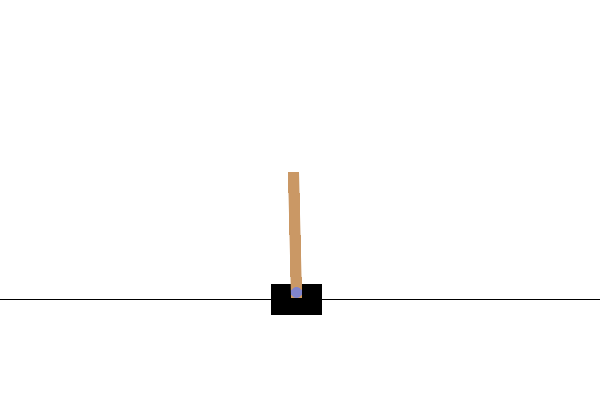

In [6]:
# Evaluation mode
policy.eval()

# Create a recordable environment
env = gym.make('CartPole-v0', render_mode="rgb_array_list")
recorder = GymRecorder(env)

# Sample the initial state
state, info = env.reset()

# One episode:
done = False
return_episode = 0
while not done:

    # Select an action from the learned policy
    action = policy.forward(ts.data.Batch(obs=[state], info=None)).act[0]

    # Sample a single transition
    next_state, reward, terminal, truncated, info = env.step(action)

    # End of the episode
    done = terminal or truncated

    # Update undiscounted return
    return_episode += reward

    # Go in the next state
    state = next_state

print("Return:", return_episode)

recorder.record(env.render())
video = "videos/cartpole-before.gif"
recorder.make_video(video)
ipython_display(video)

The action selection is done by calling `policy.forward()` on a batch of data containing only the current state:

```python
action = policy.forward(ts.data.Batch(obs=[state], info=None)).act[0]
```

### Collector

As we have seen in the DQN exercise, using a neural network with a batch size of 1 is extremely inefficient and slow. It is much better to use **distributed learning** and parallel workers to collect data. That way, we can form a minibatch of states that can be processed efficiently by the NN.

In [7]:
collector = ts.data.Collector(
    policy=policy,
    env=ts.env.DummyVectorEnv([lambda: gym.make('CartPole-v0') for _ in range(10)]),
    exploration_noise=True
)

`policy` is the exploration policy. The `exploration_noise` flag allows to switch exploration on and off. For a discrete DQN policy, this impacts the $\epsilon$-greedy action selection scheme, but other algorithms might use another mechanism (softmax, Gaussian policies, Ornstein-Uhlenbeck, noisy parameters, etc).

`ts.env.DummyVectorEnv([lambda: gym.make('CartPole-v0') for _ in range(10)])` means that we create 10 copies of the Cartpole environment which will be acted upon in parallel using the policy.

Let's collect some data with the collector. We can either collect a fixed number of steps (over the parallel workers) or episodes. Let's start with 10 steps:

In [8]:
collector.reset()
collector.collect(n_step=10)

CollectStats(n_collected_episodes=0, n_collected_steps=10, collect_time=0.005162239074707031, collect_speed=1937.1439128025124, returns=array([], dtype=float64), returns_stat=None, lens=array([], dtype=int64), lens_stat=None, pred_dist_std_array=None, pred_dist_std_array_stat=None)

That's weird, we apparently did not receive any reward. Let's try to collect more steps.

In [9]:
collector.collect(n_step=1000)

CollectStats(n_collected_episodes=96, n_collected_steps=1000, collect_time=0.1048135757446289, collect_speed=9540.748828533733, returns=array([ 8.,  9., 10., 10., 10., 10., 11., 11., 11., 11., 10., 10., 10.,
       12., 10., 10., 10., 11., 12., 11.,  8., 10.,  8.,  9., 10., 10.,
       11.,  9., 10.,  9.,  9.,  8.,  9.,  9.,  9., 10., 10., 11., 11.,
       11.,  9., 10.,  8., 10.,  9., 11., 11., 10.,  8., 14., 14., 10.,
        9., 10.,  8.,  9.,  9., 10.,  9., 11., 10.,  8.,  9., 10., 10.,
        9., 10., 11.,  8., 10., 10., 10., 10., 10., 11., 11.,  8.,  9.,
       11.,  9., 10., 17., 10.,  9., 10., 11., 12., 10.,  9., 10.,  9.,
        9.,  8., 15.,  9., 11.]), returns_stat=SequenceSummaryStats(mean=10.0, std=1.4577379737113252, max=17.0, min=8.0), lens=array([ 8,  9, 10, 10, 10, 10, 11, 11, 11, 11, 10, 10, 10, 12, 10, 10, 10,
       11, 12, 11,  8, 10,  8,  9, 10, 10, 11,  9, 10,  9,  9,  8,  9,  9,
        9, 10, 10, 11, 11, 11,  9, 10,  8, 10,  9, 11, 11, 10,  8, 14, 14,
       

Alright, returns are only reported at the end of an episode. With 1000 steps (in parallel over 10 workers, i.e. each of them did 100 steps), we collected around 100 episodes of length 9 or 10, i.e. the cartpole falls right away, as expected with a random policy.

Can we collect complete episodes? Yes:

In [10]:
collector.reset()
collector.collect(n_episode=10)

CollectStats(n_collected_episodes=10, n_collected_steps=96, collect_time=0.01196432113647461, collect_speed=8023.856841098402, returns=array([ 9.,  9.,  9.,  9.,  9., 10., 10., 10., 10., 11.]), returns_stat=SequenceSummaryStats(mean=9.6, std=0.66332495807108, max=11.0, min=9.0), lens=array([ 9,  9,  9,  9,  9, 10, 10, 10, 10, 11]), lens_stat=SequenceSummaryStats(mean=9.6, std=0.66332495807108, max=11.0, min=9.0), pred_dist_std_array=None, pred_dist_std_array_stat=None)


But where is the data, i.e. the collected transitions? Nowhere, because we forgot to create a buffer to store them. Let's fix that mistake.

In [11]:
collector = ts.data.Collector(
    policy=policy,
    env=ts.env.DummyVectorEnv([lambda: gym.make('CartPole-v0') for _ in range(10)]),
    buffer=ts.data.VectorReplayBuffer(1000, 10),
    exploration_noise=True,
)

We preallocate an ERM of max 1000 transitions for each of the 10 workers. One could use a single replay buffer 10 times bigger, but tianshou requires it . Let's collect some episodes and look at the data stored in the first buffer. 

Notice that the collector must be reset before collecting complete episodes. This makes sure that the environments are initialized correctly. 

In [12]:
collector.reset()
collector.collect(n_episode=10)
collector.buffer.buffers[0]

ReplayBuffer(
    terminated: array([False, False, False, False, False, False, False, False, False,
                       False, False, False,  True, False, False, False, False, False,
                       False, False, False, False, False, False, False, False, False,
                       False, False, False, False, False, False, False, False, False,
                       False, False, False, False, False, False, False, False, False,
                       False, False, False, False, False, False, False, False, False,
                       False, False, False, False, False, False, False, False, False,
                       False, False, False, False, False, False, False, False, False,
                       False, False, False, False, False, False, False, False, False,
                       False, False, False, False, False, False, False, False, False,
                       False, False, False, False, False, False, False, False, False,
                       False]),
    obs_

We see that each element of the transitions (s, a, r, s', done, terminated) is saved in a preallocated array of 1000 entries. The first replay buffer has only saved one short episode, so most of the data is zero.

Sampling a minibatch of transitions is easy:

In [13]:
collector.buffer.sample(10)

(Batch(
     obs: array([[-0.038499  , -0.8226918 , -0.00765295,  1.1408259 ],
                 [-0.03249577, -0.753148  ,  0.08498065,  1.2628031 ],
                 [-0.01081146, -0.16563044,  0.04646896,  0.33423787],
                 [-0.06052857, -1.2115067 ,  0.13022153,  1.8194797 ],
                 [-0.00905612, -0.78532887,  0.0301313 ,  1.1577351 ],
                 [ 0.03026135, -0.5905525 , -0.02768781,  0.87304187],
                 [-0.04989533, -1.1946677 ,  0.07777084,  1.7677611 ],
                 [-0.08094305, -0.7499121 ,  0.12825374,  1.2774798 ],
                 [-0.06405446, -1.1677266 ,  0.12996744,  1.8802637 ],
                 [-0.07559307, -0.80383575,  0.05527544,  1.1973662 ]],
                dtype=float32),
     act: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
     rew: array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
     terminated: array([False, False, False, False, False, False, False, False, False,
                        False]),
     truncated: array

Anyway, we will use a method that automatically sample the replay buffer, but it is nice to have such a low-level control over the data.

### Interaction loop

We do not need to sample the buffer in the interaction loop, because `policy.update()` takes the buffer and a batch size as input. The following code implements DQN on Cartpole, with a rather poor choice of hyperparameters (do not expect a nice a stable performance). The main interaction loop consists of:

1. `collector.collect()`: Collect 100 samples using the 10 workers and store them in the ERM.
2. `policy.update()`: Sample `repeat=10` minibatches of 64 transitions from the buffer and learn from them.
3. `test_collector.collect()`: Test the performance by running 10 episodes without exploration.


  0%|          | 0/1000 [00:00<?, ?it/s]

reward : 41.4:   0%|          | 0/1000 [00:00<?, ?it/s]

reward : 48.9:   0%|          | 0/1000 [00:00<?, ?it/s]

reward : 48.9:   0%|          | 2/1000 [00:00<01:12, 13.84it/s]

reward : 41.4:   0%|          | 2/1000 [00:00<01:12, 13.84it/s]

reward : 50.1:   0%|          | 2/1000 [00:00<01:12, 13.84it/s]

reward : 50.1:   0%|          | 4/1000 [00:00<01:08, 14.54it/s]

reward : 50.1:   0%|          | 4/1000 [00:00<01:08, 14.54it/s]

reward : 65.0:   0%|          | 4/1000 [00:00<01:08, 14.54it/s]

reward : 65.0:   1%|          | 6/1000 [00:00<01:22, 12.11it/s]

reward : 45.2:   1%|          | 6/1000 [00:00<01:22, 12.11it/s]

reward : 53.4:   1%|          | 6/1000 [00:00<01:22, 12.11it/s]

reward : 53.4:   1%|          | 8/1000 [00:00<01:17, 12.86it/s]

reward : 53.0:   1%|          | 8/1000 [00:00<01:17, 12.86it/s]

reward : 49.8:   1%|          | 8/1000 [00:00<01:17, 12.86it/s]

reward : 49.8:   1%|          | 10/1000 [00:00<01:16, 12.87it/s]

reward : 47.5:   1%|          | 10/1000 [00:00<01:16, 12.87it/s]

reward : 68.1:   1%|          | 10/1000 [00:00<01:16, 12.87it/s]

reward : 68.1:   1%|          | 12/1000 [00:00<01:22, 11.94it/s]

reward : 55.0:   1%|          | 12/1000 [00:01<01:22, 11.94it/s]

reward : 53.0:   1%|          | 12/1000 [00:01<01:22, 11.94it/s]

reward : 53.0:   1%|▏         | 14/1000 [00:01<01:22, 11.96it/s]

reward : 51.3:   1%|▏         | 14/1000 [00:01<01:22, 11.96it/s]

reward : 57.1:   1%|▏         | 14/1000 [00:01<01:22, 11.96it/s]

reward : 57.1:   2%|▏         | 16/1000 [00:01<01:24, 11.63it/s]

reward : 50.7:   2%|▏         | 16/1000 [00:01<01:24, 11.63it/s]

reward : 53.4:   2%|▏         | 16/1000 [00:01<01:24, 11.63it/s]

reward : 53.4:   2%|▏         | 18/1000 [00:01<01:24, 11.68it/s]

reward : 53.3:   2%|▏         | 18/1000 [00:01<01:24, 11.68it/s]

reward : 75.7:   2%|▏         | 18/1000 [00:01<01:24, 11.68it/s]

reward : 75.7:   2%|▏         | 20/1000 [00:01<01:27, 11.15it/s]

reward : 66.7:   2%|▏         | 20/1000 [00:01<01:27, 11.15it/s]

reward : 67.4:   2%|▏         | 20/1000 [00:01<01:27, 11.15it/s]

reward : 67.4:   2%|▏         | 22/1000 [00:01<01:33, 10.51it/s]

reward : 62.4:   2%|▏         | 22/1000 [00:01<01:33, 10.51it/s]

reward : 71.0:   2%|▏         | 22/1000 [00:02<01:33, 10.51it/s]

reward : 71.0:   2%|▏         | 24/1000 [00:02<01:30, 10.78it/s]

reward : 74.5:   2%|▏         | 24/1000 [00:02<01:30, 10.78it/s]

reward : 99.9:   2%|▏         | 24/1000 [00:02<01:30, 10.78it/s]

reward : 99.9:   3%|▎         | 26/1000 [00:02<01:40,  9.68it/s]

reward : 96.3:   3%|▎         | 26/1000 [00:02<01:40,  9.68it/s]

reward : 96.3:   3%|▎         | 27/1000 [00:02<01:46,  9.18it/s]

reward : 91.6:   3%|▎         | 27/1000 [00:02<01:46,  9.18it/s]

reward : 91.6:   3%|▎         | 28/1000 [00:02<01:53,  8.57it/s]

reward : 60.2:   3%|▎         | 28/1000 [00:02<01:53,  8.57it/s]

reward : 73.5:   3%|▎         | 28/1000 [00:02<01:53,  8.57it/s]

reward : 73.5:   3%|▎         | 30/1000 [00:02<01:49,  8.85it/s]

reward : 54.7:   3%|▎         | 30/1000 [00:02<01:49,  8.85it/s]

reward : 59.8:   3%|▎         | 30/1000 [00:03<01:49,  8.85it/s]

reward : 59.8:   3%|▎         | 32/1000 [00:03<01:48,  8.89it/s]

reward : 60.6:   3%|▎         | 32/1000 [00:03<01:48,  8.89it/s]

reward : 60.6:   3%|▎         | 33/1000 [00:03<01:46,  9.08it/s]

reward : 45.0:   3%|▎         | 33/1000 [00:03<01:46,  9.08it/s]

reward : 52.0:   3%|▎         | 33/1000 [00:03<01:46,  9.08it/s]

reward : 52.0:   4%|▎         | 35/1000 [00:03<01:38,  9.82it/s]

reward : 49.2:   4%|▎         | 35/1000 [00:03<01:38,  9.82it/s]

reward : 62.5:   4%|▎         | 35/1000 [00:03<01:38,  9.82it/s]

reward : 62.5:   4%|▎         | 37/1000 [00:03<01:36,  9.98it/s]

reward : 85.0:   4%|▎         | 37/1000 [00:03<01:36,  9.98it/s]

reward : 85.0:   4%|▍         | 38/1000 [00:03<01:41,  9.49it/s]

reward : 57.7:   4%|▍         | 38/1000 [00:03<01:41,  9.49it/s]

reward : 57.7:   4%|▍         | 39/1000 [00:03<01:40,  9.55it/s]

reward : 52.6:   4%|▍         | 39/1000 [00:03<01:40,  9.55it/s]

reward : 79.0:   4%|▍         | 39/1000 [00:03<01:40,  9.55it/s]

reward : 79.0:   4%|▍         | 41/1000 [00:03<01:38,  9.76it/s]

reward : 90.5:   4%|▍         | 41/1000 [00:04<01:38,  9.76it/s]

reward : 90.5:   4%|▍         | 42/1000 [00:04<01:46,  8.98it/s]

reward : 59.4:   4%|▍         | 42/1000 [00:04<01:46,  8.98it/s]

reward : 54.6:   4%|▍         | 42/1000 [00:04<01:46,  8.98it/s]

reward : 54.6:   4%|▍         | 44/1000 [00:04<01:37,  9.80it/s]

reward : 50.4:   4%|▍         | 44/1000 [00:04<01:37,  9.80it/s]

reward : 41.6:   4%|▍         | 44/1000 [00:04<01:37,  9.80it/s]

reward : 41.6:   5%|▍         | 46/1000 [00:04<01:30, 10.50it/s]

reward : 38.5:   5%|▍         | 46/1000 [00:04<01:30, 10.50it/s]

reward : 27.6:   5%|▍         | 46/1000 [00:04<01:30, 10.50it/s]

reward : 27.6:   5%|▍         | 48/1000 [00:04<01:19, 12.04it/s]

reward : 22.5:   5%|▍         | 48/1000 [00:04<01:19, 12.04it/s]

reward : 21.6:   5%|▍         | 48/1000 [00:04<01:19, 12.04it/s]

reward : 22.5:   5%|▍         | 48/1000 [00:04<01:19, 12.04it/s]

reward : 22.5:   5%|▌         | 51/1000 [00:04<01:05, 14.57it/s]

reward : 19.4:   5%|▌         | 51/1000 [00:04<01:05, 14.57it/s]

reward : 15.1:   5%|▌         | 51/1000 [00:04<01:05, 14.57it/s]

reward : 14.5:   5%|▌         | 51/1000 [00:04<01:05, 14.57it/s]

reward : 14.5:   5%|▌         | 54/1000 [00:04<00:56, 16.85it/s]

reward : 14.3:   5%|▌         | 54/1000 [00:04<00:56, 16.85it/s]

reward : 13.7:   5%|▌         | 54/1000 [00:04<00:56, 16.85it/s]

reward : 13.0:   5%|▌         | 54/1000 [00:04<00:56, 16.85it/s]

reward : 13.0:   6%|▌         | 57/1000 [00:04<00:50, 18.85it/s]

reward : 11.9:   6%|▌         | 57/1000 [00:04<00:50, 18.85it/s]

reward : 12.9:   6%|▌         | 57/1000 [00:05<00:50, 18.85it/s]

reward : 12.5:   6%|▌         | 57/1000 [00:05<00:50, 18.85it/s]

reward : 12.5:   6%|▌         | 60/1000 [00:05<00:46, 20.40it/s]

reward : 10.8:   6%|▌         | 60/1000 [00:05<00:46, 20.40it/s]

reward : 11.8:   6%|▌         | 60/1000 [00:05<00:46, 20.40it/s]

reward : 11.1:   6%|▌         | 60/1000 [00:05<00:46, 20.40it/s]

reward : 11.1:   6%|▋         | 63/1000 [00:05<00:43, 21.72it/s]

reward : 11.0:   6%|▋         | 63/1000 [00:05<00:43, 21.72it/s]

reward : 10.3:   6%|▋         | 63/1000 [00:05<00:43, 21.72it/s]

reward : 10.1:   6%|▋         | 63/1000 [00:05<00:43, 21.72it/s]

reward : 10.1:   7%|▋         | 66/1000 [00:05<00:41, 22.74it/s]

reward : 10.5:   7%|▋         | 66/1000 [00:05<00:41, 22.74it/s]

reward : 9.3:   7%|▋         | 66/1000 [00:05<00:41, 22.74it/s] 

reward : 9.4:   7%|▋         | 66/1000 [00:05<00:41, 22.74it/s]

reward : 9.4:   7%|▋         | 69/1000 [00:05<00:39, 23.46it/s]

reward : 9.5:   7%|▋         | 69/1000 [00:05<00:39, 23.46it/s]

reward : 9.7:   7%|▋         | 69/1000 [00:05<00:39, 23.46it/s]

reward : 9.6:   7%|▋         | 69/1000 [00:05<00:39, 23.46it/s]

reward : 9.6:   7%|▋         | 72/1000 [00:05<00:38, 24.12it/s]

reward : 10.4:   7%|▋         | 72/1000 [00:05<00:38, 24.12it/s]

reward : 9.6:   7%|▋         | 72/1000 [00:05<00:38, 24.12it/s] 

reward : 10.3:   7%|▋         | 72/1000 [00:05<00:38, 24.12it/s]

reward : 10.3:   8%|▊         | 75/1000 [00:05<00:38, 24.17it/s]

reward : 9.7:   8%|▊         | 75/1000 [00:05<00:38, 24.17it/s] 

reward : 9.9:   8%|▊         | 75/1000 [00:05<00:38, 24.17it/s]

reward : 9.6:   8%|▊         | 75/1000 [00:05<00:38, 24.17it/s]

reward : 9.6:   8%|▊         | 78/1000 [00:05<00:38, 24.13it/s]

reward : 9.2:   8%|▊         | 78/1000 [00:05<00:38, 24.13it/s]

reward : 9.6:   8%|▊         | 78/1000 [00:05<00:38, 24.13it/s]

reward : 9.8:   8%|▊         | 78/1000 [00:05<00:38, 24.13it/s]

reward : 9.8:   8%|▊         | 81/1000 [00:05<00:38, 23.87it/s]

reward : 9.5:   8%|▊         | 81/1000 [00:05<00:38, 23.87it/s]

reward : 9.6:   8%|▊         | 81/1000 [00:05<00:38, 23.87it/s]

reward : 9.1:   8%|▊         | 81/1000 [00:06<00:38, 23.87it/s]

reward : 9.1:   8%|▊         | 84/1000 [00:06<00:38, 23.68it/s]

reward : 9.3:   8%|▊         | 84/1000 [00:06<00:38, 23.68it/s]

reward : 9.4:   8%|▊         | 84/1000 [00:06<00:38, 23.68it/s]

reward : 9.3:   8%|▊         | 84/1000 [00:06<00:38, 23.68it/s]

reward : 9.3:   9%|▊         | 87/1000 [00:06<00:38, 23.54it/s]

reward : 9.7:   9%|▊         | 87/1000 [00:06<00:38, 23.54it/s]

reward : 10.1:   9%|▊         | 87/1000 [00:06<00:38, 23.54it/s]

reward : 10.0:   9%|▊         | 87/1000 [00:06<00:38, 23.54it/s]

reward : 10.0:   9%|▉         | 90/1000 [00:06<00:39, 23.10it/s]

reward : 10.9:   9%|▉         | 90/1000 [00:06<00:39, 23.10it/s]

reward : 11.9:   9%|▉         | 90/1000 [00:06<00:39, 23.10it/s]

reward : 14.4:   9%|▉         | 90/1000 [00:06<00:39, 23.10it/s]

reward : 14.4:   9%|▉         | 93/1000 [00:06<00:40, 22.32it/s]

reward : 13.1:   9%|▉         | 93/1000 [00:06<00:40, 22.32it/s]

reward : 14.3:   9%|▉         | 93/1000 [00:06<00:40, 22.32it/s]

reward : 14.0:   9%|▉         | 93/1000 [00:06<00:40, 22.32it/s]

reward : 14.0:  10%|▉         | 96/1000 [00:06<00:41, 21.66it/s]

reward : 13.4:  10%|▉         | 96/1000 [00:06<00:41, 21.66it/s]

reward : 12.2:  10%|▉         | 96/1000 [00:06<00:41, 21.66it/s]

reward : 12.9:  10%|▉         | 96/1000 [00:06<00:41, 21.66it/s]

reward : 12.9:  10%|▉         | 99/1000 [00:06<00:41, 21.54it/s]

reward : 11.3:  10%|▉         | 99/1000 [00:06<00:41, 21.54it/s]

reward : 11.7:  10%|▉         | 99/1000 [00:06<00:41, 21.54it/s]

reward : 10.6:  10%|▉         | 99/1000 [00:06<00:41, 21.54it/s]

reward : 10.6:  10%|█         | 102/1000 [00:06<00:42, 21.36it/s]

reward : 12.3:  10%|█         | 102/1000 [00:06<00:42, 21.36it/s]

reward : 11.1:  10%|█         | 102/1000 [00:06<00:42, 21.36it/s]

reward : 11.4:  10%|█         | 102/1000 [00:07<00:42, 21.36it/s]

reward : 11.4:  10%|█         | 105/1000 [00:07<00:42, 21.18it/s]

reward : 9.5:  10%|█         | 105/1000 [00:07<00:42, 21.18it/s] 

reward : 9.4:  10%|█         | 105/1000 [00:07<00:42, 21.18it/s]

reward : 10.1:  10%|█         | 105/1000 [00:07<00:42, 21.18it/s]

reward : 10.1:  11%|█         | 108/1000 [00:07<00:41, 21.42it/s]

reward : 9.1:  11%|█         | 108/1000 [00:07<00:41, 21.42it/s] 

reward : 9.4:  11%|█         | 108/1000 [00:07<00:41, 21.42it/s]

reward : 9.8:  11%|█         | 108/1000 [00:07<00:41, 21.42it/s]

reward : 9.8:  11%|█         | 111/1000 [00:07<00:41, 21.18it/s]

reward : 10.3:  11%|█         | 111/1000 [00:07<00:41, 21.18it/s]

reward : 10.1:  11%|█         | 111/1000 [00:07<00:41, 21.18it/s]

reward : 9.8:  11%|█         | 111/1000 [00:07<00:41, 21.18it/s] 

reward : 9.8:  11%|█▏        | 114/1000 [00:07<00:41, 21.17it/s]

reward : 10.2:  11%|█▏        | 114/1000 [00:07<00:41, 21.17it/s]

reward : 9.5:  11%|█▏        | 114/1000 [00:07<00:41, 21.17it/s] 

reward : 9.5:  11%|█▏        | 114/1000 [00:07<00:41, 21.17it/s]

reward : 9.5:  12%|█▏        | 117/1000 [00:07<00:42, 21.01it/s]

reward : 9.3:  12%|█▏        | 117/1000 [00:07<00:42, 21.01it/s]

reward : 9.2:  12%|█▏        | 117/1000 [00:07<00:42, 21.01it/s]

reward : 9.3:  12%|█▏        | 117/1000 [00:07<00:42, 21.01it/s]

reward : 9.3:  12%|█▏        | 120/1000 [00:07<00:41, 21.13it/s]

reward : 9.4:  12%|█▏        | 120/1000 [00:07<00:41, 21.13it/s]

reward : 9.4:  12%|█▏        | 120/1000 [00:07<00:41, 21.13it/s]

reward : 9.8:  12%|█▏        | 120/1000 [00:07<00:41, 21.13it/s]

reward : 9.8:  12%|█▏        | 123/1000 [00:07<00:41, 21.20it/s]

reward : 9.3:  12%|█▏        | 123/1000 [00:07<00:41, 21.20it/s]

reward : 9.3:  12%|█▏        | 123/1000 [00:07<00:41, 21.20it/s]

reward : 9.6:  12%|█▏        | 123/1000 [00:08<00:41, 21.20it/s]

reward : 9.6:  13%|█▎        | 126/1000 [00:08<00:41, 20.93it/s]

reward : 9.4:  13%|█▎        | 126/1000 [00:08<00:41, 20.93it/s]

reward : 9.3:  13%|█▎        | 126/1000 [00:08<00:41, 20.93it/s]

reward : 9.3:  13%|█▎        | 126/1000 [00:08<00:41, 20.93it/s]

reward : 9.3:  13%|█▎        | 129/1000 [00:08<00:41, 21.03it/s]

reward : 9.5:  13%|█▎        | 129/1000 [00:08<00:41, 21.03it/s]

reward : 9.5:  13%|█▎        | 129/1000 [00:08<00:41, 21.03it/s]

reward : 9.6:  13%|█▎        | 129/1000 [00:08<00:41, 21.03it/s]

reward : 9.6:  13%|█▎        | 132/1000 [00:08<00:41, 21.05it/s]

reward : 9.5:  13%|█▎        | 132/1000 [00:08<00:41, 21.05it/s]

reward : 9.4:  13%|█▎        | 132/1000 [00:08<00:41, 21.05it/s]

reward : 9.3:  13%|█▎        | 132/1000 [00:08<00:41, 21.05it/s]

reward : 9.3:  14%|█▎        | 135/1000 [00:08<00:41, 21.07it/s]

reward : 12.0:  14%|█▎        | 135/1000 [00:08<00:41, 21.07it/s]

reward : 20.1:  14%|█▎        | 135/1000 [00:08<00:41, 21.07it/s]

reward : 57.1:  14%|█▎        | 135/1000 [00:08<00:41, 21.07it/s]

reward : 57.1:  14%|█▍        | 138/1000 [00:08<00:48, 17.95it/s]

reward : 9.3:  14%|█▍        | 138/1000 [00:08<00:48, 17.95it/s] 

reward : 9.2:  14%|█▍        | 138/1000 [00:08<00:48, 17.95it/s]

reward : 9.1:  14%|█▍        | 138/1000 [00:08<00:48, 17.95it/s]

reward : 9.1:  14%|█▍        | 141/1000 [00:08<00:46, 18.64it/s]

reward : 9.5:  14%|█▍        | 141/1000 [00:08<00:46, 18.64it/s]

reward : 9.1:  14%|█▍        | 141/1000 [00:08<00:46, 18.64it/s]

reward : 10.0:  14%|█▍        | 141/1000 [00:08<00:46, 18.64it/s]

reward : 10.0:  14%|█▍        | 144/1000 [00:08<00:44, 19.07it/s]

reward : 9.7:  14%|█▍        | 144/1000 [00:09<00:44, 19.07it/s] 

reward : 9.3:  14%|█▍        | 144/1000 [00:09<00:44, 19.07it/s]

reward : 9.3:  15%|█▍        | 146/1000 [00:09<00:44, 19.27it/s]

reward : 9.1:  15%|█▍        | 146/1000 [00:09<00:44, 19.27it/s]

reward : 10.4:  15%|█▍        | 146/1000 [00:09<00:44, 19.27it/s]

reward : 13.2:  15%|█▍        | 146/1000 [00:09<00:44, 19.27it/s]

reward : 13.2:  15%|█▍        | 149/1000 [00:09<00:43, 19.35it/s]

reward : 28.5:  15%|█▍        | 149/1000 [00:09<00:43, 19.35it/s]

reward : 45.3:  15%|█▍        | 149/1000 [00:09<00:43, 19.35it/s]

reward : 45.3:  15%|█▌        | 151/1000 [00:09<00:49, 17.29it/s]

reward : 100.5:  15%|█▌        | 151/1000 [00:09<00:49, 17.29it/s]

reward : 116.7:  15%|█▌        | 151/1000 [00:09<00:49, 17.29it/s]

reward : 116.7:  15%|█▌        | 153/1000 [00:09<01:09, 12.23it/s]

reward : 32.1:  15%|█▌        | 153/1000 [00:09<01:09, 12.23it/s] 

reward : 19.3:  15%|█▌        | 153/1000 [00:09<01:09, 12.23it/s]

reward : 19.3:  16%|█▌        | 155/1000 [00:09<01:06, 12.72it/s]

reward : 17.0:  16%|█▌        | 155/1000 [00:09<01:06, 12.72it/s]

reward : 14.2:  16%|█▌        | 155/1000 [00:09<01:06, 12.72it/s]

reward : 14.2:  16%|█▌        | 157/1000 [00:09<01:01, 13.68it/s]

reward : 12.9:  16%|█▌        | 157/1000 [00:09<01:01, 13.68it/s]

reward : 9.9:  16%|█▌        | 157/1000 [00:10<01:01, 13.68it/s] 

reward : 9.9:  16%|█▌        | 159/1000 [00:10<00:56, 14.85it/s]

reward : 9.9:  16%|█▌        | 159/1000 [00:10<00:56, 14.85it/s]

reward : 9.3:  16%|█▌        | 159/1000 [00:10<00:56, 14.85it/s]

reward : 9.3:  16%|█▌        | 161/1000 [00:10<00:53, 15.81it/s]

reward : 9.4:  16%|█▌        | 161/1000 [00:10<00:53, 15.81it/s]

reward : 9.1:  16%|█▌        | 161/1000 [00:10<00:53, 15.81it/s]

reward : 9.1:  16%|█▋        | 163/1000 [00:10<00:49, 16.76it/s]

reward : 9.4:  16%|█▋        | 163/1000 [00:10<00:49, 16.76it/s]

reward : 9.7:  16%|█▋        | 163/1000 [00:10<00:49, 16.76it/s]

reward : 9.7:  16%|█▋        | 165/1000 [00:10<00:47, 17.44it/s]

reward : 9.3:  16%|█▋        | 165/1000 [00:10<00:47, 17.44it/s]

reward : 9.5:  16%|█▋        | 165/1000 [00:10<00:47, 17.44it/s]

reward : 9.5:  17%|█▋        | 167/1000 [00:10<00:46, 18.11it/s]

reward : 9.8:  17%|█▋        | 167/1000 [00:10<00:46, 18.11it/s]

reward : 9.3:  17%|█▋        | 167/1000 [00:10<00:46, 18.11it/s]

reward : 9.3:  17%|█▋        | 169/1000 [00:10<00:44, 18.53it/s]

reward : 9.4:  17%|█▋        | 169/1000 [00:10<00:44, 18.53it/s]

reward : 9.7:  17%|█▋        | 169/1000 [00:10<00:44, 18.53it/s]

reward : 9.7:  17%|█▋        | 171/1000 [00:10<00:44, 18.72it/s]

reward : 9.4:  17%|█▋        | 171/1000 [00:10<00:44, 18.72it/s]

reward : 9.4:  17%|█▋        | 171/1000 [00:10<00:44, 18.72it/s]

reward : 9.4:  17%|█▋        | 173/1000 [00:10<00:43, 18.88it/s]

reward : 9.4:  17%|█▋        | 173/1000 [00:10<00:43, 18.88it/s]

reward : 9.6:  17%|█▋        | 173/1000 [00:10<00:43, 18.88it/s]

reward : 9.6:  18%|█▊        | 175/1000 [00:10<00:43, 18.90it/s]

reward : 9.2:  18%|█▊        | 175/1000 [00:10<00:43, 18.90it/s]

reward : 8.9:  18%|█▊        | 175/1000 [00:10<00:43, 18.90it/s]

reward : 8.9:  18%|█▊        | 177/1000 [00:10<00:43, 19.10it/s]

reward : 9.4:  18%|█▊        | 177/1000 [00:11<00:43, 19.10it/s]

reward : 9.6:  18%|█▊        | 177/1000 [00:11<00:43, 19.10it/s]

reward : 9.6:  18%|█▊        | 179/1000 [00:11<00:43, 19.03it/s]

reward : 9.3:  18%|█▊        | 179/1000 [00:11<00:43, 19.03it/s]

reward : 10.2:  18%|█▊        | 179/1000 [00:11<00:43, 19.03it/s]

reward : 10.2:  18%|█▊        | 181/1000 [00:11<00:42, 19.09it/s]

reward : 10.1:  18%|█▊        | 181/1000 [00:11<00:42, 19.09it/s]

reward : 9.8:  18%|█▊        | 181/1000 [00:11<00:42, 19.09it/s] 

reward : 9.8:  18%|█▊        | 183/1000 [00:11<00:43, 18.93it/s]

reward : 11.4:  18%|█▊        | 183/1000 [00:11<00:43, 18.93it/s]

reward : 11.9:  18%|█▊        | 183/1000 [00:11<00:43, 18.93it/s]

reward : 11.9:  18%|█▊        | 185/1000 [00:11<00:43, 18.60it/s]

reward : 10.6:  18%|█▊        | 185/1000 [00:11<00:43, 18.60it/s]

reward : 10.7:  18%|█▊        | 185/1000 [00:11<00:43, 18.60it/s]

reward : 10.7:  19%|█▊        | 187/1000 [00:11<00:43, 18.51it/s]

reward : 9.9:  19%|█▊        | 187/1000 [00:11<00:43, 18.51it/s] 

reward : 9.1:  19%|█▊        | 187/1000 [00:11<00:43, 18.51it/s]

reward : 9.1:  19%|█▉        | 189/1000 [00:11<00:43, 18.58it/s]

reward : 9.1:  19%|█▉        | 189/1000 [00:11<00:43, 18.58it/s]

reward : 9.6:  19%|█▉        | 189/1000 [00:11<00:43, 18.58it/s]

reward : 9.6:  19%|█▉        | 191/1000 [00:11<00:43, 18.68it/s]

reward : 9.5:  19%|█▉        | 191/1000 [00:11<00:43, 18.68it/s]

reward : 9.2:  19%|█▉        | 191/1000 [00:11<00:43, 18.68it/s]

reward : 9.2:  19%|█▉        | 193/1000 [00:11<00:42, 18.91it/s]

reward : 9.1:  19%|█▉        | 193/1000 [00:11<00:42, 18.91it/s]

reward : 9.2:  19%|█▉        | 193/1000 [00:11<00:42, 18.91it/s]

reward : 9.2:  20%|█▉        | 195/1000 [00:11<00:42, 19.02it/s]

reward : 9.5:  20%|█▉        | 195/1000 [00:11<00:42, 19.02it/s]

reward : 9.7:  20%|█▉        | 195/1000 [00:12<00:42, 19.02it/s]

reward : 9.7:  20%|█▉        | 197/1000 [00:12<00:42, 18.97it/s]

reward : 9.6:  20%|█▉        | 197/1000 [00:12<00:42, 18.97it/s]

reward : 9.3:  20%|█▉        | 197/1000 [00:12<00:42, 18.97it/s]

reward : 9.3:  20%|█▉        | 199/1000 [00:12<00:41, 19.07it/s]

reward : 9.4:  20%|█▉        | 199/1000 [00:12<00:41, 19.07it/s]

reward : 9.6:  20%|█▉        | 199/1000 [00:12<00:41, 19.07it/s]

reward : 9.6:  20%|██        | 201/1000 [00:12<00:41, 19.14it/s]

reward : 9.3:  20%|██        | 201/1000 [00:12<00:41, 19.14it/s]

reward : 10.0:  20%|██        | 201/1000 [00:12<00:41, 19.14it/s]

reward : 10.0:  20%|██        | 203/1000 [00:12<00:41, 19.21it/s]

reward : 9.5:  20%|██        | 203/1000 [00:12<00:41, 19.21it/s] 

reward : 9.5:  20%|██        | 203/1000 [00:12<00:41, 19.21it/s]

reward : 9.5:  20%|██        | 205/1000 [00:12<00:41, 19.23it/s]

reward : 9.2:  20%|██        | 205/1000 [00:12<00:41, 19.23it/s]

reward : 8.9:  20%|██        | 205/1000 [00:12<00:41, 19.23it/s]

reward : 8.9:  21%|██        | 207/1000 [00:12<00:41, 19.11it/s]

reward : 9.0:  21%|██        | 207/1000 [00:12<00:41, 19.11it/s]

reward : 9.5:  21%|██        | 207/1000 [00:12<00:41, 19.11it/s]

reward : 9.5:  21%|██        | 209/1000 [00:12<00:41, 18.94it/s]

reward : 8.8:  21%|██        | 209/1000 [00:12<00:41, 18.94it/s]

reward : 9.3:  21%|██        | 209/1000 [00:12<00:41, 18.94it/s]

reward : 9.3:  21%|██        | 211/1000 [00:12<00:42, 18.71it/s]

reward : 9.2:  21%|██        | 211/1000 [00:12<00:42, 18.71it/s]

reward : 9.4:  21%|██        | 211/1000 [00:12<00:42, 18.71it/s]

reward : 9.4:  21%|██▏       | 213/1000 [00:12<00:41, 18.83it/s]

reward : 9.3:  21%|██▏       | 213/1000 [00:12<00:41, 18.83it/s]

reward : 9.2:  21%|██▏       | 213/1000 [00:12<00:41, 18.83it/s]

reward : 9.2:  22%|██▏       | 215/1000 [00:12<00:41, 18.96it/s]

reward : 9.3:  22%|██▏       | 215/1000 [00:13<00:41, 18.96it/s]

reward : 9.3:  22%|██▏       | 215/1000 [00:13<00:41, 18.96it/s]

reward : 9.3:  22%|██▏       | 217/1000 [00:13<00:40, 19.19it/s]

reward : 9.6:  22%|██▏       | 217/1000 [00:13<00:40, 19.19it/s]

reward : 9.5:  22%|██▏       | 217/1000 [00:13<00:40, 19.19it/s]

reward : 9.5:  22%|██▏       | 219/1000 [00:13<00:40, 19.27it/s]

reward : 9.7:  22%|██▏       | 219/1000 [00:13<00:40, 19.27it/s]

reward : 8.9:  22%|██▏       | 219/1000 [00:13<00:40, 19.27it/s]

reward : 8.9:  22%|██▏       | 221/1000 [00:13<00:40, 19.13it/s]

reward : 9.4:  22%|██▏       | 221/1000 [00:13<00:40, 19.13it/s]

reward : 9.1:  22%|██▏       | 221/1000 [00:13<00:40, 19.13it/s]

reward : 9.1:  22%|██▏       | 223/1000 [00:13<00:40, 19.04it/s]

reward : 9.6:  22%|██▏       | 223/1000 [00:13<00:40, 19.04it/s]

reward : 9.3:  22%|██▏       | 223/1000 [00:13<00:40, 19.04it/s]

reward : 9.3:  22%|██▎       | 225/1000 [00:13<00:40, 19.14it/s]

reward : 9.1:  22%|██▎       | 225/1000 [00:13<00:40, 19.14it/s]

reward : 9.3:  22%|██▎       | 225/1000 [00:13<00:40, 19.14it/s]

reward : 9.3:  23%|██▎       | 227/1000 [00:13<00:40, 19.31it/s]

reward : 9.5:  23%|██▎       | 227/1000 [00:13<00:40, 19.31it/s]

reward : 9.5:  23%|██▎       | 227/1000 [00:13<00:40, 19.31it/s]

reward : 9.5:  23%|██▎       | 229/1000 [00:13<00:39, 19.34it/s]

reward : 9.6:  23%|██▎       | 229/1000 [00:13<00:39, 19.34it/s]

reward : 9.4:  23%|██▎       | 229/1000 [00:13<00:39, 19.34it/s]

reward : 9.4:  23%|██▎       | 231/1000 [00:13<00:39, 19.29it/s]

reward : 9.5:  23%|██▎       | 231/1000 [00:13<00:39, 19.29it/s]

reward : 9.1:  23%|██▎       | 231/1000 [00:13<00:39, 19.29it/s]

reward : 9.1:  23%|██▎       | 233/1000 [00:13<00:40, 19.15it/s]

reward : 9.3:  23%|██▎       | 233/1000 [00:13<00:40, 19.15it/s]

reward : 9.0:  23%|██▎       | 233/1000 [00:14<00:40, 19.15it/s]

reward : 9.0:  24%|██▎       | 235/1000 [00:14<00:40, 19.12it/s]

reward : 9.4:  24%|██▎       | 235/1000 [00:14<00:40, 19.12it/s]

reward : 9.4:  24%|██▎       | 235/1000 [00:14<00:40, 19.12it/s]

reward : 9.4:  24%|██▎       | 237/1000 [00:14<00:40, 18.97it/s]

reward : 9.6:  24%|██▎       | 237/1000 [00:14<00:40, 18.97it/s]

reward : 9.7:  24%|██▎       | 237/1000 [00:14<00:40, 18.97it/s]

reward : 9.7:  24%|██▍       | 239/1000 [00:14<00:40, 19.00it/s]

reward : 9.5:  24%|██▍       | 239/1000 [00:14<00:40, 19.00it/s]

reward : 9.5:  24%|██▍       | 239/1000 [00:14<00:40, 19.00it/s]

reward : 9.5:  24%|██▍       | 241/1000 [00:14<00:39, 19.02it/s]

reward : 9.2:  24%|██▍       | 241/1000 [00:14<00:39, 19.02it/s]

reward : 9.5:  24%|██▍       | 241/1000 [00:14<00:39, 19.02it/s]

reward : 9.5:  24%|██▍       | 243/1000 [00:14<00:39, 19.13it/s]

reward : 9.5:  24%|██▍       | 243/1000 [00:14<00:39, 19.13it/s]

reward : 9.3:  24%|██▍       | 243/1000 [00:14<00:39, 19.13it/s]

reward : 9.3:  24%|██▍       | 245/1000 [00:14<00:39, 19.14it/s]

reward : 9.3:  24%|██▍       | 245/1000 [00:14<00:39, 19.14it/s]

reward : 9.4:  24%|██▍       | 245/1000 [00:14<00:39, 19.14it/s]

reward : 9.4:  25%|██▍       | 247/1000 [00:14<00:39, 19.30it/s]

reward : 9.6:  25%|██▍       | 247/1000 [00:14<00:39, 19.30it/s]

reward : 9.4:  25%|██▍       | 247/1000 [00:14<00:39, 19.30it/s]

reward : 9.4:  25%|██▍       | 249/1000 [00:14<00:39, 19.09it/s]

reward : 8.8:  25%|██▍       | 249/1000 [00:14<00:39, 19.09it/s]

reward : 9.7:  25%|██▍       | 249/1000 [00:14<00:39, 19.09it/s]

reward : 9.7:  25%|██▌       | 251/1000 [00:14<00:39, 18.96it/s]

reward : 9.5:  25%|██▌       | 251/1000 [00:14<00:39, 18.96it/s]

reward : 9.2:  25%|██▌       | 251/1000 [00:14<00:39, 18.96it/s]

reward : 9.2:  25%|██▌       | 253/1000 [00:14<00:39, 18.84it/s]

reward : 9.4:  25%|██▌       | 253/1000 [00:15<00:39, 18.84it/s]

reward : 9.4:  25%|██▌       | 253/1000 [00:15<00:39, 18.84it/s]

reward : 9.4:  26%|██▌       | 255/1000 [00:15<00:39, 18.76it/s]

reward : 9.1:  26%|██▌       | 255/1000 [00:15<00:39, 18.76it/s]

reward : 9.4:  26%|██▌       | 255/1000 [00:15<00:39, 18.76it/s]

reward : 9.4:  26%|██▌       | 257/1000 [00:15<00:39, 18.72it/s]

reward : 9.6:  26%|██▌       | 257/1000 [00:15<00:39, 18.72it/s]

reward : 9.7:  26%|██▌       | 257/1000 [00:15<00:39, 18.72it/s]

reward : 9.7:  26%|██▌       | 259/1000 [00:15<00:39, 18.77it/s]

reward : 9.7:  26%|██▌       | 259/1000 [00:15<00:39, 18.77it/s]

reward : 11.4:  26%|██▌       | 259/1000 [00:15<00:39, 18.77it/s]

reward : 11.4:  26%|██▌       | 261/1000 [00:15<00:40, 18.46it/s]

reward : 10.5:  26%|██▌       | 261/1000 [00:15<00:40, 18.46it/s]

reward : 11.1:  26%|██▌       | 261/1000 [00:15<00:40, 18.46it/s]

reward : 11.1:  26%|██▋       | 263/1000 [00:15<00:39, 18.44it/s]

reward : 10.4:  26%|██▋       | 263/1000 [00:15<00:39, 18.44it/s]

reward : 10.0:  26%|██▋       | 263/1000 [00:15<00:39, 18.44it/s]

reward : 10.0:  26%|██▋       | 265/1000 [00:15<00:39, 18.46it/s]

reward : 10.5:  26%|██▋       | 265/1000 [00:15<00:39, 18.46it/s]

reward : 9.4:  26%|██▋       | 265/1000 [00:15<00:39, 18.46it/s] 

reward : 9.4:  27%|██▋       | 267/1000 [00:15<00:39, 18.44it/s]

reward : 9.7:  27%|██▋       | 267/1000 [00:15<00:39, 18.44it/s]

reward : 9.7:  27%|██▋       | 267/1000 [00:15<00:39, 18.44it/s]

reward : 9.7:  27%|██▋       | 269/1000 [00:15<00:39, 18.66it/s]

reward : 9.5:  27%|██▋       | 269/1000 [00:15<00:39, 18.66it/s]

reward : 9.6:  27%|██▋       | 269/1000 [00:15<00:39, 18.66it/s]

reward : 9.6:  27%|██▋       | 271/1000 [00:15<00:39, 18.60it/s]

reward : 9.3:  27%|██▋       | 271/1000 [00:16<00:39, 18.60it/s]

reward : 9.4:  27%|██▋       | 271/1000 [00:16<00:39, 18.60it/s]

reward : 9.4:  27%|██▋       | 273/1000 [00:16<00:39, 18.60it/s]

reward : 9.8:  27%|██▋       | 273/1000 [00:16<00:39, 18.60it/s]

reward : 10.1:  27%|██▋       | 273/1000 [00:16<00:39, 18.60it/s]

reward : 10.1:  28%|██▊       | 275/1000 [00:16<00:38, 18.71it/s]

reward : 9.8:  28%|██▊       | 275/1000 [00:16<00:38, 18.71it/s] 

reward : 10.2:  28%|██▊       | 275/1000 [00:16<00:38, 18.71it/s]

reward : 10.2:  28%|██▊       | 277/1000 [00:16<00:38, 18.73it/s]

reward : 11.0:  28%|██▊       | 277/1000 [00:16<00:38, 18.73it/s]

reward : 11.1:  28%|██▊       | 277/1000 [00:16<00:38, 18.73it/s]

reward : 11.1:  28%|██▊       | 279/1000 [00:16<00:38, 18.50it/s]

reward : 10.7:  28%|██▊       | 279/1000 [00:16<00:38, 18.50it/s]

reward : 12.3:  28%|██▊       | 279/1000 [00:16<00:38, 18.50it/s]

reward : 12.3:  28%|██▊       | 281/1000 [00:16<00:39, 18.37it/s]

reward : 12.4:  28%|██▊       | 281/1000 [00:16<00:39, 18.37it/s]

reward : 11.6:  28%|██▊       | 281/1000 [00:16<00:39, 18.37it/s]

reward : 11.6:  28%|██▊       | 283/1000 [00:16<00:39, 18.12it/s]

reward : 12.7:  28%|██▊       | 283/1000 [00:16<00:39, 18.12it/s]

reward : 12.5:  28%|██▊       | 283/1000 [00:16<00:39, 18.12it/s]

reward : 12.5:  28%|██▊       | 285/1000 [00:16<00:39, 17.95it/s]

reward : 11.2:  28%|██▊       | 285/1000 [00:16<00:39, 17.95it/s]

reward : 9.1:  28%|██▊       | 285/1000 [00:16<00:39, 17.95it/s] 

reward : 9.1:  29%|██▊       | 287/1000 [00:16<00:39, 18.23it/s]

reward : 9.8:  29%|██▊       | 287/1000 [00:16<00:39, 18.23it/s]

reward : 9.9:  29%|██▊       | 287/1000 [00:16<00:39, 18.23it/s]

reward : 9.9:  29%|██▉       | 289/1000 [00:16<00:38, 18.52it/s]

reward : 9.3:  29%|██▉       | 289/1000 [00:16<00:38, 18.52it/s]

reward : 9.5:  29%|██▉       | 289/1000 [00:17<00:38, 18.52it/s]

reward : 9.5:  29%|██▉       | 291/1000 [00:17<00:38, 18.62it/s]

reward : 9.7:  29%|██▉       | 291/1000 [00:17<00:38, 18.62it/s]

reward : 9.2:  29%|██▉       | 291/1000 [00:17<00:38, 18.62it/s]

reward : 9.2:  29%|██▉       | 293/1000 [00:17<00:37, 18.75it/s]

reward : 9.2:  29%|██▉       | 293/1000 [00:17<00:37, 18.75it/s]

reward : 9.6:  29%|██▉       | 293/1000 [00:17<00:37, 18.75it/s]

reward : 9.6:  30%|██▉       | 295/1000 [00:17<00:37, 18.99it/s]

reward : 9.1:  30%|██▉       | 295/1000 [00:17<00:37, 18.99it/s]

reward : 9.6:  30%|██▉       | 295/1000 [00:17<00:37, 18.99it/s]

reward : 9.6:  30%|██▉       | 297/1000 [00:17<00:37, 18.97it/s]

reward : 9.5:  30%|██▉       | 297/1000 [00:17<00:37, 18.97it/s]

reward : 9.2:  30%|██▉       | 297/1000 [00:17<00:37, 18.97it/s]

reward : 9.2:  30%|██▉       | 299/1000 [00:17<00:37, 18.93it/s]

reward : 9.2:  30%|██▉       | 299/1000 [00:17<00:37, 18.93it/s]

reward : 9.0:  30%|██▉       | 299/1000 [00:17<00:37, 18.93it/s]

reward : 9.0:  30%|███       | 301/1000 [00:17<00:37, 18.72it/s]

reward : 9.2:  30%|███       | 301/1000 [00:17<00:37, 18.72it/s]

reward : 9.3:  30%|███       | 301/1000 [00:17<00:37, 18.72it/s]

reward : 9.3:  30%|███       | 303/1000 [00:17<00:37, 18.72it/s]

reward : 9.6:  30%|███       | 303/1000 [00:17<00:37, 18.72it/s]

reward : 10.4:  30%|███       | 303/1000 [00:17<00:37, 18.72it/s]

reward : 10.4:  30%|███       | 305/1000 [00:17<00:37, 18.72it/s]

reward : 9.2:  30%|███       | 305/1000 [00:17<00:37, 18.72it/s] 

reward : 9.9:  30%|███       | 305/1000 [00:17<00:37, 18.72it/s]

reward : 9.9:  31%|███       | 307/1000 [00:17<00:36, 18.74it/s]

reward : 9.9:  31%|███       | 307/1000 [00:17<00:36, 18.74it/s]

reward : 10.3:  31%|███       | 307/1000 [00:17<00:36, 18.74it/s]

reward : 10.3:  31%|███       | 309/1000 [00:17<00:37, 18.56it/s]

reward : 9.8:  31%|███       | 309/1000 [00:18<00:37, 18.56it/s] 

reward : 9.5:  31%|███       | 309/1000 [00:18<00:37, 18.56it/s]

reward : 9.5:  31%|███       | 311/1000 [00:18<00:37, 18.51it/s]

reward : 9.0:  31%|███       | 311/1000 [00:18<00:37, 18.51it/s]

reward : 8.9:  31%|███       | 311/1000 [00:18<00:37, 18.51it/s]

reward : 8.9:  31%|███▏      | 313/1000 [00:18<00:37, 18.48it/s]

reward : 9.2:  31%|███▏      | 313/1000 [00:18<00:37, 18.48it/s]

reward : 9.5:  31%|███▏      | 313/1000 [00:18<00:37, 18.48it/s]

reward : 9.5:  32%|███▏      | 315/1000 [00:18<00:36, 18.57it/s]

reward : 9.0:  32%|███▏      | 315/1000 [00:18<00:36, 18.57it/s]

reward : 9.3:  32%|███▏      | 315/1000 [00:18<00:36, 18.57it/s]

reward : 9.3:  32%|███▏      | 317/1000 [00:18<00:36, 18.85it/s]

reward : 9.7:  32%|███▏      | 317/1000 [00:18<00:36, 18.85it/s]

reward : 9.8:  32%|███▏      | 317/1000 [00:18<00:36, 18.85it/s]

reward : 9.8:  32%|███▏      | 319/1000 [00:18<00:36, 18.87it/s]

reward : 9.3:  32%|███▏      | 319/1000 [00:18<00:36, 18.87it/s]

reward : 9.2:  32%|███▏      | 319/1000 [00:18<00:36, 18.87it/s]

reward : 9.2:  32%|███▏      | 321/1000 [00:18<00:36, 18.75it/s]

reward : 9.4:  32%|███▏      | 321/1000 [00:18<00:36, 18.75it/s]

reward : 9.6:  32%|███▏      | 321/1000 [00:18<00:36, 18.75it/s]

reward : 9.6:  32%|███▏      | 323/1000 [00:18<00:36, 18.72it/s]

reward : 9.2:  32%|███▏      | 323/1000 [00:18<00:36, 18.72it/s]

reward : 9.3:  32%|███▏      | 323/1000 [00:18<00:36, 18.72it/s]

reward : 9.3:  32%|███▎      | 325/1000 [00:18<00:36, 18.68it/s]

reward : 9.3:  32%|███▎      | 325/1000 [00:18<00:36, 18.68it/s]

reward : 9.5:  32%|███▎      | 325/1000 [00:18<00:36, 18.68it/s]

reward : 9.5:  33%|███▎      | 327/1000 [00:18<00:36, 18.61it/s]

reward : 9.6:  33%|███▎      | 327/1000 [00:19<00:36, 18.61it/s]

reward : 8.9:  33%|███▎      | 327/1000 [00:19<00:36, 18.61it/s]

reward : 8.9:  33%|███▎      | 329/1000 [00:19<00:35, 18.71it/s]

reward : 9.5:  33%|███▎      | 329/1000 [00:19<00:35, 18.71it/s]

reward : 9.4:  33%|███▎      | 329/1000 [00:19<00:35, 18.71it/s]

reward : 9.4:  33%|███▎      | 331/1000 [00:19<00:35, 18.63it/s]

reward : 9.0:  33%|███▎      | 331/1000 [00:19<00:35, 18.63it/s]

reward : 9.6:  33%|███▎      | 331/1000 [00:19<00:35, 18.63it/s]

reward : 9.6:  33%|███▎      | 333/1000 [00:19<00:35, 18.74it/s]

reward : 9.1:  33%|███▎      | 333/1000 [00:19<00:35, 18.74it/s]

reward : 9.7:  33%|███▎      | 333/1000 [00:19<00:35, 18.74it/s]

reward : 9.7:  34%|███▎      | 335/1000 [00:19<00:36, 18.26it/s]

reward : 9.5:  34%|███▎      | 335/1000 [00:19<00:36, 18.26it/s]

reward : 9.6:  34%|███▎      | 335/1000 [00:19<00:36, 18.26it/s]

reward : 9.6:  34%|███▎      | 337/1000 [00:19<00:36, 18.30it/s]

reward : 9.6:  34%|███▎      | 337/1000 [00:19<00:36, 18.30it/s]

reward : 9.1:  34%|███▎      | 337/1000 [00:19<00:36, 18.30it/s]

reward : 9.1:  34%|███▍      | 339/1000 [00:19<00:35, 18.59it/s]

reward : 9.3:  34%|███▍      | 339/1000 [00:19<00:35, 18.59it/s]

reward : 9.5:  34%|███▍      | 339/1000 [00:19<00:35, 18.59it/s]

reward : 9.5:  34%|███▍      | 341/1000 [00:19<00:35, 18.58it/s]

reward : 9.6:  34%|███▍      | 341/1000 [00:19<00:35, 18.58it/s]

reward : 9.4:  34%|███▍      | 341/1000 [00:19<00:35, 18.58it/s]

reward : 9.4:  34%|███▍      | 343/1000 [00:19<00:34, 18.82it/s]

reward : 9.2:  34%|███▍      | 343/1000 [00:19<00:34, 18.82it/s]

reward : 9.2:  34%|███▍      | 343/1000 [00:19<00:34, 18.82it/s]

reward : 9.2:  34%|███▍      | 345/1000 [00:19<00:34, 18.71it/s]

reward : 9.7:  34%|███▍      | 345/1000 [00:19<00:34, 18.71it/s]

reward : 9.2:  34%|███▍      | 345/1000 [00:20<00:34, 18.71it/s]

reward : 9.2:  35%|███▍      | 347/1000 [00:20<00:34, 18.71it/s]

reward : 9.7:  35%|███▍      | 347/1000 [00:20<00:34, 18.71it/s]

reward : 9.2:  35%|███▍      | 347/1000 [00:20<00:34, 18.71it/s]

reward : 9.2:  35%|███▍      | 349/1000 [00:20<00:36, 17.71it/s]

reward : 9.2:  35%|███▍      | 349/1000 [00:20<00:36, 17.71it/s]

reward : 9.1:  35%|███▍      | 349/1000 [00:20<00:36, 17.71it/s]

reward : 9.1:  35%|███▌      | 351/1000 [00:20<00:36, 18.01it/s]

reward : 9.5:  35%|███▌      | 351/1000 [00:20<00:36, 18.01it/s]

reward : 9.2:  35%|███▌      | 351/1000 [00:20<00:36, 18.01it/s]

reward : 9.2:  35%|███▌      | 353/1000 [00:20<00:35, 18.12it/s]

reward : 9.4:  35%|███▌      | 353/1000 [00:20<00:35, 18.12it/s]

reward : 9.5:  35%|███▌      | 353/1000 [00:20<00:35, 18.12it/s]

reward : 9.5:  36%|███▌      | 355/1000 [00:20<00:36, 17.79it/s]

reward : 9.2:  36%|███▌      | 355/1000 [00:20<00:36, 17.79it/s]

reward : 9.5:  36%|███▌      | 355/1000 [00:20<00:36, 17.79it/s]

reward : 9.5:  36%|███▌      | 357/1000 [00:20<00:36, 17.85it/s]

reward : 9.6:  36%|███▌      | 357/1000 [00:20<00:36, 17.85it/s]

reward : 9.5:  36%|███▌      | 357/1000 [00:20<00:36, 17.85it/s]

reward : 9.5:  36%|███▌      | 359/1000 [00:20<00:35, 18.29it/s]

reward : 9.0:  36%|███▌      | 359/1000 [00:20<00:35, 18.29it/s]

reward : 9.3:  36%|███▌      | 359/1000 [00:20<00:35, 18.29it/s]

reward : 9.3:  36%|███▌      | 361/1000 [00:20<00:34, 18.39it/s]

reward : 9.1:  36%|███▌      | 361/1000 [00:20<00:34, 18.39it/s]

reward : 9.5:  36%|███▌      | 361/1000 [00:20<00:34, 18.39it/s]

reward : 9.5:  36%|███▋      | 363/1000 [00:20<00:34, 18.32it/s]

reward : 9.4:  36%|███▋      | 363/1000 [00:20<00:34, 18.32it/s]

reward : 9.5:  36%|███▋      | 363/1000 [00:21<00:34, 18.32it/s]

reward : 9.5:  36%|███▋      | 365/1000 [00:21<00:34, 18.46it/s]

reward : 9.2:  36%|███▋      | 365/1000 [00:21<00:34, 18.46it/s]

reward : 9.4:  36%|███▋      | 365/1000 [00:21<00:34, 18.46it/s]

reward : 9.4:  37%|███▋      | 367/1000 [00:21<00:34, 18.47it/s]

reward : 9.1:  37%|███▋      | 367/1000 [00:21<00:34, 18.47it/s]

reward : 9.3:  37%|███▋      | 367/1000 [00:21<00:34, 18.47it/s]

reward : 9.3:  37%|███▋      | 369/1000 [00:21<00:34, 18.53it/s]

reward : 9.1:  37%|███▋      | 369/1000 [00:21<00:34, 18.53it/s]

reward : 8.8:  37%|███▋      | 369/1000 [00:21<00:34, 18.53it/s]

reward : 8.8:  37%|███▋      | 371/1000 [00:21<00:33, 18.60it/s]

reward : 9.3:  37%|███▋      | 371/1000 [00:21<00:33, 18.60it/s]

reward : 9.1:  37%|███▋      | 371/1000 [00:21<00:33, 18.60it/s]

reward : 9.1:  37%|███▋      | 373/1000 [00:21<00:33, 18.80it/s]

reward : 10.0:  37%|███▋      | 373/1000 [00:21<00:33, 18.80it/s]

reward : 10.0:  37%|███▋      | 373/1000 [00:21<00:33, 18.80it/s]

reward : 10.0:  38%|███▊      | 375/1000 [00:21<00:33, 18.75it/s]

reward : 10.4:  38%|███▊      | 375/1000 [00:21<00:33, 18.75it/s]

reward : 9.6:  38%|███▊      | 375/1000 [00:21<00:33, 18.75it/s] 

reward : 9.6:  38%|███▊      | 377/1000 [00:21<00:33, 18.62it/s]

reward : 9.8:  38%|███▊      | 377/1000 [00:21<00:33, 18.62it/s]

reward : 10.0:  38%|███▊      | 377/1000 [00:21<00:33, 18.62it/s]

reward : 10.0:  38%|███▊      | 379/1000 [00:21<00:33, 18.63it/s]

reward : 9.9:  38%|███▊      | 379/1000 [00:21<00:33, 18.63it/s] 

reward : 10.2:  38%|███▊      | 379/1000 [00:21<00:33, 18.63it/s]

reward : 10.2:  38%|███▊      | 381/1000 [00:21<00:33, 18.57it/s]

reward : 10.2:  38%|███▊      | 381/1000 [00:21<00:33, 18.57it/s]

reward : 10.1:  38%|███▊      | 381/1000 [00:21<00:33, 18.57it/s]

reward : 10.1:  38%|███▊      | 383/1000 [00:21<00:33, 18.59it/s]

reward : 9.8:  38%|███▊      | 383/1000 [00:22<00:33, 18.59it/s] 

reward : 10.3:  38%|███▊      | 383/1000 [00:22<00:33, 18.59it/s]

reward : 10.3:  38%|███▊      | 385/1000 [00:22<00:32, 18.73it/s]

reward : 10.6:  38%|███▊      | 385/1000 [00:22<00:32, 18.73it/s]

reward : 10.7:  38%|███▊      | 385/1000 [00:22<00:32, 18.73it/s]

reward : 10.7:  39%|███▊      | 387/1000 [00:22<00:32, 18.65it/s]

reward : 11.5:  39%|███▊      | 387/1000 [00:22<00:32, 18.65it/s]

reward : 12.2:  39%|███▊      | 387/1000 [00:22<00:32, 18.65it/s]

reward : 12.2:  39%|███▉      | 389/1000 [00:22<00:33, 18.20it/s]

reward : 11.6:  39%|███▉      | 389/1000 [00:22<00:33, 18.20it/s]

reward : 10.4:  39%|███▉      | 389/1000 [00:22<00:33, 18.20it/s]

reward : 10.4:  39%|███▉      | 391/1000 [00:22<00:33, 18.15it/s]

reward : 10.4:  39%|███▉      | 391/1000 [00:22<00:33, 18.15it/s]

reward : 10.3:  39%|███▉      | 391/1000 [00:22<00:33, 18.15it/s]

reward : 10.3:  39%|███▉      | 393/1000 [00:22<00:33, 18.17it/s]

reward : 10.0:  39%|███▉      | 393/1000 [00:22<00:33, 18.17it/s]

reward : 10.6:  39%|███▉      | 393/1000 [00:22<00:33, 18.17it/s]

reward : 10.6:  40%|███▉      | 395/1000 [00:22<00:33, 18.30it/s]

reward : 10.3:  40%|███▉      | 395/1000 [00:22<00:33, 18.30it/s]

reward : 10.6:  40%|███▉      | 395/1000 [00:22<00:33, 18.30it/s]

reward : 10.6:  40%|███▉      | 397/1000 [00:22<00:32, 18.42it/s]

reward : 11.4:  40%|███▉      | 397/1000 [00:22<00:32, 18.42it/s]

reward : 11.1:  40%|███▉      | 397/1000 [00:22<00:32, 18.42it/s]

reward : 11.1:  40%|███▉      | 399/1000 [00:22<00:32, 18.28it/s]

reward : 10.6:  40%|███▉      | 399/1000 [00:22<00:32, 18.28it/s]

reward : 11.7:  40%|███▉      | 399/1000 [00:22<00:32, 18.28it/s]

reward : 11.7:  40%|████      | 401/1000 [00:22<00:32, 18.33it/s]

reward : 11.1:  40%|████      | 401/1000 [00:23<00:32, 18.33it/s]

reward : 11.7:  40%|████      | 401/1000 [00:23<00:32, 18.33it/s]

reward : 11.7:  40%|████      | 403/1000 [00:23<00:32, 18.35it/s]

reward : 13.9:  40%|████      | 403/1000 [00:23<00:32, 18.35it/s]

reward : 15.1:  40%|████      | 403/1000 [00:23<00:32, 18.35it/s]

reward : 15.1:  40%|████      | 405/1000 [00:23<00:33, 17.88it/s]

reward : 14.9:  40%|████      | 405/1000 [00:23<00:33, 17.88it/s]

reward : 10.2:  40%|████      | 405/1000 [00:23<00:33, 17.88it/s]

reward : 10.2:  41%|████      | 407/1000 [00:23<00:33, 17.71it/s]

reward : 10.9:  41%|████      | 407/1000 [00:23<00:33, 17.71it/s]

reward : 10.5:  41%|████      | 407/1000 [00:23<00:33, 17.71it/s]

reward : 10.5:  41%|████      | 409/1000 [00:23<00:33, 17.84it/s]

reward : 9.7:  41%|████      | 409/1000 [00:23<00:33, 17.84it/s] 

reward : 10.3:  41%|████      | 409/1000 [00:23<00:33, 17.84it/s]

reward : 10.3:  41%|████      | 411/1000 [00:23<00:32, 18.00it/s]

reward : 10.4:  41%|████      | 411/1000 [00:23<00:32, 18.00it/s]

reward : 9.4:  41%|████      | 411/1000 [00:23<00:32, 18.00it/s] 

reward : 9.4:  41%|████▏     | 413/1000 [00:23<00:32, 18.21it/s]

reward : 9.7:  41%|████▏     | 413/1000 [00:23<00:32, 18.21it/s]

reward : 10.0:  41%|████▏     | 413/1000 [00:23<00:32, 18.21it/s]

reward : 10.0:  42%|████▏     | 415/1000 [00:23<00:32, 18.21it/s]

reward : 10.0:  42%|████▏     | 415/1000 [00:23<00:32, 18.21it/s]

reward : 10.1:  42%|████▏     | 415/1000 [00:23<00:32, 18.21it/s]

reward : 10.1:  42%|████▏     | 417/1000 [00:23<00:32, 18.04it/s]

reward : 9.3:  42%|████▏     | 417/1000 [00:23<00:32, 18.04it/s] 

reward : 10.1:  42%|████▏     | 417/1000 [00:23<00:32, 18.04it/s]

reward : 10.1:  42%|████▏     | 419/1000 [00:23<00:32, 18.05it/s]

reward : 9.9:  42%|████▏     | 419/1000 [00:24<00:32, 18.05it/s] 

reward : 10.0:  42%|████▏     | 419/1000 [00:24<00:32, 18.05it/s]

reward : 10.0:  42%|████▏     | 421/1000 [00:24<00:31, 18.15it/s]

reward : 10.2:  42%|████▏     | 421/1000 [00:24<00:31, 18.15it/s]

reward : 9.2:  42%|████▏     | 421/1000 [00:24<00:31, 18.15it/s] 

reward : 9.2:  42%|████▏     | 423/1000 [00:24<00:31, 18.04it/s]

reward : 9.8:  42%|████▏     | 423/1000 [00:24<00:31, 18.04it/s]

reward : 10.3:  42%|████▏     | 423/1000 [00:24<00:31, 18.04it/s]

reward : 10.3:  42%|████▎     | 425/1000 [00:24<00:31, 18.13it/s]

reward : 10.7:  42%|████▎     | 425/1000 [00:24<00:31, 18.13it/s]

reward : 10.2:  42%|████▎     | 425/1000 [00:24<00:31, 18.13it/s]

reward : 10.2:  43%|████▎     | 427/1000 [00:24<00:31, 18.25it/s]

reward : 10.4:  43%|████▎     | 427/1000 [00:24<00:31, 18.25it/s]

reward : 10.6:  43%|████▎     | 427/1000 [00:24<00:31, 18.25it/s]

reward : 10.6:  43%|████▎     | 429/1000 [00:24<00:31, 18.14it/s]

reward : 10.5:  43%|████▎     | 429/1000 [00:24<00:31, 18.14it/s]

reward : 11.3:  43%|████▎     | 429/1000 [00:24<00:31, 18.14it/s]

reward : 11.3:  43%|████▎     | 431/1000 [00:24<00:31, 18.01it/s]

reward : 10.8:  43%|████▎     | 431/1000 [00:24<00:31, 18.01it/s]

reward : 11.2:  43%|████▎     | 431/1000 [00:24<00:31, 18.01it/s]

reward : 11.2:  43%|████▎     | 433/1000 [00:24<00:31, 18.01it/s]

reward : 10.8:  43%|████▎     | 433/1000 [00:24<00:31, 18.01it/s]

reward : 11.2:  43%|████▎     | 433/1000 [00:24<00:31, 18.01it/s]

reward : 11.2:  44%|████▎     | 435/1000 [00:24<00:31, 17.94it/s]

reward : 11.7:  44%|████▎     | 435/1000 [00:24<00:31, 17.94it/s]

reward : 11.6:  44%|████▎     | 435/1000 [00:24<00:31, 17.94it/s]

reward : 11.6:  44%|████▎     | 437/1000 [00:24<00:31, 17.96it/s]

reward : 11.4:  44%|████▎     | 437/1000 [00:25<00:31, 17.96it/s]

reward : 11.1:  44%|████▎     | 437/1000 [00:25<00:31, 17.96it/s]

reward : 11.1:  44%|████▍     | 439/1000 [00:25<00:31, 17.99it/s]

reward : 11.2:  44%|████▍     | 439/1000 [00:25<00:31, 17.99it/s]

reward : 10.7:  44%|████▍     | 439/1000 [00:25<00:31, 17.99it/s]

reward : 10.7:  44%|████▍     | 441/1000 [00:25<00:31, 18.03it/s]

reward : 11.5:  44%|████▍     | 441/1000 [00:25<00:31, 18.03it/s]

reward : 10.4:  44%|████▍     | 441/1000 [00:25<00:31, 18.03it/s]

reward : 10.4:  44%|████▍     | 443/1000 [00:25<00:30, 18.04it/s]

reward : 11.2:  44%|████▍     | 443/1000 [00:25<00:30, 18.04it/s]

reward : 11.1:  44%|████▍     | 443/1000 [00:25<00:30, 18.04it/s]

reward : 11.1:  44%|████▍     | 445/1000 [00:25<00:31, 17.72it/s]

reward : 10.2:  44%|████▍     | 445/1000 [00:25<00:31, 17.72it/s]

reward : 10.5:  44%|████▍     | 445/1000 [00:25<00:31, 17.72it/s]

reward : 10.5:  45%|████▍     | 447/1000 [00:25<00:31, 17.83it/s]

reward : 10.0:  45%|████▍     | 447/1000 [00:25<00:31, 17.83it/s]

reward : 10.7:  45%|████▍     | 447/1000 [00:25<00:31, 17.83it/s]

reward : 10.7:  45%|████▍     | 449/1000 [00:25<00:30, 17.87it/s]

reward : 11.0:  45%|████▍     | 449/1000 [00:25<00:30, 17.87it/s]

reward : 10.2:  45%|████▍     | 449/1000 [00:25<00:30, 17.87it/s]

reward : 10.2:  45%|████▌     | 451/1000 [00:25<00:30, 18.16it/s]

reward : 9.9:  45%|████▌     | 451/1000 [00:25<00:30, 18.16it/s] 

reward : 10.7:  45%|████▌     | 451/1000 [00:25<00:30, 18.16it/s]

reward : 10.7:  45%|████▌     | 453/1000 [00:25<00:30, 18.11it/s]

reward : 10.0:  45%|████▌     | 453/1000 [00:25<00:30, 18.11it/s]

reward : 10.0:  45%|████▌     | 453/1000 [00:25<00:30, 18.11it/s]

reward : 10.0:  46%|████▌     | 455/1000 [00:25<00:29, 18.26it/s]

reward : 10.5:  46%|████▌     | 455/1000 [00:26<00:29, 18.26it/s]

reward : 10.6:  46%|████▌     | 455/1000 [00:26<00:29, 18.26it/s]

reward : 10.6:  46%|████▌     | 457/1000 [00:26<00:29, 18.11it/s]

reward : 10.1:  46%|████▌     | 457/1000 [00:26<00:29, 18.11it/s]

reward : 10.2:  46%|████▌     | 457/1000 [00:26<00:29, 18.11it/s]

reward : 10.2:  46%|████▌     | 459/1000 [00:26<00:30, 17.93it/s]

reward : 10.4:  46%|████▌     | 459/1000 [00:26<00:30, 17.93it/s]

reward : 10.1:  46%|████▌     | 459/1000 [00:26<00:30, 17.93it/s]

reward : 10.1:  46%|████▌     | 461/1000 [00:26<00:30, 17.84it/s]

reward : 9.8:  46%|████▌     | 461/1000 [00:26<00:30, 17.84it/s] 

reward : 11.0:  46%|████▌     | 461/1000 [00:26<00:30, 17.84it/s]

reward : 11.0:  46%|████▋     | 463/1000 [00:26<00:29, 17.94it/s]

reward : 10.5:  46%|████▋     | 463/1000 [00:26<00:29, 17.94it/s]

reward : 10.4:  46%|████▋     | 463/1000 [00:26<00:29, 17.94it/s]

reward : 10.4:  46%|████▋     | 465/1000 [00:26<00:29, 17.97it/s]

reward : 10.5:  46%|████▋     | 465/1000 [00:26<00:29, 17.97it/s]

reward : 10.5:  46%|████▋     | 465/1000 [00:26<00:29, 17.97it/s]

reward : 10.5:  47%|████▋     | 467/1000 [00:26<00:29, 17.87it/s]

reward : 10.9:  47%|████▋     | 467/1000 [00:26<00:29, 17.87it/s]

reward : 10.8:  47%|████▋     | 467/1000 [00:26<00:29, 17.87it/s]

reward : 10.8:  47%|████▋     | 469/1000 [00:26<00:29, 17.82it/s]

reward : 10.2:  47%|████▋     | 469/1000 [00:26<00:29, 17.82it/s]

reward : 11.0:  47%|████▋     | 469/1000 [00:26<00:29, 17.82it/s]

reward : 11.0:  47%|████▋     | 471/1000 [00:26<00:29, 17.79it/s]

reward : 11.1:  47%|████▋     | 471/1000 [00:26<00:29, 17.79it/s]

reward : 10.6:  47%|████▋     | 471/1000 [00:26<00:29, 17.79it/s]

reward : 10.6:  47%|████▋     | 473/1000 [00:26<00:29, 17.82it/s]

reward : 11.4:  47%|████▋     | 473/1000 [00:27<00:29, 17.82it/s]

reward : 11.6:  47%|████▋     | 473/1000 [00:27<00:29, 17.82it/s]

reward : 11.6:  48%|████▊     | 475/1000 [00:27<00:29, 17.73it/s]

reward : 12.3:  48%|████▊     | 475/1000 [00:27<00:29, 17.73it/s]

reward : 12.6:  48%|████▊     | 475/1000 [00:27<00:29, 17.73it/s]

reward : 12.6:  48%|████▊     | 477/1000 [00:27<00:29, 17.94it/s]

reward : 13.0:  48%|████▊     | 477/1000 [00:27<00:29, 17.94it/s]

reward : 13.1:  48%|████▊     | 477/1000 [00:27<00:29, 17.94it/s]

reward : 13.1:  48%|████▊     | 479/1000 [00:27<00:29, 17.87it/s]

reward : 14.1:  48%|████▊     | 479/1000 [00:27<00:29, 17.87it/s]

reward : 13.8:  48%|████▊     | 479/1000 [00:27<00:29, 17.87it/s]

reward : 13.8:  48%|████▊     | 481/1000 [00:27<00:29, 17.63it/s]

reward : 11.4:  48%|████▊     | 481/1000 [00:27<00:29, 17.63it/s]

reward : 10.8:  48%|████▊     | 481/1000 [00:27<00:29, 17.63it/s]

reward : 10.8:  48%|████▊     | 483/1000 [00:27<00:29, 17.82it/s]

reward : 9.3:  48%|████▊     | 483/1000 [00:27<00:29, 17.82it/s] 

reward : 9.4:  48%|████▊     | 483/1000 [00:27<00:29, 17.82it/s]

reward : 9.4:  48%|████▊     | 485/1000 [00:27<00:28, 17.98it/s]

reward : 9.4:  48%|████▊     | 485/1000 [00:27<00:28, 17.98it/s]

reward : 9.0:  48%|████▊     | 485/1000 [00:27<00:28, 17.98it/s]

reward : 9.0:  49%|████▊     | 487/1000 [00:27<00:28, 18.14it/s]

reward : 9.6:  49%|████▊     | 487/1000 [00:27<00:28, 18.14it/s]

reward : 9.7:  49%|████▊     | 487/1000 [00:27<00:28, 18.14it/s]

reward : 9.7:  49%|████▉     | 489/1000 [00:27<00:28, 18.08it/s]

reward : 9.7:  49%|████▉     | 489/1000 [00:27<00:28, 18.08it/s]

reward : 9.9:  49%|████▉     | 489/1000 [00:27<00:28, 18.08it/s]

reward : 9.9:  49%|████▉     | 491/1000 [00:27<00:28, 18.01it/s]

reward : 9.2:  49%|████▉     | 491/1000 [00:28<00:28, 18.01it/s]

reward : 10.0:  49%|████▉     | 491/1000 [00:28<00:28, 18.01it/s]

reward : 10.0:  49%|████▉     | 493/1000 [00:28<00:28, 18.04it/s]

reward : 9.3:  49%|████▉     | 493/1000 [00:28<00:28, 18.04it/s] 

reward : 9.5:  49%|████▉     | 493/1000 [00:28<00:28, 18.04it/s]

reward : 9.5:  50%|████▉     | 495/1000 [00:28<00:27, 18.15it/s]

reward : 9.5:  50%|████▉     | 495/1000 [00:28<00:27, 18.15it/s]

reward : 9.9:  50%|████▉     | 495/1000 [00:28<00:27, 18.15it/s]

reward : 9.9:  50%|████▉     | 497/1000 [00:28<00:27, 18.21it/s]

reward : 9.6:  50%|████▉     | 497/1000 [00:28<00:27, 18.21it/s]

reward : 9.9:  50%|████▉     | 497/1000 [00:28<00:27, 18.21it/s]

reward : 9.9:  50%|████▉     | 499/1000 [00:28<00:27, 18.31it/s]

reward : 9.7:  50%|████▉     | 499/1000 [00:28<00:27, 18.31it/s]

reward : 10.5:  50%|████▉     | 499/1000 [00:28<00:27, 18.31it/s]

reward : 10.5:  50%|█████     | 501/1000 [00:28<00:27, 18.35it/s]

reward : 10.7:  50%|█████     | 501/1000 [00:28<00:27, 18.35it/s]

reward : 12.2:  50%|█████     | 501/1000 [00:28<00:27, 18.35it/s]

reward : 12.2:  50%|█████     | 503/1000 [00:28<00:27, 18.18it/s]

reward : 14.7:  50%|█████     | 503/1000 [00:28<00:27, 18.18it/s]

reward : 23.0:  50%|█████     | 503/1000 [00:28<00:27, 18.18it/s]

reward : 23.0:  50%|█████     | 505/1000 [00:28<00:28, 17.50it/s]

reward : 47.8:  50%|█████     | 505/1000 [00:28<00:28, 17.50it/s]

reward : 43.2:  50%|█████     | 505/1000 [00:28<00:28, 17.50it/s]

reward : 43.2:  51%|█████     | 507/1000 [00:28<00:33, 14.58it/s]

reward : 31.0:  51%|█████     | 507/1000 [00:29<00:33, 14.58it/s]

reward : 27.7:  51%|█████     | 507/1000 [00:29<00:33, 14.58it/s]

reward : 27.7:  51%|█████     | 509/1000 [00:29<00:35, 13.86it/s]

reward : 31.8:  51%|█████     | 509/1000 [00:29<00:35, 13.86it/s]

reward : 39.0:  51%|█████     | 509/1000 [00:29<00:35, 13.86it/s]

reward : 39.0:  51%|█████     | 511/1000 [00:29<00:37, 13.21it/s]

reward : 74.8:  51%|█████     | 511/1000 [00:29<00:37, 13.21it/s]

reward : 42.3:  51%|█████     | 511/1000 [00:29<00:37, 13.21it/s]

reward : 42.3:  51%|█████▏    | 513/1000 [00:29<00:42, 11.39it/s]

reward : 33.9:  51%|█████▏    | 513/1000 [00:29<00:42, 11.39it/s]

reward : 25.7:  51%|█████▏    | 513/1000 [00:29<00:42, 11.39it/s]

reward : 25.7:  52%|█████▏    | 515/1000 [00:29<00:40, 12.10it/s]

reward : 21.5:  52%|█████▏    | 515/1000 [00:29<00:40, 12.10it/s]

reward : 18.5:  52%|█████▏    | 515/1000 [00:29<00:40, 12.10it/s]

reward : 18.5:  52%|█████▏    | 517/1000 [00:29<00:36, 13.18it/s]

reward : 17.1:  52%|█████▏    | 517/1000 [00:29<00:36, 13.18it/s]

reward : 15.0:  52%|█████▏    | 517/1000 [00:29<00:36, 13.18it/s]

reward : 15.0:  52%|█████▏    | 519/1000 [00:29<00:34, 14.06it/s]

reward : 14.3:  52%|█████▏    | 519/1000 [00:29<00:34, 14.06it/s]

reward : 13.5:  52%|█████▏    | 519/1000 [00:30<00:34, 14.06it/s]

reward : 13.5:  52%|█████▏    | 521/1000 [00:30<00:31, 14.97it/s]

reward : 12.3:  52%|█████▏    | 521/1000 [00:30<00:31, 14.97it/s]

reward : 12.6:  52%|█████▏    | 521/1000 [00:30<00:31, 14.97it/s]

reward : 12.6:  52%|█████▏    | 523/1000 [00:30<00:30, 15.69it/s]

reward : 13.5:  52%|█████▏    | 523/1000 [00:30<00:30, 15.69it/s]

reward : 12.5:  52%|█████▏    | 523/1000 [00:30<00:30, 15.69it/s]

reward : 12.5:  52%|█████▎    | 525/1000 [00:30<00:29, 16.24it/s]

reward : 11.5:  52%|█████▎    | 525/1000 [00:30<00:29, 16.24it/s]

reward : 12.4:  52%|█████▎    | 525/1000 [00:30<00:29, 16.24it/s]

reward : 12.4:  53%|█████▎    | 527/1000 [00:30<00:28, 16.77it/s]

reward : 14.1:  53%|█████▎    | 527/1000 [00:30<00:28, 16.77it/s]

reward : 12.9:  53%|█████▎    | 527/1000 [00:30<00:28, 16.77it/s]

reward : 12.9:  53%|█████▎    | 529/1000 [00:30<00:27, 17.09it/s]

reward : 16.5:  53%|█████▎    | 529/1000 [00:30<00:27, 17.09it/s]

reward : 18.7:  53%|█████▎    | 529/1000 [00:30<00:27, 17.09it/s]

reward : 18.7:  53%|█████▎    | 531/1000 [00:30<00:27, 16.81it/s]

reward : 23.3:  53%|█████▎    | 531/1000 [00:30<00:27, 16.81it/s]

reward : 32.6:  53%|█████▎    | 531/1000 [00:30<00:27, 16.81it/s]

reward : 32.6:  53%|█████▎    | 533/1000 [00:30<00:30, 15.54it/s]

reward : 53.5:  53%|█████▎    | 533/1000 [00:30<00:30, 15.54it/s]

reward : 60.7:  53%|█████▎    | 533/1000 [00:30<00:30, 15.54it/s]

reward : 60.7:  54%|█████▎    | 535/1000 [00:30<00:38, 12.05it/s]

reward : 47.3:  54%|█████▎    | 535/1000 [00:31<00:38, 12.05it/s]

reward : 44.1:  54%|█████▎    | 535/1000 [00:31<00:38, 12.05it/s]

reward : 44.1:  54%|█████▎    | 537/1000 [00:31<00:41, 11.28it/s]

reward : 29.9:  54%|█████▎    | 537/1000 [00:31<00:41, 11.28it/s]

reward : 29.9:  54%|█████▎    | 537/1000 [00:31<00:41, 11.28it/s]

reward : 29.9:  54%|█████▍    | 539/1000 [00:31<00:38, 11.87it/s]

reward : 30.7:  54%|█████▍    | 539/1000 [00:31<00:38, 11.87it/s]

reward : 24.9:  54%|█████▍    | 539/1000 [00:31<00:38, 11.87it/s]

reward : 24.9:  54%|█████▍    | 541/1000 [00:31<00:37, 12.30it/s]

reward : 21.2:  54%|█████▍    | 541/1000 [00:31<00:37, 12.30it/s]

reward : 21.5:  54%|█████▍    | 541/1000 [00:31<00:37, 12.30it/s]

reward : 21.5:  54%|█████▍    | 543/1000 [00:31<00:35, 12.93it/s]

reward : 19.1:  54%|█████▍    | 543/1000 [00:31<00:35, 12.93it/s]

reward : 23.8:  54%|█████▍    | 543/1000 [00:31<00:35, 12.93it/s]

reward : 23.8:  55%|█████▍    | 545/1000 [00:31<00:33, 13.44it/s]

reward : 23.9:  55%|█████▍    | 545/1000 [00:31<00:33, 13.44it/s]

reward : 25.0:  55%|█████▍    | 545/1000 [00:31<00:33, 13.44it/s]

reward : 25.0:  55%|█████▍    | 547/1000 [00:31<00:33, 13.68it/s]

reward : 25.1:  55%|█████▍    | 547/1000 [00:31<00:33, 13.68it/s]

reward : 30.6:  55%|█████▍    | 547/1000 [00:32<00:33, 13.68it/s]

reward : 30.6:  55%|█████▍    | 549/1000 [00:32<00:33, 13.58it/s]

reward : 29.7:  55%|█████▍    | 549/1000 [00:32<00:33, 13.58it/s]

reward : 29.9:  55%|█████▍    | 549/1000 [00:32<00:33, 13.58it/s]

reward : 29.9:  55%|█████▌    | 551/1000 [00:32<00:34, 13.04it/s]

reward : 36.7:  55%|█████▌    | 551/1000 [00:32<00:34, 13.04it/s]

reward : 44.1:  55%|█████▌    | 551/1000 [00:32<00:34, 13.04it/s]

reward : 44.1:  55%|█████▌    | 553/1000 [00:32<00:36, 12.27it/s]

reward : 39.9:  55%|█████▌    | 553/1000 [00:32<00:36, 12.27it/s]

reward : 42.9:  55%|█████▌    | 553/1000 [00:32<00:36, 12.27it/s]

reward : 42.9:  56%|█████▌    | 555/1000 [00:32<00:38, 11.52it/s]

reward : 38.7:  56%|█████▌    | 555/1000 [00:32<00:38, 11.52it/s]

reward : 40.3:  56%|█████▌    | 555/1000 [00:32<00:38, 11.52it/s]

reward : 40.3:  56%|█████▌    | 557/1000 [00:32<00:39, 11.28it/s]

reward : 41.1:  56%|█████▌    | 557/1000 [00:32<00:39, 11.28it/s]

reward : 34.7:  56%|█████▌    | 557/1000 [00:32<00:39, 11.28it/s]

reward : 34.7:  56%|█████▌    | 559/1000 [00:32<00:38, 11.50it/s]

reward : 35.1:  56%|█████▌    | 559/1000 [00:33<00:38, 11.50it/s]

reward : 35.8:  56%|█████▌    | 559/1000 [00:33<00:38, 11.50it/s]

reward : 35.8:  56%|█████▌    | 561/1000 [00:33<00:37, 11.66it/s]

reward : 32.4:  56%|█████▌    | 561/1000 [00:33<00:37, 11.66it/s]

reward : 29.0:  56%|█████▌    | 561/1000 [00:33<00:37, 11.66it/s]

reward : 29.0:  56%|█████▋    | 563/1000 [00:33<00:36, 12.07it/s]

reward : 28.1:  56%|█████▋    | 563/1000 [00:33<00:36, 12.07it/s]

reward : 25.7:  56%|█████▋    | 563/1000 [00:33<00:36, 12.07it/s]

reward : 25.7:  56%|█████▋    | 565/1000 [00:33<00:34, 12.66it/s]

reward : 23.6:  56%|█████▋    | 565/1000 [00:33<00:34, 12.66it/s]

reward : 25.8:  56%|█████▋    | 565/1000 [00:33<00:34, 12.66it/s]

reward : 25.8:  57%|█████▋    | 567/1000 [00:33<00:32, 13.20it/s]

reward : 27.3:  57%|█████▋    | 567/1000 [00:33<00:32, 13.20it/s]

reward : 28.3:  57%|█████▋    | 567/1000 [00:33<00:32, 13.20it/s]

reward : 28.3:  57%|█████▋    | 569/1000 [00:33<00:32, 13.41it/s]

reward : 29.0:  57%|█████▋    | 569/1000 [00:33<00:32, 13.41it/s]

reward : 33.4:  57%|█████▋    | 569/1000 [00:33<00:32, 13.41it/s]

reward : 33.4:  57%|█████▋    | 571/1000 [00:33<00:32, 13.34it/s]

reward : 30.2:  57%|█████▋    | 571/1000 [00:33<00:32, 13.34it/s]

reward : 30.0:  57%|█████▋    | 571/1000 [00:33<00:32, 13.34it/s]

reward : 30.0:  57%|█████▋    | 573/1000 [00:33<00:32, 13.16it/s]

reward : 29.8:  57%|█████▋    | 573/1000 [00:34<00:32, 13.16it/s]

reward : 33.6:  57%|█████▋    | 573/1000 [00:34<00:32, 13.16it/s]

reward : 33.6:  57%|█████▊    | 575/1000 [00:34<00:33, 12.86it/s]

reward : 36.1:  57%|█████▊    | 575/1000 [00:34<00:33, 12.86it/s]

reward : 39.5:  57%|█████▊    | 575/1000 [00:34<00:33, 12.86it/s]

reward : 39.5:  58%|█████▊    | 577/1000 [00:34<00:34, 12.16it/s]

reward : 32.0:  58%|█████▊    | 577/1000 [00:34<00:34, 12.16it/s]

reward : 36.1:  58%|█████▊    | 577/1000 [00:34<00:34, 12.16it/s]

reward : 36.1:  58%|█████▊    | 579/1000 [00:34<00:34, 12.15it/s]

reward : 33.1:  58%|█████▊    | 579/1000 [00:34<00:34, 12.15it/s]

reward : 36.9:  58%|█████▊    | 579/1000 [00:34<00:34, 12.15it/s]

reward : 36.9:  58%|█████▊    | 581/1000 [00:34<00:34, 12.11it/s]

reward : 36.1:  58%|█████▊    | 581/1000 [00:34<00:34, 12.11it/s]

reward : 51.0:  58%|█████▊    | 581/1000 [00:34<00:34, 12.11it/s]

reward : 51.0:  58%|█████▊    | 583/1000 [00:34<00:35, 11.90it/s]

reward : 35.4:  58%|█████▊    | 583/1000 [00:34<00:35, 11.90it/s]

reward : 42.8:  58%|█████▊    | 583/1000 [00:35<00:35, 11.90it/s]

reward : 42.8:  58%|█████▊    | 585/1000 [00:35<00:35, 11.69it/s]

reward : 41.4:  58%|█████▊    | 585/1000 [00:35<00:35, 11.69it/s]

reward : 40.5:  58%|█████▊    | 585/1000 [00:35<00:35, 11.69it/s]

reward : 40.5:  59%|█████▊    | 587/1000 [00:35<00:36, 11.40it/s]

reward : 41.5:  59%|█████▊    | 587/1000 [00:35<00:36, 11.40it/s]

reward : 27.3:  59%|█████▊    | 587/1000 [00:35<00:36, 11.40it/s]

reward : 27.3:  59%|█████▉    | 589/1000 [00:35<00:35, 11.51it/s]

reward : 41.6:  59%|█████▉    | 589/1000 [00:35<00:35, 11.51it/s]

reward : 36.8:  59%|█████▉    | 589/1000 [00:35<00:35, 11.51it/s]

reward : 36.8:  59%|█████▉    | 591/1000 [00:35<00:35, 11.42it/s]

reward : 36.8:  59%|█████▉    | 591/1000 [00:35<00:35, 11.42it/s]

reward : 34.4:  59%|█████▉    | 591/1000 [00:35<00:35, 11.42it/s]

reward : 34.4:  59%|█████▉    | 593/1000 [00:35<00:35, 11.31it/s]

reward : 46.5:  59%|█████▉    | 593/1000 [00:35<00:35, 11.31it/s]

reward : 48.6:  59%|█████▉    | 593/1000 [00:35<00:35, 11.31it/s]

reward : 48.6:  60%|█████▉    | 595/1000 [00:35<00:38, 10.46it/s]

reward : 27.2:  60%|█████▉    | 595/1000 [00:36<00:38, 10.46it/s]

reward : 45.1:  60%|█████▉    | 595/1000 [00:36<00:38, 10.46it/s]

reward : 45.1:  60%|█████▉    | 597/1000 [00:36<00:37, 10.79it/s]

reward : 38.1:  60%|█████▉    | 597/1000 [00:36<00:37, 10.79it/s]

reward : 44.4:  60%|█████▉    | 597/1000 [00:36<00:37, 10.79it/s]

reward : 44.4:  60%|█████▉    | 599/1000 [00:36<00:37, 10.66it/s]

reward : 37.5:  60%|█████▉    | 599/1000 [00:36<00:37, 10.66it/s]

reward : 42.5:  60%|█████▉    | 599/1000 [00:36<00:37, 10.66it/s]

reward : 42.5:  60%|██████    | 601/1000 [00:36<00:38, 10.33it/s]

reward : 45.0:  60%|██████    | 601/1000 [00:36<00:38, 10.33it/s]

reward : 33.5:  60%|██████    | 601/1000 [00:36<00:38, 10.33it/s]

reward : 33.5:  60%|██████    | 603/1000 [00:36<00:37, 10.72it/s]

reward : 28.7:  60%|██████    | 603/1000 [00:36<00:37, 10.72it/s]

reward : 19.0:  60%|██████    | 603/1000 [00:36<00:37, 10.72it/s]

reward : 19.0:  60%|██████    | 605/1000 [00:36<00:34, 11.62it/s]

reward : 15.1:  60%|██████    | 605/1000 [00:36<00:34, 11.62it/s]

reward : 12.2:  60%|██████    | 605/1000 [00:36<00:34, 11.62it/s]

reward : 12.2:  61%|██████    | 607/1000 [00:36<00:30, 12.95it/s]

reward : 10.6:  61%|██████    | 607/1000 [00:37<00:30, 12.95it/s]

reward : 11.1:  61%|██████    | 607/1000 [00:37<00:30, 12.95it/s]

reward : 11.1:  61%|██████    | 609/1000 [00:37<00:27, 14.18it/s]

reward : 10.8:  61%|██████    | 609/1000 [00:37<00:27, 14.18it/s]

reward : 10.1:  61%|██████    | 609/1000 [00:37<00:27, 14.18it/s]

reward : 10.1:  61%|██████    | 611/1000 [00:37<00:25, 15.22it/s]

reward : 10.8:  61%|██████    | 611/1000 [00:37<00:25, 15.22it/s]

reward : 11.1:  61%|██████    | 611/1000 [00:37<00:25, 15.22it/s]

reward : 11.1:  61%|██████▏   | 613/1000 [00:37<00:24, 15.96it/s]

reward : 10.7:  61%|██████▏   | 613/1000 [00:37<00:24, 15.96it/s]

reward : 11.8:  61%|██████▏   | 613/1000 [00:37<00:24, 15.96it/s]

reward : 11.8:  62%|██████▏   | 615/1000 [00:37<00:23, 16.46it/s]

reward : 11.7:  62%|██████▏   | 615/1000 [00:37<00:23, 16.46it/s]

reward : 14.0:  62%|██████▏   | 615/1000 [00:37<00:23, 16.46it/s]

reward : 14.0:  62%|██████▏   | 617/1000 [00:37<00:22, 16.72it/s]

reward : 14.0:  62%|██████▏   | 617/1000 [00:37<00:22, 16.72it/s]

reward : 21.4:  62%|██████▏   | 617/1000 [00:37<00:22, 16.72it/s]

reward : 21.4:  62%|██████▏   | 619/1000 [00:37<00:23, 16.26it/s]

reward : 24.9:  62%|██████▏   | 619/1000 [00:37<00:23, 16.26it/s]

reward : 37.1:  62%|██████▏   | 619/1000 [00:37<00:23, 16.26it/s]

reward : 37.1:  62%|██████▏   | 621/1000 [00:37<00:25, 14.79it/s]

reward : 36.1:  62%|██████▏   | 621/1000 [00:37<00:25, 14.79it/s]

reward : 47.2:  62%|██████▏   | 621/1000 [00:38<00:25, 14.79it/s]

reward : 47.2:  62%|██████▏   | 623/1000 [00:38<00:28, 13.14it/s]

reward : 53.5:  62%|██████▏   | 623/1000 [00:38<00:28, 13.14it/s]

reward : 48.2:  62%|██████▏   | 623/1000 [00:38<00:28, 13.14it/s]

reward : 48.2:  62%|██████▎   | 625/1000 [00:38<00:32, 11.45it/s]

reward : 34.4:  62%|██████▎   | 625/1000 [00:38<00:32, 11.45it/s]

reward : 41.4:  62%|██████▎   | 625/1000 [00:38<00:32, 11.45it/s]

reward : 41.4:  63%|██████▎   | 627/1000 [00:38<00:32, 11.53it/s]

reward : 37.9:  63%|██████▎   | 627/1000 [00:38<00:32, 11.53it/s]

reward : 41.4:  63%|██████▎   | 627/1000 [00:38<00:32, 11.53it/s]

reward : 41.4:  63%|██████▎   | 629/1000 [00:38<00:33, 11.23it/s]

reward : 41.0:  63%|██████▎   | 629/1000 [00:38<00:33, 11.23it/s]

reward : 44.9:  63%|██████▎   | 629/1000 [00:38<00:33, 11.23it/s]

reward : 44.9:  63%|██████▎   | 631/1000 [00:38<00:33, 11.16it/s]

reward : 46.7:  63%|██████▎   | 631/1000 [00:38<00:33, 11.16it/s]

reward : 35.8:  63%|██████▎   | 631/1000 [00:38<00:33, 11.16it/s]

reward : 35.8:  63%|██████▎   | 633/1000 [00:38<00:34, 10.71it/s]

reward : 31.5:  63%|██████▎   | 633/1000 [00:39<00:34, 10.71it/s]

reward : 22.8:  63%|██████▎   | 633/1000 [00:39<00:34, 10.71it/s]

reward : 22.8:  64%|██████▎   | 635/1000 [00:39<00:32, 11.24it/s]

reward : 19.9:  64%|██████▎   | 635/1000 [00:39<00:32, 11.24it/s]

reward : 21.3:  64%|██████▎   | 635/1000 [00:39<00:32, 11.24it/s]

reward : 21.3:  64%|██████▎   | 637/1000 [00:39<00:29, 12.12it/s]

reward : 19.8:  64%|██████▎   | 637/1000 [00:39<00:29, 12.12it/s]

reward : 20.7:  64%|██████▎   | 637/1000 [00:39<00:29, 12.12it/s]

reward : 20.7:  64%|██████▍   | 639/1000 [00:39<00:28, 12.87it/s]

reward : 18.7:  64%|██████▍   | 639/1000 [00:39<00:28, 12.87it/s]

reward : 18.6:  64%|██████▍   | 639/1000 [00:39<00:28, 12.87it/s]

reward : 18.6:  64%|██████▍   | 641/1000 [00:39<00:27, 13.26it/s]

reward : 19.6:  64%|██████▍   | 641/1000 [00:39<00:27, 13.26it/s]

reward : 21.2:  64%|██████▍   | 641/1000 [00:39<00:27, 13.26it/s]

reward : 21.2:  64%|██████▍   | 643/1000 [00:39<00:25, 13.78it/s]

reward : 19.8:  64%|██████▍   | 643/1000 [00:39<00:25, 13.78it/s]

reward : 20.5:  64%|██████▍   | 643/1000 [00:39<00:25, 13.78it/s]

reward : 20.5:  64%|██████▍   | 645/1000 [00:39<00:24, 14.20it/s]

reward : 21.3:  64%|██████▍   | 645/1000 [00:39<00:24, 14.20it/s]

reward : 24.0:  64%|██████▍   | 645/1000 [00:39<00:24, 14.20it/s]

reward : 24.0:  65%|██████▍   | 647/1000 [00:39<00:24, 14.47it/s]

reward : 25.9:  65%|██████▍   | 647/1000 [00:40<00:24, 14.47it/s]

reward : 30.1:  65%|██████▍   | 647/1000 [00:40<00:24, 14.47it/s]

reward : 30.1:  65%|██████▍   | 649/1000 [00:40<00:24, 14.33it/s]

reward : 33.1:  65%|██████▍   | 649/1000 [00:40<00:24, 14.33it/s]

reward : 32.1:  65%|██████▍   | 649/1000 [00:40<00:24, 14.33it/s]

reward : 32.1:  65%|██████▌   | 651/1000 [00:40<00:25, 13.83it/s]

reward : 44.7:  65%|██████▌   | 651/1000 [00:40<00:25, 13.83it/s]

reward : 40.1:  65%|██████▌   | 651/1000 [00:40<00:25, 13.83it/s]

reward : 40.1:  65%|██████▌   | 653/1000 [00:40<00:27, 12.76it/s]

reward : 46.2:  65%|██████▌   | 653/1000 [00:40<00:27, 12.76it/s]

reward : 39.8:  65%|██████▌   | 653/1000 [00:40<00:27, 12.76it/s]

reward : 39.8:  66%|██████▌   | 655/1000 [00:40<00:28, 12.21it/s]

reward : 37.8:  66%|██████▌   | 655/1000 [00:40<00:28, 12.21it/s]

reward : 46.4:  66%|██████▌   | 655/1000 [00:40<00:28, 12.21it/s]

reward : 46.4:  66%|██████▌   | 657/1000 [00:40<00:28, 11.96it/s]

reward : 41.9:  66%|██████▌   | 657/1000 [00:40<00:28, 11.96it/s]

reward : 41.1:  66%|██████▌   | 657/1000 [00:40<00:28, 11.96it/s]

reward : 41.1:  66%|██████▌   | 659/1000 [00:40<00:29, 11.75it/s]

reward : 42.3:  66%|██████▌   | 659/1000 [00:41<00:29, 11.75it/s]

reward : 36.8:  66%|██████▌   | 659/1000 [00:41<00:29, 11.75it/s]

reward : 36.8:  66%|██████▌   | 661/1000 [00:41<00:28, 11.78it/s]

reward : 38.2:  66%|██████▌   | 661/1000 [00:41<00:28, 11.78it/s]

reward : 38.1:  66%|██████▌   | 661/1000 [00:41<00:28, 11.78it/s]

reward : 38.1:  66%|██████▋   | 663/1000 [00:41<00:28, 11.89it/s]

reward : 43.9:  66%|██████▋   | 663/1000 [00:41<00:28, 11.89it/s]

reward : 40.2:  66%|██████▋   | 663/1000 [00:41<00:28, 11.89it/s]

reward : 40.2:  66%|██████▋   | 665/1000 [00:41<00:28, 11.69it/s]

reward : 48.0:  66%|██████▋   | 665/1000 [00:41<00:28, 11.69it/s]

reward : 41.6:  66%|██████▋   | 665/1000 [00:41<00:28, 11.69it/s]

reward : 41.6:  67%|██████▋   | 667/1000 [00:41<00:28, 11.63it/s]

reward : 44.4:  67%|██████▋   | 667/1000 [00:41<00:28, 11.63it/s]

reward : 39.9:  67%|██████▋   | 667/1000 [00:41<00:28, 11.63it/s]

reward : 39.9:  67%|██████▋   | 669/1000 [00:41<00:28, 11.44it/s]

reward : 38.6:  67%|██████▋   | 669/1000 [00:41<00:28, 11.44it/s]

reward : 43.3:  67%|██████▋   | 669/1000 [00:41<00:28, 11.44it/s]

reward : 43.3:  67%|██████▋   | 671/1000 [00:41<00:28, 11.46it/s]

reward : 45.3:  67%|██████▋   | 671/1000 [00:42<00:28, 11.46it/s]

reward : 42.9:  67%|██████▋   | 671/1000 [00:42<00:28, 11.46it/s]

reward : 42.9:  67%|██████▋   | 673/1000 [00:42<00:29, 11.27it/s]

reward : 44.1:  67%|██████▋   | 673/1000 [00:42<00:29, 11.27it/s]

reward : 47.9:  67%|██████▋   | 673/1000 [00:42<00:29, 11.27it/s]

reward : 47.9:  68%|██████▊   | 675/1000 [00:42<00:29, 11.12it/s]

reward : 45.3:  68%|██████▊   | 675/1000 [00:42<00:29, 11.12it/s]

reward : 46.2:  68%|██████▊   | 675/1000 [00:42<00:29, 11.12it/s]

reward : 46.2:  68%|██████▊   | 677/1000 [00:42<00:28, 11.21it/s]

reward : 52.3:  68%|██████▊   | 677/1000 [00:42<00:28, 11.21it/s]

reward : 56.8:  68%|██████▊   | 677/1000 [00:42<00:28, 11.21it/s]

reward : 56.8:  68%|██████▊   | 679/1000 [00:42<00:29, 10.88it/s]

reward : 56.3:  68%|██████▊   | 679/1000 [00:42<00:29, 10.88it/s]

reward : 53.9:  68%|██████▊   | 679/1000 [00:42<00:29, 10.88it/s]

reward : 53.9:  68%|██████▊   | 681/1000 [00:42<00:30, 10.48it/s]

reward : 70.5:  68%|██████▊   | 681/1000 [00:43<00:30, 10.48it/s]

reward : 100.9:  68%|██████▊   | 681/1000 [00:43<00:30, 10.48it/s]

reward : 100.9:  68%|██████▊   | 683/1000 [00:43<00:32,  9.61it/s]

reward : 112.1:  68%|██████▊   | 683/1000 [00:43<00:32,  9.61it/s]

reward : 112.1:  68%|██████▊   | 684/1000 [00:43<00:35,  8.98it/s]

reward : 106.2:  68%|██████▊   | 684/1000 [00:43<00:35,  8.98it/s]

reward : 106.2:  68%|██████▊   | 685/1000 [00:43<00:36,  8.56it/s]

reward : 115.3:  68%|██████▊   | 685/1000 [00:43<00:36,  8.56it/s]

reward : 115.3:  69%|██████▊   | 686/1000 [00:43<00:39,  8.04it/s]

reward : 117.0:  69%|██████▊   | 686/1000 [00:43<00:39,  8.04it/s]

reward : 117.0:  69%|██████▊   | 687/1000 [00:43<00:40,  7.70it/s]

reward : 111.3:  69%|██████▊   | 687/1000 [00:43<00:40,  7.70it/s]

reward : 111.3:  69%|██████▉   | 688/1000 [00:43<00:41,  7.48it/s]

reward : 113.8:  69%|██████▉   | 688/1000 [00:44<00:41,  7.48it/s]

reward : 113.8:  69%|██████▉   | 689/1000 [00:44<00:43,  7.17it/s]

reward : 113.5:  69%|██████▉   | 689/1000 [00:44<00:43,  7.17it/s]

reward : 113.5:  69%|██████▉   | 690/1000 [00:44<00:44,  7.01it/s]

reward : 121.6:  69%|██████▉   | 690/1000 [00:44<00:44,  7.01it/s]

reward : 121.6:  69%|██████▉   | 691/1000 [00:44<00:45,  6.78it/s]

reward : 121.9:  69%|██████▉   | 691/1000 [00:44<00:45,  6.78it/s]

reward : 121.9:  69%|██████▉   | 692/1000 [00:44<00:45,  6.70it/s]

reward : 125.8:  69%|██████▉   | 692/1000 [00:44<00:45,  6.70it/s]

reward : 125.8:  69%|██████▉   | 693/1000 [00:44<00:46,  6.54it/s]

reward : 122.6:  69%|██████▉   | 693/1000 [00:44<00:46,  6.54it/s]

reward : 122.6:  69%|██████▉   | 694/1000 [00:44<00:47,  6.46it/s]

reward : 119.0:  69%|██████▉   | 694/1000 [00:45<00:47,  6.46it/s]

reward : 119.0:  70%|██████▉   | 695/1000 [00:45<00:47,  6.39it/s]

reward : 132.0:  70%|██████▉   | 695/1000 [00:45<00:47,  6.39it/s]

reward : 132.0:  70%|██████▉   | 696/1000 [00:45<00:48,  6.25it/s]

reward : 123.4:  70%|██████▉   | 696/1000 [00:45<00:48,  6.25it/s]

reward : 123.4:  70%|██████▉   | 697/1000 [00:45<00:48,  6.26it/s]

reward : 125.4:  70%|██████▉   | 697/1000 [00:45<00:48,  6.26it/s]

reward : 125.4:  70%|██████▉   | 698/1000 [00:45<00:48,  6.22it/s]

reward : 135.1:  70%|██████▉   | 698/1000 [00:45<00:48,  6.22it/s]

reward : 135.1:  70%|██████▉   | 699/1000 [00:45<00:49,  6.13it/s]

reward : 122.9:  70%|██████▉   | 699/1000 [00:45<00:49,  6.13it/s]

reward : 122.9:  70%|███████   | 700/1000 [00:45<00:48,  6.22it/s]

reward : 131.5:  70%|███████   | 700/1000 [00:46<00:48,  6.22it/s]

reward : 131.5:  70%|███████   | 701/1000 [00:46<00:48,  6.13it/s]

reward : 135.2:  70%|███████   | 701/1000 [00:46<00:48,  6.13it/s]

reward : 135.2:  70%|███████   | 702/1000 [00:46<00:49,  6.02it/s]

reward : 141.2:  70%|███████   | 702/1000 [00:46<00:49,  6.02it/s]

reward : 141.2:  70%|███████   | 703/1000 [00:46<00:49,  5.95it/s]

reward : 140.9:  70%|███████   | 703/1000 [00:46<00:49,  5.95it/s]

reward : 140.9:  70%|███████   | 704/1000 [00:46<00:50,  5.84it/s]

reward : 136.1:  70%|███████   | 704/1000 [00:46<00:50,  5.84it/s]

reward : 136.1:  70%|███████   | 705/1000 [00:46<00:51,  5.73it/s]

reward : 132.4:  70%|███████   | 705/1000 [00:46<00:51,  5.73it/s]

reward : 132.4:  71%|███████   | 706/1000 [00:46<00:50,  5.84it/s]

reward : 141.1:  71%|███████   | 706/1000 [00:47<00:50,  5.84it/s]

reward : 141.1:  71%|███████   | 707/1000 [00:47<00:50,  5.79it/s]

reward : 130.4:  71%|███████   | 707/1000 [00:47<00:50,  5.79it/s]

reward : 130.4:  71%|███████   | 708/1000 [00:47<00:49,  5.87it/s]

reward : 125.8:  71%|███████   | 708/1000 [00:47<00:49,  5.87it/s]

reward : 125.8:  71%|███████   | 709/1000 [00:47<00:48,  5.99it/s]

reward : 120.8:  71%|███████   | 709/1000 [00:47<00:48,  5.99it/s]

reward : 120.8:  71%|███████   | 710/1000 [00:47<00:48,  5.99it/s]

reward : 125.1:  71%|███████   | 710/1000 [00:47<00:48,  5.99it/s]

reward : 125.1:  71%|███████   | 711/1000 [00:47<00:47,  6.07it/s]

reward : 121.2:  71%|███████   | 711/1000 [00:47<00:47,  6.07it/s]

reward : 121.2:  71%|███████   | 712/1000 [00:47<00:47,  6.11it/s]

reward : 122.6:  71%|███████   | 712/1000 [00:48<00:47,  6.11it/s]

reward : 122.6:  71%|███████▏  | 713/1000 [00:48<00:46,  6.21it/s]

reward : 116.7:  71%|███████▏  | 713/1000 [00:48<00:46,  6.21it/s]

reward : 116.7:  71%|███████▏  | 714/1000 [00:48<00:44,  6.36it/s]

reward : 121.4:  71%|███████▏  | 714/1000 [00:48<00:44,  6.36it/s]

reward : 121.4:  72%|███████▏  | 715/1000 [00:48<00:44,  6.38it/s]

reward : 119.8:  72%|███████▏  | 715/1000 [00:48<00:44,  6.38it/s]

reward : 119.8:  72%|███████▏  | 716/1000 [00:48<00:44,  6.38it/s]

reward : 113.7:  72%|███████▏  | 716/1000 [00:48<00:44,  6.38it/s]

reward : 113.7:  72%|███████▏  | 717/1000 [00:48<00:43,  6.47it/s]

reward : 121.4:  72%|███████▏  | 717/1000 [00:48<00:43,  6.47it/s]

reward : 121.4:  72%|███████▏  | 718/1000 [00:48<00:43,  6.45it/s]

reward : 123.0:  72%|███████▏  | 718/1000 [00:48<00:43,  6.45it/s]

reward : 123.0:  72%|███████▏  | 719/1000 [00:48<00:44,  6.36it/s]

reward : 128.8:  72%|███████▏  | 719/1000 [00:49<00:44,  6.36it/s]

reward : 128.8:  72%|███████▏  | 720/1000 [00:49<00:44,  6.31it/s]

reward : 123.9:  72%|███████▏  | 720/1000 [00:49<00:44,  6.31it/s]

reward : 123.9:  72%|███████▏  | 721/1000 [00:49<00:44,  6.20it/s]

reward : 121.9:  72%|███████▏  | 721/1000 [00:49<00:44,  6.20it/s]

reward : 121.9:  72%|███████▏  | 722/1000 [00:49<00:44,  6.21it/s]

reward : 120.1:  72%|███████▏  | 722/1000 [00:49<00:44,  6.21it/s]

reward : 120.1:  72%|███████▏  | 723/1000 [00:49<00:44,  6.21it/s]

reward : 127.8:  72%|███████▏  | 723/1000 [00:49<00:44,  6.21it/s]

reward : 127.8:  72%|███████▏  | 724/1000 [00:49<00:45,  6.10it/s]

reward : 142.0:  72%|███████▏  | 724/1000 [00:49<00:45,  6.10it/s]

reward : 142.0:  72%|███████▎  | 725/1000 [00:49<00:46,  5.86it/s]

reward : 163.2:  72%|███████▎  | 725/1000 [00:50<00:46,  5.86it/s]

reward : 163.2:  73%|███████▎  | 726/1000 [00:50<00:49,  5.52it/s]

reward : 139.9:  73%|███████▎  | 726/1000 [00:50<00:49,  5.52it/s]

reward : 139.9:  73%|███████▎  | 727/1000 [00:50<00:50,  5.44it/s]

reward : 147.3:  73%|███████▎  | 727/1000 [00:50<00:50,  5.44it/s]

reward : 147.3:  73%|███████▎  | 728/1000 [00:50<00:51,  5.33it/s]

reward : 141.2:  73%|███████▎  | 728/1000 [00:50<00:51,  5.33it/s]

reward : 141.2:  73%|███████▎  | 729/1000 [00:50<00:51,  5.31it/s]

reward : 162.0:  73%|███████▎  | 729/1000 [00:50<00:51,  5.31it/s]

reward : 162.0:  73%|███████▎  | 730/1000 [00:50<00:51,  5.22it/s]

reward : 161.6:  73%|███████▎  | 730/1000 [00:51<00:51,  5.22it/s]

reward : 161.6:  73%|███████▎  | 731/1000 [00:51<00:52,  5.15it/s]

reward : 161.8:  73%|███████▎  | 731/1000 [00:51<00:52,  5.15it/s]

reward : 161.8:  73%|███████▎  | 732/1000 [00:51<00:52,  5.10it/s]

reward : 178.9:  73%|███████▎  | 732/1000 [00:51<00:52,  5.10it/s]

reward : 178.9:  73%|███████▎  | 733/1000 [00:51<00:53,  5.02it/s]

reward : 189.8:  73%|███████▎  | 733/1000 [00:51<00:53,  5.02it/s]

reward : 189.8:  73%|███████▎  | 734/1000 [00:51<00:53,  4.94it/s]

reward : 183.1:  73%|███████▎  | 734/1000 [00:51<00:53,  4.94it/s]

reward : 183.1:  74%|███████▎  | 735/1000 [00:51<00:54,  4.89it/s]

reward : 186.3:  74%|███████▎  | 735/1000 [00:52<00:54,  4.89it/s]

reward : 186.3:  74%|███████▎  | 736/1000 [00:52<00:54,  4.86it/s]

reward : 185.1:  74%|███████▎  | 736/1000 [00:52<00:54,  4.86it/s]

reward : 185.1:  74%|███████▎  | 737/1000 [00:52<00:54,  4.84it/s]

reward : 195.5:  74%|███████▎  | 737/1000 [00:52<00:54,  4.84it/s]

reward : 195.5:  74%|███████▍  | 738/1000 [00:52<00:54,  4.81it/s]

reward : 190.1:  74%|███████▍  | 738/1000 [00:52<00:54,  4.81it/s]

reward : 190.1:  74%|███████▍  | 739/1000 [00:52<00:54,  4.80it/s]

reward : 192.0:  74%|███████▍  | 739/1000 [00:53<00:54,  4.80it/s]

reward : 192.0:  74%|███████▍  | 740/1000 [00:53<00:54,  4.78it/s]

reward : 193.8:  74%|███████▍  | 740/1000 [00:53<00:54,  4.78it/s]

reward : 193.8:  74%|███████▍  | 741/1000 [00:53<00:54,  4.78it/s]

reward : 191.8:  74%|███████▍  | 741/1000 [00:53<00:54,  4.78it/s]

reward : 191.8:  74%|███████▍  | 742/1000 [00:53<00:54,  4.75it/s]

reward : 184.1:  74%|███████▍  | 742/1000 [00:53<00:54,  4.75it/s]

reward : 184.1:  74%|███████▍  | 743/1000 [00:53<00:53,  4.76it/s]

reward : 195.4:  74%|███████▍  | 743/1000 [00:53<00:53,  4.76it/s]

reward : 195.4:  74%|███████▍  | 744/1000 [00:53<00:53,  4.76it/s]

reward : 192.0:  74%|███████▍  | 744/1000 [00:54<00:53,  4.76it/s]

reward : 192.0:  74%|███████▍  | 745/1000 [00:54<00:53,  4.75it/s]

reward : 185.8:  74%|███████▍  | 745/1000 [00:54<00:53,  4.75it/s]

reward : 185.8:  75%|███████▍  | 746/1000 [00:54<00:53,  4.76it/s]

reward : 192.9:  75%|███████▍  | 746/1000 [00:54<00:53,  4.76it/s]

reward : 192.9:  75%|███████▍  | 747/1000 [00:54<00:53,  4.76it/s]

reward : 193.1:  75%|███████▍  | 747/1000 [00:54<00:53,  4.76it/s]

reward : 193.1:  75%|███████▍  | 748/1000 [00:54<00:53,  4.75it/s]

reward : 194.0:  75%|███████▍  | 748/1000 [00:54<00:53,  4.75it/s]

reward : 194.0:  75%|███████▍  | 749/1000 [00:54<00:54,  4.63it/s]

reward : 181.1:  75%|███████▍  | 749/1000 [00:55<00:54,  4.63it/s]

reward : 181.1:  75%|███████▌  | 750/1000 [00:55<00:53,  4.66it/s]

reward : 197.9:  75%|███████▌  | 750/1000 [00:55<00:53,  4.66it/s]

reward : 197.9:  75%|███████▌  | 751/1000 [00:55<00:53,  4.66it/s]

reward : 196.1:  75%|███████▌  | 751/1000 [00:55<00:53,  4.66it/s]

reward : 196.1:  75%|███████▌  | 752/1000 [00:55<00:53,  4.68it/s]

reward : 189.6:  75%|███████▌  | 752/1000 [00:55<00:53,  4.68it/s]

reward : 189.6:  75%|███████▌  | 753/1000 [00:55<00:52,  4.67it/s]

reward : 199.1:  75%|███████▌  | 753/1000 [00:55<00:52,  4.67it/s]

reward : 199.1:  75%|███████▌  | 754/1000 [00:55<00:52,  4.66it/s]

reward : 195.4:  75%|███████▌  | 754/1000 [00:56<00:52,  4.66it/s]

reward : 195.4:  76%|███████▌  | 755/1000 [00:56<00:52,  4.67it/s]

reward : 200.0:  76%|███████▌  | 755/1000 [00:56<00:52,  4.67it/s]

reward : 200.0:  76%|███████▌  | 756/1000 [00:56<00:52,  4.67it/s]

reward : 200.0:  76%|███████▌  | 756/1000 [00:56<00:52,  4.67it/s]

reward : 200.0:  76%|███████▌  | 757/1000 [00:56<00:51,  4.67it/s]

reward : 190.3:  76%|███████▌  | 757/1000 [00:56<00:51,  4.67it/s]

reward : 190.3:  76%|███████▌  | 758/1000 [00:56<00:51,  4.70it/s]

reward : 192.7:  76%|███████▌  | 758/1000 [00:57<00:51,  4.70it/s]

reward : 192.7:  76%|███████▌  | 759/1000 [00:57<00:51,  4.71it/s]

reward : 195.4:  76%|███████▌  | 759/1000 [00:57<00:51,  4.71it/s]

reward : 195.4:  76%|███████▌  | 760/1000 [00:57<00:50,  4.71it/s]

reward : 200.0:  76%|███████▌  | 760/1000 [00:57<00:50,  4.71it/s]

reward : 200.0:  76%|███████▌  | 761/1000 [00:57<00:50,  4.71it/s]

reward : 181.0:  76%|███████▌  | 761/1000 [00:57<00:50,  4.71it/s]

reward : 181.0:  76%|███████▌  | 762/1000 [00:57<00:50,  4.72it/s]

reward : 188.4:  76%|███████▌  | 762/1000 [00:57<00:50,  4.72it/s]

reward : 188.4:  76%|███████▋  | 763/1000 [00:57<00:50,  4.72it/s]

reward : 171.8:  76%|███████▋  | 763/1000 [00:58<00:50,  4.72it/s]

reward : 171.8:  76%|███████▋  | 764/1000 [00:58<00:49,  4.75it/s]

reward : 171.3:  76%|███████▋  | 764/1000 [00:58<00:49,  4.75it/s]

reward : 171.3:  76%|███████▋  | 765/1000 [00:58<00:49,  4.79it/s]

reward : 179.3:  76%|███████▋  | 765/1000 [00:58<00:49,  4.79it/s]

reward : 179.3:  77%|███████▋  | 766/1000 [00:58<00:48,  4.80it/s]

reward : 183.9:  77%|███████▋  | 766/1000 [00:58<00:48,  4.80it/s]

reward : 183.9:  77%|███████▋  | 767/1000 [00:58<00:48,  4.79it/s]

reward : 186.4:  77%|███████▋  | 767/1000 [00:58<00:48,  4.79it/s]

reward : 186.4:  77%|███████▋  | 768/1000 [00:58<00:48,  4.79it/s]

reward : 184.2:  77%|███████▋  | 768/1000 [00:59<00:48,  4.79it/s]

reward : 184.2:  77%|███████▋  | 769/1000 [00:59<00:48,  4.79it/s]

reward : 182.9:  77%|███████▋  | 769/1000 [00:59<00:48,  4.79it/s]

reward : 182.9:  77%|███████▋  | 770/1000 [00:59<00:48,  4.79it/s]

reward : 192.4:  77%|███████▋  | 770/1000 [00:59<00:48,  4.79it/s]

reward : 192.4:  77%|███████▋  | 771/1000 [00:59<00:48,  4.77it/s]

reward : 197.1:  77%|███████▋  | 771/1000 [00:59<00:48,  4.77it/s]

reward : 197.1:  77%|███████▋  | 772/1000 [00:59<00:48,  4.74it/s]

reward : 200.0:  77%|███████▋  | 772/1000 [00:59<00:48,  4.74it/s]

reward : 200.0:  77%|███████▋  | 773/1000 [00:59<00:48,  4.72it/s]

reward : 193.7:  77%|███████▋  | 773/1000 [01:00<00:48,  4.72it/s]

reward : 193.7:  77%|███████▋  | 774/1000 [01:00<00:48,  4.70it/s]

reward : 195.5:  77%|███████▋  | 774/1000 [01:00<00:48,  4.70it/s]

reward : 195.5:  78%|███████▊  | 775/1000 [01:00<00:48,  4.68it/s]

reward : 198.3:  78%|███████▊  | 775/1000 [01:00<00:48,  4.68it/s]

reward : 198.3:  78%|███████▊  | 776/1000 [01:00<00:47,  4.68it/s]

reward : 197.3:  78%|███████▊  | 776/1000 [01:00<00:47,  4.68it/s]

reward : 197.3:  78%|███████▊  | 777/1000 [01:00<00:47,  4.68it/s]

reward : 195.8:  78%|███████▊  | 777/1000 [01:01<00:47,  4.68it/s]

reward : 195.8:  78%|███████▊  | 778/1000 [01:01<00:47,  4.69it/s]

reward : 192.5:  78%|███████▊  | 778/1000 [01:01<00:47,  4.69it/s]

reward : 192.5:  78%|███████▊  | 779/1000 [01:01<00:47,  4.69it/s]

reward : 198.4:  78%|███████▊  | 779/1000 [01:01<00:47,  4.69it/s]

reward : 198.4:  78%|███████▊  | 780/1000 [01:01<00:46,  4.68it/s]

reward : 200.0:  78%|███████▊  | 780/1000 [01:01<00:46,  4.68it/s]

reward : 200.0:  78%|███████▊  | 781/1000 [01:01<00:46,  4.68it/s]

reward : 198.8:  78%|███████▊  | 781/1000 [01:01<00:46,  4.68it/s]

reward : 198.8:  78%|███████▊  | 782/1000 [01:01<00:46,  4.69it/s]

reward : 198.1:  78%|███████▊  | 782/1000 [01:02<00:46,  4.69it/s]

reward : 198.1:  78%|███████▊  | 783/1000 [01:02<00:46,  4.70it/s]

reward : 200.0:  78%|███████▊  | 783/1000 [01:02<00:46,  4.70it/s]

reward : 200.0:  78%|███████▊  | 784/1000 [01:02<00:46,  4.69it/s]

reward : 197.8:  78%|███████▊  | 784/1000 [01:02<00:46,  4.69it/s]

reward : 197.8:  78%|███████▊  | 785/1000 [01:02<00:45,  4.71it/s]

reward : 195.1:  78%|███████▊  | 785/1000 [01:02<00:45,  4.71it/s]

reward : 195.1:  79%|███████▊  | 786/1000 [01:02<00:45,  4.72it/s]

reward : 194.3:  79%|███████▊  | 786/1000 [01:02<00:45,  4.72it/s]

reward : 194.3:  79%|███████▊  | 787/1000 [01:02<00:45,  4.73it/s]

reward : 196.3:  79%|███████▊  | 787/1000 [01:03<00:45,  4.73it/s]

reward : 196.3:  79%|███████▉  | 788/1000 [01:03<00:44,  4.73it/s]

reward : 192.7:  79%|███████▉  | 788/1000 [01:03<00:44,  4.73it/s]

reward : 192.7:  79%|███████▉  | 789/1000 [01:03<00:44,  4.74it/s]

reward : 194.1:  79%|███████▉  | 789/1000 [01:03<00:44,  4.74it/s]

reward : 194.1:  79%|███████▉  | 790/1000 [01:03<00:44,  4.74it/s]

reward : 184.8:  79%|███████▉  | 790/1000 [01:03<00:44,  4.74it/s]

reward : 184.8:  79%|███████▉  | 791/1000 [01:03<00:43,  4.77it/s]

reward : 186.6:  79%|███████▉  | 791/1000 [01:04<00:43,  4.77it/s]

reward : 186.6:  79%|███████▉  | 792/1000 [01:04<00:43,  4.78it/s]

reward : 197.3:  79%|███████▉  | 792/1000 [01:04<00:43,  4.78it/s]

reward : 197.3:  79%|███████▉  | 793/1000 [01:04<00:43,  4.78it/s]

reward : 191.7:  79%|███████▉  | 793/1000 [01:04<00:43,  4.78it/s]

reward : 191.7:  79%|███████▉  | 794/1000 [01:04<00:43,  4.78it/s]

reward : 181.5:  79%|███████▉  | 794/1000 [01:04<00:43,  4.78it/s]

reward : 181.5:  80%|███████▉  | 795/1000 [01:04<00:42,  4.81it/s]

reward : 185.8:  80%|███████▉  | 795/1000 [01:04<00:42,  4.81it/s]

reward : 185.8:  80%|███████▉  | 796/1000 [01:04<00:42,  4.81it/s]

reward : 186.9:  80%|███████▉  | 796/1000 [01:05<00:42,  4.81it/s]

reward : 186.9:  80%|███████▉  | 797/1000 [01:05<00:42,  4.82it/s]

reward : 182.9:  80%|███████▉  | 797/1000 [01:05<00:42,  4.82it/s]

reward : 182.9:  80%|███████▉  | 798/1000 [01:05<00:41,  4.84it/s]

reward : 185.1:  80%|███████▉  | 798/1000 [01:05<00:41,  4.84it/s]

reward : 185.1:  80%|███████▉  | 799/1000 [01:05<00:41,  4.83it/s]

reward : 179.2:  80%|███████▉  | 799/1000 [01:05<00:41,  4.83it/s]

reward : 179.2:  80%|████████  | 800/1000 [01:05<00:41,  4.83it/s]

reward : 187.7:  80%|████████  | 800/1000 [01:05<00:41,  4.83it/s]

reward : 187.7:  80%|████████  | 801/1000 [01:05<00:41,  4.80it/s]

reward : 180.1:  80%|████████  | 801/1000 [01:06<00:41,  4.80it/s]

reward : 180.1:  80%|████████  | 802/1000 [01:06<00:41,  4.81it/s]

reward : 185.8:  80%|████████  | 802/1000 [01:06<00:41,  4.81it/s]

reward : 185.8:  80%|████████  | 803/1000 [01:06<00:40,  4.82it/s]

reward : 176.3:  80%|████████  | 803/1000 [01:06<00:40,  4.82it/s]

reward : 176.3:  80%|████████  | 804/1000 [01:06<00:40,  4.85it/s]

reward : 180.4:  80%|████████  | 804/1000 [01:06<00:40,  4.85it/s]

reward : 180.4:  80%|████████  | 805/1000 [01:06<00:40,  4.85it/s]

reward : 194.2:  80%|████████  | 805/1000 [01:06<00:40,  4.85it/s]

reward : 194.2:  81%|████████  | 806/1000 [01:06<00:40,  4.81it/s]

reward : 199.2:  81%|████████  | 806/1000 [01:07<00:40,  4.81it/s]

reward : 199.2:  81%|████████  | 807/1000 [01:07<00:40,  4.77it/s]

reward : 193.4:  81%|████████  | 807/1000 [01:07<00:40,  4.77it/s]

reward : 193.4:  81%|████████  | 808/1000 [01:07<00:40,  4.76it/s]

reward : 186.2:  81%|████████  | 808/1000 [01:07<00:40,  4.76it/s]

reward : 186.2:  81%|████████  | 809/1000 [01:07<00:39,  4.78it/s]

reward : 184.0:  81%|████████  | 809/1000 [01:07<00:39,  4.78it/s]

reward : 184.0:  81%|████████  | 810/1000 [01:07<00:39,  4.79it/s]

reward : 186.0:  81%|████████  | 810/1000 [01:07<00:39,  4.79it/s]

reward : 186.0:  81%|████████  | 811/1000 [01:07<00:39,  4.77it/s]

reward : 179.2:  81%|████████  | 811/1000 [01:08<00:39,  4.77it/s]

reward : 179.2:  81%|████████  | 812/1000 [01:08<00:39,  4.79it/s]

reward : 185.5:  81%|████████  | 812/1000 [01:08<00:39,  4.79it/s]

reward : 185.5:  81%|████████▏ | 813/1000 [01:08<00:39,  4.78it/s]

reward : 183.4:  81%|████████▏ | 813/1000 [01:08<00:39,  4.78it/s]

reward : 183.4:  81%|████████▏ | 814/1000 [01:08<00:38,  4.80it/s]

reward : 184.3:  81%|████████▏ | 814/1000 [01:08<00:38,  4.80it/s]

reward : 184.3:  82%|████████▏ | 815/1000 [01:08<00:38,  4.81it/s]

reward : 178.7:  82%|████████▏ | 815/1000 [01:09<00:38,  4.81it/s]

reward : 178.7:  82%|████████▏ | 816/1000 [01:09<00:38,  4.83it/s]

reward : 175.2:  82%|████████▏ | 816/1000 [01:09<00:38,  4.83it/s]

reward : 175.2:  82%|████████▏ | 817/1000 [01:09<00:37,  4.85it/s]

reward : 185.4:  82%|████████▏ | 817/1000 [01:09<00:37,  4.85it/s]

reward : 185.4:  82%|████████▏ | 818/1000 [01:09<00:37,  4.83it/s]

reward : 182.3:  82%|████████▏ | 818/1000 [01:09<00:37,  4.83it/s]

reward : 182.3:  82%|████████▏ | 819/1000 [01:09<00:37,  4.83it/s]

reward : 175.9:  82%|████████▏ | 819/1000 [01:09<00:37,  4.83it/s]

reward : 175.9:  82%|████████▏ | 820/1000 [01:09<00:37,  4.85it/s]

reward : 175.7:  82%|████████▏ | 820/1000 [01:10<00:37,  4.85it/s]

reward : 175.7:  82%|████████▏ | 821/1000 [01:10<00:37,  4.84it/s]

reward : 178.3:  82%|████████▏ | 821/1000 [01:10<00:37,  4.84it/s]

reward : 178.3:  82%|████████▏ | 822/1000 [01:10<00:36,  4.86it/s]

reward : 168.1:  82%|████████▏ | 822/1000 [01:10<00:36,  4.86it/s]

reward : 168.1:  82%|████████▏ | 823/1000 [01:10<00:36,  4.91it/s]

reward : 174.6:  82%|████████▏ | 823/1000 [01:10<00:36,  4.91it/s]

reward : 174.6:  82%|████████▏ | 824/1000 [01:10<00:35,  4.91it/s]

reward : 183.4:  82%|████████▏ | 824/1000 [01:10<00:35,  4.91it/s]

reward : 183.4:  82%|████████▎ | 825/1000 [01:10<00:35,  4.89it/s]

reward : 184.3:  82%|████████▎ | 825/1000 [01:11<00:35,  4.89it/s]

reward : 184.3:  83%|████████▎ | 826/1000 [01:11<00:35,  4.87it/s]

reward : 165.9:  83%|████████▎ | 826/1000 [01:11<00:35,  4.87it/s]

reward : 165.9:  83%|████████▎ | 827/1000 [01:11<00:35,  4.92it/s]

reward : 172.2:  83%|████████▎ | 827/1000 [01:11<00:35,  4.92it/s]

reward : 172.2:  83%|████████▎ | 828/1000 [01:11<00:34,  4.91it/s]

reward : 174.2:  83%|████████▎ | 828/1000 [01:11<00:34,  4.91it/s]

reward : 174.2:  83%|████████▎ | 829/1000 [01:11<00:34,  4.89it/s]

reward : 179.7:  83%|████████▎ | 829/1000 [01:11<00:34,  4.89it/s]

reward : 179.7:  83%|████████▎ | 830/1000 [01:11<00:34,  4.86it/s]

reward : 180.2:  83%|████████▎ | 830/1000 [01:12<00:34,  4.86it/s]

reward : 180.2:  83%|████████▎ | 831/1000 [01:12<00:34,  4.84it/s]

reward : 177.3:  83%|████████▎ | 831/1000 [01:12<00:34,  4.84it/s]

reward : 177.3:  83%|████████▎ | 832/1000 [01:12<00:34,  4.83it/s]

reward : 170.6:  83%|████████▎ | 832/1000 [01:12<00:34,  4.83it/s]

reward : 170.6:  83%|████████▎ | 833/1000 [01:12<00:34,  4.83it/s]

reward : 177.8:  83%|████████▎ | 833/1000 [01:12<00:34,  4.83it/s]

reward : 177.8:  83%|████████▎ | 834/1000 [01:12<00:34,  4.83it/s]

reward : 185.6:  83%|████████▎ | 834/1000 [01:12<00:34,  4.83it/s]

reward : 185.6:  84%|████████▎ | 835/1000 [01:12<00:34,  4.80it/s]

reward : 167.6:  84%|████████▎ | 835/1000 [01:13<00:34,  4.80it/s]

reward : 167.6:  84%|████████▎ | 836/1000 [01:13<00:33,  4.86it/s]

reward : 172.4:  84%|████████▎ | 836/1000 [01:13<00:33,  4.86it/s]

reward : 172.4:  84%|████████▎ | 837/1000 [01:13<00:33,  4.87it/s]

reward : 179.3:  84%|████████▎ | 837/1000 [01:13<00:33,  4.87it/s]

reward : 179.3:  84%|████████▍ | 838/1000 [01:13<00:33,  4.87it/s]

reward : 179.1:  84%|████████▍ | 838/1000 [01:13<00:33,  4.87it/s]

reward : 179.1:  84%|████████▍ | 839/1000 [01:13<00:33,  4.87it/s]

reward : 176.9:  84%|████████▍ | 839/1000 [01:13<00:33,  4.87it/s]

reward : 176.9:  84%|████████▍ | 840/1000 [01:13<00:32,  4.87it/s]

reward : 179.2:  84%|████████▍ | 840/1000 [01:14<00:32,  4.87it/s]

reward : 179.2:  84%|████████▍ | 841/1000 [01:14<00:32,  4.87it/s]

reward : 176.8:  84%|████████▍ | 841/1000 [01:14<00:32,  4.87it/s]

reward : 176.8:  84%|████████▍ | 842/1000 [01:14<00:32,  4.84it/s]

reward : 187.7:  84%|████████▍ | 842/1000 [01:14<00:32,  4.84it/s]

reward : 187.7:  84%|████████▍ | 843/1000 [01:14<00:32,  4.81it/s]

reward : 195.0:  84%|████████▍ | 843/1000 [01:14<00:32,  4.81it/s]

reward : 195.0:  84%|████████▍ | 844/1000 [01:14<00:32,  4.80it/s]

reward : 193.2:  84%|████████▍ | 844/1000 [01:14<00:32,  4.80it/s]

reward : 193.2:  84%|████████▍ | 845/1000 [01:14<00:32,  4.79it/s]

reward : 194.4:  84%|████████▍ | 845/1000 [01:15<00:32,  4.79it/s]

reward : 194.4:  85%|████████▍ | 846/1000 [01:15<00:32,  4.78it/s]

reward : 192.1:  85%|████████▍ | 846/1000 [01:15<00:32,  4.78it/s]

reward : 192.1:  85%|████████▍ | 847/1000 [01:15<00:32,  4.76it/s]

reward : 192.9:  85%|████████▍ | 847/1000 [01:15<00:32,  4.76it/s]

reward : 192.9:  85%|████████▍ | 848/1000 [01:15<00:32,  4.74it/s]

reward : 199.7:  85%|████████▍ | 848/1000 [01:15<00:32,  4.74it/s]

reward : 199.7:  85%|████████▍ | 849/1000 [01:15<00:31,  4.74it/s]

reward : 194.6:  85%|████████▍ | 849/1000 [01:16<00:31,  4.74it/s]

reward : 194.6:  85%|████████▌ | 850/1000 [01:16<00:31,  4.73it/s]

reward : 186.4:  85%|████████▌ | 850/1000 [01:16<00:31,  4.73it/s]

reward : 186.4:  85%|████████▌ | 851/1000 [01:16<00:31,  4.74it/s]

reward : 183.3:  85%|████████▌ | 851/1000 [01:16<00:31,  4.74it/s]

reward : 183.3:  85%|████████▌ | 852/1000 [01:16<00:31,  4.76it/s]

reward : 178.9:  85%|████████▌ | 852/1000 [01:16<00:31,  4.76it/s]

reward : 178.9:  85%|████████▌ | 853/1000 [01:16<00:30,  4.79it/s]

reward : 178.8:  85%|████████▌ | 853/1000 [01:16<00:30,  4.79it/s]

reward : 178.8:  85%|████████▌ | 854/1000 [01:16<00:30,  4.80it/s]

reward : 174.3:  85%|████████▌ | 854/1000 [01:17<00:30,  4.80it/s]

reward : 174.3:  86%|████████▌ | 855/1000 [01:17<00:30,  4.82it/s]

reward : 169.0:  86%|████████▌ | 855/1000 [01:17<00:30,  4.82it/s]

reward : 169.0:  86%|████████▌ | 856/1000 [01:17<00:29,  4.90it/s]

reward : 169.3:  86%|████████▌ | 856/1000 [01:17<00:29,  4.90it/s]

reward : 169.3:  86%|████████▌ | 857/1000 [01:17<00:29,  4.90it/s]

reward : 178.3:  86%|████████▌ | 857/1000 [01:17<00:29,  4.90it/s]

reward : 178.3:  86%|████████▌ | 858/1000 [01:17<00:29,  4.88it/s]

reward : 176.5:  86%|████████▌ | 858/1000 [01:17<00:29,  4.88it/s]

reward : 176.5:  86%|████████▌ | 859/1000 [01:17<00:28,  4.88it/s]

reward : 181.3:  86%|████████▌ | 859/1000 [01:18<00:28,  4.88it/s]

reward : 181.3:  86%|████████▌ | 860/1000 [01:18<00:28,  4.84it/s]

reward : 178.8:  86%|████████▌ | 860/1000 [01:18<00:28,  4.84it/s]

reward : 178.8:  86%|████████▌ | 861/1000 [01:18<00:28,  4.82it/s]

reward : 187.3:  86%|████████▌ | 861/1000 [01:18<00:28,  4.82it/s]

reward : 187.3:  86%|████████▌ | 862/1000 [01:18<00:28,  4.80it/s]

reward : 180.2:  86%|████████▌ | 862/1000 [01:18<00:28,  4.80it/s]

reward : 180.2:  86%|████████▋ | 863/1000 [01:18<00:28,  4.79it/s]

reward : 193.2:  86%|████████▋ | 863/1000 [01:18<00:28,  4.79it/s]

reward : 193.2:  86%|████████▋ | 864/1000 [01:18<00:28,  4.79it/s]

reward : 192.5:  86%|████████▋ | 864/1000 [01:19<00:28,  4.79it/s]

reward : 192.5:  86%|████████▋ | 865/1000 [01:19<00:28,  4.78it/s]

reward : 184.4:  86%|████████▋ | 865/1000 [01:19<00:28,  4.78it/s]

reward : 184.4:  87%|████████▋ | 866/1000 [01:19<00:28,  4.75it/s]

reward : 185.4:  87%|████████▋ | 866/1000 [01:19<00:28,  4.75it/s]

reward : 185.4:  87%|████████▋ | 867/1000 [01:19<00:28,  4.75it/s]

reward : 188.8:  87%|████████▋ | 867/1000 [01:19<00:28,  4.75it/s]

reward : 188.8:  87%|████████▋ | 868/1000 [01:19<00:27,  4.74it/s]

reward : 194.1:  87%|████████▋ | 868/1000 [01:20<00:27,  4.74it/s]

reward : 194.1:  87%|████████▋ | 869/1000 [01:20<00:27,  4.71it/s]

reward : 185.8:  87%|████████▋ | 869/1000 [01:20<00:27,  4.71it/s]

reward : 185.8:  87%|████████▋ | 870/1000 [01:20<00:27,  4.71it/s]

reward : 196.2:  87%|████████▋ | 870/1000 [01:20<00:27,  4.71it/s]

reward : 196.2:  87%|████████▋ | 871/1000 [01:20<00:27,  4.66it/s]

reward : 181.2:  87%|████████▋ | 871/1000 [01:20<00:27,  4.66it/s]

reward : 181.2:  87%|████████▋ | 872/1000 [01:20<00:27,  4.69it/s]

reward : 182.0:  87%|████████▋ | 872/1000 [01:20<00:27,  4.69it/s]

reward : 182.0:  87%|████████▋ | 873/1000 [01:20<00:26,  4.72it/s]

reward : 191.0:  87%|████████▋ | 873/1000 [01:21<00:26,  4.72it/s]

reward : 191.0:  87%|████████▋ | 874/1000 [01:21<00:26,  4.72it/s]

reward : 188.3:  87%|████████▋ | 874/1000 [01:21<00:26,  4.72it/s]

reward : 188.3:  88%|████████▊ | 875/1000 [01:21<00:26,  4.72it/s]

reward : 183.7:  88%|████████▊ | 875/1000 [01:21<00:26,  4.72it/s]

reward : 183.7:  88%|████████▊ | 876/1000 [01:21<00:26,  4.70it/s]

reward : 195.5:  88%|████████▊ | 876/1000 [01:21<00:26,  4.70it/s]

reward : 195.5:  88%|████████▊ | 877/1000 [01:21<00:26,  4.72it/s]

reward : 188.6:  88%|████████▊ | 877/1000 [01:21<00:26,  4.72it/s]

reward : 188.6:  88%|████████▊ | 878/1000 [01:21<00:25,  4.73it/s]

reward : 184.6:  88%|████████▊ | 878/1000 [01:22<00:25,  4.73it/s]

reward : 184.6:  88%|████████▊ | 879/1000 [01:22<00:25,  4.76it/s]

reward : 183.8:  88%|████████▊ | 879/1000 [01:22<00:25,  4.76it/s]

reward : 183.8:  88%|████████▊ | 880/1000 [01:22<00:25,  4.77it/s]

reward : 178.2:  88%|████████▊ | 880/1000 [01:22<00:25,  4.77it/s]

reward : 178.2:  88%|████████▊ | 881/1000 [01:22<00:24,  4.79it/s]

reward : 176.9:  88%|████████▊ | 881/1000 [01:22<00:24,  4.79it/s]

reward : 176.9:  88%|████████▊ | 882/1000 [01:22<00:24,  4.82it/s]

reward : 187.8:  88%|████████▊ | 882/1000 [01:22<00:24,  4.82it/s]

reward : 187.8:  88%|████████▊ | 883/1000 [01:22<00:24,  4.82it/s]

reward : 171.1:  88%|████████▊ | 883/1000 [01:23<00:24,  4.82it/s]

reward : 171.1:  88%|████████▊ | 884/1000 [01:23<00:23,  4.86it/s]

reward : 179.2:  88%|████████▊ | 884/1000 [01:23<00:23,  4.86it/s]

reward : 179.2:  88%|████████▊ | 885/1000 [01:23<00:23,  4.86it/s]

reward : 176.4:  88%|████████▊ | 885/1000 [01:23<00:23,  4.86it/s]

reward : 176.4:  89%|████████▊ | 886/1000 [01:23<00:23,  4.85it/s]

reward : 184.6:  89%|████████▊ | 886/1000 [01:23<00:23,  4.85it/s]

reward : 184.6:  89%|████████▊ | 887/1000 [01:23<00:23,  4.85it/s]

reward : 174.8:  89%|████████▊ | 887/1000 [01:23<00:23,  4.85it/s]

reward : 174.8:  89%|████████▉ | 888/1000 [01:23<00:23,  4.86it/s]

reward : 177.0:  89%|████████▉ | 888/1000 [01:24<00:23,  4.86it/s]

reward : 177.0:  89%|████████▉ | 889/1000 [01:24<00:22,  4.83it/s]

reward : 178.4:  89%|████████▉ | 889/1000 [01:24<00:22,  4.83it/s]

reward : 178.4:  89%|████████▉ | 890/1000 [01:24<00:22,  4.84it/s]

reward : 172.0:  89%|████████▉ | 890/1000 [01:24<00:22,  4.84it/s]

reward : 172.0:  89%|████████▉ | 891/1000 [01:24<00:22,  4.87it/s]

reward : 180.4:  89%|████████▉ | 891/1000 [01:24<00:22,  4.87it/s]

reward : 180.4:  89%|████████▉ | 892/1000 [01:24<00:22,  4.83it/s]

reward : 182.2:  89%|████████▉ | 892/1000 [01:25<00:22,  4.83it/s]

reward : 182.2:  89%|████████▉ | 893/1000 [01:25<00:22,  4.82it/s]

reward : 173.4:  89%|████████▉ | 893/1000 [01:25<00:22,  4.82it/s]

reward : 173.4:  89%|████████▉ | 894/1000 [01:25<00:21,  4.84it/s]

reward : 176.3:  89%|████████▉ | 894/1000 [01:25<00:21,  4.84it/s]

reward : 176.3:  90%|████████▉ | 895/1000 [01:25<00:21,  4.81it/s]

reward : 170.5:  90%|████████▉ | 895/1000 [01:25<00:21,  4.81it/s]

reward : 170.5:  90%|████████▉ | 896/1000 [01:25<00:21,  4.83it/s]

reward : 179.1:  90%|████████▉ | 896/1000 [01:25<00:21,  4.83it/s]

reward : 179.1:  90%|████████▉ | 897/1000 [01:25<00:21,  4.84it/s]

reward : 180.9:  90%|████████▉ | 897/1000 [01:26<00:21,  4.84it/s]

reward : 180.9:  90%|████████▉ | 898/1000 [01:26<00:21,  4.81it/s]

reward : 175.6:  90%|████████▉ | 898/1000 [01:26<00:21,  4.81it/s]

reward : 175.6:  90%|████████▉ | 899/1000 [01:26<00:21,  4.80it/s]

reward : 173.2:  90%|████████▉ | 899/1000 [01:26<00:21,  4.80it/s]

reward : 173.2:  90%|█████████ | 900/1000 [01:26<00:20,  4.81it/s]

reward : 176.1:  90%|█████████ | 900/1000 [01:26<00:20,  4.81it/s]

reward : 176.1:  90%|█████████ | 901/1000 [01:26<00:20,  4.82it/s]

reward : 176.5:  90%|█████████ | 901/1000 [01:26<00:20,  4.82it/s]

reward : 176.5:  90%|█████████ | 902/1000 [01:26<00:20,  4.85it/s]

reward : 163.4:  90%|█████████ | 902/1000 [01:27<00:20,  4.85it/s]

reward : 163.4:  90%|█████████ | 903/1000 [01:27<00:19,  4.90it/s]

reward : 174.9:  90%|█████████ | 903/1000 [01:27<00:19,  4.90it/s]

reward : 174.9:  90%|█████████ | 904/1000 [01:27<00:19,  4.87it/s]

reward : 171.3:  90%|█████████ | 904/1000 [01:27<00:19,  4.87it/s]

reward : 171.3:  90%|█████████ | 905/1000 [01:27<00:19,  4.87it/s]

reward : 174.1:  90%|█████████ | 905/1000 [01:27<00:19,  4.87it/s]

reward : 174.1:  91%|█████████ | 906/1000 [01:27<00:19,  4.88it/s]

reward : 168.6:  91%|█████████ | 906/1000 [01:27<00:19,  4.88it/s]

reward : 168.6:  91%|█████████ | 907/1000 [01:27<00:19,  4.89it/s]

reward : 182.0:  91%|█████████ | 907/1000 [01:28<00:19,  4.89it/s]

reward : 182.0:  91%|█████████ | 908/1000 [01:28<00:19,  4.81it/s]

reward : 170.0:  91%|█████████ | 908/1000 [01:28<00:19,  4.81it/s]

reward : 170.0:  91%|█████████ | 909/1000 [01:28<00:18,  4.87it/s]

reward : 173.7:  91%|█████████ | 909/1000 [01:28<00:18,  4.87it/s]

reward : 173.7:  91%|█████████ | 910/1000 [01:28<00:18,  4.85it/s]

reward : 168.2:  91%|█████████ | 910/1000 [01:28<00:18,  4.85it/s]

reward : 168.2:  91%|█████████ | 911/1000 [01:28<00:18,  4.85it/s]

reward : 172.0:  91%|█████████ | 911/1000 [01:28<00:18,  4.85it/s]

reward : 172.0:  91%|█████████ | 912/1000 [01:28<00:18,  4.83it/s]

reward : 158.6:  91%|█████████ | 912/1000 [01:29<00:18,  4.83it/s]

reward : 158.6:  91%|█████████▏| 913/1000 [01:29<00:17,  4.90it/s]

reward : 151.8:  91%|█████████▏| 913/1000 [01:29<00:17,  4.90it/s]

reward : 151.8:  91%|█████████▏| 914/1000 [01:29<00:17,  5.01it/s]

reward : 166.2:  91%|█████████▏| 914/1000 [01:29<00:17,  5.01it/s]

reward : 166.2:  92%|█████████▏| 915/1000 [01:29<00:17,  4.99it/s]

reward : 166.0:  92%|█████████▏| 915/1000 [01:29<00:17,  4.99it/s]

reward : 166.0:  92%|█████████▏| 916/1000 [01:29<00:16,  4.95it/s]

reward : 165.8:  92%|█████████▏| 916/1000 [01:29<00:16,  4.95it/s]

reward : 165.8:  92%|█████████▏| 917/1000 [01:29<00:16,  4.92it/s]

reward : 169.2:  92%|█████████▏| 917/1000 [01:30<00:16,  4.92it/s]

reward : 169.2:  92%|█████████▏| 918/1000 [01:30<00:16,  4.89it/s]

reward : 168.6:  92%|█████████▏| 918/1000 [01:30<00:16,  4.89it/s]

reward : 168.6:  92%|█████████▏| 919/1000 [01:30<00:16,  4.89it/s]

reward : 161.7:  92%|█████████▏| 919/1000 [01:30<00:16,  4.89it/s]

reward : 161.7:  92%|█████████▏| 920/1000 [01:30<00:16,  4.90it/s]

reward : 156.5:  92%|█████████▏| 920/1000 [01:30<00:16,  4.90it/s]

reward : 156.5:  92%|█████████▏| 921/1000 [01:30<00:15,  4.94it/s]

reward : 163.3:  92%|█████████▏| 921/1000 [01:30<00:15,  4.94it/s]

reward : 163.3:  92%|█████████▏| 922/1000 [01:30<00:15,  4.89it/s]

reward : 166.0:  92%|█████████▏| 922/1000 [01:31<00:15,  4.89it/s]

reward : 166.0:  92%|█████████▏| 923/1000 [01:31<00:15,  4.90it/s]

reward : 157.2:  92%|█████████▏| 923/1000 [01:31<00:15,  4.90it/s]

reward : 157.2:  92%|█████████▏| 924/1000 [01:31<00:15,  4.98it/s]

reward : 174.2:  92%|█████████▏| 924/1000 [01:31<00:15,  4.98it/s]

reward : 174.2:  92%|█████████▎| 925/1000 [01:31<00:15,  4.96it/s]

reward : 150.4:  92%|█████████▎| 925/1000 [01:31<00:15,  4.96it/s]

reward : 150.4:  93%|█████████▎| 926/1000 [01:31<00:14,  5.06it/s]

reward : 160.7:  93%|█████████▎| 926/1000 [01:31<00:14,  5.06it/s]

reward : 160.7:  93%|█████████▎| 927/1000 [01:31<00:14,  5.05it/s]

reward : 161.8:  93%|█████████▎| 927/1000 [01:32<00:14,  5.05it/s]

reward : 161.8:  93%|█████████▎| 928/1000 [01:32<00:14,  5.05it/s]

reward : 167.1:  93%|█████████▎| 928/1000 [01:32<00:14,  5.05it/s]

reward : 167.1:  93%|█████████▎| 929/1000 [01:32<00:14,  5.01it/s]

reward : 155.4:  93%|█████████▎| 929/1000 [01:32<00:14,  5.01it/s]

reward : 155.4:  93%|█████████▎| 930/1000 [01:32<00:13,  5.09it/s]

reward : 177.9:  93%|█████████▎| 930/1000 [01:32<00:13,  5.09it/s]

reward : 177.9:  93%|█████████▎| 931/1000 [01:32<00:13,  5.01it/s]

reward : 168.8:  93%|█████████▎| 931/1000 [01:32<00:13,  5.01it/s]

reward : 168.8:  93%|█████████▎| 932/1000 [01:32<00:13,  4.98it/s]

reward : 163.0:  93%|█████████▎| 932/1000 [01:33<00:13,  4.98it/s]

reward : 163.0:  93%|█████████▎| 933/1000 [01:33<00:13,  4.90it/s]

reward : 151.2:  93%|█████████▎| 933/1000 [01:33<00:13,  4.90it/s]

reward : 151.2:  93%|█████████▎| 934/1000 [01:33<00:13,  5.01it/s]

reward : 161.6:  93%|█████████▎| 934/1000 [01:33<00:13,  5.01it/s]

reward : 161.6:  94%|█████████▎| 935/1000 [01:33<00:12,  5.05it/s]

reward : 165.9:  94%|█████████▎| 935/1000 [01:33<00:12,  5.05it/s]

reward : 165.9:  94%|█████████▎| 936/1000 [01:33<00:12,  5.02it/s]

reward : 171.0:  94%|█████████▎| 936/1000 [01:33<00:12,  5.02it/s]

reward : 171.0:  94%|█████████▎| 937/1000 [01:33<00:12,  4.97it/s]

reward : 161.2:  94%|█████████▎| 937/1000 [01:34<00:12,  4.97it/s]

reward : 161.2:  94%|█████████▍| 938/1000 [01:34<00:12,  4.96it/s]

reward : 146.2:  94%|█████████▍| 938/1000 [01:34<00:12,  4.96it/s]

reward : 146.2:  94%|█████████▍| 939/1000 [01:34<00:12,  5.07it/s]

reward : 162.0:  94%|█████████▍| 939/1000 [01:34<00:12,  5.07it/s]

reward : 162.0:  94%|█████████▍| 940/1000 [01:34<00:11,  5.04it/s]

reward : 156.8:  94%|█████████▍| 940/1000 [01:34<00:11,  5.04it/s]

reward : 156.8:  94%|█████████▍| 941/1000 [01:34<00:11,  5.07it/s]

reward : 167.3:  94%|█████████▍| 941/1000 [01:34<00:11,  5.07it/s]

reward : 167.3:  94%|█████████▍| 942/1000 [01:34<00:11,  5.03it/s]

reward : 167.2:  94%|█████████▍| 942/1000 [01:35<00:11,  5.03it/s]

reward : 167.2:  94%|█████████▍| 943/1000 [01:35<00:11,  4.99it/s]

reward : 164.3:  94%|█████████▍| 943/1000 [01:35<00:11,  4.99it/s]

reward : 164.3:  94%|█████████▍| 944/1000 [01:35<00:11,  5.01it/s]

reward : 162.1:  94%|█████████▍| 944/1000 [01:35<00:11,  5.01it/s]

reward : 162.1:  94%|█████████▍| 945/1000 [01:35<00:11,  4.96it/s]

reward : 167.7:  94%|█████████▍| 945/1000 [01:35<00:11,  4.96it/s]

reward : 167.7:  95%|█████████▍| 946/1000 [01:35<00:10,  4.94it/s]

reward : 158.5:  95%|█████████▍| 946/1000 [01:35<00:10,  4.94it/s]

reward : 158.5:  95%|█████████▍| 947/1000 [01:35<00:10,  4.94it/s]

reward : 164.0:  95%|█████████▍| 947/1000 [01:36<00:10,  4.94it/s]

reward : 164.0:  95%|█████████▍| 948/1000 [01:36<00:10,  4.87it/s]

reward : 158.0:  95%|█████████▍| 948/1000 [01:36<00:10,  4.87it/s]

reward : 158.0:  95%|█████████▍| 949/1000 [01:36<00:10,  4.89it/s]

reward : 174.4:  95%|█████████▍| 949/1000 [01:36<00:10,  4.89it/s]

reward : 174.4:  95%|█████████▌| 950/1000 [01:36<00:10,  4.86it/s]

reward : 170.4:  95%|█████████▌| 950/1000 [01:36<00:10,  4.86it/s]

reward : 170.4:  95%|█████████▌| 951/1000 [01:36<00:10,  4.86it/s]

reward : 165.1:  95%|█████████▌| 951/1000 [01:36<00:10,  4.86it/s]

reward : 165.1:  95%|█████████▌| 952/1000 [01:36<00:09,  4.89it/s]

reward : 150.9:  95%|█████████▌| 952/1000 [01:37<00:09,  4.89it/s]

reward : 150.9:  95%|█████████▌| 953/1000 [01:37<00:09,  5.04it/s]

reward : 172.5:  95%|█████████▌| 953/1000 [01:37<00:09,  5.04it/s]

reward : 172.5:  95%|█████████▌| 954/1000 [01:37<00:09,  5.01it/s]

reward : 176.6:  95%|█████████▌| 954/1000 [01:37<00:09,  5.01it/s]

reward : 176.6:  96%|█████████▌| 955/1000 [01:37<00:09,  4.96it/s]

reward : 163.7:  96%|█████████▌| 955/1000 [01:37<00:09,  4.96it/s]

reward : 163.7:  96%|█████████▌| 956/1000 [01:37<00:08,  4.96it/s]

reward : 175.1:  96%|█████████▌| 956/1000 [01:37<00:08,  4.96it/s]

reward : 175.1:  96%|█████████▌| 957/1000 [01:37<00:08,  4.93it/s]

reward : 174.4:  96%|█████████▌| 957/1000 [01:38<00:08,  4.93it/s]

reward : 174.4:  96%|█████████▌| 958/1000 [01:38<00:08,  4.93it/s]

reward : 158.4:  96%|█████████▌| 958/1000 [01:38<00:08,  4.93it/s]

reward : 158.4:  96%|█████████▌| 959/1000 [01:38<00:08,  4.99it/s]

reward : 164.1:  96%|█████████▌| 959/1000 [01:38<00:08,  4.99it/s]

reward : 164.1:  96%|█████████▌| 960/1000 [01:38<00:07,  5.04it/s]

reward : 162.7:  96%|█████████▌| 960/1000 [01:38<00:07,  5.04it/s]

reward : 162.7:  96%|█████████▌| 961/1000 [01:38<00:07,  5.06it/s]

reward : 170.2:  96%|█████████▌| 961/1000 [01:38<00:07,  5.06it/s]

reward : 170.2:  96%|█████████▌| 962/1000 [01:38<00:07,  5.02it/s]

reward : 172.0:  96%|█████████▌| 962/1000 [01:39<00:07,  5.02it/s]

reward : 172.0:  96%|█████████▋| 963/1000 [01:39<00:07,  4.97it/s]

reward : 171.0:  96%|█████████▋| 963/1000 [01:39<00:07,  4.97it/s]

reward : 171.0:  96%|█████████▋| 964/1000 [01:39<00:07,  4.98it/s]

reward : 165.9:  96%|█████████▋| 964/1000 [01:39<00:07,  4.98it/s]

reward : 165.9:  96%|█████████▋| 965/1000 [01:39<00:07,  4.96it/s]

reward : 168.6:  96%|█████████▋| 965/1000 [01:39<00:07,  4.96it/s]

reward : 168.6:  97%|█████████▋| 966/1000 [01:39<00:06,  4.95it/s]

reward : 181.3:  97%|█████████▋| 966/1000 [01:39<00:06,  4.95it/s]

reward : 181.3:  97%|█████████▋| 967/1000 [01:40<00:06,  4.93it/s]

reward : 179.0:  97%|█████████▋| 967/1000 [01:40<00:06,  4.93it/s]

reward : 179.0:  97%|█████████▋| 968/1000 [01:40<00:06,  4.91it/s]

reward : 171.2:  97%|█████████▋| 968/1000 [01:40<00:06,  4.91it/s]

reward : 171.2:  97%|█████████▋| 969/1000 [01:40<00:06,  4.91it/s]

reward : 173.4:  97%|█████████▋| 969/1000 [01:40<00:06,  4.91it/s]

reward : 173.4:  97%|█████████▋| 970/1000 [01:40<00:06,  4.91it/s]

reward : 151.2:  97%|█████████▋| 970/1000 [01:40<00:06,  4.91it/s]

reward : 151.2:  97%|█████████▋| 971/1000 [01:40<00:05,  5.10it/s]

reward : 169.3:  97%|█████████▋| 971/1000 [01:40<00:05,  5.10it/s]

reward : 169.3:  97%|█████████▋| 972/1000 [01:40<00:05,  5.07it/s]

reward : 166.6:  97%|█████████▋| 972/1000 [01:41<00:05,  5.07it/s]

reward : 166.6:  97%|█████████▋| 973/1000 [01:41<00:05,  5.03it/s]

reward : 152.4:  97%|█████████▋| 973/1000 [01:41<00:05,  5.03it/s]

reward : 152.4:  97%|█████████▋| 974/1000 [01:41<00:05,  5.17it/s]

reward : 158.2:  97%|█████████▋| 974/1000 [01:41<00:05,  5.17it/s]

reward : 158.2:  98%|█████████▊| 975/1000 [01:41<00:04,  5.16it/s]

reward : 153.0:  98%|█████████▊| 975/1000 [01:41<00:04,  5.16it/s]

reward : 153.0:  98%|█████████▊| 976/1000 [01:41<00:04,  5.23it/s]

reward : 156.1:  98%|█████████▊| 976/1000 [01:41<00:04,  5.23it/s]

reward : 156.1:  98%|█████████▊| 977/1000 [01:41<00:04,  5.23it/s]

reward : 157.7:  98%|█████████▊| 977/1000 [01:42<00:04,  5.23it/s]

reward : 157.7:  98%|█████████▊| 978/1000 [01:42<00:04,  5.21it/s]

reward : 160.9:  98%|█████████▊| 978/1000 [01:42<00:04,  5.21it/s]

reward : 160.9:  98%|█████████▊| 979/1000 [01:42<00:04,  5.13it/s]

reward : 155.0:  98%|█████████▊| 979/1000 [01:42<00:04,  5.13it/s]

reward : 155.0:  98%|█████████▊| 980/1000 [01:42<00:03,  5.16it/s]

reward : 173.6:  98%|█████████▊| 980/1000 [01:42<00:03,  5.16it/s]

reward : 173.6:  98%|█████████▊| 981/1000 [01:42<00:03,  5.06it/s]

reward : 165.1:  98%|█████████▊| 981/1000 [01:42<00:03,  5.06it/s]

reward : 165.1:  98%|█████████▊| 982/1000 [01:42<00:03,  5.01it/s]

reward : 172.3:  98%|█████████▊| 982/1000 [01:43<00:03,  5.01it/s]

reward : 172.3:  98%|█████████▊| 983/1000 [01:43<00:03,  4.95it/s]

reward : 178.1:  98%|█████████▊| 983/1000 [01:43<00:03,  4.95it/s]

reward : 178.1:  98%|█████████▊| 984/1000 [01:43<00:03,  4.90it/s]

reward : 187.0:  98%|█████████▊| 984/1000 [01:43<00:03,  4.90it/s]

reward : 187.0:  98%|█████████▊| 985/1000 [01:43<00:03,  4.77it/s]

reward : 170.3:  98%|█████████▊| 985/1000 [01:43<00:03,  4.77it/s]

reward : 170.3:  99%|█████████▊| 986/1000 [01:43<00:02,  4.82it/s]

reward : 178.4:  99%|█████████▊| 986/1000 [01:43<00:02,  4.82it/s]

reward : 178.4:  99%|█████████▊| 987/1000 [01:43<00:02,  4.84it/s]

reward : 172.5:  99%|█████████▊| 987/1000 [01:44<00:02,  4.84it/s]

reward : 172.5:  99%|█████████▉| 988/1000 [01:44<00:02,  4.91it/s]

reward : 177.2:  99%|█████████▉| 988/1000 [01:44<00:02,  4.91it/s]

reward : 177.2:  99%|█████████▉| 989/1000 [01:44<00:02,  4.86it/s]

reward : 163.2:  99%|█████████▉| 989/1000 [01:44<00:02,  4.86it/s]

reward : 163.2:  99%|█████████▉| 990/1000 [01:44<00:02,  4.90it/s]

reward : 172.5:  99%|█████████▉| 990/1000 [01:44<00:02,  4.90it/s]

reward : 172.5:  99%|█████████▉| 991/1000 [01:44<00:01,  4.88it/s]

reward : 163.2:  99%|█████████▉| 991/1000 [01:44<00:01,  4.88it/s]

reward : 163.2:  99%|█████████▉| 992/1000 [01:44<00:01,  4.95it/s]

reward : 174.4:  99%|█████████▉| 992/1000 [01:45<00:01,  4.95it/s]

reward : 174.4:  99%|█████████▉| 993/1000 [01:45<00:01,  4.92it/s]

reward : 164.4:  99%|█████████▉| 993/1000 [01:45<00:01,  4.92it/s]

reward : 164.4:  99%|█████████▉| 994/1000 [01:45<00:01,  4.92it/s]

reward : 165.5:  99%|█████████▉| 994/1000 [01:45<00:01,  4.92it/s]

reward : 165.5: 100%|█████████▉| 995/1000 [01:45<00:01,  4.94it/s]

reward : 174.3: 100%|█████████▉| 995/1000 [01:45<00:01,  4.94it/s]

reward : 174.3: 100%|█████████▉| 996/1000 [01:45<00:00,  4.96it/s]

reward : 174.4: 100%|█████████▉| 996/1000 [01:46<00:00,  4.96it/s]

reward : 174.4: 100%|█████████▉| 997/1000 [01:46<00:00,  4.93it/s]

reward : 162.8: 100%|█████████▉| 997/1000 [01:46<00:00,  4.93it/s]

reward : 162.8: 100%|█████████▉| 998/1000 [01:46<00:00,  4.98it/s]

reward : 163.3: 100%|█████████▉| 998/1000 [01:46<00:00,  4.98it/s]

reward : 163.3: 100%|█████████▉| 999/1000 [01:46<00:00,  4.99it/s]

reward : 165.0: 100%|█████████▉| 999/1000 [01:46<00:00,  4.99it/s]

reward : 165.0: 100%|██████████| 1000/1000 [01:46<00:00,  5.00it/s]

reward : 165.0: 100%|██████████| 1000/1000 [01:46<00:00,  9.38it/s]

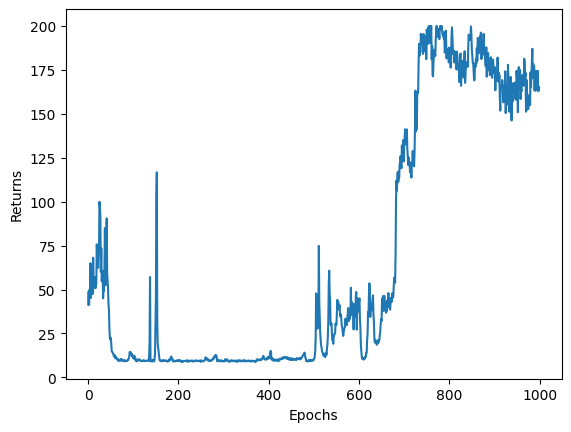

In [14]:
# Model
net = ts.utils.net.common.Net(
    env.observation_space.shape,
    env.action_space.n,
    hidden_sizes=[64, 64],
    device=device,
).to(device)

optim = torch.optim.Adam(net.parameters(), lr=0.001)

# Policy
policy = ts.policy.DQNPolicy(
    model=net, # value network
    optim=optim, # optimizer
    discount_factor=0.99, # gamma
    estimation_step=1, # n-step returns
    is_double=False, # double Q-learning
    target_update_freq=120, # how often to update the target network
    action_space=env.action_space, # action space
)
policy.set_eps(0.1) # epsilon-greedy action selection

# Collector for training
collector = ts.data.Collector(
    policy=policy,
    env=ts.env.DummyVectorEnv([lambda: gym.make('CartPole-v0') for _ in range(10)]),
    buffer=ts.data.VectorReplayBuffer(20000, 10),
    exploration_noise=True
)

# Collector for testing (without exploration). No need for a buffer
test_collector = ts.data.Collector(
    policy=policy,
    env=ts.env.DummyVectorEnv([lambda: gym.make('CartPole-v0') for _ in range(10)]),
    exploration_noise=False
)

# Pre-fill the training buffer with random transitions
collector.reset()
collector.collect(n_step=1000, random=True)

# Interaction
returns = []
for iteration in (pbar := tqdm.tqdm(range(1000))):

    # Training mode. Important!
    policy.train()
    policy.is_within_training_step = True

    # Collect transitions
    result = collector.collect(n_step=100)

    # Train DQN network on 10 minibatches
    policy.update(
        buffer=collector.buffer,
        sample_size=0, # use the whole buffer
        batch_size=64,
        repeat=10,
    )

    # Test 10 episodes
    policy.eval()
    test_collector.reset()
    result = test_collector.collect(n_episode=10)
    mean_reward = result.returns.mean()
    pbar.set_description(f"reward : {mean_reward}")
    returns.append(mean_reward)

plt.figure()
plt.plot(np.array(returns))
plt.xlabel("Epochs")
plt.ylabel("Returns")
plt.show()

Return: 147.0
MoviePy - Building file videos/cartpole-dqn.gif with imageio.


t:   0%|          | 0/148 [00:00<?, ?it/s, now=None]


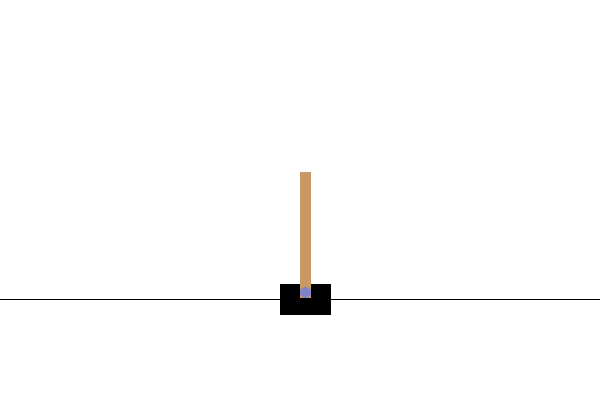

In [15]:
# Evaluation mode
policy.eval()

# Create a recordable environment
env = gym.make('CartPole-v0', render_mode="rgb_array_list")
recorder = GymRecorder(env)

# Sample the initial state
state, info = env.reset()

# One episode:
done = False
return_episode = 0
while not done:

    # Select an action from the learned policy
    action = policy.forward(ts.data.Batch(obs=[state], info=None)).act[0]

    # Sample a single transition
    next_state, reward, terminal, truncated, info = env.step(action)

    # End of the episode
    done = terminal or truncated

    # Update undiscounted return
    return_episode += reward

    # Go in the next state
    state = next_state

print("Return:", return_episode)

recorder.record(env.render())
video = "videos/cartpole-dqn.gif"
recorder.make_video(video)
ipython_display(video)

**Q:** Understand and run the code. Experiment with the hyperparameters and compare them to the previous exercise. In particular, what is `estimation_step=1` in the constructor of the DQN policy? What is its influence?

**Q:** Implement scheduling of the exploration parameter with the right hyperparameters.

Note: the goal is not to redo the last exercise on DQN, just to understand how the interaction loop in tianshou works.

**A:** The main difference is that much more data is collected by the 10 workers before the DQN is updated (10 times in a row instead of 1). Distributed learning can also be used in DQN-like algorithms ans speed up learning. Collecting 1000 transitions instead of 100 at each iteration is even better.

`estimation_step` allows to use n-step returns instead of the vanilla 1-step return r + gamma * V(s'). Choosing a value of `n=3` (and double Q-learning) stabilizes learning a lot.

There are many ways to implement exploration scheduling. Here is one that works OK.

  0%|          | 0/1000 [00:00<?, ?it/s]

reward : 9.4:   0%|          | 0/1000 [00:00<?, ?it/s]

reward : 9.4:   0%|          | 1/1000 [00:00<02:07,  7.83it/s]

reward : 9.5:   0%|          | 1/1000 [00:00<02:07,  7.83it/s]

reward : 9.5:   0%|          | 2/1000 [00:00<02:05,  7.95it/s]

reward : 9.7:   0%|          | 2/1000 [00:00<02:05,  7.95it/s]

reward : 9.7:   0%|          | 3/1000 [00:00<02:07,  7.82it/s]

reward : 9.0:   0%|          | 3/1000 [00:00<02:07,  7.82it/s]

reward : 9.0:   0%|          | 4/1000 [00:00<02:07,  7.80it/s]

reward : 9.8:   0%|          | 4/1000 [00:00<02:07,  7.80it/s]

reward : 9.8:   0%|          | 5/1000 [00:00<02:08,  7.72it/s]

reward : 9.4:   0%|          | 5/1000 [00:00<02:08,  7.72it/s]

reward : 9.4:   1%|          | 6/1000 [00:00<02:10,  7.61it/s]

reward : 9.2:   1%|          | 6/1000 [00:00<02:10,  7.61it/s]

reward : 9.2:   1%|          | 7/1000 [00:00<02:11,  7.54it/s]

reward : 9.0:   1%|          | 7/1000 [00:01<02:11,  7.54it/s]

reward : 9.0:   1%|          | 8/1000 [00:01<02:13,  7.43it/s]

reward : 9.4:   1%|          | 8/1000 [00:01<02:13,  7.43it/s]

reward : 9.4:   1%|          | 9/1000 [00:01<02:14,  7.35it/s]

reward : 9.3:   1%|          | 9/1000 [00:01<02:14,  7.35it/s]

reward : 9.3:   1%|          | 10/1000 [00:01<02:16,  7.24it/s]

reward : 9.4:   1%|          | 10/1000 [00:01<02:16,  7.24it/s]

reward : 9.4:   1%|          | 11/1000 [00:01<02:20,  7.06it/s]

reward : 9.1:   1%|          | 11/1000 [00:01<02:20,  7.06it/s]

reward : 9.1:   1%|          | 12/1000 [00:01<02:22,  6.95it/s]

reward : 9.2:   1%|          | 12/1000 [00:01<02:22,  6.95it/s]

reward : 9.2:   1%|▏         | 13/1000 [00:01<02:25,  6.80it/s]

reward : 9.5:   1%|▏         | 13/1000 [00:01<02:25,  6.80it/s]

reward : 9.5:   1%|▏         | 14/1000 [00:01<02:27,  6.70it/s]

reward : 9.5:   1%|▏         | 14/1000 [00:02<02:27,  6.70it/s]

reward : 9.5:   2%|▏         | 15/1000 [00:02<02:29,  6.58it/s]

reward : 9.6:   2%|▏         | 15/1000 [00:02<02:29,  6.58it/s]

reward : 9.6:   2%|▏         | 16/1000 [00:02<02:32,  6.47it/s]

reward : 9.8:   2%|▏         | 16/1000 [00:02<02:32,  6.47it/s]

reward : 9.8:   2%|▏         | 17/1000 [00:02<02:34,  6.35it/s]

reward : 9.6:   2%|▏         | 17/1000 [00:02<02:34,  6.35it/s]

reward : 9.6:   2%|▏         | 18/1000 [00:02<02:36,  6.26it/s]

reward : 9.6:   2%|▏         | 18/1000 [00:02<02:36,  6.26it/s]

reward : 9.6:   2%|▏         | 19/1000 [00:02<02:39,  6.15it/s]

reward : 9.6:   2%|▏         | 19/1000 [00:02<02:39,  6.15it/s]

reward : 9.6:   2%|▏         | 20/1000 [00:02<02:42,  6.04it/s]

reward : 9.5:   2%|▏         | 20/1000 [00:03<02:42,  6.04it/s]

reward : 9.5:   2%|▏         | 21/1000 [00:03<02:43,  6.00it/s]

reward : 9.0:   2%|▏         | 21/1000 [00:03<02:43,  6.00it/s]

reward : 9.0:   2%|▏         | 22/1000 [00:03<02:43,  6.00it/s]

reward : 9.4:   2%|▏         | 22/1000 [00:03<02:43,  6.00it/s]

reward : 9.4:   2%|▏         | 23/1000 [00:03<02:43,  5.99it/s]

reward : 9.4:   2%|▏         | 23/1000 [00:03<02:43,  5.99it/s]

reward : 9.4:   2%|▏         | 24/1000 [00:03<02:43,  5.96it/s]

reward : 9.1:   2%|▏         | 24/1000 [00:03<02:43,  5.96it/s]

reward : 9.1:   2%|▎         | 25/1000 [00:03<02:44,  5.93it/s]

reward : 9.2:   2%|▎         | 25/1000 [00:03<02:44,  5.93it/s]

reward : 9.2:   3%|▎         | 26/1000 [00:03<02:44,  5.93it/s]

reward : 9.5:   3%|▎         | 26/1000 [00:04<02:44,  5.93it/s]

reward : 9.5:   3%|▎         | 27/1000 [00:04<02:44,  5.91it/s]

reward : 9.3:   3%|▎         | 27/1000 [00:04<02:44,  5.91it/s]

reward : 9.3:   3%|▎         | 28/1000 [00:04<02:45,  5.89it/s]

reward : 9.6:   3%|▎         | 28/1000 [00:04<02:45,  5.89it/s]

reward : 9.6:   3%|▎         | 29/1000 [00:04<02:43,  5.92it/s]

reward : 9.4:   3%|▎         | 29/1000 [00:04<02:43,  5.92it/s]

reward : 9.4:   3%|▎         | 30/1000 [00:04<02:43,  5.94it/s]

reward : 9.8:   3%|▎         | 30/1000 [00:04<02:43,  5.94it/s]

reward : 9.8:   3%|▎         | 31/1000 [00:04<02:43,  5.92it/s]

reward : 8.8:   3%|▎         | 31/1000 [00:04<02:43,  5.92it/s]

reward : 8.8:   3%|▎         | 32/1000 [00:04<02:42,  5.95it/s]

reward : 9.2:   3%|▎         | 32/1000 [00:05<02:42,  5.95it/s]

reward : 9.2:   3%|▎         | 33/1000 [00:05<02:51,  5.64it/s]

reward : 9.3:   3%|▎         | 33/1000 [00:05<02:51,  5.64it/s]

reward : 9.3:   3%|▎         | 34/1000 [00:05<02:48,  5.75it/s]

reward : 9.4:   3%|▎         | 34/1000 [00:05<02:48,  5.75it/s]

reward : 9.4:   4%|▎         | 35/1000 [00:05<02:45,  5.82it/s]

reward : 9.1:   4%|▎         | 35/1000 [00:05<02:45,  5.82it/s]

reward : 9.1:   4%|▎         | 36/1000 [00:05<02:43,  5.88it/s]

reward : 9.6:   4%|▎         | 36/1000 [00:05<02:43,  5.88it/s]

reward : 9.6:   4%|▎         | 37/1000 [00:05<02:42,  5.91it/s]

reward : 9.3:   4%|▎         | 37/1000 [00:05<02:42,  5.91it/s]

reward : 9.3:   4%|▍         | 38/1000 [00:05<02:42,  5.92it/s]

reward : 9.2:   4%|▍         | 38/1000 [00:06<02:42,  5.92it/s]

reward : 9.2:   4%|▍         | 39/1000 [00:06<02:42,  5.93it/s]

reward : 9.4:   4%|▍         | 39/1000 [00:06<02:42,  5.93it/s]

reward : 9.4:   4%|▍         | 40/1000 [00:06<02:41,  5.96it/s]

reward : 9.5:   4%|▍         | 40/1000 [00:06<02:41,  5.96it/s]

reward : 9.5:   4%|▍         | 41/1000 [00:06<02:40,  5.97it/s]

reward : 9.2:   4%|▍         | 41/1000 [00:06<02:40,  5.97it/s]

reward : 9.2:   4%|▍         | 42/1000 [00:06<02:41,  5.94it/s]

reward : 9.2:   4%|▍         | 42/1000 [00:06<02:41,  5.94it/s]

reward : 9.2:   4%|▍         | 43/1000 [00:06<02:42,  5.91it/s]

reward : 9.5:   4%|▍         | 43/1000 [00:07<02:42,  5.91it/s]

reward : 9.5:   4%|▍         | 44/1000 [00:07<02:41,  5.91it/s]

reward : 9.6:   4%|▍         | 44/1000 [00:07<02:41,  5.91it/s]

reward : 9.6:   4%|▍         | 45/1000 [00:07<02:41,  5.92it/s]

reward : 9.5:   4%|▍         | 45/1000 [00:07<02:41,  5.92it/s]

reward : 9.5:   5%|▍         | 46/1000 [00:07<02:42,  5.87it/s]

reward : 9.7:   5%|▍         | 46/1000 [00:07<02:42,  5.87it/s]

reward : 9.7:   5%|▍         | 47/1000 [00:07<02:41,  5.89it/s]

reward : 10.3:   5%|▍         | 47/1000 [00:07<02:41,  5.89it/s]

reward : 10.3:   5%|▍         | 48/1000 [00:07<02:42,  5.84it/s]

reward : 10.0:   5%|▍         | 48/1000 [00:07<02:42,  5.84it/s]

reward : 10.0:   5%|▍         | 49/1000 [00:07<02:42,  5.86it/s]

reward : 10.6:   5%|▍         | 49/1000 [00:08<02:42,  5.86it/s]

reward : 10.6:   5%|▌         | 50/1000 [00:08<02:42,  5.85it/s]

reward : 10.6:   5%|▌         | 50/1000 [00:08<02:42,  5.85it/s]

reward : 10.6:   5%|▌         | 51/1000 [00:08<02:41,  5.87it/s]

reward : 11.4:   5%|▌         | 51/1000 [00:08<02:41,  5.87it/s]

reward : 11.4:   5%|▌         | 52/1000 [00:08<02:41,  5.87it/s]

reward : 13.2:   5%|▌         | 52/1000 [00:08<02:41,  5.87it/s]

reward : 13.2:   5%|▌         | 53/1000 [00:08<02:41,  5.86it/s]

reward : 12.5:   5%|▌         | 53/1000 [00:08<02:41,  5.86it/s]

reward : 12.5:   5%|▌         | 54/1000 [00:08<02:42,  5.84it/s]

reward : 12.7:   5%|▌         | 54/1000 [00:08<02:42,  5.84it/s]

reward : 12.7:   6%|▌         | 55/1000 [00:08<02:42,  5.83it/s]

reward : 12.2:   6%|▌         | 55/1000 [00:09<02:42,  5.83it/s]

reward : 12.2:   6%|▌         | 56/1000 [00:09<02:41,  5.83it/s]

reward : 12.7:   6%|▌         | 56/1000 [00:09<02:41,  5.83it/s]

reward : 12.7:   6%|▌         | 57/1000 [00:09<02:40,  5.87it/s]

reward : 14.3:   6%|▌         | 57/1000 [00:09<02:40,  5.87it/s]

reward : 14.3:   6%|▌         | 58/1000 [00:09<02:40,  5.87it/s]

reward : 12.7:   6%|▌         | 58/1000 [00:09<02:40,  5.87it/s]

reward : 12.7:   6%|▌         | 59/1000 [00:09<02:40,  5.88it/s]

reward : 14.0:   6%|▌         | 59/1000 [00:09<02:40,  5.88it/s]

reward : 14.0:   6%|▌         | 60/1000 [00:09<02:41,  5.80it/s]

reward : 14.7:   6%|▌         | 60/1000 [00:09<02:41,  5.80it/s]

reward : 14.7:   6%|▌         | 61/1000 [00:09<02:41,  5.80it/s]

reward : 13.8:   6%|▌         | 61/1000 [00:10<02:41,  5.80it/s]

reward : 13.8:   6%|▌         | 62/1000 [00:10<02:41,  5.79it/s]

reward : 14.1:   6%|▌         | 62/1000 [00:10<02:41,  5.79it/s]

reward : 14.1:   6%|▋         | 63/1000 [00:10<02:40,  5.83it/s]

reward : 13.8:   6%|▋         | 63/1000 [00:10<02:40,  5.83it/s]

reward : 13.8:   6%|▋         | 64/1000 [00:10<02:40,  5.82it/s]

reward : 13.3:   6%|▋         | 64/1000 [00:10<02:40,  5.82it/s]

reward : 13.3:   6%|▋         | 65/1000 [00:10<02:39,  5.85it/s]

reward : 13.6:   6%|▋         | 65/1000 [00:10<02:39,  5.85it/s]

reward : 13.6:   7%|▋         | 66/1000 [00:10<02:39,  5.86it/s]

reward : 13.2:   7%|▋         | 66/1000 [00:10<02:39,  5.86it/s]

reward : 13.2:   7%|▋         | 67/1000 [00:10<02:39,  5.86it/s]

reward : 13.9:   7%|▋         | 67/1000 [00:11<02:39,  5.86it/s]

reward : 13.9:   7%|▋         | 68/1000 [00:11<02:38,  5.87it/s]

reward : 12.4:   7%|▋         | 68/1000 [00:11<02:38,  5.87it/s]

reward : 12.4:   7%|▋         | 69/1000 [00:11<02:37,  5.90it/s]

reward : 13.5:   7%|▋         | 69/1000 [00:11<02:37,  5.90it/s]

reward : 13.5:   7%|▋         | 70/1000 [00:11<02:38,  5.85it/s]

reward : 13.5:   7%|▋         | 70/1000 [00:11<02:38,  5.85it/s]

reward : 13.5:   7%|▋         | 71/1000 [00:11<02:39,  5.82it/s]

reward : 12.7:   7%|▋         | 71/1000 [00:11<02:39,  5.82it/s]

reward : 12.7:   7%|▋         | 72/1000 [00:11<02:39,  5.83it/s]

reward : 14.0:   7%|▋         | 72/1000 [00:11<02:39,  5.83it/s]

reward : 14.0:   7%|▋         | 73/1000 [00:11<02:38,  5.83it/s]

reward : 13.6:   7%|▋         | 73/1000 [00:12<02:38,  5.83it/s]

reward : 13.6:   7%|▋         | 74/1000 [00:12<02:38,  5.85it/s]

reward : 14.3:   7%|▋         | 74/1000 [00:12<02:38,  5.85it/s]

reward : 14.3:   8%|▊         | 75/1000 [00:12<02:38,  5.85it/s]

reward : 14.6:   8%|▊         | 75/1000 [00:12<02:38,  5.85it/s]

reward : 14.6:   8%|▊         | 76/1000 [00:12<02:37,  5.85it/s]

reward : 14.5:   8%|▊         | 76/1000 [00:12<02:37,  5.85it/s]

reward : 14.5:   8%|▊         | 77/1000 [00:12<02:37,  5.85it/s]

reward : 13.2:   8%|▊         | 77/1000 [00:12<02:37,  5.85it/s]

reward : 13.2:   8%|▊         | 78/1000 [00:12<02:37,  5.84it/s]

reward : 13.1:   8%|▊         | 78/1000 [00:12<02:37,  5.84it/s]

reward : 13.1:   8%|▊         | 79/1000 [00:12<02:36,  5.88it/s]

reward : 15.4:   8%|▊         | 79/1000 [00:13<02:36,  5.88it/s]

reward : 15.4:   8%|▊         | 80/1000 [00:13<02:37,  5.86it/s]

reward : 14.6:   8%|▊         | 80/1000 [00:13<02:37,  5.86it/s]

reward : 14.6:   8%|▊         | 81/1000 [00:13<02:37,  5.85it/s]

reward : 14.6:   8%|▊         | 81/1000 [00:13<02:37,  5.85it/s]

reward : 14.6:   8%|▊         | 82/1000 [00:13<02:37,  5.84it/s]

reward : 15.4:   8%|▊         | 82/1000 [00:13<02:37,  5.84it/s]

reward : 15.4:   8%|▊         | 83/1000 [00:13<02:37,  5.83it/s]

reward : 16.0:   8%|▊         | 83/1000 [00:13<02:37,  5.83it/s]

reward : 16.0:   8%|▊         | 84/1000 [00:13<02:38,  5.80it/s]

reward : 15.4:   8%|▊         | 84/1000 [00:14<02:38,  5.80it/s]

reward : 15.4:   8%|▊         | 85/1000 [00:14<02:37,  5.80it/s]

reward : 14.4:   8%|▊         | 85/1000 [00:14<02:37,  5.80it/s]

reward : 14.4:   9%|▊         | 86/1000 [00:14<02:37,  5.81it/s]

reward : 15.0:   9%|▊         | 86/1000 [00:14<02:37,  5.81it/s]

reward : 15.0:   9%|▊         | 87/1000 [00:14<02:37,  5.81it/s]

reward : 14.5:   9%|▊         | 87/1000 [00:14<02:37,  5.81it/s]

reward : 14.5:   9%|▉         | 88/1000 [00:14<02:36,  5.82it/s]

reward : 14.6:   9%|▉         | 88/1000 [00:14<02:36,  5.82it/s]

reward : 14.6:   9%|▉         | 89/1000 [00:14<02:36,  5.84it/s]

reward : 14.0:   9%|▉         | 89/1000 [00:14<02:36,  5.84it/s]

reward : 14.0:   9%|▉         | 90/1000 [00:14<02:35,  5.83it/s]

reward : 12.2:   9%|▉         | 90/1000 [00:15<02:35,  5.83it/s]

reward : 12.2:   9%|▉         | 91/1000 [00:15<02:35,  5.86it/s]

reward : 12.3:   9%|▉         | 91/1000 [00:15<02:35,  5.86it/s]

reward : 12.3:   9%|▉         | 92/1000 [00:15<02:34,  5.87it/s]

reward : 14.0:   9%|▉         | 92/1000 [00:15<02:34,  5.87it/s]

reward : 14.0:   9%|▉         | 93/1000 [00:15<02:34,  5.87it/s]

reward : 11.9:   9%|▉         | 93/1000 [00:15<02:34,  5.87it/s]

reward : 11.9:   9%|▉         | 94/1000 [00:15<02:34,  5.86it/s]

reward : 12.2:   9%|▉         | 94/1000 [00:15<02:34,  5.86it/s]

reward : 12.2:  10%|▉         | 95/1000 [00:15<02:33,  5.88it/s]

reward : 11.4:  10%|▉         | 95/1000 [00:15<02:33,  5.88it/s]

reward : 11.4:  10%|▉         | 96/1000 [00:15<02:33,  5.89it/s]

reward : 11.9:  10%|▉         | 96/1000 [00:16<02:33,  5.89it/s]

reward : 11.9:  10%|▉         | 97/1000 [00:16<02:32,  5.90it/s]

reward : 13.0:  10%|▉         | 97/1000 [00:16<02:32,  5.90it/s]

reward : 13.0:  10%|▉         | 98/1000 [00:16<02:32,  5.91it/s]

reward : 12.1:  10%|▉         | 98/1000 [00:16<02:32,  5.91it/s]

reward : 12.1:  10%|▉         | 99/1000 [00:16<02:32,  5.92it/s]

reward : 11.9:  10%|▉         | 99/1000 [00:16<02:32,  5.92it/s]

reward : 11.9:  10%|█         | 100/1000 [00:16<02:31,  5.93it/s]

reward : 12.9:  10%|█         | 100/1000 [00:16<02:31,  5.93it/s]

reward : 12.9:  10%|█         | 101/1000 [00:16<02:33,  5.85it/s]

reward : 13.5:  10%|█         | 101/1000 [00:16<02:33,  5.85it/s]

reward : 13.5:  10%|█         | 102/1000 [00:16<02:33,  5.86it/s]

reward : 13.9:  10%|█         | 102/1000 [00:17<02:33,  5.86it/s]

reward : 13.9:  10%|█         | 103/1000 [00:17<02:34,  5.81it/s]

reward : 14.6:  10%|█         | 103/1000 [00:17<02:34,  5.81it/s]

reward : 14.6:  10%|█         | 104/1000 [00:17<02:34,  5.81it/s]

reward : 16.2:  10%|█         | 104/1000 [00:17<02:34,  5.81it/s]

reward : 16.2:  10%|█         | 105/1000 [00:17<02:34,  5.78it/s]

reward : 15.5:  10%|█         | 105/1000 [00:17<02:34,  5.78it/s]

reward : 15.5:  11%|█         | 106/1000 [00:17<02:35,  5.77it/s]

reward : 15.4:  11%|█         | 106/1000 [00:17<02:35,  5.77it/s]

reward : 15.4:  11%|█         | 107/1000 [00:17<02:35,  5.75it/s]

reward : 15.6:  11%|█         | 107/1000 [00:17<02:35,  5.75it/s]

reward : 15.6:  11%|█         | 108/1000 [00:17<02:35,  5.74it/s]

reward : 14.9:  11%|█         | 108/1000 [00:18<02:35,  5.74it/s]

reward : 14.9:  11%|█         | 109/1000 [00:18<02:34,  5.75it/s]

reward : 17.6:  11%|█         | 109/1000 [00:18<02:34,  5.75it/s]

reward : 17.6:  11%|█         | 110/1000 [00:18<02:34,  5.74it/s]

reward : 21.2:  11%|█         | 110/1000 [00:18<02:34,  5.74it/s]

reward : 21.2:  11%|█         | 111/1000 [00:18<02:35,  5.71it/s]

reward : 18.8:  11%|█         | 111/1000 [00:18<02:35,  5.71it/s]

reward : 18.8:  11%|█         | 112/1000 [00:18<02:34,  5.73it/s]

reward : 20.7:  11%|█         | 112/1000 [00:18<02:34,  5.73it/s]

reward : 20.7:  11%|█▏        | 113/1000 [00:18<02:34,  5.73it/s]

reward : 23.0:  11%|█▏        | 113/1000 [00:19<02:34,  5.73it/s]

reward : 23.0:  11%|█▏        | 114/1000 [00:19<02:35,  5.68it/s]

reward : 27.8:  11%|█▏        | 114/1000 [00:19<02:35,  5.68it/s]

reward : 27.8:  12%|█▏        | 115/1000 [00:19<02:37,  5.61it/s]

reward : 39.5:  12%|█▏        | 115/1000 [00:19<02:37,  5.61it/s]

reward : 39.5:  12%|█▏        | 116/1000 [00:19<02:43,  5.40it/s]

reward : 53.1:  12%|█▏        | 116/1000 [00:19<02:43,  5.40it/s]

reward : 53.1:  12%|█▏        | 117/1000 [00:19<02:53,  5.10it/s]

reward : 35.9:  12%|█▏        | 117/1000 [00:19<02:53,  5.10it/s]

reward : 35.9:  12%|█▏        | 118/1000 [00:19<02:52,  5.11it/s]

reward : 52.4:  12%|█▏        | 118/1000 [00:20<02:52,  5.11it/s]

reward : 52.4:  12%|█▏        | 119/1000 [00:20<02:57,  4.97it/s]

reward : 46.4:  12%|█▏        | 119/1000 [00:20<02:57,  4.97it/s]

reward : 46.4:  12%|█▏        | 120/1000 [00:20<02:56,  4.98it/s]

reward : 76.7:  12%|█▏        | 120/1000 [00:20<02:56,  4.98it/s]

reward : 76.7:  12%|█▏        | 121/1000 [00:20<03:06,  4.71it/s]

reward : 48.5:  12%|█▏        | 121/1000 [00:20<03:06,  4.71it/s]

reward : 48.5:  12%|█▏        | 122/1000 [00:20<03:02,  4.81it/s]

reward : 42.7:  12%|█▏        | 122/1000 [00:20<03:02,  4.81it/s]

reward : 42.7:  12%|█▏        | 123/1000 [00:20<03:02,  4.82it/s]

reward : 41.3:  12%|█▏        | 123/1000 [00:21<03:02,  4.82it/s]

reward : 41.3:  12%|█▏        | 124/1000 [00:21<03:03,  4.78it/s]

reward : 41.8:  12%|█▏        | 124/1000 [00:21<03:03,  4.78it/s]

reward : 41.8:  12%|█▎        | 125/1000 [00:21<03:03,  4.78it/s]

reward : 51.8:  12%|█▎        | 125/1000 [00:21<03:03,  4.78it/s]

reward : 51.8:  13%|█▎        | 126/1000 [00:21<03:02,  4.80it/s]

reward : 39.6:  13%|█▎        | 126/1000 [00:21<03:02,  4.80it/s]

reward : 39.6:  13%|█▎        | 127/1000 [00:21<02:58,  4.90it/s]

reward : 33.4:  13%|█▎        | 127/1000 [00:21<02:58,  4.90it/s]

reward : 33.4:  13%|█▎        | 128/1000 [00:21<02:53,  5.03it/s]

reward : 26.6:  13%|█▎        | 128/1000 [00:22<02:53,  5.03it/s]

reward : 26.6:  13%|█▎        | 129/1000 [00:22<02:48,  5.18it/s]

reward : 28.9:  13%|█▎        | 129/1000 [00:22<02:48,  5.18it/s]

reward : 28.9:  13%|█▎        | 130/1000 [00:22<02:44,  5.29it/s]

reward : 24.3:  13%|█▎        | 130/1000 [00:22<02:44,  5.29it/s]

reward : 24.3:  13%|█▎        | 131/1000 [00:22<02:41,  5.39it/s]

reward : 24.1:  13%|█▎        | 131/1000 [00:22<02:41,  5.39it/s]

reward : 24.1:  13%|█▎        | 132/1000 [00:22<02:38,  5.47it/s]

reward : 22.3:  13%|█▎        | 132/1000 [00:22<02:38,  5.47it/s]

reward : 22.3:  13%|█▎        | 133/1000 [00:22<02:36,  5.52it/s]

reward : 22.6:  13%|█▎        | 133/1000 [00:22<02:36,  5.52it/s]

reward : 22.6:  13%|█▎        | 134/1000 [00:22<02:36,  5.55it/s]

reward : 20.7:  13%|█▎        | 134/1000 [00:23<02:36,  5.55it/s]

reward : 20.7:  14%|█▎        | 135/1000 [00:23<02:34,  5.60it/s]

reward : 23.6:  14%|█▎        | 135/1000 [00:23<02:34,  5.60it/s]

reward : 23.6:  14%|█▎        | 136/1000 [00:23<02:33,  5.63it/s]

reward : 24.8:  14%|█▎        | 136/1000 [00:23<02:33,  5.63it/s]

reward : 24.8:  14%|█▎        | 137/1000 [00:23<02:33,  5.63it/s]

reward : 26.9:  14%|█▎        | 137/1000 [00:23<02:33,  5.63it/s]

reward : 26.9:  14%|█▍        | 138/1000 [00:23<02:33,  5.62it/s]

reward : 34.4:  14%|█▍        | 138/1000 [00:23<02:33,  5.62it/s]

reward : 34.4:  14%|█▍        | 139/1000 [00:23<02:35,  5.53it/s]

reward : 48.3:  14%|█▍        | 139/1000 [00:24<02:35,  5.53it/s]

reward : 48.3:  14%|█▍        | 140/1000 [00:24<02:42,  5.30it/s]

reward : 48.1:  14%|█▍        | 140/1000 [00:24<02:42,  5.30it/s]

reward : 48.1:  14%|█▍        | 141/1000 [00:24<02:49,  5.08it/s]

reward : 55.6:  14%|█▍        | 141/1000 [00:24<02:49,  5.08it/s]

reward : 55.6:  14%|█▍        | 142/1000 [00:24<02:55,  4.89it/s]

reward : 41.9:  14%|█▍        | 142/1000 [00:24<02:55,  4.89it/s]

reward : 41.9:  14%|█▍        | 143/1000 [00:24<02:52,  4.98it/s]

reward : 37.2:  14%|█▍        | 143/1000 [00:24<02:52,  4.98it/s]

reward : 37.2:  14%|█▍        | 144/1000 [00:24<02:49,  5.05it/s]

reward : 40.1:  14%|█▍        | 144/1000 [00:25<02:49,  5.05it/s]

reward : 40.1:  14%|█▍        | 145/1000 [00:25<02:54,  4.90it/s]

reward : 30.2:  14%|█▍        | 145/1000 [00:25<02:54,  4.90it/s]

reward : 30.2:  15%|█▍        | 146/1000 [00:25<02:49,  5.05it/s]

reward : 21.2:  15%|█▍        | 146/1000 [00:25<02:49,  5.05it/s]

reward : 21.2:  15%|█▍        | 147/1000 [00:25<02:42,  5.24it/s]

reward : 21.8:  15%|█▍        | 147/1000 [00:25<02:42,  5.24it/s]

reward : 21.8:  15%|█▍        | 148/1000 [00:25<02:39,  5.35it/s]

reward : 21.5:  15%|█▍        | 148/1000 [00:25<02:39,  5.35it/s]

reward : 21.5:  15%|█▍        | 149/1000 [00:25<02:36,  5.45it/s]

reward : 16.7:  15%|█▍        | 149/1000 [00:25<02:36,  5.45it/s]

reward : 16.7:  15%|█▌        | 150/1000 [00:25<02:33,  5.52it/s]

reward : 14.9:  15%|█▌        | 150/1000 [00:26<02:33,  5.52it/s]

reward : 14.9:  15%|█▌        | 151/1000 [00:26<02:31,  5.61it/s]

reward : 15.7:  15%|█▌        | 151/1000 [00:26<02:31,  5.61it/s]

reward : 15.7:  15%|█▌        | 152/1000 [00:26<02:29,  5.69it/s]

reward : 15.5:  15%|█▌        | 152/1000 [00:26<02:29,  5.69it/s]

reward : 15.5:  15%|█▌        | 153/1000 [00:26<02:27,  5.73it/s]

reward : 12.7:  15%|█▌        | 153/1000 [00:26<02:27,  5.73it/s]

reward : 12.7:  15%|█▌        | 154/1000 [00:26<02:27,  5.74it/s]

reward : 12.6:  15%|█▌        | 154/1000 [00:26<02:27,  5.74it/s]

reward : 12.6:  16%|█▌        | 155/1000 [00:26<02:25,  5.80it/s]

reward : 12.3:  16%|█▌        | 155/1000 [00:27<02:25,  5.80it/s]

reward : 12.3:  16%|█▌        | 156/1000 [00:27<02:25,  5.81it/s]

reward : 12.4:  16%|█▌        | 156/1000 [00:27<02:25,  5.81it/s]

reward : 12.4:  16%|█▌        | 157/1000 [00:27<02:24,  5.84it/s]

reward : 12.3:  16%|█▌        | 157/1000 [00:27<02:24,  5.84it/s]

reward : 12.3:  16%|█▌        | 158/1000 [00:27<02:23,  5.88it/s]

reward : 10.8:  16%|█▌        | 158/1000 [00:27<02:23,  5.88it/s]

reward : 10.8:  16%|█▌        | 159/1000 [00:27<02:23,  5.86it/s]

reward : 11.6:  16%|█▌        | 159/1000 [00:27<02:23,  5.86it/s]

reward : 11.6:  16%|█▌        | 160/1000 [00:27<02:22,  5.87it/s]

reward : 10.9:  16%|█▌        | 160/1000 [00:27<02:22,  5.87it/s]

reward : 10.9:  16%|█▌        | 161/1000 [00:27<02:22,  5.90it/s]

reward : 10.6:  16%|█▌        | 161/1000 [00:28<02:22,  5.90it/s]

reward : 10.6:  16%|█▌        | 162/1000 [00:28<02:21,  5.93it/s]

reward : 10.9:  16%|█▌        | 162/1000 [00:28<02:21,  5.93it/s]

reward : 10.9:  16%|█▋        | 163/1000 [00:28<02:20,  5.94it/s]

reward : 11.5:  16%|█▋        | 163/1000 [00:28<02:20,  5.94it/s]

reward : 11.5:  16%|█▋        | 164/1000 [00:28<02:20,  5.95it/s]

reward : 10.6:  16%|█▋        | 164/1000 [00:28<02:20,  5.95it/s]

reward : 10.6:  16%|█▋        | 165/1000 [00:28<02:20,  5.94it/s]

reward : 10.6:  16%|█▋        | 165/1000 [00:28<02:20,  5.94it/s]

reward : 10.6:  17%|█▋        | 166/1000 [00:28<02:20,  5.95it/s]

reward : 11.1:  17%|█▋        | 166/1000 [00:28<02:20,  5.95it/s]

reward : 11.1:  17%|█▋        | 167/1000 [00:28<02:20,  5.94it/s]

reward : 10.7:  17%|█▋        | 167/1000 [00:29<02:20,  5.94it/s]

reward : 10.7:  17%|█▋        | 168/1000 [00:29<02:19,  5.95it/s]

reward : 11.4:  17%|█▋        | 168/1000 [00:29<02:19,  5.95it/s]

reward : 11.4:  17%|█▋        | 169/1000 [00:29<02:19,  5.97it/s]

reward : 12.5:  17%|█▋        | 169/1000 [00:29<02:19,  5.97it/s]

reward : 12.5:  17%|█▋        | 170/1000 [00:29<02:19,  5.94it/s]

reward : 10.6:  17%|█▋        | 170/1000 [00:29<02:19,  5.94it/s]

reward : 10.6:  17%|█▋        | 171/1000 [00:29<02:19,  5.96it/s]

reward : 11.0:  17%|█▋        | 171/1000 [00:29<02:19,  5.96it/s]

reward : 11.0:  17%|█▋        | 172/1000 [00:29<02:18,  5.96it/s]

reward : 12.5:  17%|█▋        | 172/1000 [00:29<02:18,  5.96it/s]

reward : 12.5:  17%|█▋        | 173/1000 [00:29<02:18,  5.95it/s]

reward : 11.8:  17%|█▋        | 173/1000 [00:30<02:18,  5.95it/s]

reward : 11.8:  17%|█▋        | 174/1000 [00:30<02:19,  5.93it/s]

reward : 12.2:  17%|█▋        | 174/1000 [00:30<02:19,  5.93it/s]

reward : 12.2:  18%|█▊        | 175/1000 [00:30<02:18,  5.95it/s]

reward : 13.4:  18%|█▊        | 175/1000 [00:30<02:18,  5.95it/s]

reward : 13.4:  18%|█▊        | 176/1000 [00:30<02:18,  5.95it/s]

reward : 14.9:  18%|█▊        | 176/1000 [00:30<02:18,  5.95it/s]

reward : 14.9:  18%|█▊        | 177/1000 [00:30<02:19,  5.92it/s]

reward : 14.0:  18%|█▊        | 177/1000 [00:30<02:19,  5.92it/s]

reward : 14.0:  18%|█▊        | 178/1000 [00:30<02:19,  5.90it/s]

reward : 14.9:  18%|█▊        | 178/1000 [00:30<02:19,  5.90it/s]

reward : 14.9:  18%|█▊        | 179/1000 [00:30<02:19,  5.90it/s]

reward : 15.5:  18%|█▊        | 179/1000 [00:31<02:19,  5.90it/s]

reward : 15.5:  18%|█▊        | 180/1000 [00:31<02:19,  5.88it/s]

reward : 16.4:  18%|█▊        | 180/1000 [00:31<02:19,  5.88it/s]

reward : 16.4:  18%|█▊        | 181/1000 [00:31<02:19,  5.88it/s]

reward : 20.2:  18%|█▊        | 181/1000 [00:31<02:19,  5.88it/s]

reward : 20.2:  18%|█▊        | 182/1000 [00:31<02:21,  5.79it/s]

reward : 23.3:  18%|█▊        | 182/1000 [00:31<02:21,  5.79it/s]

reward : 23.3:  18%|█▊        | 183/1000 [00:31<02:22,  5.75it/s]

reward : 23.7:  18%|█▊        | 183/1000 [00:31<02:22,  5.75it/s]

reward : 23.7:  18%|█▊        | 184/1000 [00:31<02:23,  5.67it/s]

reward : 43.2:  18%|█▊        | 184/1000 [00:31<02:23,  5.67it/s]

reward : 43.2:  18%|█▊        | 185/1000 [00:31<02:28,  5.48it/s]

reward : 44.9:  18%|█▊        | 185/1000 [00:32<02:28,  5.48it/s]

reward : 44.9:  19%|█▊        | 186/1000 [00:32<02:35,  5.23it/s]

reward : 56.3:  19%|█▊        | 186/1000 [00:32<02:35,  5.23it/s]

reward : 56.3:  19%|█▊        | 187/1000 [00:32<02:40,  5.06it/s]

reward : 63.6:  19%|█▊        | 187/1000 [00:32<02:40,  5.06it/s]

reward : 63.6:  19%|█▉        | 188/1000 [00:32<02:50,  4.77it/s]

reward : 44.5:  19%|█▉        | 188/1000 [00:32<02:50,  4.77it/s]

reward : 44.5:  19%|█▉        | 189/1000 [00:32<02:49,  4.80it/s]

reward : 38.0:  19%|█▉        | 189/1000 [00:33<02:49,  4.80it/s]

reward : 38.0:  19%|█▉        | 190/1000 [00:33<02:43,  4.95it/s]

reward : 29.1:  19%|█▉        | 190/1000 [00:33<02:43,  4.95it/s]

reward : 29.1:  19%|█▉        | 191/1000 [00:33<02:37,  5.12it/s]

reward : 24.1:  19%|█▉        | 191/1000 [00:33<02:37,  5.12it/s]

reward : 24.1:  19%|█▉        | 192/1000 [00:33<02:34,  5.24it/s]

reward : 22.7:  19%|█▉        | 192/1000 [00:33<02:34,  5.24it/s]

reward : 22.7:  19%|█▉        | 193/1000 [00:33<02:30,  5.37it/s]

reward : 22.4:  19%|█▉        | 193/1000 [00:33<02:30,  5.37it/s]

reward : 22.4:  19%|█▉        | 194/1000 [00:33<02:27,  5.46it/s]

reward : 20.1:  19%|█▉        | 194/1000 [00:33<02:27,  5.46it/s]

reward : 20.1:  20%|█▉        | 195/1000 [00:33<02:24,  5.56it/s]

reward : 18.7:  20%|█▉        | 195/1000 [00:34<02:24,  5.56it/s]

reward : 18.7:  20%|█▉        | 196/1000 [00:34<02:22,  5.64it/s]

reward : 17.3:  20%|█▉        | 196/1000 [00:34<02:22,  5.64it/s]

reward : 17.3:  20%|█▉        | 197/1000 [00:34<02:21,  5.67it/s]

reward : 16.0:  20%|█▉        | 197/1000 [00:34<02:21,  5.67it/s]

reward : 16.0:  20%|█▉        | 198/1000 [00:34<02:21,  5.68it/s]

reward : 16.2:  20%|█▉        | 198/1000 [00:34<02:21,  5.68it/s]

reward : 16.2:  20%|█▉        | 199/1000 [00:34<02:20,  5.70it/s]

reward : 16.5:  20%|█▉        | 199/1000 [00:34<02:20,  5.70it/s]

reward : 16.5:  20%|██        | 200/1000 [00:34<02:19,  5.74it/s]

reward : 16.8:  20%|██        | 200/1000 [00:34<02:19,  5.74it/s]

reward : 16.8:  20%|██        | 201/1000 [00:34<02:18,  5.75it/s]

reward : 17.2:  20%|██        | 201/1000 [00:35<02:18,  5.75it/s]

reward : 17.2:  20%|██        | 202/1000 [00:35<02:18,  5.77it/s]

reward : 17.9:  20%|██        | 202/1000 [00:35<02:18,  5.77it/s]

reward : 17.9:  20%|██        | 203/1000 [00:35<02:17,  5.78it/s]

reward : 21.9:  20%|██        | 203/1000 [00:35<02:17,  5.78it/s]

reward : 21.9:  20%|██        | 204/1000 [00:35<02:18,  5.74it/s]

reward : 22.5:  20%|██        | 204/1000 [00:35<02:18,  5.74it/s]

reward : 22.5:  20%|██        | 205/1000 [00:35<02:18,  5.73it/s]

reward : 24.6:  20%|██        | 205/1000 [00:35<02:18,  5.73it/s]

reward : 24.6:  21%|██        | 206/1000 [00:35<02:19,  5.71it/s]

reward : 31.5:  21%|██        | 206/1000 [00:35<02:19,  5.71it/s]

reward : 31.5:  21%|██        | 207/1000 [00:35<02:20,  5.63it/s]

reward : 41.0:  21%|██        | 207/1000 [00:36<02:20,  5.63it/s]

reward : 41.0:  21%|██        | 208/1000 [00:36<02:25,  5.45it/s]

reward : 50.9:  21%|██        | 208/1000 [00:36<02:25,  5.45it/s]

reward : 50.9:  21%|██        | 209/1000 [00:36<02:32,  5.18it/s]

reward : 58.6:  21%|██        | 209/1000 [00:36<02:32,  5.18it/s]

reward : 58.6:  21%|██        | 210/1000 [00:36<02:37,  5.00it/s]

reward : 57.5:  21%|██        | 210/1000 [00:36<02:37,  5.00it/s]

reward : 57.5:  21%|██        | 211/1000 [00:36<02:40,  4.91it/s]

reward : 50.8:  21%|██        | 211/1000 [00:37<02:40,  4.91it/s]

reward : 50.8:  21%|██        | 212/1000 [00:37<02:45,  4.77it/s]

reward : 41.9:  21%|██        | 212/1000 [00:37<02:45,  4.77it/s]

reward : 41.9:  21%|██▏       | 213/1000 [00:37<02:42,  4.86it/s]

reward : 37.2:  21%|██▏       | 213/1000 [00:37<02:42,  4.86it/s]

reward : 37.2:  21%|██▏       | 214/1000 [00:37<02:38,  4.97it/s]

reward : 31.4:  21%|██▏       | 214/1000 [00:37<02:38,  4.97it/s]

reward : 31.4:  22%|██▏       | 215/1000 [00:37<02:34,  5.09it/s]

reward : 24.4:  22%|██▏       | 215/1000 [00:37<02:34,  5.09it/s]

reward : 24.4:  22%|██▏       | 216/1000 [00:37<02:29,  5.25it/s]

reward : 22.6:  22%|██▏       | 216/1000 [00:37<02:29,  5.25it/s]

reward : 22.6:  22%|██▏       | 217/1000 [00:37<02:25,  5.39it/s]

reward : 22.2:  22%|██▏       | 217/1000 [00:38<02:25,  5.39it/s]

reward : 22.2:  22%|██▏       | 218/1000 [00:38<02:23,  5.46it/s]

reward : 24.0:  22%|██▏       | 218/1000 [00:38<02:23,  5.46it/s]

reward : 24.0:  22%|██▏       | 219/1000 [00:38<02:21,  5.52it/s]

reward : 22.0:  22%|██▏       | 219/1000 [00:38<02:21,  5.52it/s]

reward : 22.0:  22%|██▏       | 220/1000 [00:38<02:20,  5.56it/s]

reward : 23.1:  22%|██▏       | 220/1000 [00:38<02:20,  5.56it/s]

reward : 23.1:  22%|██▏       | 221/1000 [00:38<02:20,  5.56it/s]

reward : 21.6:  22%|██▏       | 221/1000 [00:38<02:20,  5.56it/s]

reward : 21.6:  22%|██▏       | 222/1000 [00:38<02:20,  5.55it/s]

reward : 22.0:  22%|██▏       | 222/1000 [00:39<02:20,  5.55it/s]

reward : 22.0:  22%|██▏       | 223/1000 [00:39<02:20,  5.55it/s]

reward : 26.4:  22%|██▏       | 223/1000 [00:39<02:20,  5.55it/s]

reward : 26.4:  22%|██▏       | 224/1000 [00:39<02:20,  5.53it/s]

reward : 24.4:  22%|██▏       | 224/1000 [00:39<02:20,  5.53it/s]

reward : 24.4:  22%|██▎       | 225/1000 [00:39<02:20,  5.52it/s]

reward : 23.7:  22%|██▎       | 225/1000 [00:39<02:20,  5.52it/s]

reward : 23.7:  23%|██▎       | 226/1000 [00:39<02:19,  5.55it/s]

reward : 27.1:  23%|██▎       | 226/1000 [00:39<02:19,  5.55it/s]

reward : 27.1:  23%|██▎       | 227/1000 [00:39<02:20,  5.49it/s]

reward : 29.8:  23%|██▎       | 227/1000 [00:39<02:20,  5.49it/s]

reward : 29.8:  23%|██▎       | 228/1000 [00:39<02:22,  5.42it/s]

reward : 39.8:  23%|██▎       | 228/1000 [00:40<02:22,  5.42it/s]

reward : 39.8:  23%|██▎       | 229/1000 [00:40<02:25,  5.29it/s]

reward : 43.7:  23%|██▎       | 229/1000 [00:40<02:25,  5.29it/s]

reward : 43.7:  23%|██▎       | 230/1000 [00:40<02:30,  5.13it/s]

reward : 51.1:  23%|██▎       | 230/1000 [00:40<02:30,  5.13it/s]

reward : 51.1:  23%|██▎       | 231/1000 [00:40<02:35,  4.95it/s]

reward : 63.0:  23%|██▎       | 231/1000 [00:40<02:35,  4.95it/s]

reward : 63.0:  23%|██▎       | 232/1000 [00:40<02:43,  4.69it/s]

reward : 60.9:  23%|██▎       | 232/1000 [00:41<02:43,  4.69it/s]

reward : 60.9:  23%|██▎       | 233/1000 [00:41<02:51,  4.48it/s]

reward : 76.0:  23%|██▎       | 233/1000 [00:41<02:51,  4.48it/s]

reward : 76.0:  23%|██▎       | 234/1000 [00:41<02:54,  4.39it/s]

reward : 93.5:  23%|██▎       | 234/1000 [00:41<02:54,  4.39it/s]

reward : 93.5:  24%|██▎       | 235/1000 [00:41<02:58,  4.28it/s]

reward : 72.9:  24%|██▎       | 235/1000 [00:41<02:58,  4.28it/s]

reward : 72.9:  24%|██▎       | 236/1000 [00:41<03:02,  4.18it/s]

reward : 79.5:  24%|██▎       | 236/1000 [00:42<03:02,  4.18it/s]

reward : 79.5:  24%|██▎       | 237/1000 [00:42<03:09,  4.04it/s]

reward : 64.9:  24%|██▎       | 237/1000 [00:42<03:09,  4.04it/s]

reward : 64.9:  24%|██▍       | 238/1000 [00:42<03:06,  4.09it/s]

reward : 55.5:  24%|██▍       | 238/1000 [00:42<03:06,  4.09it/s]

reward : 55.5:  24%|██▍       | 239/1000 [00:42<02:58,  4.25it/s]

reward : 60.7:  24%|██▍       | 239/1000 [00:42<02:58,  4.25it/s]

reward : 60.7:  24%|██▍       | 240/1000 [00:42<02:54,  4.35it/s]

reward : 60.2:  24%|██▍       | 240/1000 [00:42<02:54,  4.35it/s]

reward : 60.2:  24%|██▍       | 241/1000 [00:42<02:51,  4.44it/s]

reward : 44.7:  24%|██▍       | 241/1000 [00:43<02:51,  4.44it/s]

reward : 44.7:  24%|██▍       | 242/1000 [00:43<02:45,  4.57it/s]

reward : 44.6:  24%|██▍       | 242/1000 [00:43<02:45,  4.57it/s]

reward : 44.6:  24%|██▍       | 243/1000 [00:43<02:42,  4.66it/s]

reward : 47.1:  24%|██▍       | 243/1000 [00:43<02:42,  4.66it/s]

reward : 47.1:  24%|██▍       | 244/1000 [00:43<02:40,  4.71it/s]

reward : 47.0:  24%|██▍       | 244/1000 [00:43<02:40,  4.71it/s]

reward : 47.0:  24%|██▍       | 245/1000 [00:43<02:39,  4.73it/s]

reward : 44.5:  24%|██▍       | 245/1000 [00:44<02:39,  4.73it/s]

reward : 44.5:  25%|██▍       | 246/1000 [00:44<02:38,  4.75it/s]

reward : 37.1:  25%|██▍       | 246/1000 [00:44<02:38,  4.75it/s]

reward : 37.1:  25%|██▍       | 247/1000 [00:44<02:35,  4.84it/s]

reward : 48.3:  25%|██▍       | 247/1000 [00:44<02:35,  4.84it/s]

reward : 48.3:  25%|██▍       | 248/1000 [00:44<02:36,  4.80it/s]

reward : 50.3:  25%|██▍       | 248/1000 [00:44<02:36,  4.80it/s]

reward : 50.3:  25%|██▍       | 249/1000 [00:44<02:39,  4.70it/s]

reward : 43.9:  25%|██▍       | 249/1000 [00:44<02:39,  4.70it/s]

reward : 43.9:  25%|██▌       | 250/1000 [00:44<02:36,  4.80it/s]

reward : 45.0:  25%|██▌       | 250/1000 [00:45<02:36,  4.80it/s]

reward : 45.0:  25%|██▌       | 251/1000 [00:45<02:36,  4.80it/s]

reward : 48.4:  25%|██▌       | 251/1000 [00:45<02:36,  4.80it/s]

reward : 48.4:  25%|██▌       | 252/1000 [00:45<02:35,  4.82it/s]

reward : 62.7:  25%|██▌       | 252/1000 [00:45<02:35,  4.82it/s]

reward : 62.7:  25%|██▌       | 253/1000 [00:45<02:41,  4.61it/s]

reward : 84.2:  25%|██▌       | 253/1000 [00:45<02:41,  4.61it/s]

reward : 84.2:  25%|██▌       | 254/1000 [00:45<02:50,  4.38it/s]

reward : 74.0:  25%|██▌       | 254/1000 [00:45<02:50,  4.38it/s]

reward : 74.0:  26%|██▌       | 255/1000 [00:45<02:54,  4.26it/s]

reward : 58.8:  26%|██▌       | 255/1000 [00:46<02:54,  4.26it/s]

reward : 58.8:  26%|██▌       | 256/1000 [00:46<02:56,  4.22it/s]

reward : 66.1:  26%|██▌       | 256/1000 [00:46<02:56,  4.22it/s]

reward : 66.1:  26%|██▌       | 257/1000 [00:46<02:54,  4.25it/s]

reward : 40.8:  26%|██▌       | 257/1000 [00:46<02:54,  4.25it/s]

reward : 40.8:  26%|██▌       | 258/1000 [00:46<02:46,  4.46it/s]

reward : 33.4:  26%|██▌       | 258/1000 [00:46<02:46,  4.46it/s]

reward : 33.4:  26%|██▌       | 259/1000 [00:46<02:37,  4.70it/s]

reward : 26.3:  26%|██▌       | 259/1000 [00:47<02:37,  4.70it/s]

reward : 26.3:  26%|██▌       | 260/1000 [00:47<02:29,  4.94it/s]

reward : 26.1:  26%|██▌       | 260/1000 [00:47<02:29,  4.94it/s]

reward : 26.1:  26%|██▌       | 261/1000 [00:47<02:24,  5.11it/s]

reward : 25.0:  26%|██▌       | 261/1000 [00:47<02:24,  5.11it/s]

reward : 25.0:  26%|██▌       | 262/1000 [00:47<02:20,  5.24it/s]

reward : 22.3:  26%|██▌       | 262/1000 [00:47<02:20,  5.24it/s]

reward : 22.3:  26%|██▋       | 263/1000 [00:47<02:18,  5.32it/s]

reward : 20.0:  26%|██▋       | 263/1000 [00:47<02:18,  5.32it/s]

reward : 20.0:  26%|██▋       | 264/1000 [00:47<02:16,  5.40it/s]

reward : 18.3:  26%|██▋       | 264/1000 [00:47<02:16,  5.40it/s]

reward : 18.3:  26%|██▋       | 265/1000 [00:47<02:13,  5.49it/s]

reward : 18.0:  26%|██▋       | 265/1000 [00:48<02:13,  5.49it/s]

reward : 18.0:  27%|██▋       | 266/1000 [00:48<02:12,  5.52it/s]

reward : 18.4:  27%|██▋       | 266/1000 [00:48<02:12,  5.52it/s]

reward : 18.4:  27%|██▋       | 267/1000 [00:48<02:12,  5.54it/s]

reward : 18.5:  27%|██▋       | 267/1000 [00:48<02:12,  5.54it/s]

reward : 18.5:  27%|██▋       | 268/1000 [00:48<02:10,  5.60it/s]

reward : 16.6:  27%|██▋       | 268/1000 [00:48<02:10,  5.60it/s]

reward : 16.6:  27%|██▋       | 269/1000 [00:48<02:09,  5.65it/s]

reward : 18.6:  27%|██▋       | 269/1000 [00:48<02:09,  5.65it/s]

reward : 18.6:  27%|██▋       | 270/1000 [00:48<02:08,  5.67it/s]

reward : 19.2:  27%|██▋       | 270/1000 [00:48<02:08,  5.67it/s]

reward : 19.2:  27%|██▋       | 271/1000 [00:48<02:08,  5.68it/s]

reward : 19.4:  27%|██▋       | 271/1000 [00:49<02:08,  5.68it/s]

reward : 19.4:  27%|██▋       | 272/1000 [00:49<02:07,  5.70it/s]

reward : 20.5:  27%|██▋       | 272/1000 [00:49<02:07,  5.70it/s]

reward : 20.5:  27%|██▋       | 273/1000 [00:49<02:07,  5.70it/s]

reward : 22.5:  27%|██▋       | 273/1000 [00:49<02:07,  5.70it/s]

reward : 22.5:  27%|██▋       | 274/1000 [00:49<02:08,  5.65it/s]

reward : 25.2:  27%|██▋       | 274/1000 [00:49<02:08,  5.65it/s]

reward : 25.2:  28%|██▊       | 275/1000 [00:49<02:10,  5.56it/s]

reward : 25.1:  28%|██▊       | 275/1000 [00:49<02:10,  5.56it/s]

reward : 25.1:  28%|██▊       | 276/1000 [00:49<02:10,  5.57it/s]

reward : 29.7:  28%|██▊       | 276/1000 [00:50<02:10,  5.57it/s]

reward : 29.7:  28%|██▊       | 277/1000 [00:50<02:10,  5.52it/s]

reward : 40.1:  28%|██▊       | 277/1000 [00:50<02:10,  5.52it/s]

reward : 40.1:  28%|██▊       | 278/1000 [00:50<02:12,  5.43it/s]

reward : 57.7:  28%|██▊       | 278/1000 [00:50<02:12,  5.43it/s]

reward : 57.7:  28%|██▊       | 279/1000 [00:50<02:20,  5.14it/s]

reward : 71.8:  28%|██▊       | 279/1000 [00:50<02:20,  5.14it/s]

reward : 71.8:  28%|██▊       | 280/1000 [00:50<02:27,  4.87it/s]

reward : 126.5:  28%|██▊       | 280/1000 [00:50<02:27,  4.87it/s]

reward : 126.5:  28%|██▊       | 281/1000 [00:50<02:47,  4.29it/s]

reward : 147.4:  28%|██▊       | 281/1000 [00:51<02:47,  4.29it/s]

reward : 147.4:  28%|██▊       | 282/1000 [00:51<03:02,  3.93it/s]

reward : 92.9:  28%|██▊       | 282/1000 [00:51<03:02,  3.93it/s] 

reward : 92.9:  28%|██▊       | 283/1000 [00:51<03:03,  3.90it/s]

reward : 71.2:  28%|██▊       | 283/1000 [00:51<03:03,  3.90it/s]

reward : 71.2:  28%|██▊       | 284/1000 [00:51<02:57,  4.04it/s]

reward : 47.9:  28%|██▊       | 284/1000 [00:51<02:57,  4.04it/s]

reward : 47.9:  28%|██▊       | 285/1000 [00:51<02:48,  4.25it/s]

reward : 38.2:  28%|██▊       | 285/1000 [00:52<02:48,  4.25it/s]

reward : 38.2:  29%|██▊       | 286/1000 [00:52<02:38,  4.50it/s]

reward : 36.2:  29%|██▊       | 286/1000 [00:52<02:38,  4.50it/s]

reward : 36.2:  29%|██▊       | 287/1000 [00:52<02:30,  4.72it/s]

reward : 29.8:  29%|██▊       | 287/1000 [00:52<02:30,  4.72it/s]

reward : 29.8:  29%|██▉       | 288/1000 [00:52<02:24,  4.94it/s]

reward : 26.0:  29%|██▉       | 288/1000 [00:52<02:24,  4.94it/s]

reward : 26.0:  29%|██▉       | 289/1000 [00:52<02:18,  5.12it/s]

reward : 25.2:  29%|██▉       | 289/1000 [00:52<02:18,  5.12it/s]

reward : 25.2:  29%|██▉       | 290/1000 [00:52<02:15,  5.25it/s]

reward : 27.4:  29%|██▉       | 290/1000 [00:53<02:15,  5.25it/s]

reward : 27.4:  29%|██▉       | 291/1000 [00:53<02:13,  5.33it/s]

reward : 26.9:  29%|██▉       | 291/1000 [00:53<02:13,  5.33it/s]

reward : 26.9:  29%|██▉       | 292/1000 [00:53<02:11,  5.39it/s]

reward : 26.7:  29%|██▉       | 292/1000 [00:53<02:11,  5.39it/s]

reward : 26.7:  29%|██▉       | 293/1000 [00:53<02:10,  5.42it/s]

reward : 27.4:  29%|██▉       | 293/1000 [00:53<02:10,  5.42it/s]

reward : 27.4:  29%|██▉       | 294/1000 [00:53<02:09,  5.46it/s]

reward : 26.2:  29%|██▉       | 294/1000 [00:53<02:09,  5.46it/s]

reward : 26.2:  30%|██▉       | 295/1000 [00:53<02:08,  5.49it/s]

reward : 28.3:  30%|██▉       | 295/1000 [00:54<02:08,  5.49it/s]

reward : 28.3:  30%|██▉       | 296/1000 [00:54<02:10,  5.39it/s]

reward : 32.2:  30%|██▉       | 296/1000 [00:54<02:10,  5.39it/s]

reward : 32.2:  30%|██▉       | 297/1000 [00:54<02:10,  5.40it/s]

reward : 38.9:  30%|██▉       | 297/1000 [00:54<02:10,  5.40it/s]

reward : 38.9:  30%|██▉       | 298/1000 [00:54<02:12,  5.29it/s]

reward : 43.0:  30%|██▉       | 298/1000 [00:54<02:12,  5.29it/s]

reward : 43.0:  30%|██▉       | 299/1000 [00:54<02:15,  5.18it/s]

reward : 51.3:  30%|██▉       | 299/1000 [00:54<02:15,  5.18it/s]

reward : 51.3:  30%|███       | 300/1000 [00:54<02:18,  5.04it/s]

reward : 75.4:  30%|███       | 300/1000 [00:55<02:18,  5.04it/s]

reward : 75.4:  30%|███       | 301/1000 [00:55<02:26,  4.76it/s]

reward : 152.3:  30%|███       | 301/1000 [00:55<02:26,  4.76it/s]

reward : 152.3:  30%|███       | 302/1000 [00:55<02:46,  4.18it/s]

reward : 165.4:  30%|███       | 302/1000 [00:55<02:46,  4.18it/s]

reward : 165.4:  30%|███       | 303/1000 [00:55<03:01,  3.83it/s]

reward : 138.3:  30%|███       | 303/1000 [00:55<03:01,  3.83it/s]

reward : 138.3:  30%|███       | 304/1000 [00:55<03:07,  3.72it/s]

reward : 124.9:  30%|███       | 304/1000 [00:56<03:07,  3.72it/s]

reward : 124.9:  30%|███       | 305/1000 [00:56<03:07,  3.71it/s]

reward : 103.1:  30%|███       | 305/1000 [00:56<03:07,  3.71it/s]

reward : 103.1:  31%|███       | 306/1000 [00:56<03:02,  3.81it/s]

reward : 89.3:  31%|███       | 306/1000 [00:56<03:02,  3.81it/s] 

reward : 89.3:  31%|███       | 307/1000 [00:56<02:56,  3.92it/s]

reward : 36.2:  31%|███       | 307/1000 [00:56<02:56,  3.92it/s]

reward : 36.2:  31%|███       | 308/1000 [00:56<02:42,  4.26it/s]

reward : 32.4:  31%|███       | 308/1000 [00:57<02:42,  4.26it/s]

reward : 32.4:  31%|███       | 309/1000 [00:57<02:32,  4.54it/s]

reward : 30.6:  31%|███       | 309/1000 [00:57<02:32,  4.54it/s]

reward : 30.6:  31%|███       | 310/1000 [00:57<02:24,  4.78it/s]

reward : 30.6:  31%|███       | 310/1000 [00:57<02:24,  4.78it/s]

reward : 30.6:  31%|███       | 311/1000 [00:57<02:18,  4.97it/s]

reward : 30.3:  31%|███       | 311/1000 [00:57<02:18,  4.97it/s]

reward : 30.3:  31%|███       | 312/1000 [00:57<02:15,  5.09it/s]

reward : 30.0:  31%|███       | 312/1000 [00:57<02:15,  5.09it/s]

reward : 30.0:  31%|███▏      | 313/1000 [00:57<02:12,  5.17it/s]

reward : 29.5:  31%|███▏      | 313/1000 [00:57<02:12,  5.17it/s]

reward : 29.5:  31%|███▏      | 314/1000 [00:57<02:10,  5.24it/s]

reward : 30.7:  31%|███▏      | 314/1000 [00:58<02:10,  5.24it/s]

reward : 30.7:  32%|███▏      | 315/1000 [00:58<02:10,  5.26it/s]

reward : 78.1:  32%|███▏      | 315/1000 [00:58<02:10,  5.26it/s]

reward : 78.1:  32%|███▏      | 316/1000 [00:58<02:19,  4.89it/s]

reward : 106.6:  32%|███▏      | 316/1000 [00:58<02:19,  4.89it/s]

reward : 106.6:  32%|███▏      | 317/1000 [00:58<02:29,  4.58it/s]

reward : 127.2:  32%|███▏      | 317/1000 [00:58<02:29,  4.58it/s]

reward : 127.2:  32%|███▏      | 318/1000 [00:58<02:38,  4.29it/s]

reward : 150.8:  32%|███▏      | 318/1000 [00:59<02:38,  4.29it/s]

reward : 150.8:  32%|███▏      | 319/1000 [00:59<02:50,  4.00it/s]

reward : 172.4:  32%|███▏      | 319/1000 [00:59<02:50,  4.00it/s]

reward : 172.4:  32%|███▏      | 320/1000 [00:59<03:02,  3.74it/s]

reward : 198.2:  32%|███▏      | 320/1000 [00:59<03:02,  3.74it/s]

reward : 198.2:  32%|███▏      | 321/1000 [00:59<03:12,  3.53it/s]

reward : 200.0:  32%|███▏      | 321/1000 [01:00<03:12,  3.53it/s]

reward : 200.0:  32%|███▏      | 322/1000 [01:00<03:19,  3.40it/s]

reward : 200.0:  32%|███▏      | 322/1000 [01:00<03:19,  3.40it/s]

reward : 200.0:  32%|███▏      | 323/1000 [01:00<03:24,  3.31it/s]

reward : 137.3:  32%|███▏      | 323/1000 [01:00<03:24,  3.31it/s]

reward : 137.3:  32%|███▏      | 324/1000 [01:00<03:21,  3.36it/s]

reward : 100.4:  32%|███▏      | 324/1000 [01:01<03:21,  3.36it/s]

reward : 100.4:  32%|███▎      | 325/1000 [01:01<03:14,  3.48it/s]

reward : 91.1:  32%|███▎      | 325/1000 [01:01<03:14,  3.48it/s] 

reward : 91.1:  33%|███▎      | 326/1000 [01:01<03:03,  3.67it/s]

reward : 80.7:  33%|███▎      | 326/1000 [01:01<03:03,  3.67it/s]

reward : 80.7:  33%|███▎      | 327/1000 [01:01<02:54,  3.85it/s]

reward : 69.2:  33%|███▎      | 327/1000 [01:01<02:54,  3.85it/s]

reward : 69.2:  33%|███▎      | 328/1000 [01:01<02:47,  4.02it/s]

reward : 66.3:  33%|███▎      | 328/1000 [01:01<02:47,  4.02it/s]

reward : 66.3:  33%|███▎      | 329/1000 [01:01<02:39,  4.20it/s]

reward : 59.5:  33%|███▎      | 329/1000 [01:02<02:39,  4.20it/s]

reward : 59.5:  33%|███▎      | 330/1000 [01:02<02:34,  4.34it/s]

reward : 61.8:  33%|███▎      | 330/1000 [01:02<02:34,  4.34it/s]

reward : 61.8:  33%|███▎      | 331/1000 [01:02<02:30,  4.45it/s]

reward : 68.0:  33%|███▎      | 331/1000 [01:02<02:30,  4.45it/s]

reward : 68.0:  33%|███▎      | 332/1000 [01:02<02:28,  4.50it/s]

reward : 67.5:  33%|███▎      | 332/1000 [01:02<02:28,  4.50it/s]

reward : 67.5:  33%|███▎      | 333/1000 [01:02<02:27,  4.53it/s]

reward : 79.0:  33%|███▎      | 333/1000 [01:03<02:27,  4.53it/s]

reward : 79.0:  33%|███▎      | 334/1000 [01:03<02:29,  4.46it/s]

reward : 100.0:  33%|███▎      | 334/1000 [01:03<02:29,  4.46it/s]

reward : 100.0:  34%|███▎      | 335/1000 [01:03<02:34,  4.31it/s]

reward : 114.5:  34%|███▎      | 335/1000 [01:03<02:34,  4.31it/s]

reward : 114.5:  34%|███▎      | 336/1000 [01:03<02:42,  4.08it/s]

reward : 152.0:  34%|███▎      | 336/1000 [01:03<02:42,  4.08it/s]

reward : 152.0:  34%|███▎      | 337/1000 [01:03<02:54,  3.80it/s]

reward : 189.9:  34%|███▎      | 337/1000 [01:04<02:54,  3.80it/s]

reward : 189.9:  34%|███▍      | 338/1000 [01:04<03:05,  3.57it/s]

reward : 200.0:  34%|███▍      | 338/1000 [01:04<03:05,  3.57it/s]

reward : 200.0:  34%|███▍      | 339/1000 [01:04<03:13,  3.41it/s]

reward : 200.0:  34%|███▍      | 339/1000 [01:04<03:13,  3.41it/s]

reward : 200.0:  34%|███▍      | 340/1000 [01:04<03:19,  3.32it/s]

reward : 192.9:  34%|███▍      | 340/1000 [01:05<03:19,  3.32it/s]

reward : 192.9:  34%|███▍      | 341/1000 [01:05<03:22,  3.26it/s]

reward : 170.6:  34%|███▍      | 341/1000 [01:05<03:22,  3.26it/s]

reward : 170.6:  34%|███▍      | 342/1000 [01:05<03:27,  3.18it/s]

reward : 159.6:  34%|███▍      | 342/1000 [01:05<03:27,  3.18it/s]

reward : 159.6:  34%|███▍      | 343/1000 [01:05<03:22,  3.24it/s]

reward : 148.8:  34%|███▍      | 343/1000 [01:06<03:22,  3.24it/s]

reward : 148.8:  34%|███▍      | 344/1000 [01:06<03:18,  3.30it/s]

reward : 139.8:  34%|███▍      | 344/1000 [01:06<03:18,  3.30it/s]

reward : 139.8:  34%|███▍      | 345/1000 [01:06<03:13,  3.38it/s]

reward : 139.2:  34%|███▍      | 345/1000 [01:06<03:13,  3.38it/s]

reward : 139.2:  35%|███▍      | 346/1000 [01:06<03:09,  3.45it/s]

reward : 136.6:  35%|███▍      | 346/1000 [01:06<03:09,  3.45it/s]

reward : 136.6:  35%|███▍      | 347/1000 [01:06<03:06,  3.50it/s]

reward : 136.2:  35%|███▍      | 347/1000 [01:07<03:06,  3.50it/s]

reward : 136.2:  35%|███▍      | 348/1000 [01:07<03:03,  3.54it/s]

reward : 132.0:  35%|███▍      | 348/1000 [01:07<03:03,  3.54it/s]

reward : 132.0:  35%|███▍      | 349/1000 [01:07<03:00,  3.60it/s]

reward : 132.8:  35%|███▍      | 349/1000 [01:07<03:00,  3.60it/s]

reward : 132.8:  35%|███▌      | 350/1000 [01:07<02:59,  3.62it/s]

reward : 137.6:  35%|███▌      | 350/1000 [01:07<02:59,  3.62it/s]

reward : 137.6:  35%|███▌      | 351/1000 [01:07<02:58,  3.63it/s]

reward : 142.3:  35%|███▌      | 351/1000 [01:08<02:58,  3.63it/s]

reward : 142.3:  35%|███▌      | 352/1000 [01:08<02:59,  3.61it/s]

reward : 148.8:  35%|███▌      | 352/1000 [01:08<02:59,  3.61it/s]

reward : 148.8:  35%|███▌      | 353/1000 [01:08<03:00,  3.58it/s]

reward : 158.3:  35%|███▌      | 353/1000 [01:08<03:00,  3.58it/s]

reward : 158.3:  35%|███▌      | 354/1000 [01:08<03:02,  3.54it/s]

reward : 163.3:  35%|███▌      | 354/1000 [01:09<03:02,  3.54it/s]

reward : 163.3:  36%|███▌      | 355/1000 [01:09<03:04,  3.49it/s]

reward : 187.2:  36%|███▌      | 355/1000 [01:09<03:04,  3.49it/s]

reward : 187.2:  36%|███▌      | 356/1000 [01:09<03:10,  3.38it/s]

reward : 196.2:  36%|███▌      | 356/1000 [01:09<03:10,  3.38it/s]

reward : 196.2:  36%|███▌      | 357/1000 [01:09<03:15,  3.29it/s]

reward : 200.0:  36%|███▌      | 357/1000 [01:10<03:15,  3.29it/s]

reward : 200.0:  36%|███▌      | 358/1000 [01:10<03:18,  3.23it/s]

reward : 200.0:  36%|███▌      | 358/1000 [01:10<03:18,  3.23it/s]

reward : 200.0:  36%|███▌      | 359/1000 [01:10<03:20,  3.20it/s]

reward : 200.0:  36%|███▌      | 359/1000 [01:10<03:20,  3.20it/s]

reward : 200.0:  36%|███▌      | 360/1000 [01:10<03:21,  3.17it/s]

reward : 200.0:  36%|███▌      | 360/1000 [01:11<03:21,  3.17it/s]

reward : 200.0:  36%|███▌      | 361/1000 [01:11<03:22,  3.15it/s]

reward : 200.0:  36%|███▌      | 361/1000 [01:11<03:22,  3.15it/s]

reward : 200.0:  36%|███▌      | 362/1000 [01:11<03:23,  3.14it/s]

reward : 200.0:  36%|███▌      | 362/1000 [01:11<03:23,  3.14it/s]

reward : 200.0:  36%|███▋      | 363/1000 [01:11<03:23,  3.13it/s]

reward : 200.0:  36%|███▋      | 363/1000 [01:12<03:23,  3.13it/s]

reward : 200.0:  36%|███▋      | 364/1000 [01:12<03:23,  3.12it/s]

reward : 200.0:  36%|███▋      | 364/1000 [01:12<03:23,  3.12it/s]

reward : 200.0:  36%|███▋      | 365/1000 [01:12<03:23,  3.12it/s]

reward : 190.1:  36%|███▋      | 365/1000 [01:12<03:23,  3.12it/s]

reward : 190.1:  37%|███▋      | 366/1000 [01:12<03:22,  3.12it/s]

reward : 161.9:  37%|███▋      | 366/1000 [01:12<03:22,  3.12it/s]

reward : 161.9:  37%|███▋      | 367/1000 [01:12<03:20,  3.16it/s]

reward : 156.3:  37%|███▋      | 367/1000 [01:13<03:20,  3.16it/s]

reward : 156.3:  37%|███▋      | 368/1000 [01:13<03:18,  3.19it/s]

reward : 133.9:  37%|███▋      | 368/1000 [01:13<03:18,  3.19it/s]

reward : 133.9:  37%|███▋      | 369/1000 [01:13<03:11,  3.30it/s]

reward : 130.4:  37%|███▋      | 369/1000 [01:13<03:11,  3.30it/s]

reward : 130.4:  37%|███▋      | 370/1000 [01:13<03:05,  3.40it/s]

reward : 122.8:  37%|███▋      | 370/1000 [01:14<03:05,  3.40it/s]

reward : 122.8:  37%|███▋      | 371/1000 [01:14<03:00,  3.49it/s]

reward : 123.4:  37%|███▋      | 371/1000 [01:14<03:00,  3.49it/s]

reward : 123.4:  37%|███▋      | 372/1000 [01:14<02:56,  3.56it/s]

reward : 125.3:  37%|███▋      | 372/1000 [01:14<02:56,  3.56it/s]

reward : 125.3:  37%|███▋      | 373/1000 [01:14<02:53,  3.62it/s]

reward : 137.1:  37%|███▋      | 373/1000 [01:14<02:53,  3.62it/s]

reward : 137.1:  37%|███▋      | 374/1000 [01:14<02:53,  3.61it/s]

reward : 148.9:  37%|███▋      | 374/1000 [01:15<02:53,  3.61it/s]

reward : 148.9:  38%|███▊      | 375/1000 [01:15<02:58,  3.51it/s]

reward : 177.2:  38%|███▊      | 375/1000 [01:15<02:58,  3.51it/s]

reward : 177.2:  38%|███▊      | 376/1000 [01:15<03:04,  3.38it/s]

reward : 193.5:  38%|███▊      | 376/1000 [01:15<03:04,  3.38it/s]

reward : 193.5:  38%|███▊      | 377/1000 [01:15<03:08,  3.30it/s]

reward : 199.0:  38%|███▊      | 377/1000 [01:16<03:08,  3.30it/s]

reward : 199.0:  38%|███▊      | 378/1000 [01:16<03:12,  3.24it/s]

reward : 193.5:  38%|███▊      | 378/1000 [01:16<03:12,  3.24it/s]

reward : 193.5:  38%|███▊      | 379/1000 [01:16<03:12,  3.22it/s]

reward : 179.6:  38%|███▊      | 379/1000 [01:16<03:12,  3.22it/s]

reward : 179.6:  38%|███▊      | 380/1000 [01:16<03:12,  3.22it/s]

reward : 172.7:  38%|███▊      | 380/1000 [01:17<03:12,  3.22it/s]

reward : 172.7:  38%|███▊      | 381/1000 [01:17<03:11,  3.23it/s]

reward : 151.6:  38%|███▊      | 381/1000 [01:17<03:11,  3.23it/s]

reward : 151.6:  38%|███▊      | 382/1000 [01:17<03:07,  3.30it/s]

reward : 147.8:  38%|███▊      | 382/1000 [01:17<03:07,  3.30it/s]

reward : 147.8:  38%|███▊      | 383/1000 [01:17<03:03,  3.36it/s]

reward : 139.0:  38%|███▊      | 383/1000 [01:17<03:03,  3.36it/s]

reward : 139.0:  38%|███▊      | 384/1000 [01:17<02:58,  3.45it/s]

reward : 137.4:  38%|███▊      | 384/1000 [01:18<02:58,  3.45it/s]

reward : 137.4:  38%|███▊      | 385/1000 [01:18<02:55,  3.51it/s]

reward : 130.7:  38%|███▊      | 385/1000 [01:18<02:55,  3.51it/s]

reward : 130.7:  39%|███▊      | 386/1000 [01:18<02:51,  3.57it/s]

reward : 129.0:  39%|███▊      | 386/1000 [01:18<02:51,  3.57it/s]

reward : 129.0:  39%|███▊      | 387/1000 [01:18<02:48,  3.63it/s]

reward : 94.0:  39%|███▊      | 387/1000 [01:19<02:48,  3.63it/s] 

reward : 94.0:  39%|███▉      | 388/1000 [01:19<02:43,  3.73it/s]

reward : 105.8:  39%|███▉      | 388/1000 [01:19<02:43,  3.73it/s]

reward : 105.8:  39%|███▉      | 389/1000 [01:19<02:41,  3.79it/s]

reward : 128.6:  39%|███▉      | 389/1000 [01:19<02:41,  3.79it/s]

reward : 128.6:  39%|███▉      | 390/1000 [01:19<02:41,  3.78it/s]

reward : 126.2:  39%|███▉      | 390/1000 [01:19<02:41,  3.78it/s]

reward : 126.2:  39%|███▉      | 391/1000 [01:19<02:40,  3.79it/s]

reward : 118.2:  39%|███▉      | 391/1000 [01:20<02:40,  3.79it/s]

reward : 118.2:  39%|███▉      | 392/1000 [01:20<02:40,  3.79it/s]

reward : 131.0:  39%|███▉      | 392/1000 [01:20<02:40,  3.79it/s]

reward : 131.0:  39%|███▉      | 393/1000 [01:20<02:40,  3.78it/s]

reward : 137.8:  39%|███▉      | 393/1000 [01:20<02:40,  3.78it/s]

reward : 137.8:  39%|███▉      | 394/1000 [01:20<02:41,  3.75it/s]

reward : 137.4:  39%|███▉      | 394/1000 [01:20<02:41,  3.75it/s]

reward : 137.4:  40%|███▉      | 395/1000 [01:20<02:42,  3.73it/s]

reward : 142.7:  40%|███▉      | 395/1000 [01:21<02:42,  3.73it/s]

reward : 142.7:  40%|███▉      | 396/1000 [01:21<02:43,  3.69it/s]

reward : 153.4:  40%|███▉      | 396/1000 [01:21<02:43,  3.69it/s]

reward : 153.4:  40%|███▉      | 397/1000 [01:21<02:46,  3.62it/s]

reward : 161.9:  40%|███▉      | 397/1000 [01:21<02:46,  3.62it/s]

reward : 161.9:  40%|███▉      | 398/1000 [01:21<02:49,  3.56it/s]

reward : 174.8:  40%|███▉      | 398/1000 [01:22<02:49,  3.56it/s]

reward : 174.8:  40%|███▉      | 399/1000 [01:22<02:53,  3.46it/s]

reward : 187.8:  40%|███▉      | 399/1000 [01:22<02:53,  3.46it/s]

reward : 187.8:  40%|████      | 400/1000 [01:22<02:58,  3.37it/s]

reward : 196.5:  40%|████      | 400/1000 [01:22<02:58,  3.37it/s]

reward : 196.5:  40%|████      | 401/1000 [01:22<03:01,  3.30it/s]

reward : 198.9:  40%|████      | 401/1000 [01:23<03:01,  3.30it/s]

reward : 198.9:  40%|████      | 402/1000 [01:23<03:03,  3.25it/s]

reward : 192.9:  40%|████      | 402/1000 [01:23<03:03,  3.25it/s]

reward : 192.9:  40%|████      | 403/1000 [01:23<03:05,  3.22it/s]

reward : 174.3:  40%|████      | 403/1000 [01:23<03:05,  3.22it/s]

reward : 174.3:  40%|████      | 404/1000 [01:23<03:05,  3.22it/s]

reward : 164.1:  40%|████      | 404/1000 [01:23<03:05,  3.22it/s]

reward : 164.1:  40%|████      | 405/1000 [01:23<03:03,  3.24it/s]

reward : 147.6:  40%|████      | 405/1000 [01:24<03:03,  3.24it/s]

reward : 147.6:  41%|████      | 406/1000 [01:24<03:00,  3.29it/s]

reward : 139.1:  41%|████      | 406/1000 [01:24<03:00,  3.29it/s]

reward : 139.1:  41%|████      | 407/1000 [01:24<02:55,  3.38it/s]

reward : 128.0:  41%|████      | 407/1000 [01:24<02:55,  3.38it/s]

reward : 128.0:  41%|████      | 408/1000 [01:24<02:50,  3.47it/s]

reward : 119.7:  41%|████      | 408/1000 [01:25<02:50,  3.47it/s]

reward : 119.7:  41%|████      | 409/1000 [01:25<02:45,  3.58it/s]

reward : 114.3:  41%|████      | 409/1000 [01:25<02:45,  3.58it/s]

reward : 114.3:  41%|████      | 410/1000 [01:25<02:39,  3.69it/s]

reward : 111.6:  41%|████      | 410/1000 [01:25<02:39,  3.69it/s]

reward : 111.6:  41%|████      | 411/1000 [01:25<02:35,  3.79it/s]

reward : 108.8:  41%|████      | 411/1000 [01:25<02:35,  3.79it/s]

reward : 108.8:  41%|████      | 412/1000 [01:25<02:33,  3.84it/s]

reward : 104.2:  41%|████      | 412/1000 [01:26<02:33,  3.84it/s]

reward : 104.2:  41%|████▏     | 413/1000 [01:26<02:29,  3.92it/s]

reward : 104.8:  41%|████▏     | 413/1000 [01:26<02:29,  3.92it/s]

reward : 104.8:  41%|████▏     | 414/1000 [01:26<02:27,  3.97it/s]

reward : 109.5:  41%|████▏     | 414/1000 [01:26<02:27,  3.97it/s]

reward : 109.5:  42%|████▏     | 415/1000 [01:26<02:26,  3.98it/s]

reward : 115.3:  42%|████▏     | 415/1000 [01:26<02:26,  3.98it/s]

reward : 115.3:  42%|████▏     | 416/1000 [01:26<02:27,  3.97it/s]

reward : 124.2:  42%|████▏     | 416/1000 [01:27<02:27,  3.97it/s]

reward : 124.2:  42%|████▏     | 417/1000 [01:27<02:28,  3.93it/s]

reward : 135.7:  42%|████▏     | 417/1000 [01:27<02:28,  3.93it/s]

reward : 135.7:  42%|████▏     | 418/1000 [01:27<02:31,  3.85it/s]

reward : 143.1:  42%|████▏     | 418/1000 [01:27<02:31,  3.85it/s]

reward : 143.1:  42%|████▏     | 419/1000 [01:27<02:34,  3.76it/s]

reward : 168.4:  42%|████▏     | 419/1000 [01:27<02:34,  3.76it/s]

reward : 168.4:  42%|████▏     | 420/1000 [01:27<02:42,  3.58it/s]

reward : 179.1:  42%|████▏     | 420/1000 [01:28<02:42,  3.58it/s]

reward : 179.1:  42%|████▏     | 421/1000 [01:28<02:47,  3.45it/s]

reward : 195.1:  42%|████▏     | 421/1000 [01:28<02:47,  3.45it/s]

reward : 195.1:  42%|████▏     | 422/1000 [01:28<02:52,  3.35it/s]

reward : 200.0:  42%|████▏     | 422/1000 [01:28<02:52,  3.35it/s]

reward : 200.0:  42%|████▏     | 423/1000 [01:28<02:55,  3.28it/s]

reward : 198.4:  42%|████▏     | 423/1000 [01:29<02:55,  3.28it/s]

reward : 198.4:  42%|████▏     | 424/1000 [01:29<02:58,  3.23it/s]

reward : 185.2:  42%|████▏     | 424/1000 [01:29<02:58,  3.23it/s]

reward : 185.2:  42%|████▎     | 425/1000 [01:29<02:59,  3.21it/s]

reward : 188.3:  42%|████▎     | 425/1000 [01:29<02:59,  3.21it/s]

reward : 188.3:  43%|████▎     | 426/1000 [01:29<02:59,  3.20it/s]

reward : 174.5:  43%|████▎     | 426/1000 [01:30<02:59,  3.20it/s]

reward : 174.5:  43%|████▎     | 427/1000 [01:30<02:58,  3.21it/s]

reward : 166.7:  43%|████▎     | 427/1000 [01:30<02:58,  3.21it/s]

reward : 166.7:  43%|████▎     | 428/1000 [01:30<02:56,  3.24it/s]

reward : 166.4:  43%|████▎     | 428/1000 [01:30<02:56,  3.24it/s]

reward : 166.4:  43%|████▎     | 429/1000 [01:30<02:55,  3.26it/s]

reward : 163.4:  43%|████▎     | 429/1000 [01:31<02:55,  3.26it/s]

reward : 163.4:  43%|████▎     | 430/1000 [01:31<02:52,  3.30it/s]

reward : 163.1:  43%|████▎     | 430/1000 [01:31<02:52,  3.30it/s]

reward : 163.1:  43%|████▎     | 431/1000 [01:31<02:51,  3.32it/s]

reward : 161.7:  43%|████▎     | 431/1000 [01:31<02:51,  3.32it/s]

reward : 161.7:  43%|████▎     | 432/1000 [01:31<02:49,  3.34it/s]

reward : 160.7:  43%|████▎     | 432/1000 [01:31<02:49,  3.34it/s]

reward : 160.7:  43%|████▎     | 433/1000 [01:31<02:48,  3.37it/s]

reward : 163.3:  43%|████▎     | 433/1000 [01:32<02:48,  3.37it/s]

reward : 163.3:  43%|████▎     | 434/1000 [01:32<02:47,  3.38it/s]

reward : 169.8:  43%|████▎     | 434/1000 [01:32<02:47,  3.38it/s]

reward : 169.8:  44%|████▎     | 435/1000 [01:32<02:48,  3.35it/s]

reward : 175.1:  44%|████▎     | 435/1000 [01:32<02:48,  3.35it/s]

reward : 175.1:  44%|████▎     | 436/1000 [01:32<02:49,  3.33it/s]

reward : 174.7:  44%|████▎     | 436/1000 [01:33<02:49,  3.33it/s]

reward : 174.7:  44%|████▎     | 437/1000 [01:33<02:51,  3.28it/s]

reward : 182.3:  44%|████▎     | 437/1000 [01:33<02:51,  3.28it/s]

reward : 182.3:  44%|████▍     | 438/1000 [01:33<02:52,  3.25it/s]

reward : 187.6:  44%|████▍     | 438/1000 [01:33<02:52,  3.25it/s]

reward : 187.6:  44%|████▍     | 439/1000 [01:33<02:53,  3.23it/s]

reward : 197.0:  44%|████▍     | 439/1000 [01:34<02:53,  3.23it/s]

reward : 197.0:  44%|████▍     | 440/1000 [01:34<02:55,  3.18it/s]

reward : 197.5:  44%|████▍     | 440/1000 [01:34<02:55,  3.18it/s]

reward : 197.5:  44%|████▍     | 441/1000 [01:34<02:57,  3.15it/s]

reward : 200.0:  44%|████▍     | 441/1000 [01:34<02:57,  3.15it/s]

reward : 200.0:  44%|████▍     | 442/1000 [01:34<02:57,  3.14it/s]

reward : 193.7:  44%|████▍     | 442/1000 [01:35<02:57,  3.14it/s]

reward : 193.7:  44%|████▍     | 443/1000 [01:35<02:57,  3.14it/s]

reward : 195.1:  44%|████▍     | 443/1000 [01:35<02:57,  3.14it/s]

reward : 195.1:  44%|████▍     | 444/1000 [01:35<02:56,  3.14it/s]

reward : 183.6:  44%|████▍     | 444/1000 [01:35<02:56,  3.14it/s]

reward : 183.6:  44%|████▍     | 445/1000 [01:35<02:55,  3.15it/s]

reward : 176.7:  44%|████▍     | 445/1000 [01:35<02:55,  3.15it/s]

reward : 176.7:  45%|████▍     | 446/1000 [01:35<02:54,  3.17it/s]

reward : 156.1:  45%|████▍     | 446/1000 [01:36<02:54,  3.17it/s]

reward : 156.1:  45%|████▍     | 447/1000 [01:36<02:53,  3.20it/s]

reward : 155.8:  45%|████▍     | 447/1000 [01:36<02:53,  3.20it/s]

reward : 155.8:  45%|████▍     | 448/1000 [01:36<02:51,  3.22it/s]

reward : 143.8:  45%|████▍     | 448/1000 [01:36<02:51,  3.22it/s]

reward : 143.8:  45%|████▍     | 449/1000 [01:36<02:47,  3.28it/s]

reward : 160.3:  45%|████▍     | 449/1000 [01:37<02:47,  3.28it/s]

reward : 160.3:  45%|████▌     | 450/1000 [01:37<02:48,  3.27it/s]

reward : 153.7:  45%|████▌     | 450/1000 [01:37<02:48,  3.27it/s]

reward : 153.7:  45%|████▌     | 451/1000 [01:37<02:45,  3.31it/s]

reward : 169.7:  45%|████▌     | 451/1000 [01:37<02:45,  3.31it/s]

reward : 169.7:  45%|████▌     | 452/1000 [01:37<02:47,  3.27it/s]

reward : 165.0:  45%|████▌     | 452/1000 [01:38<02:47,  3.27it/s]

reward : 165.0:  45%|████▌     | 453/1000 [01:38<02:48,  3.25it/s]

reward : 167.3:  45%|████▌     | 453/1000 [01:38<02:48,  3.25it/s]

reward : 167.3:  45%|████▌     | 454/1000 [01:38<02:47,  3.25it/s]

reward : 179.6:  45%|████▌     | 454/1000 [01:38<02:47,  3.25it/s]

reward : 179.6:  46%|████▌     | 455/1000 [01:38<02:48,  3.23it/s]

reward : 195.3:  46%|████▌     | 455/1000 [01:39<02:48,  3.23it/s]

reward : 195.3:  46%|████▌     | 456/1000 [01:39<02:49,  3.20it/s]

reward : 200.0:  46%|████▌     | 456/1000 [01:39<02:49,  3.20it/s]

reward : 200.0:  46%|████▌     | 457/1000 [01:39<02:50,  3.18it/s]

reward : 200.0:  46%|████▌     | 457/1000 [01:39<02:50,  3.18it/s]

reward : 200.0:  46%|████▌     | 458/1000 [01:39<02:51,  3.16it/s]

reward : 199.6:  46%|████▌     | 458/1000 [01:40<02:51,  3.16it/s]

reward : 199.6:  46%|████▌     | 459/1000 [01:40<02:51,  3.15it/s]

reward : 198.5:  46%|████▌     | 459/1000 [01:40<02:51,  3.15it/s]

reward : 198.5:  46%|████▌     | 460/1000 [01:40<02:51,  3.14it/s]

reward : 198.5:  46%|████▌     | 460/1000 [01:40<02:51,  3.14it/s]

reward : 198.5:  46%|████▌     | 461/1000 [01:40<02:51,  3.14it/s]

reward : 196.7:  46%|████▌     | 461/1000 [01:40<02:51,  3.14it/s]

reward : 196.7:  46%|████▌     | 462/1000 [01:40<02:51,  3.14it/s]

reward : 194.1:  46%|████▌     | 462/1000 [01:41<02:51,  3.14it/s]

reward : 194.1:  46%|████▋     | 463/1000 [01:41<02:51,  3.13it/s]

reward : 186.6:  46%|████▋     | 463/1000 [01:41<02:51,  3.13it/s]

reward : 186.6:  46%|████▋     | 464/1000 [01:41<02:50,  3.14it/s]

reward : 185.0:  46%|████▋     | 464/1000 [01:41<02:50,  3.14it/s]

reward : 185.0:  46%|████▋     | 465/1000 [01:41<02:49,  3.15it/s]

reward : 186.3:  46%|████▋     | 465/1000 [01:42<02:49,  3.15it/s]

reward : 186.3:  47%|████▋     | 466/1000 [01:42<02:49,  3.15it/s]

reward : 195.9:  47%|████▋     | 466/1000 [01:42<02:49,  3.15it/s]

reward : 195.9:  47%|████▋     | 467/1000 [01:42<02:49,  3.15it/s]

reward : 196.7:  47%|████▋     | 467/1000 [01:42<02:49,  3.15it/s]

reward : 196.7:  47%|████▋     | 468/1000 [01:42<02:49,  3.14it/s]

reward : 193.8:  47%|████▋     | 468/1000 [01:43<02:49,  3.14it/s]

reward : 193.8:  47%|████▋     | 469/1000 [01:43<02:49,  3.14it/s]

reward : 195.4:  47%|████▋     | 469/1000 [01:43<02:49,  3.14it/s]

reward : 195.4:  47%|████▋     | 470/1000 [01:43<02:49,  3.13it/s]

reward : 198.7:  47%|████▋     | 470/1000 [01:43<02:49,  3.13it/s]

reward : 198.7:  47%|████▋     | 471/1000 [01:43<02:49,  3.13it/s]

reward : 200.0:  47%|████▋     | 471/1000 [01:44<02:49,  3.13it/s]

reward : 200.0:  47%|████▋     | 472/1000 [01:44<02:49,  3.11it/s]

reward : 200.0:  47%|████▋     | 472/1000 [01:44<02:49,  3.11it/s]

reward : 200.0:  47%|████▋     | 473/1000 [01:44<02:48,  3.12it/s]

reward : 200.0:  47%|████▋     | 473/1000 [01:44<02:48,  3.12it/s]

reward : 200.0:  47%|████▋     | 474/1000 [01:44<02:48,  3.12it/s]

reward : 200.0:  47%|████▋     | 474/1000 [01:45<02:48,  3.12it/s]

reward : 200.0:  48%|████▊     | 475/1000 [01:45<02:48,  3.12it/s]

reward : 198.5:  48%|████▊     | 475/1000 [01:45<02:48,  3.12it/s]

reward : 198.5:  48%|████▊     | 476/1000 [01:45<02:47,  3.13it/s]

reward : 196.0:  48%|████▊     | 476/1000 [01:45<02:47,  3.13it/s]

reward : 196.0:  48%|████▊     | 477/1000 [01:45<02:46,  3.13it/s]

reward : 190.4:  48%|████▊     | 477/1000 [01:46<02:46,  3.13it/s]

reward : 190.4:  48%|████▊     | 478/1000 [01:46<02:45,  3.15it/s]

reward : 188.6:  48%|████▊     | 478/1000 [01:46<02:45,  3.15it/s]

reward : 188.6:  48%|████▊     | 479/1000 [01:46<02:45,  3.16it/s]

reward : 188.1:  48%|████▊     | 479/1000 [01:46<02:45,  3.16it/s]

reward : 188.1:  48%|████▊     | 480/1000 [01:46<02:44,  3.16it/s]

reward : 176.4:  48%|████▊     | 480/1000 [01:47<02:44,  3.16it/s]

reward : 176.4:  48%|████▊     | 481/1000 [01:47<02:43,  3.18it/s]

reward : 173.2:  48%|████▊     | 481/1000 [01:47<02:43,  3.18it/s]

reward : 173.2:  48%|████▊     | 482/1000 [01:47<02:42,  3.19it/s]

reward : 163.4:  48%|████▊     | 482/1000 [01:47<02:42,  3.19it/s]

reward : 163.4:  48%|████▊     | 483/1000 [01:47<02:40,  3.23it/s]

reward : 159.1:  48%|████▊     | 483/1000 [01:47<02:40,  3.23it/s]

reward : 159.1:  48%|████▊     | 484/1000 [01:47<02:38,  3.26it/s]

reward : 161.2:  48%|████▊     | 484/1000 [01:48<02:38,  3.26it/s]

reward : 161.2:  48%|████▊     | 485/1000 [01:48<02:36,  3.29it/s]

reward : 147.0:  48%|████▊     | 485/1000 [01:48<02:36,  3.29it/s]

reward : 147.0:  49%|████▊     | 486/1000 [01:48<02:33,  3.34it/s]

reward : 163.0:  49%|████▊     | 486/1000 [01:48<02:33,  3.34it/s]

reward : 163.0:  49%|████▊     | 487/1000 [01:48<02:34,  3.33it/s]

reward : 162.2:  49%|████▊     | 487/1000 [01:49<02:34,  3.33it/s]

reward : 162.2:  49%|████▉     | 488/1000 [01:49<02:34,  3.31it/s]

reward : 171.0:  49%|████▉     | 488/1000 [01:49<02:34,  3.31it/s]

reward : 171.0:  49%|████▉     | 489/1000 [01:49<02:35,  3.28it/s]

reward : 180.6:  49%|████▉     | 489/1000 [01:49<02:35,  3.28it/s]

reward : 180.6:  49%|████▉     | 490/1000 [01:49<02:37,  3.23it/s]

reward : 197.4:  49%|████▉     | 490/1000 [01:50<02:37,  3.23it/s]

reward : 197.4:  49%|████▉     | 491/1000 [01:50<02:38,  3.21it/s]

reward : 194.5:  49%|████▉     | 491/1000 [01:50<02:38,  3.21it/s]

reward : 194.5:  49%|████▉     | 492/1000 [01:50<02:39,  3.18it/s]

reward : 192.3:  49%|████▉     | 492/1000 [01:50<02:39,  3.18it/s]

reward : 192.3:  49%|████▉     | 493/1000 [01:50<02:39,  3.18it/s]

reward : 173.6:  49%|████▉     | 493/1000 [01:51<02:39,  3.18it/s]

reward : 173.6:  49%|████▉     | 494/1000 [01:51<02:38,  3.19it/s]

reward : 179.7:  49%|████▉     | 494/1000 [01:51<02:38,  3.19it/s]

reward : 179.7:  50%|████▉     | 495/1000 [01:51<02:38,  3.19it/s]

reward : 183.4:  50%|████▉     | 495/1000 [01:51<02:38,  3.19it/s]

reward : 183.4:  50%|████▉     | 496/1000 [01:51<02:37,  3.19it/s]

reward : 166.2:  50%|████▉     | 496/1000 [01:51<02:37,  3.19it/s]

reward : 166.2:  50%|████▉     | 497/1000 [01:51<02:36,  3.21it/s]

reward : 162.0:  50%|████▉     | 497/1000 [01:52<02:36,  3.21it/s]

reward : 162.0:  50%|████▉     | 498/1000 [01:52<02:34,  3.26it/s]

reward : 172.1:  50%|████▉     | 498/1000 [01:52<02:34,  3.26it/s]

reward : 172.1:  50%|████▉     | 499/1000 [01:52<02:33,  3.26it/s]

reward : 168.5:  50%|████▉     | 499/1000 [01:52<02:33,  3.26it/s]

reward : 168.5:  50%|█████     | 500/1000 [01:52<02:33,  3.27it/s]

reward : 172.0:  50%|█████     | 500/1000 [01:53<02:33,  3.27it/s]

reward : 172.0:  50%|█████     | 501/1000 [01:53<02:33,  3.26it/s]

reward : 185.2:  50%|█████     | 501/1000 [01:53<02:33,  3.26it/s]

reward : 185.2:  50%|█████     | 502/1000 [01:53<02:33,  3.24it/s]

reward : 175.9:  50%|█████     | 502/1000 [01:53<02:33,  3.24it/s]

reward : 175.9:  50%|█████     | 503/1000 [01:53<02:33,  3.23it/s]

reward : 180.2:  50%|█████     | 503/1000 [01:54<02:33,  3.23it/s]

reward : 180.2:  50%|█████     | 504/1000 [01:54<02:33,  3.22it/s]

reward : 186.2:  50%|█████     | 504/1000 [01:54<02:33,  3.22it/s]

reward : 186.2:  50%|█████     | 505/1000 [01:54<02:34,  3.20it/s]

reward : 190.4:  50%|█████     | 505/1000 [01:54<02:34,  3.20it/s]

reward : 190.4:  51%|█████     | 506/1000 [01:54<02:34,  3.20it/s]

reward : 187.8:  51%|█████     | 506/1000 [01:55<02:34,  3.20it/s]

reward : 187.8:  51%|█████     | 507/1000 [01:55<02:34,  3.19it/s]

reward : 196.2:  51%|█████     | 507/1000 [01:55<02:34,  3.19it/s]

reward : 196.2:  51%|█████     | 508/1000 [01:55<02:35,  3.16it/s]

reward : 199.0:  51%|█████     | 508/1000 [01:55<02:35,  3.16it/s]

reward : 199.0:  51%|█████     | 509/1000 [01:55<02:36,  3.14it/s]

reward : 196.2:  51%|█████     | 509/1000 [01:56<02:36,  3.14it/s]

reward : 196.2:  51%|█████     | 510/1000 [01:56<02:36,  3.13it/s]

reward : 198.1:  51%|█████     | 510/1000 [01:56<02:36,  3.13it/s]

reward : 198.1:  51%|█████     | 511/1000 [01:56<02:36,  3.13it/s]

reward : 180.5:  51%|█████     | 511/1000 [01:56<02:36,  3.13it/s]

reward : 180.5:  51%|█████     | 512/1000 [01:56<02:35,  3.14it/s]

reward : 187.0:  51%|█████     | 512/1000 [01:56<02:35,  3.14it/s]

reward : 187.0:  51%|█████▏    | 513/1000 [01:56<02:34,  3.15it/s]

reward : 167.4:  51%|█████▏    | 513/1000 [01:57<02:34,  3.15it/s]

reward : 167.4:  51%|█████▏    | 514/1000 [01:57<02:33,  3.16it/s]

reward : 166.3:  51%|█████▏    | 514/1000 [01:57<02:33,  3.16it/s]

reward : 166.3:  52%|█████▏    | 515/1000 [01:57<02:32,  3.18it/s]

reward : 168.3:  52%|█████▏    | 515/1000 [01:57<02:32,  3.18it/s]

reward : 168.3:  52%|█████▏    | 516/1000 [01:57<02:32,  3.18it/s]

reward : 157.3:  52%|█████▏    | 516/1000 [01:58<02:32,  3.18it/s]

reward : 157.3:  52%|█████▏    | 517/1000 [01:58<02:29,  3.24it/s]

reward : 153.1:  52%|█████▏    | 517/1000 [01:58<02:29,  3.24it/s]

reward : 153.1:  52%|█████▏    | 518/1000 [01:58<02:26,  3.29it/s]

reward : 165.1:  52%|█████▏    | 518/1000 [01:58<02:26,  3.29it/s]

reward : 165.1:  52%|█████▏    | 519/1000 [01:58<02:26,  3.29it/s]

reward : 170.0:  52%|█████▏    | 519/1000 [01:59<02:26,  3.29it/s]

reward : 170.0:  52%|█████▏    | 520/1000 [01:59<02:25,  3.29it/s]

reward : 170.8:  52%|█████▏    | 520/1000 [01:59<02:25,  3.29it/s]

reward : 170.8:  52%|█████▏    | 521/1000 [01:59<02:26,  3.27it/s]

reward : 166.3:  52%|█████▏    | 521/1000 [01:59<02:26,  3.27it/s]

reward : 166.3:  52%|█████▏    | 522/1000 [01:59<02:26,  3.25it/s]

reward : 166.4:  52%|█████▏    | 522/1000 [02:00<02:26,  3.25it/s]

reward : 166.4:  52%|█████▏    | 523/1000 [02:00<02:27,  3.24it/s]

reward : 173.4:  52%|█████▏    | 523/1000 [02:00<02:27,  3.24it/s]

reward : 173.4:  52%|█████▏    | 524/1000 [02:00<02:27,  3.23it/s]

reward : 182.9:  52%|█████▏    | 524/1000 [02:00<02:27,  3.23it/s]

reward : 182.9:  52%|█████▎    | 525/1000 [02:00<02:28,  3.20it/s]

reward : 187.3:  52%|█████▎    | 525/1000 [02:00<02:28,  3.20it/s]

reward : 187.3:  53%|█████▎    | 526/1000 [02:00<02:28,  3.19it/s]

reward : 196.4:  53%|█████▎    | 526/1000 [02:01<02:28,  3.19it/s]

reward : 196.4:  53%|█████▎    | 527/1000 [02:01<02:29,  3.16it/s]

reward : 195.1:  53%|█████▎    | 527/1000 [02:01<02:29,  3.16it/s]

reward : 195.1:  53%|█████▎    | 528/1000 [02:01<02:29,  3.15it/s]

reward : 198.4:  53%|█████▎    | 528/1000 [02:01<02:29,  3.15it/s]

reward : 198.4:  53%|█████▎    | 529/1000 [02:01<02:30,  3.14it/s]

reward : 200.0:  53%|█████▎    | 529/1000 [02:02<02:30,  3.14it/s]

reward : 200.0:  53%|█████▎    | 530/1000 [02:02<02:30,  3.13it/s]

reward : 200.0:  53%|█████▎    | 530/1000 [02:02<02:30,  3.13it/s]

reward : 200.0:  53%|█████▎    | 531/1000 [02:02<02:30,  3.12it/s]

reward : 200.0:  53%|█████▎    | 531/1000 [02:02<02:30,  3.12it/s]

reward : 200.0:  53%|█████▎    | 532/1000 [02:02<02:30,  3.11it/s]

reward : 199.2:  53%|█████▎    | 532/1000 [02:03<02:30,  3.11it/s]

reward : 199.2:  53%|█████▎    | 533/1000 [02:03<02:30,  3.11it/s]

reward : 197.5:  53%|█████▎    | 533/1000 [02:03<02:30,  3.11it/s]

reward : 197.5:  53%|█████▎    | 534/1000 [02:03<02:29,  3.11it/s]

reward : 190.2:  53%|█████▎    | 534/1000 [02:03<02:29,  3.11it/s]

reward : 190.2:  54%|█████▎    | 535/1000 [02:03<02:28,  3.12it/s]

reward : 199.4:  54%|█████▎    | 535/1000 [02:04<02:28,  3.12it/s]

reward : 199.4:  54%|█████▎    | 536/1000 [02:04<02:28,  3.12it/s]

reward : 197.7:  54%|█████▎    | 536/1000 [02:04<02:28,  3.12it/s]

reward : 197.7:  54%|█████▎    | 537/1000 [02:04<02:28,  3.12it/s]

reward : 193.8:  54%|█████▎    | 537/1000 [02:04<02:28,  3.12it/s]

reward : 193.8:  54%|█████▍    | 538/1000 [02:04<02:27,  3.12it/s]

reward : 199.6:  54%|█████▍    | 538/1000 [02:05<02:27,  3.12it/s]

reward : 199.6:  54%|█████▍    | 539/1000 [02:05<02:27,  3.12it/s]

reward : 200.0:  54%|█████▍    | 539/1000 [02:05<02:27,  3.12it/s]

reward : 200.0:  54%|█████▍    | 540/1000 [02:05<02:30,  3.06it/s]

reward : 200.0:  54%|█████▍    | 540/1000 [02:05<02:30,  3.06it/s]

reward : 200.0:  54%|█████▍    | 541/1000 [02:05<02:29,  3.08it/s]

reward : 199.4:  54%|█████▍    | 541/1000 [02:06<02:29,  3.08it/s]

reward : 199.4:  54%|█████▍    | 542/1000 [02:06<02:27,  3.10it/s]

reward : 199.9:  54%|█████▍    | 542/1000 [02:06<02:27,  3.10it/s]

reward : 199.9:  54%|█████▍    | 543/1000 [02:06<02:27,  3.10it/s]

reward : 198.4:  54%|█████▍    | 543/1000 [02:06<02:27,  3.10it/s]

reward : 198.4:  54%|█████▍    | 544/1000 [02:06<02:27,  3.10it/s]

reward : 196.8:  54%|█████▍    | 544/1000 [02:07<02:27,  3.10it/s]

reward : 196.8:  55%|█████▍    | 545/1000 [02:07<02:26,  3.11it/s]

reward : 195.2:  55%|█████▍    | 545/1000 [02:07<02:26,  3.11it/s]

reward : 195.2:  55%|█████▍    | 546/1000 [02:07<02:25,  3.12it/s]

reward : 188.0:  55%|█████▍    | 546/1000 [02:07<02:25,  3.12it/s]

reward : 188.0:  55%|█████▍    | 547/1000 [02:07<02:24,  3.13it/s]

reward : 189.9:  55%|█████▍    | 547/1000 [02:08<02:24,  3.13it/s]

reward : 189.9:  55%|█████▍    | 548/1000 [02:08<02:23,  3.14it/s]

reward : 186.7:  55%|█████▍    | 548/1000 [02:08<02:23,  3.14it/s]

reward : 186.7:  55%|█████▍    | 549/1000 [02:08<02:23,  3.15it/s]

reward : 180.1:  55%|█████▍    | 549/1000 [02:08<02:23,  3.15it/s]

reward : 180.1:  55%|█████▌    | 550/1000 [02:08<02:22,  3.16it/s]

reward : 189.3:  55%|█████▌    | 550/1000 [02:08<02:22,  3.16it/s]

reward : 189.3:  55%|█████▌    | 551/1000 [02:08<02:21,  3.17it/s]

reward : 189.7:  55%|█████▌    | 551/1000 [02:09<02:21,  3.17it/s]

reward : 189.7:  55%|█████▌    | 552/1000 [02:09<02:21,  3.17it/s]

reward : 190.9:  55%|█████▌    | 552/1000 [02:09<02:21,  3.17it/s]

reward : 190.9:  55%|█████▌    | 553/1000 [02:09<02:21,  3.16it/s]

reward : 180.7:  55%|█████▌    | 553/1000 [02:09<02:21,  3.16it/s]

reward : 180.7:  55%|█████▌    | 554/1000 [02:09<02:20,  3.17it/s]

reward : 190.5:  55%|█████▌    | 554/1000 [02:10<02:20,  3.17it/s]

reward : 190.5:  56%|█████▌    | 555/1000 [02:10<02:20,  3.17it/s]

reward : 189.8:  56%|█████▌    | 555/1000 [02:10<02:20,  3.17it/s]

reward : 189.8:  56%|█████▌    | 556/1000 [02:10<02:20,  3.16it/s]

reward : 195.2:  56%|█████▌    | 556/1000 [02:10<02:20,  3.16it/s]

reward : 195.2:  56%|█████▌    | 557/1000 [02:10<02:20,  3.16it/s]

reward : 199.0:  56%|█████▌    | 557/1000 [02:11<02:20,  3.16it/s]

reward : 199.0:  56%|█████▌    | 558/1000 [02:11<02:20,  3.15it/s]

reward : 199.8:  56%|█████▌    | 558/1000 [02:11<02:20,  3.15it/s]

reward : 199.8:  56%|█████▌    | 559/1000 [02:11<02:20,  3.15it/s]

reward : 200.0:  56%|█████▌    | 559/1000 [02:11<02:20,  3.15it/s]

reward : 200.0:  56%|█████▌    | 560/1000 [02:11<02:20,  3.14it/s]

reward : 199.3:  56%|█████▌    | 560/1000 [02:12<02:20,  3.14it/s]

reward : 199.3:  56%|█████▌    | 561/1000 [02:12<02:20,  3.13it/s]

reward : 199.9:  56%|█████▌    | 561/1000 [02:12<02:20,  3.13it/s]

reward : 199.9:  56%|█████▌    | 562/1000 [02:12<02:20,  3.12it/s]

reward : 200.0:  56%|█████▌    | 562/1000 [02:12<02:20,  3.12it/s]

reward : 200.0:  56%|█████▋    | 563/1000 [02:12<02:20,  3.12it/s]

reward : 200.0:  56%|█████▋    | 563/1000 [02:13<02:20,  3.12it/s]

reward : 200.0:  56%|█████▋    | 564/1000 [02:13<02:19,  3.12it/s]

reward : 200.0:  56%|█████▋    | 564/1000 [02:13<02:19,  3.12it/s]

reward : 200.0:  56%|█████▋    | 565/1000 [02:13<02:19,  3.12it/s]

reward : 200.0:  56%|█████▋    | 565/1000 [02:13<02:19,  3.12it/s]

reward : 200.0:  57%|█████▋    | 566/1000 [02:13<02:18,  3.12it/s]

reward : 200.0:  57%|█████▋    | 566/1000 [02:14<02:18,  3.12it/s]

reward : 200.0:  57%|█████▋    | 567/1000 [02:14<02:18,  3.13it/s]

reward : 200.0:  57%|█████▋    | 567/1000 [02:14<02:18,  3.13it/s]

reward : 200.0:  57%|█████▋    | 568/1000 [02:14<02:17,  3.13it/s]

reward : 200.0:  57%|█████▋    | 568/1000 [02:14<02:17,  3.13it/s]

reward : 200.0:  57%|█████▋    | 569/1000 [02:14<02:17,  3.13it/s]

reward : 200.0:  57%|█████▋    | 569/1000 [02:15<02:17,  3.13it/s]

reward : 200.0:  57%|█████▋    | 570/1000 [02:15<02:17,  3.13it/s]

reward : 200.0:  57%|█████▋    | 570/1000 [02:15<02:17,  3.13it/s]

reward : 200.0:  57%|█████▋    | 571/1000 [02:15<02:17,  3.13it/s]

reward : 200.0:  57%|█████▋    | 571/1000 [02:15<02:17,  3.13it/s]

reward : 200.0:  57%|█████▋    | 572/1000 [02:15<02:16,  3.13it/s]

reward : 200.0:  57%|█████▋    | 572/1000 [02:16<02:16,  3.13it/s]

reward : 200.0:  57%|█████▋    | 573/1000 [02:16<02:16,  3.13it/s]

reward : 200.0:  57%|█████▋    | 573/1000 [02:16<02:16,  3.13it/s]

reward : 200.0:  57%|█████▋    | 574/1000 [02:16<02:15,  3.13it/s]

reward : 197.8:  57%|█████▋    | 574/1000 [02:16<02:15,  3.13it/s]

reward : 197.8:  57%|█████▊    | 575/1000 [02:16<02:15,  3.14it/s]

reward : 200.0:  57%|█████▊    | 575/1000 [02:16<02:15,  3.14it/s]

reward : 200.0:  58%|█████▊    | 576/1000 [02:16<02:15,  3.14it/s]

reward : 197.6:  58%|█████▊    | 576/1000 [02:17<02:15,  3.14it/s]

reward : 197.6:  58%|█████▊    | 577/1000 [02:17<02:14,  3.14it/s]

reward : 196.2:  58%|█████▊    | 577/1000 [02:17<02:14,  3.14it/s]

reward : 196.2:  58%|█████▊    | 578/1000 [02:17<02:14,  3.13it/s]

reward : 193.2:  58%|█████▊    | 578/1000 [02:17<02:14,  3.13it/s]

reward : 193.2:  58%|█████▊    | 579/1000 [02:17<02:14,  3.13it/s]

reward : 193.6:  58%|█████▊    | 579/1000 [02:18<02:14,  3.13it/s]

reward : 193.6:  58%|█████▊    | 580/1000 [02:18<02:16,  3.08it/s]

reward : 191.0:  58%|█████▊    | 580/1000 [02:18<02:16,  3.08it/s]

reward : 191.0:  58%|█████▊    | 581/1000 [02:18<02:15,  3.10it/s]

reward : 195.9:  58%|█████▊    | 581/1000 [02:18<02:15,  3.10it/s]

reward : 195.9:  58%|█████▊    | 582/1000 [02:18<02:14,  3.11it/s]

reward : 188.6:  58%|█████▊    | 582/1000 [02:19<02:14,  3.11it/s]

reward : 188.6:  58%|█████▊    | 583/1000 [02:19<02:13,  3.13it/s]

reward : 187.0:  58%|█████▊    | 583/1000 [02:19<02:13,  3.13it/s]

reward : 187.0:  58%|█████▊    | 584/1000 [02:19<02:12,  3.14it/s]

reward : 186.3:  58%|█████▊    | 584/1000 [02:19<02:12,  3.14it/s]

reward : 186.3:  58%|█████▊    | 585/1000 [02:19<02:11,  3.15it/s]

reward : 185.9:  58%|█████▊    | 585/1000 [02:20<02:11,  3.15it/s]

reward : 185.9:  59%|█████▊    | 586/1000 [02:20<02:10,  3.16it/s]

reward : 193.1:  59%|█████▊    | 586/1000 [02:20<02:10,  3.16it/s]

reward : 193.1:  59%|█████▊    | 587/1000 [02:20<02:10,  3.16it/s]

reward : 189.3:  59%|█████▊    | 587/1000 [02:20<02:10,  3.16it/s]

reward : 189.3:  59%|█████▉    | 588/1000 [02:20<02:11,  3.14it/s]

reward : 190.8:  59%|█████▉    | 588/1000 [02:21<02:11,  3.14it/s]

reward : 190.8:  59%|█████▉    | 589/1000 [02:21<02:10,  3.15it/s]

reward : 190.1:  59%|█████▉    | 589/1000 [02:21<02:10,  3.15it/s]

reward : 190.1:  59%|█████▉    | 590/1000 [02:21<02:10,  3.15it/s]

reward : 190.2:  59%|█████▉    | 590/1000 [02:21<02:10,  3.15it/s]

reward : 190.2:  59%|█████▉    | 591/1000 [02:21<02:09,  3.16it/s]

reward : 193.6:  59%|█████▉    | 591/1000 [02:22<02:09,  3.16it/s]

reward : 193.6:  59%|█████▉    | 592/1000 [02:22<02:09,  3.16it/s]

reward : 195.7:  59%|█████▉    | 592/1000 [02:22<02:09,  3.16it/s]

reward : 195.7:  59%|█████▉    | 593/1000 [02:22<02:08,  3.16it/s]

reward : 189.7:  59%|█████▉    | 593/1000 [02:22<02:08,  3.16it/s]

reward : 189.7:  59%|█████▉    | 594/1000 [02:22<02:08,  3.16it/s]

reward : 192.3:  59%|█████▉    | 594/1000 [02:22<02:08,  3.16it/s]

reward : 192.3:  60%|█████▉    | 595/1000 [02:22<02:07,  3.17it/s]

reward : 196.1:  60%|█████▉    | 595/1000 [02:23<02:07,  3.17it/s]

reward : 196.1:  60%|█████▉    | 596/1000 [02:23<02:07,  3.16it/s]

reward : 191.9:  60%|█████▉    | 596/1000 [02:23<02:07,  3.16it/s]

reward : 191.9:  60%|█████▉    | 597/1000 [02:23<02:07,  3.16it/s]

reward : 192.5:  60%|█████▉    | 597/1000 [02:23<02:07,  3.16it/s]

reward : 192.5:  60%|█████▉    | 598/1000 [02:23<02:07,  3.16it/s]

reward : 190.0:  60%|█████▉    | 598/1000 [02:24<02:07,  3.16it/s]

reward : 190.0:  60%|█████▉    | 599/1000 [02:24<02:07,  3.15it/s]

reward : 196.4:  60%|█████▉    | 599/1000 [02:24<02:07,  3.15it/s]

reward : 196.4:  60%|██████    | 600/1000 [02:24<02:08,  3.12it/s]

reward : 189.3:  60%|██████    | 600/1000 [02:24<02:08,  3.12it/s]

reward : 189.3:  60%|██████    | 601/1000 [02:24<02:08,  3.11it/s]

reward : 196.8:  60%|██████    | 601/1000 [02:25<02:08,  3.11it/s]

reward : 196.8:  60%|██████    | 602/1000 [02:25<02:07,  3.12it/s]

reward : 185.2:  60%|██████    | 602/1000 [02:25<02:07,  3.12it/s]

reward : 185.2:  60%|██████    | 603/1000 [02:25<02:06,  3.14it/s]

reward : 189.7:  60%|██████    | 603/1000 [02:25<02:06,  3.14it/s]

reward : 189.7:  60%|██████    | 604/1000 [02:25<02:06,  3.14it/s]

reward : 186.5:  60%|██████    | 604/1000 [02:26<02:06,  3.14it/s]

reward : 186.5:  60%|██████    | 605/1000 [02:26<02:05,  3.14it/s]

reward : 194.4:  60%|██████    | 605/1000 [02:26<02:05,  3.14it/s]

reward : 194.4:  61%|██████    | 606/1000 [02:26<02:05,  3.14it/s]

reward : 200.0:  61%|██████    | 606/1000 [02:26<02:05,  3.14it/s]

reward : 200.0:  61%|██████    | 607/1000 [02:26<02:05,  3.14it/s]

reward : 200.0:  61%|██████    | 607/1000 [02:27<02:05,  3.14it/s]

reward : 200.0:  61%|██████    | 608/1000 [02:27<02:04,  3.14it/s]

reward : 194.4:  61%|██████    | 608/1000 [02:27<02:04,  3.14it/s]

reward : 194.4:  61%|██████    | 609/1000 [02:27<02:04,  3.13it/s]

reward : 188.5:  61%|██████    | 609/1000 [02:27<02:04,  3.13it/s]

reward : 188.5:  61%|██████    | 610/1000 [02:27<02:05,  3.12it/s]

reward : 194.4:  61%|██████    | 610/1000 [02:28<02:05,  3.12it/s]

reward : 194.4:  61%|██████    | 611/1000 [02:28<02:04,  3.13it/s]

reward : 192.2:  61%|██████    | 611/1000 [02:28<02:04,  3.13it/s]

reward : 192.2:  61%|██████    | 612/1000 [02:28<02:03,  3.14it/s]

reward : 198.2:  61%|██████    | 612/1000 [02:28<02:03,  3.14it/s]

reward : 198.2:  61%|██████▏   | 613/1000 [02:28<02:03,  3.14it/s]

reward : 195.6:  61%|██████▏   | 613/1000 [02:29<02:03,  3.14it/s]

reward : 195.6:  61%|██████▏   | 614/1000 [02:29<02:02,  3.14it/s]

reward : 200.0:  61%|██████▏   | 614/1000 [02:29<02:02,  3.14it/s]

reward : 200.0:  62%|██████▏   | 615/1000 [02:29<02:02,  3.14it/s]

reward : 195.9:  62%|██████▏   | 615/1000 [02:29<02:02,  3.14it/s]

reward : 195.9:  62%|██████▏   | 616/1000 [02:29<02:02,  3.15it/s]

reward : 187.6:  62%|██████▏   | 616/1000 [02:30<02:02,  3.15it/s]

reward : 187.6:  62%|██████▏   | 617/1000 [02:30<02:01,  3.16it/s]

reward : 187.1:  62%|██████▏   | 617/1000 [02:30<02:01,  3.16it/s]

reward : 187.1:  62%|██████▏   | 618/1000 [02:30<02:00,  3.16it/s]

reward : 169.7:  62%|██████▏   | 618/1000 [02:30<02:00,  3.16it/s]

reward : 169.7:  62%|██████▏   | 619/1000 [02:30<01:59,  3.19it/s]

reward : 169.4:  62%|██████▏   | 619/1000 [02:30<01:59,  3.19it/s]

reward : 169.4:  62%|██████▏   | 620/1000 [02:30<01:58,  3.21it/s]

reward : 146.2:  62%|██████▏   | 620/1000 [02:31<01:58,  3.21it/s]

reward : 146.2:  62%|██████▏   | 621/1000 [02:31<01:54,  3.31it/s]

reward : 144.0:  62%|██████▏   | 621/1000 [02:31<01:54,  3.31it/s]

reward : 144.0:  62%|██████▏   | 622/1000 [02:31<01:51,  3.38it/s]

reward : 140.1:  62%|██████▏   | 622/1000 [02:31<01:51,  3.38it/s]

reward : 140.1:  62%|██████▏   | 623/1000 [02:31<01:48,  3.46it/s]

reward : 138.3:  62%|██████▏   | 623/1000 [02:32<01:48,  3.46it/s]

reward : 138.3:  62%|██████▏   | 624/1000 [02:32<01:46,  3.52it/s]

reward : 131.4:  62%|██████▏   | 624/1000 [02:32<01:46,  3.52it/s]

reward : 131.4:  62%|██████▎   | 625/1000 [02:32<01:44,  3.60it/s]

reward : 131.1:  62%|██████▎   | 625/1000 [02:32<01:44,  3.60it/s]

reward : 131.1:  63%|██████▎   | 626/1000 [02:32<01:42,  3.65it/s]

reward : 130.2:  63%|██████▎   | 626/1000 [02:32<01:42,  3.65it/s]

reward : 130.2:  63%|██████▎   | 627/1000 [02:32<01:41,  3.69it/s]

reward : 132.3:  63%|██████▎   | 627/1000 [02:33<01:41,  3.69it/s]

reward : 132.3:  63%|██████▎   | 628/1000 [02:33<01:40,  3.72it/s]

reward : 133.8:  63%|██████▎   | 628/1000 [02:33<01:40,  3.72it/s]

reward : 133.8:  63%|██████▎   | 629/1000 [02:33<01:39,  3.73it/s]

reward : 134.7:  63%|██████▎   | 629/1000 [02:33<01:39,  3.73it/s]

reward : 134.7:  63%|██████▎   | 630/1000 [02:33<01:39,  3.72it/s]

reward : 138.4:  63%|██████▎   | 630/1000 [02:33<01:39,  3.72it/s]

reward : 138.4:  63%|██████▎   | 631/1000 [02:33<01:39,  3.71it/s]

reward : 146.9:  63%|██████▎   | 631/1000 [02:34<01:39,  3.71it/s]

reward : 146.9:  63%|██████▎   | 632/1000 [02:34<01:40,  3.67it/s]

reward : 148.3:  63%|██████▎   | 632/1000 [02:34<01:40,  3.67it/s]

reward : 148.3:  63%|██████▎   | 633/1000 [02:34<01:41,  3.63it/s]

reward : 147.9:  63%|██████▎   | 633/1000 [02:34<01:41,  3.63it/s]

reward : 147.9:  63%|██████▎   | 634/1000 [02:34<01:42,  3.58it/s]

reward : 161.6:  63%|██████▎   | 634/1000 [02:35<01:42,  3.58it/s]

reward : 161.6:  64%|██████▎   | 635/1000 [02:35<01:43,  3.53it/s]

reward : 168.6:  64%|██████▎   | 635/1000 [02:35<01:43,  3.53it/s]

reward : 168.6:  64%|██████▎   | 636/1000 [02:35<01:45,  3.43it/s]

reward : 168.0:  64%|██████▎   | 636/1000 [02:35<01:45,  3.43it/s]

reward : 168.0:  64%|██████▎   | 637/1000 [02:35<01:47,  3.39it/s]

reward : 176.3:  64%|██████▎   | 637/1000 [02:35<01:47,  3.39it/s]

reward : 176.3:  64%|██████▍   | 638/1000 [02:35<01:48,  3.34it/s]

reward : 188.7:  64%|██████▍   | 638/1000 [02:36<01:48,  3.34it/s]

reward : 188.7:  64%|██████▍   | 639/1000 [02:36<01:50,  3.27it/s]

reward : 183.5:  64%|██████▍   | 639/1000 [02:36<01:50,  3.27it/s]

reward : 183.5:  64%|██████▍   | 640/1000 [02:36<01:50,  3.25it/s]

reward : 197.6:  64%|██████▍   | 640/1000 [02:36<01:50,  3.25it/s]

reward : 197.6:  64%|██████▍   | 641/1000 [02:36<01:52,  3.20it/s]

reward : 189.3:  64%|██████▍   | 641/1000 [02:37<01:52,  3.20it/s]

reward : 189.3:  64%|██████▍   | 642/1000 [02:37<01:52,  3.19it/s]

reward : 197.3:  64%|██████▍   | 642/1000 [02:37<01:52,  3.19it/s]

reward : 197.3:  64%|██████▍   | 643/1000 [02:37<01:52,  3.17it/s]

reward : 196.7:  64%|██████▍   | 643/1000 [02:37<01:52,  3.17it/s]

reward : 196.7:  64%|██████▍   | 644/1000 [02:37<01:52,  3.17it/s]

reward : 191.3:  64%|██████▍   | 644/1000 [02:38<01:52,  3.17it/s]

reward : 191.3:  64%|██████▍   | 645/1000 [02:38<01:52,  3.16it/s]

reward : 185.5:  64%|██████▍   | 645/1000 [02:38<01:52,  3.16it/s]

reward : 185.5:  65%|██████▍   | 646/1000 [02:38<01:51,  3.16it/s]

reward : 191.4:  65%|██████▍   | 646/1000 [02:38<01:51,  3.16it/s]

reward : 191.4:  65%|██████▍   | 647/1000 [02:38<01:51,  3.17it/s]

reward : 180.5:  65%|██████▍   | 647/1000 [02:39<01:51,  3.17it/s]

reward : 180.5:  65%|██████▍   | 648/1000 [02:39<01:50,  3.18it/s]

reward : 179.5:  65%|██████▍   | 648/1000 [02:39<01:50,  3.18it/s]

reward : 179.5:  65%|██████▍   | 649/1000 [02:39<01:50,  3.19it/s]

reward : 176.1:  65%|██████▍   | 649/1000 [02:39<01:50,  3.19it/s]

reward : 176.1:  65%|██████▌   | 650/1000 [02:39<01:49,  3.20it/s]

reward : 182.5:  65%|██████▌   | 650/1000 [02:40<01:49,  3.20it/s]

reward : 182.5:  65%|██████▌   | 651/1000 [02:40<01:49,  3.20it/s]

reward : 179.3:  65%|██████▌   | 651/1000 [02:40<01:49,  3.20it/s]

reward : 179.3:  65%|██████▌   | 652/1000 [02:40<01:48,  3.20it/s]

reward : 168.1:  65%|██████▌   | 652/1000 [02:40<01:48,  3.20it/s]

reward : 168.1:  65%|██████▌   | 653/1000 [02:40<01:47,  3.21it/s]

reward : 167.8:  65%|██████▌   | 653/1000 [02:41<01:47,  3.21it/s]

reward : 167.8:  65%|██████▌   | 654/1000 [02:41<01:47,  3.23it/s]

reward : 153.6:  65%|██████▌   | 654/1000 [02:41<01:47,  3.23it/s]

reward : 153.6:  66%|██████▌   | 655/1000 [02:41<01:45,  3.26it/s]

reward : 152.5:  66%|██████▌   | 655/1000 [02:41<01:45,  3.26it/s]

reward : 152.5:  66%|██████▌   | 656/1000 [02:41<01:44,  3.30it/s]

reward : 155.8:  66%|██████▌   | 656/1000 [02:41<01:44,  3.30it/s]

reward : 155.8:  66%|██████▌   | 657/1000 [02:41<01:42,  3.33it/s]

reward : 147.8:  66%|██████▌   | 657/1000 [02:42<01:42,  3.33it/s]

reward : 147.8:  66%|██████▌   | 658/1000 [02:42<01:41,  3.38it/s]

reward : 152.1:  66%|██████▌   | 658/1000 [02:42<01:41,  3.38it/s]

reward : 152.1:  66%|██████▌   | 659/1000 [02:42<01:40,  3.38it/s]

reward : 150.0:  66%|██████▌   | 659/1000 [02:42<01:40,  3.38it/s]

reward : 150.0:  66%|██████▌   | 660/1000 [02:42<01:39,  3.41it/s]

reward : 149.3:  66%|██████▌   | 660/1000 [02:43<01:39,  3.41it/s]

reward : 149.3:  66%|██████▌   | 661/1000 [02:43<01:39,  3.42it/s]

reward : 152.5:  66%|██████▌   | 661/1000 [02:43<01:39,  3.42it/s]

reward : 152.5:  66%|██████▌   | 662/1000 [02:43<01:39,  3.40it/s]

reward : 167.3:  66%|██████▌   | 662/1000 [02:43<01:39,  3.40it/s]

reward : 167.3:  66%|██████▋   | 663/1000 [02:43<01:40,  3.36it/s]

reward : 167.4:  66%|██████▋   | 663/1000 [02:43<01:40,  3.36it/s]

reward : 167.4:  66%|██████▋   | 664/1000 [02:43<01:40,  3.33it/s]

reward : 158.1:  66%|██████▋   | 664/1000 [02:44<01:40,  3.33it/s]

reward : 158.1:  66%|██████▋   | 665/1000 [02:44<01:40,  3.34it/s]

reward : 172.6:  66%|██████▋   | 665/1000 [02:44<01:40,  3.34it/s]

reward : 172.6:  67%|██████▋   | 666/1000 [02:44<01:40,  3.31it/s]

reward : 164.5:  67%|██████▋   | 666/1000 [02:44<01:40,  3.31it/s]

reward : 164.5:  67%|██████▋   | 667/1000 [02:44<01:41,  3.29it/s]

reward : 169.1:  67%|██████▋   | 667/1000 [02:45<01:41,  3.29it/s]

reward : 169.1:  67%|██████▋   | 668/1000 [02:45<01:41,  3.28it/s]

reward : 177.6:  67%|██████▋   | 668/1000 [02:45<01:41,  3.28it/s]

reward : 177.6:  67%|██████▋   | 669/1000 [02:45<01:41,  3.26it/s]

reward : 178.1:  67%|██████▋   | 669/1000 [02:45<01:41,  3.26it/s]

reward : 178.1:  67%|██████▋   | 670/1000 [02:45<01:41,  3.24it/s]

reward : 198.1:  67%|██████▋   | 670/1000 [02:46<01:41,  3.24it/s]

reward : 198.1:  67%|██████▋   | 671/1000 [02:46<01:42,  3.22it/s]

reward : 194.7:  67%|██████▋   | 671/1000 [02:46<01:42,  3.22it/s]

reward : 194.7:  67%|██████▋   | 672/1000 [02:46<01:42,  3.20it/s]

reward : 197.2:  67%|██████▋   | 672/1000 [02:46<01:42,  3.20it/s]

reward : 197.2:  67%|██████▋   | 673/1000 [02:46<01:42,  3.18it/s]

reward : 195.8:  67%|██████▋   | 673/1000 [02:47<01:42,  3.18it/s]

reward : 195.8:  67%|██████▋   | 674/1000 [02:47<01:42,  3.17it/s]

reward : 199.8:  67%|██████▋   | 674/1000 [02:47<01:42,  3.17it/s]

reward : 199.8:  68%|██████▊   | 675/1000 [02:47<01:42,  3.17it/s]

reward : 196.9:  68%|██████▊   | 675/1000 [02:47<01:42,  3.17it/s]

reward : 196.9:  68%|██████▊   | 676/1000 [02:47<01:42,  3.16it/s]

reward : 197.6:  68%|██████▊   | 676/1000 [02:48<01:42,  3.16it/s]

reward : 197.6:  68%|██████▊   | 677/1000 [02:48<01:42,  3.16it/s]

reward : 199.4:  68%|██████▊   | 677/1000 [02:48<01:42,  3.16it/s]

reward : 199.4:  68%|██████▊   | 678/1000 [02:48<01:42,  3.15it/s]

reward : 195.6:  68%|██████▊   | 678/1000 [02:48<01:42,  3.15it/s]

reward : 195.6:  68%|██████▊   | 679/1000 [02:48<01:41,  3.16it/s]

reward : 197.5:  68%|██████▊   | 679/1000 [02:48<01:41,  3.16it/s]

reward : 197.5:  68%|██████▊   | 680/1000 [02:48<01:41,  3.16it/s]

reward : 195.2:  68%|██████▊   | 680/1000 [02:49<01:41,  3.16it/s]

reward : 195.2:  68%|██████▊   | 681/1000 [02:49<01:40,  3.16it/s]

reward : 196.2:  68%|██████▊   | 681/1000 [02:49<01:40,  3.16it/s]

reward : 196.2:  68%|██████▊   | 682/1000 [02:49<01:40,  3.16it/s]

reward : 197.4:  68%|██████▊   | 682/1000 [02:49<01:40,  3.16it/s]

reward : 197.4:  68%|██████▊   | 683/1000 [02:49<01:40,  3.16it/s]

reward : 189.4:  68%|██████▊   | 683/1000 [02:50<01:40,  3.16it/s]

reward : 189.4:  68%|██████▊   | 684/1000 [02:50<01:39,  3.16it/s]

reward : 181.0:  68%|██████▊   | 684/1000 [02:50<01:39,  3.16it/s]

reward : 181.0:  68%|██████▊   | 685/1000 [02:50<01:39,  3.18it/s]

reward : 178.8:  68%|██████▊   | 685/1000 [02:50<01:39,  3.18it/s]

reward : 178.8:  69%|██████▊   | 686/1000 [02:50<01:38,  3.19it/s]

reward : 169.5:  69%|██████▊   | 686/1000 [02:51<01:38,  3.19it/s]

reward : 169.5:  69%|██████▊   | 687/1000 [02:51<01:37,  3.21it/s]

reward : 169.6:  69%|██████▊   | 687/1000 [02:51<01:37,  3.21it/s]

reward : 169.6:  69%|██████▉   | 688/1000 [02:51<01:36,  3.23it/s]

reward : 151.3:  69%|██████▉   | 688/1000 [02:51<01:36,  3.23it/s]

reward : 151.3:  69%|██████▉   | 689/1000 [02:51<01:34,  3.28it/s]

reward : 159.9:  69%|██████▉   | 689/1000 [02:52<01:34,  3.28it/s]

reward : 159.9:  69%|██████▉   | 690/1000 [02:52<01:34,  3.28it/s]

reward : 157.8:  69%|██████▉   | 690/1000 [02:52<01:34,  3.28it/s]

reward : 157.8:  69%|██████▉   | 691/1000 [02:52<01:33,  3.30it/s]

reward : 159.4:  69%|██████▉   | 691/1000 [02:52<01:33,  3.30it/s]

reward : 159.4:  69%|██████▉   | 692/1000 [02:52<01:33,  3.31it/s]

reward : 152.8:  69%|██████▉   | 692/1000 [02:52<01:33,  3.31it/s]

reward : 152.8:  69%|██████▉   | 693/1000 [02:52<01:32,  3.34it/s]

reward : 150.1:  69%|██████▉   | 693/1000 [02:53<01:32,  3.34it/s]

reward : 150.1:  69%|██████▉   | 694/1000 [02:53<01:30,  3.37it/s]

reward : 170.9:  69%|██████▉   | 694/1000 [02:53<01:30,  3.37it/s]

reward : 170.9:  70%|██████▉   | 695/1000 [02:53<01:30,  3.36it/s]

reward : 153.0:  70%|██████▉   | 695/1000 [02:53<01:30,  3.36it/s]

reward : 153.0:  70%|██████▉   | 696/1000 [02:53<01:30,  3.36it/s]

reward : 154.1:  70%|██████▉   | 696/1000 [02:54<01:30,  3.36it/s]

reward : 154.1:  70%|██████▉   | 697/1000 [02:54<01:29,  3.38it/s]

reward : 161.2:  70%|██████▉   | 697/1000 [02:54<01:29,  3.38it/s]

reward : 161.2:  70%|██████▉   | 698/1000 [02:54<01:30,  3.35it/s]

reward : 167.5:  70%|██████▉   | 698/1000 [02:54<01:30,  3.35it/s]

reward : 167.5:  70%|██████▉   | 699/1000 [02:54<01:30,  3.33it/s]

reward : 180.1:  70%|██████▉   | 699/1000 [02:55<01:30,  3.33it/s]

reward : 180.1:  70%|███████   | 700/1000 [02:55<01:31,  3.29it/s]

reward : 171.6:  70%|███████   | 700/1000 [02:55<01:31,  3.29it/s]

reward : 171.6:  70%|███████   | 701/1000 [02:55<01:30,  3.30it/s]

reward : 181.3:  70%|███████   | 701/1000 [02:55<01:30,  3.30it/s]

reward : 181.3:  70%|███████   | 702/1000 [02:55<01:31,  3.27it/s]

reward : 191.5:  70%|███████   | 702/1000 [02:55<01:31,  3.27it/s]

reward : 191.5:  70%|███████   | 703/1000 [02:55<01:31,  3.24it/s]

reward : 198.0:  70%|███████   | 703/1000 [02:56<01:31,  3.24it/s]

reward : 198.0:  70%|███████   | 704/1000 [02:56<01:32,  3.21it/s]

reward : 197.3:  70%|███████   | 704/1000 [02:56<01:32,  3.21it/s]

reward : 197.3:  70%|███████   | 705/1000 [02:56<01:32,  3.20it/s]

reward : 200.0:  70%|███████   | 705/1000 [02:56<01:32,  3.20it/s]

reward : 200.0:  71%|███████   | 706/1000 [02:56<01:32,  3.19it/s]

reward : 195.1:  71%|███████   | 706/1000 [02:57<01:32,  3.19it/s]

reward : 195.1:  71%|███████   | 707/1000 [02:57<01:32,  3.17it/s]

reward : 186.8:  71%|███████   | 707/1000 [02:57<01:32,  3.17it/s]

reward : 186.8:  71%|███████   | 708/1000 [02:57<01:32,  3.17it/s]

reward : 190.0:  71%|███████   | 708/1000 [02:57<01:32,  3.17it/s]

reward : 190.0:  71%|███████   | 709/1000 [02:57<01:31,  3.17it/s]

reward : 198.4:  71%|███████   | 709/1000 [02:58<01:31,  3.17it/s]

reward : 198.4:  71%|███████   | 710/1000 [02:58<01:31,  3.15it/s]

reward : 190.2:  71%|███████   | 710/1000 [02:58<01:31,  3.15it/s]

reward : 190.2:  71%|███████   | 711/1000 [02:58<01:31,  3.16it/s]

reward : 182.6:  71%|███████   | 711/1000 [02:58<01:31,  3.16it/s]

reward : 182.6:  71%|███████   | 712/1000 [02:58<01:30,  3.17it/s]

reward : 191.3:  71%|███████   | 712/1000 [02:59<01:30,  3.17it/s]

reward : 191.3:  71%|███████▏  | 713/1000 [02:59<01:31,  3.15it/s]

reward : 189.8:  71%|███████▏  | 713/1000 [02:59<01:31,  3.15it/s]

reward : 189.8:  71%|███████▏  | 714/1000 [02:59<01:30,  3.15it/s]

reward : 195.3:  71%|███████▏  | 714/1000 [02:59<01:30,  3.15it/s]

reward : 195.3:  72%|███████▏  | 715/1000 [02:59<01:30,  3.15it/s]

reward : 199.3:  72%|███████▏  | 715/1000 [03:00<01:30,  3.15it/s]

reward : 199.3:  72%|███████▏  | 716/1000 [03:00<01:30,  3.15it/s]

reward : 198.4:  72%|███████▏  | 716/1000 [03:00<01:30,  3.15it/s]

reward : 198.4:  72%|███████▏  | 717/1000 [03:00<01:29,  3.15it/s]

reward : 198.0:  72%|███████▏  | 717/1000 [03:00<01:29,  3.15it/s]

reward : 198.0:  72%|███████▏  | 718/1000 [03:00<01:29,  3.15it/s]

reward : 193.8:  72%|███████▏  | 718/1000 [03:01<01:29,  3.15it/s]

reward : 193.8:  72%|███████▏  | 719/1000 [03:01<01:29,  3.15it/s]

reward : 186.3:  72%|███████▏  | 719/1000 [03:01<01:29,  3.15it/s]

reward : 186.3:  72%|███████▏  | 720/1000 [03:01<01:28,  3.16it/s]

reward : 176.8:  72%|███████▏  | 720/1000 [03:01<01:28,  3.16it/s]

reward : 176.8:  72%|███████▏  | 721/1000 [03:01<01:27,  3.18it/s]

reward : 166.3:  72%|███████▏  | 721/1000 [03:02<01:27,  3.18it/s]

reward : 166.3:  72%|███████▏  | 722/1000 [03:02<01:26,  3.20it/s]

reward : 166.0:  72%|███████▏  | 722/1000 [03:02<01:26,  3.20it/s]

reward : 166.0:  72%|███████▏  | 723/1000 [03:02<01:26,  3.21it/s]

reward : 167.7:  72%|███████▏  | 723/1000 [03:02<01:26,  3.21it/s]

reward : 167.7:  72%|███████▏  | 724/1000 [03:02<01:25,  3.24it/s]

reward : 152.2:  72%|███████▏  | 724/1000 [03:02<01:25,  3.24it/s]

reward : 152.2:  72%|███████▎  | 725/1000 [03:02<01:23,  3.29it/s]

reward : 158.6:  72%|███████▎  | 725/1000 [03:03<01:23,  3.29it/s]

reward : 158.6:  73%|███████▎  | 726/1000 [03:03<01:23,  3.30it/s]

reward : 149.3:  73%|███████▎  | 726/1000 [03:03<01:23,  3.30it/s]

reward : 149.3:  73%|███████▎  | 727/1000 [03:03<01:21,  3.37it/s]

reward : 144.2:  73%|███████▎  | 727/1000 [03:03<01:21,  3.37it/s]

reward : 144.2:  73%|███████▎  | 728/1000 [03:03<01:19,  3.42it/s]

reward : 155.4:  73%|███████▎  | 728/1000 [03:04<01:19,  3.42it/s]

reward : 155.4:  73%|███████▎  | 729/1000 [03:04<01:19,  3.42it/s]

reward : 153.4:  73%|███████▎  | 729/1000 [03:04<01:19,  3.42it/s]

reward : 153.4:  73%|███████▎  | 730/1000 [03:04<01:20,  3.37it/s]

reward : 174.4:  73%|███████▎  | 730/1000 [03:04<01:20,  3.37it/s]

reward : 174.4:  73%|███████▎  | 731/1000 [03:04<01:20,  3.32it/s]

reward : 165.5:  73%|███████▎  | 731/1000 [03:04<01:20,  3.32it/s]

reward : 165.5:  73%|███████▎  | 732/1000 [03:04<01:21,  3.30it/s]

reward : 167.5:  73%|███████▎  | 732/1000 [03:05<01:21,  3.30it/s]

reward : 167.5:  73%|███████▎  | 733/1000 [03:05<01:23,  3.19it/s]

reward : 171.3:  73%|███████▎  | 733/1000 [03:05<01:23,  3.19it/s]

reward : 171.3:  73%|███████▎  | 734/1000 [03:05<01:22,  3.21it/s]

reward : 177.6:  73%|███████▎  | 734/1000 [03:05<01:22,  3.21it/s]

reward : 177.6:  74%|███████▎  | 735/1000 [03:05<01:22,  3.21it/s]

reward : 189.6:  74%|███████▎  | 735/1000 [03:06<01:22,  3.21it/s]

reward : 189.6:  74%|███████▎  | 736/1000 [03:06<01:22,  3.21it/s]

reward : 195.7:  74%|███████▎  | 736/1000 [03:06<01:22,  3.21it/s]

reward : 195.7:  74%|███████▎  | 737/1000 [03:06<01:22,  3.19it/s]

reward : 200.0:  74%|███████▎  | 737/1000 [03:06<01:22,  3.19it/s]

reward : 200.0:  74%|███████▍  | 738/1000 [03:06<01:22,  3.18it/s]

reward : 197.7:  74%|███████▍  | 738/1000 [03:07<01:22,  3.18it/s]

reward : 197.7:  74%|███████▍  | 739/1000 [03:07<01:22,  3.17it/s]

reward : 197.2:  74%|███████▍  | 739/1000 [03:07<01:22,  3.17it/s]

reward : 197.2:  74%|███████▍  | 740/1000 [03:07<01:22,  3.17it/s]

reward : 189.3:  74%|███████▍  | 740/1000 [03:07<01:22,  3.17it/s]

reward : 189.3:  74%|███████▍  | 741/1000 [03:07<01:21,  3.17it/s]

reward : 187.2:  74%|███████▍  | 741/1000 [03:08<01:21,  3.17it/s]

reward : 187.2:  74%|███████▍  | 742/1000 [03:08<01:21,  3.18it/s]

reward : 193.0:  74%|███████▍  | 742/1000 [03:08<01:21,  3.18it/s]

reward : 193.0:  74%|███████▍  | 743/1000 [03:08<01:20,  3.18it/s]

reward : 186.6:  74%|███████▍  | 743/1000 [03:08<01:20,  3.18it/s]

reward : 186.6:  74%|███████▍  | 744/1000 [03:08<01:20,  3.18it/s]

reward : 188.7:  74%|███████▍  | 744/1000 [03:09<01:20,  3.18it/s]

reward : 188.7:  74%|███████▍  | 745/1000 [03:09<01:20,  3.18it/s]

reward : 192.6:  74%|███████▍  | 745/1000 [03:09<01:20,  3.18it/s]

reward : 192.6:  75%|███████▍  | 746/1000 [03:09<01:19,  3.18it/s]

reward : 199.9:  75%|███████▍  | 746/1000 [03:09<01:19,  3.18it/s]

reward : 199.9:  75%|███████▍  | 747/1000 [03:09<01:19,  3.17it/s]

reward : 200.0:  75%|███████▍  | 747/1000 [03:10<01:19,  3.17it/s]

reward : 200.0:  75%|███████▍  | 748/1000 [03:10<01:19,  3.17it/s]

reward : 198.4:  75%|███████▍  | 748/1000 [03:10<01:19,  3.17it/s]

reward : 198.4:  75%|███████▍  | 749/1000 [03:10<01:19,  3.16it/s]

reward : 189.4:  75%|███████▍  | 749/1000 [03:10<01:19,  3.16it/s]

reward : 189.4:  75%|███████▌  | 750/1000 [03:10<01:19,  3.16it/s]

reward : 180.0:  75%|███████▌  | 750/1000 [03:10<01:19,  3.16it/s]

reward : 180.0:  75%|███████▌  | 751/1000 [03:10<01:18,  3.18it/s]

reward : 181.1:  75%|███████▌  | 751/1000 [03:11<01:18,  3.18it/s]

reward : 181.1:  75%|███████▌  | 752/1000 [03:11<01:17,  3.19it/s]

reward : 169.4:  75%|███████▌  | 752/1000 [03:11<01:17,  3.19it/s]

reward : 169.4:  75%|███████▌  | 753/1000 [03:11<01:16,  3.22it/s]

reward : 162.1:  75%|███████▌  | 753/1000 [03:11<01:16,  3.22it/s]

reward : 162.1:  75%|███████▌  | 754/1000 [03:11<01:15,  3.26it/s]

reward : 155.9:  75%|███████▌  | 754/1000 [03:12<01:15,  3.26it/s]

reward : 155.9:  76%|███████▌  | 755/1000 [03:12<01:14,  3.30it/s]

reward : 154.4:  76%|███████▌  | 755/1000 [03:12<01:14,  3.30it/s]

reward : 154.4:  76%|███████▌  | 756/1000 [03:12<01:13,  3.32it/s]

reward : 154.9:  76%|███████▌  | 756/1000 [03:12<01:13,  3.32it/s]

reward : 154.9:  76%|███████▌  | 757/1000 [03:12<01:12,  3.35it/s]

reward : 149.1:  76%|███████▌  | 757/1000 [03:13<01:12,  3.35it/s]

reward : 149.1:  76%|███████▌  | 758/1000 [03:13<01:11,  3.40it/s]

reward : 152.2:  76%|███████▌  | 758/1000 [03:13<01:11,  3.40it/s]

reward : 152.2:  76%|███████▌  | 759/1000 [03:13<01:10,  3.42it/s]

reward : 158.6:  76%|███████▌  | 759/1000 [03:13<01:10,  3.42it/s]

reward : 158.6:  76%|███████▌  | 760/1000 [03:13<01:10,  3.42it/s]

reward : 160.7:  76%|███████▌  | 760/1000 [03:13<01:10,  3.42it/s]

reward : 160.7:  76%|███████▌  | 761/1000 [03:13<01:09,  3.42it/s]

reward : 162.4:  76%|███████▌  | 761/1000 [03:14<01:09,  3.42it/s]

reward : 162.4:  76%|███████▌  | 762/1000 [03:14<01:10,  3.38it/s]

reward : 164.9:  76%|███████▌  | 762/1000 [03:14<01:10,  3.38it/s]

reward : 164.9:  76%|███████▋  | 763/1000 [03:14<01:10,  3.35it/s]

reward : 180.9:  76%|███████▋  | 763/1000 [03:14<01:10,  3.35it/s]

reward : 180.9:  76%|███████▋  | 764/1000 [03:14<01:11,  3.31it/s]

reward : 184.6:  76%|███████▋  | 764/1000 [03:15<01:11,  3.31it/s]

reward : 184.6:  76%|███████▋  | 765/1000 [03:15<01:11,  3.28it/s]

reward : 182.5:  76%|███████▋  | 765/1000 [03:15<01:11,  3.28it/s]

reward : 182.5:  77%|███████▋  | 766/1000 [03:15<01:11,  3.25it/s]

reward : 188.0:  77%|███████▋  | 766/1000 [03:15<01:11,  3.25it/s]

reward : 188.0:  77%|███████▋  | 767/1000 [03:15<01:11,  3.24it/s]

reward : 197.1:  77%|███████▋  | 767/1000 [03:16<01:11,  3.24it/s]

reward : 197.1:  77%|███████▋  | 768/1000 [03:16<01:12,  3.22it/s]

reward : 198.6:  77%|███████▋  | 768/1000 [03:16<01:12,  3.22it/s]

reward : 198.6:  77%|███████▋  | 769/1000 [03:16<01:12,  3.20it/s]

reward : 197.5:  77%|███████▋  | 769/1000 [03:16<01:12,  3.20it/s]

reward : 197.5:  77%|███████▋  | 770/1000 [03:16<01:12,  3.19it/s]

reward : 200.0:  77%|███████▋  | 770/1000 [03:17<01:12,  3.19it/s]

reward : 200.0:  77%|███████▋  | 771/1000 [03:17<01:11,  3.19it/s]

reward : 199.7:  77%|███████▋  | 771/1000 [03:17<01:11,  3.19it/s]

reward : 199.7:  77%|███████▋  | 772/1000 [03:17<01:12,  3.16it/s]

reward : 197.5:  77%|███████▋  | 772/1000 [03:17<01:12,  3.16it/s]

reward : 197.5:  77%|███████▋  | 773/1000 [03:17<01:11,  3.16it/s]

reward : 199.4:  77%|███████▋  | 773/1000 [03:18<01:11,  3.16it/s]

reward : 199.4:  77%|███████▋  | 774/1000 [03:18<01:11,  3.16it/s]

reward : 194.9:  77%|███████▋  | 774/1000 [03:18<01:11,  3.16it/s]

reward : 194.9:  78%|███████▊  | 775/1000 [03:18<01:11,  3.16it/s]

reward : 197.1:  78%|███████▊  | 775/1000 [03:18<01:11,  3.16it/s]

reward : 197.1:  78%|███████▊  | 776/1000 [03:18<01:11,  3.15it/s]

reward : 199.5:  78%|███████▊  | 776/1000 [03:18<01:11,  3.15it/s]

reward : 199.5:  78%|███████▊  | 777/1000 [03:18<01:10,  3.14it/s]

reward : 199.3:  78%|███████▊  | 777/1000 [03:19<01:10,  3.14it/s]

reward : 199.3:  78%|███████▊  | 778/1000 [03:19<01:10,  3.13it/s]

reward : 200.0:  78%|███████▊  | 778/1000 [03:19<01:10,  3.13it/s]

reward : 200.0:  78%|███████▊  | 779/1000 [03:19<01:10,  3.14it/s]

reward : 193.1:  78%|███████▊  | 779/1000 [03:19<01:10,  3.14it/s]

reward : 193.1:  78%|███████▊  | 780/1000 [03:19<01:10,  3.14it/s]

reward : 194.8:  78%|███████▊  | 780/1000 [03:20<01:10,  3.14it/s]

reward : 194.8:  78%|███████▊  | 781/1000 [03:20<01:09,  3.15it/s]

reward : 192.2:  78%|███████▊  | 781/1000 [03:20<01:09,  3.15it/s]

reward : 192.2:  78%|███████▊  | 782/1000 [03:20<01:09,  3.16it/s]

reward : 183.4:  78%|███████▊  | 782/1000 [03:20<01:09,  3.16it/s]

reward : 183.4:  78%|███████▊  | 783/1000 [03:20<01:08,  3.17it/s]

reward : 172.5:  78%|███████▊  | 783/1000 [03:21<01:08,  3.17it/s]

reward : 172.5:  78%|███████▊  | 784/1000 [03:21<01:07,  3.18it/s]

reward : 172.0:  78%|███████▊  | 784/1000 [03:21<01:07,  3.18it/s]

reward : 172.0:  78%|███████▊  | 785/1000 [03:21<01:07,  3.19it/s]

reward : 161.7:  78%|███████▊  | 785/1000 [03:21<01:07,  3.19it/s]

reward : 161.7:  79%|███████▊  | 786/1000 [03:21<01:06,  3.22it/s]

reward : 170.6:  79%|███████▊  | 786/1000 [03:22<01:06,  3.22it/s]

reward : 170.6:  79%|███████▊  | 787/1000 [03:22<01:05,  3.23it/s]

reward : 170.3:  79%|███████▊  | 787/1000 [03:22<01:05,  3.23it/s]

reward : 170.3:  79%|███████▉  | 788/1000 [03:22<01:05,  3.23it/s]

reward : 179.0:  79%|███████▉  | 788/1000 [03:22<01:05,  3.23it/s]

reward : 179.0:  79%|███████▉  | 789/1000 [03:22<01:05,  3.23it/s]

reward : 172.2:  79%|███████▉  | 789/1000 [03:23<01:05,  3.23it/s]

reward : 172.2:  79%|███████▉  | 790/1000 [03:23<01:04,  3.24it/s]

reward : 165.9:  79%|███████▉  | 790/1000 [03:23<01:04,  3.24it/s]

reward : 165.9:  79%|███████▉  | 791/1000 [03:23<01:04,  3.26it/s]

reward : 178.0:  79%|███████▉  | 791/1000 [03:23<01:04,  3.26it/s]

reward : 178.0:  79%|███████▉  | 792/1000 [03:23<01:04,  3.24it/s]

reward : 175.5:  79%|███████▉  | 792/1000 [03:23<01:04,  3.24it/s]

reward : 175.5:  79%|███████▉  | 793/1000 [03:23<01:03,  3.24it/s]

reward : 177.7:  79%|███████▉  | 793/1000 [03:24<01:03,  3.24it/s]

reward : 177.7:  79%|███████▉  | 794/1000 [03:24<01:03,  3.24it/s]

reward : 159.8:  79%|███████▉  | 794/1000 [03:24<01:03,  3.24it/s]

reward : 159.8:  80%|███████▉  | 795/1000 [03:24<01:02,  3.29it/s]

reward : 174.5:  80%|███████▉  | 795/1000 [03:24<01:02,  3.29it/s]

reward : 174.5:  80%|███████▉  | 796/1000 [03:24<01:02,  3.27it/s]

reward : 180.0:  80%|███████▉  | 796/1000 [03:25<01:02,  3.27it/s]

reward : 180.0:  80%|███████▉  | 797/1000 [03:25<01:02,  3.25it/s]

reward : 183.5:  80%|███████▉  | 797/1000 [03:25<01:02,  3.25it/s]

reward : 183.5:  80%|███████▉  | 798/1000 [03:25<01:02,  3.23it/s]

reward : 179.2:  80%|███████▉  | 798/1000 [03:25<01:02,  3.23it/s]

reward : 179.2:  80%|███████▉  | 799/1000 [03:25<01:02,  3.22it/s]

reward : 184.5:  80%|███████▉  | 799/1000 [03:26<01:02,  3.22it/s]

reward : 184.5:  80%|████████  | 800/1000 [03:26<01:02,  3.20it/s]

reward : 174.0:  80%|████████  | 800/1000 [03:26<01:02,  3.20it/s]

reward : 174.0:  80%|████████  | 801/1000 [03:26<01:02,  3.20it/s]

reward : 183.7:  80%|████████  | 801/1000 [03:26<01:02,  3.20it/s]

reward : 183.7:  80%|████████  | 802/1000 [03:26<01:01,  3.19it/s]

reward : 192.0:  80%|████████  | 802/1000 [03:27<01:01,  3.19it/s]

reward : 192.0:  80%|████████  | 803/1000 [03:27<01:01,  3.18it/s]

reward : 191.9:  80%|████████  | 803/1000 [03:27<01:01,  3.18it/s]

reward : 191.9:  80%|████████  | 804/1000 [03:27<01:01,  3.18it/s]

reward : 188.5:  80%|████████  | 804/1000 [03:27<01:01,  3.18it/s]

reward : 188.5:  80%|████████  | 805/1000 [03:27<01:01,  3.16it/s]

reward : 181.9:  80%|████████  | 805/1000 [03:28<01:01,  3.16it/s]

reward : 181.9:  81%|████████  | 806/1000 [03:28<01:01,  3.18it/s]

reward : 190.5:  81%|████████  | 806/1000 [03:28<01:01,  3.18it/s]

reward : 190.5:  81%|████████  | 807/1000 [03:28<01:00,  3.17it/s]

reward : 194.1:  81%|████████  | 807/1000 [03:28<01:00,  3.17it/s]

reward : 194.1:  81%|████████  | 808/1000 [03:28<01:00,  3.16it/s]

reward : 177.7:  81%|████████  | 808/1000 [03:28<01:00,  3.16it/s]

reward : 177.7:  81%|████████  | 809/1000 [03:28<01:00,  3.16it/s]

reward : 187.2:  81%|████████  | 809/1000 [03:29<01:00,  3.16it/s]

reward : 187.2:  81%|████████  | 810/1000 [03:29<00:59,  3.17it/s]

reward : 187.1:  81%|████████  | 810/1000 [03:29<00:59,  3.17it/s]

reward : 187.1:  81%|████████  | 811/1000 [03:29<00:59,  3.17it/s]

reward : 186.6:  81%|████████  | 811/1000 [03:29<00:59,  3.17it/s]

reward : 186.6:  81%|████████  | 812/1000 [03:29<00:59,  3.18it/s]

reward : 183.5:  81%|████████  | 812/1000 [03:30<00:59,  3.18it/s]

reward : 183.5:  81%|████████▏ | 813/1000 [03:30<00:58,  3.18it/s]

reward : 167.5:  81%|████████▏ | 813/1000 [03:30<00:58,  3.18it/s]

reward : 167.5:  81%|████████▏ | 814/1000 [03:30<00:57,  3.21it/s]

reward : 169.8:  81%|████████▏ | 814/1000 [03:30<00:57,  3.21it/s]

reward : 169.8:  82%|████████▏ | 815/1000 [03:30<00:57,  3.22it/s]

reward : 177.5:  82%|████████▏ | 815/1000 [03:31<00:57,  3.22it/s]

reward : 177.5:  82%|████████▏ | 816/1000 [03:31<00:57,  3.22it/s]

reward : 184.7:  82%|████████▏ | 816/1000 [03:31<00:57,  3.22it/s]

reward : 184.7:  82%|████████▏ | 817/1000 [03:31<00:57,  3.21it/s]

reward : 181.8:  82%|████████▏ | 817/1000 [03:31<00:57,  3.21it/s]

reward : 181.8:  82%|████████▏ | 818/1000 [03:31<00:56,  3.21it/s]

reward : 173.7:  82%|████████▏ | 818/1000 [03:32<00:56,  3.21it/s]

reward : 173.7:  82%|████████▏ | 819/1000 [03:32<00:56,  3.21it/s]

reward : 175.2:  82%|████████▏ | 819/1000 [03:32<00:56,  3.21it/s]

reward : 175.2:  82%|████████▏ | 820/1000 [03:32<00:56,  3.21it/s]

reward : 179.0:  82%|████████▏ | 820/1000 [03:32<00:56,  3.21it/s]

reward : 179.0:  82%|████████▏ | 821/1000 [03:32<00:55,  3.21it/s]

reward : 176.0:  82%|████████▏ | 821/1000 [03:33<00:55,  3.21it/s]

reward : 176.0:  82%|████████▏ | 822/1000 [03:33<00:55,  3.21it/s]

reward : 177.8:  82%|████████▏ | 822/1000 [03:33<00:55,  3.21it/s]

reward : 177.8:  82%|████████▏ | 823/1000 [03:33<00:54,  3.22it/s]

reward : 175.3:  82%|████████▏ | 823/1000 [03:33<00:54,  3.22it/s]

reward : 175.3:  82%|████████▏ | 824/1000 [03:33<00:54,  3.22it/s]

reward : 170.8:  82%|████████▏ | 824/1000 [03:33<00:54,  3.22it/s]

reward : 170.8:  82%|████████▎ | 825/1000 [03:33<00:54,  3.23it/s]

reward : 180.4:  82%|████████▎ | 825/1000 [03:34<00:54,  3.23it/s]

reward : 180.4:  83%|████████▎ | 826/1000 [03:34<00:53,  3.23it/s]

reward : 175.5:  83%|████████▎ | 826/1000 [03:34<00:53,  3.23it/s]

reward : 175.5:  83%|████████▎ | 827/1000 [03:34<00:53,  3.22it/s]

reward : 177.0:  83%|████████▎ | 827/1000 [03:34<00:53,  3.22it/s]

reward : 177.0:  83%|████████▎ | 828/1000 [03:34<00:53,  3.21it/s]

reward : 181.5:  83%|████████▎ | 828/1000 [03:35<00:53,  3.21it/s]

reward : 181.5:  83%|████████▎ | 829/1000 [03:35<00:53,  3.21it/s]

reward : 179.7:  83%|████████▎ | 829/1000 [03:35<00:53,  3.21it/s]

reward : 179.7:  83%|████████▎ | 830/1000 [03:35<00:53,  3.19it/s]

reward : 179.6:  83%|████████▎ | 830/1000 [03:35<00:53,  3.19it/s]

reward : 179.6:  83%|████████▎ | 831/1000 [03:35<00:52,  3.19it/s]

reward : 187.0:  83%|████████▎ | 831/1000 [03:36<00:52,  3.19it/s]

reward : 187.0:  83%|████████▎ | 832/1000 [03:36<00:52,  3.20it/s]

reward : 182.7:  83%|████████▎ | 832/1000 [03:36<00:52,  3.20it/s]

reward : 182.7:  83%|████████▎ | 833/1000 [03:36<00:52,  3.17it/s]

reward : 168.0:  83%|████████▎ | 833/1000 [03:36<00:52,  3.17it/s]

reward : 168.0:  83%|████████▎ | 834/1000 [03:36<00:51,  3.20it/s]

reward : 176.4:  83%|████████▎ | 834/1000 [03:37<00:51,  3.20it/s]

reward : 176.4:  84%|████████▎ | 835/1000 [03:37<00:51,  3.19it/s]

reward : 174.9:  84%|████████▎ | 835/1000 [03:37<00:51,  3.19it/s]

reward : 174.9:  84%|████████▎ | 836/1000 [03:37<00:51,  3.20it/s]

reward : 170.0:  84%|████████▎ | 836/1000 [03:37<00:51,  3.20it/s]

reward : 170.0:  84%|████████▎ | 837/1000 [03:37<00:50,  3.21it/s]

reward : 163.9:  84%|████████▎ | 837/1000 [03:38<00:50,  3.21it/s]

reward : 163.9:  84%|████████▍ | 838/1000 [03:38<00:49,  3.25it/s]

reward : 175.1:  84%|████████▍ | 838/1000 [03:38<00:49,  3.25it/s]

reward : 175.1:  84%|████████▍ | 839/1000 [03:38<00:49,  3.24it/s]

reward : 173.6:  84%|████████▍ | 839/1000 [03:38<00:49,  3.24it/s]

reward : 173.6:  84%|████████▍ | 840/1000 [03:38<00:49,  3.24it/s]

reward : 169.3:  84%|████████▍ | 840/1000 [03:38<00:49,  3.24it/s]

reward : 169.3:  84%|████████▍ | 841/1000 [03:38<00:48,  3.25it/s]

reward : 167.6:  84%|████████▍ | 841/1000 [03:39<00:48,  3.25it/s]

reward : 167.6:  84%|████████▍ | 842/1000 [03:39<00:48,  3.27it/s]

reward : 177.4:  84%|████████▍ | 842/1000 [03:39<00:48,  3.27it/s]

reward : 177.4:  84%|████████▍ | 843/1000 [03:39<00:48,  3.24it/s]

reward : 194.8:  84%|████████▍ | 843/1000 [03:39<00:48,  3.24it/s]

reward : 194.8:  84%|████████▍ | 844/1000 [03:39<00:48,  3.21it/s]

reward : 194.1:  84%|████████▍ | 844/1000 [03:40<00:48,  3.21it/s]

reward : 194.1:  84%|████████▍ | 845/1000 [03:40<00:48,  3.20it/s]

reward : 200.0:  84%|████████▍ | 845/1000 [03:40<00:48,  3.20it/s]

reward : 200.0:  85%|████████▍ | 846/1000 [03:40<00:48,  3.17it/s]

reward : 199.4:  85%|████████▍ | 846/1000 [03:40<00:48,  3.17it/s]

reward : 199.4:  85%|████████▍ | 847/1000 [03:40<00:48,  3.16it/s]

reward : 200.0:  85%|████████▍ | 847/1000 [03:41<00:48,  3.16it/s]

reward : 200.0:  85%|████████▍ | 848/1000 [03:41<00:48,  3.15it/s]

reward : 197.0:  85%|████████▍ | 848/1000 [03:41<00:48,  3.15it/s]

reward : 197.0:  85%|████████▍ | 849/1000 [03:41<00:47,  3.15it/s]

reward : 200.0:  85%|████████▍ | 849/1000 [03:41<00:47,  3.15it/s]

reward : 200.0:  85%|████████▌ | 850/1000 [03:41<00:47,  3.15it/s]

reward : 200.0:  85%|████████▌ | 850/1000 [03:42<00:47,  3.15it/s]

reward : 200.0:  85%|████████▌ | 851/1000 [03:42<00:47,  3.15it/s]

reward : 198.7:  85%|████████▌ | 851/1000 [03:42<00:47,  3.15it/s]

reward : 198.7:  85%|████████▌ | 852/1000 [03:42<00:47,  3.14it/s]

reward : 200.0:  85%|████████▌ | 852/1000 [03:42<00:47,  3.14it/s]

reward : 200.0:  85%|████████▌ | 853/1000 [03:42<00:46,  3.14it/s]

reward : 199.2:  85%|████████▌ | 853/1000 [03:43<00:46,  3.14it/s]

reward : 199.2:  85%|████████▌ | 854/1000 [03:43<00:46,  3.13it/s]

reward : 184.4:  85%|████████▌ | 854/1000 [03:43<00:46,  3.13it/s]

reward : 184.4:  86%|████████▌ | 855/1000 [03:43<00:46,  3.14it/s]

reward : 192.3:  86%|████████▌ | 855/1000 [03:43<00:46,  3.14it/s]

reward : 192.3:  86%|████████▌ | 856/1000 [03:43<00:46,  3.12it/s]

reward : 182.3:  86%|████████▌ | 856/1000 [03:44<00:46,  3.12it/s]

reward : 182.3:  86%|████████▌ | 857/1000 [03:44<00:45,  3.14it/s]

reward : 161.0:  86%|████████▌ | 857/1000 [03:44<00:45,  3.14it/s]

reward : 161.0:  86%|████████▌ | 858/1000 [03:44<00:44,  3.20it/s]

reward : 166.3:  86%|████████▌ | 858/1000 [03:44<00:44,  3.20it/s]

reward : 166.3:  86%|████████▌ | 859/1000 [03:44<00:43,  3.21it/s]

reward : 163.7:  86%|████████▌ | 859/1000 [03:44<00:43,  3.21it/s]

reward : 163.7:  86%|████████▌ | 860/1000 [03:44<00:43,  3.24it/s]

reward : 161.8:  86%|████████▌ | 860/1000 [03:45<00:43,  3.24it/s]

reward : 161.8:  86%|████████▌ | 861/1000 [03:45<00:42,  3.26it/s]

reward : 158.9:  86%|████████▌ | 861/1000 [03:45<00:42,  3.26it/s]

reward : 158.9:  86%|████████▌ | 862/1000 [03:45<00:41,  3.29it/s]

reward : 151.1:  86%|████████▌ | 862/1000 [03:45<00:41,  3.29it/s]

reward : 151.1:  86%|████████▋ | 863/1000 [03:45<00:41,  3.33it/s]

reward : 152.7:  86%|████████▋ | 863/1000 [03:46<00:41,  3.33it/s]

reward : 152.7:  86%|████████▋ | 864/1000 [03:46<00:40,  3.34it/s]

reward : 158.9:  86%|████████▋ | 864/1000 [03:46<00:40,  3.34it/s]

reward : 158.9:  86%|████████▋ | 865/1000 [03:46<00:40,  3.34it/s]

reward : 165.8:  86%|████████▋ | 865/1000 [03:46<00:40,  3.34it/s]

reward : 165.8:  87%|████████▋ | 866/1000 [03:46<00:40,  3.31it/s]

reward : 159.5:  87%|████████▋ | 866/1000 [03:47<00:40,  3.31it/s]

reward : 159.5:  87%|████████▋ | 867/1000 [03:47<00:40,  3.29it/s]

reward : 162.9:  87%|████████▋ | 867/1000 [03:47<00:40,  3.29it/s]

reward : 162.9:  87%|████████▋ | 868/1000 [03:47<00:40,  3.27it/s]

reward : 175.3:  87%|████████▋ | 868/1000 [03:47<00:40,  3.27it/s]

reward : 175.3:  87%|████████▋ | 869/1000 [03:47<00:40,  3.25it/s]

reward : 167.9:  87%|████████▋ | 869/1000 [03:47<00:40,  3.25it/s]

reward : 167.9:  87%|████████▋ | 870/1000 [03:47<00:40,  3.25it/s]

reward : 166.6:  87%|████████▋ | 870/1000 [03:48<00:40,  3.25it/s]

reward : 166.6:  87%|████████▋ | 871/1000 [03:48<00:39,  3.23it/s]

reward : 174.9:  87%|████████▋ | 871/1000 [03:48<00:39,  3.23it/s]

reward : 174.9:  87%|████████▋ | 872/1000 [03:48<00:39,  3.22it/s]

reward : 177.4:  87%|████████▋ | 872/1000 [03:48<00:39,  3.22it/s]

reward : 177.4:  87%|████████▋ | 873/1000 [03:48<00:39,  3.21it/s]

reward : 175.6:  87%|████████▋ | 873/1000 [03:49<00:39,  3.21it/s]

reward : 175.6:  87%|████████▋ | 874/1000 [03:49<00:39,  3.21it/s]

reward : 170.5:  87%|████████▋ | 874/1000 [03:49<00:39,  3.21it/s]

reward : 170.5:  88%|████████▊ | 875/1000 [03:49<00:39,  3.20it/s]

reward : 167.5:  88%|████████▊ | 875/1000 [03:49<00:39,  3.20it/s]

reward : 167.5:  88%|████████▊ | 876/1000 [03:49<00:38,  3.22it/s]

reward : 166.4:  88%|████████▊ | 876/1000 [03:50<00:38,  3.22it/s]

reward : 166.4:  88%|████████▊ | 877/1000 [03:50<00:38,  3.23it/s]

reward : 168.6:  88%|████████▊ | 877/1000 [03:50<00:38,  3.23it/s]

reward : 168.6:  88%|████████▊ | 878/1000 [03:50<00:37,  3.23it/s]

reward : 155.1:  88%|████████▊ | 878/1000 [03:50<00:37,  3.23it/s]

reward : 155.1:  88%|████████▊ | 879/1000 [03:50<00:36,  3.28it/s]

reward : 157.9:  88%|████████▊ | 879/1000 [03:51<00:36,  3.28it/s]

reward : 157.9:  88%|████████▊ | 880/1000 [03:51<00:36,  3.31it/s]

reward : 153.4:  88%|████████▊ | 880/1000 [03:51<00:36,  3.31it/s]

reward : 153.4:  88%|████████▊ | 881/1000 [03:51<00:35,  3.35it/s]

reward : 143.8:  88%|████████▊ | 881/1000 [03:51<00:35,  3.35it/s]

reward : 143.8:  88%|████████▊ | 882/1000 [03:51<00:34,  3.42it/s]

reward : 147.9:  88%|████████▊ | 882/1000 [03:51<00:34,  3.42it/s]

reward : 147.9:  88%|████████▊ | 883/1000 [03:51<00:33,  3.46it/s]

reward : 142.0:  88%|████████▊ | 883/1000 [03:52<00:33,  3.46it/s]

reward : 142.0:  88%|████████▊ | 884/1000 [03:52<00:33,  3.49it/s]

reward : 140.3:  88%|████████▊ | 884/1000 [03:52<00:33,  3.49it/s]

reward : 140.3:  88%|████████▊ | 885/1000 [03:52<00:32,  3.52it/s]

reward : 140.4:  88%|████████▊ | 885/1000 [03:52<00:32,  3.52it/s]

reward : 140.4:  89%|████████▊ | 886/1000 [03:52<00:32,  3.55it/s]

reward : 138.0:  89%|████████▊ | 886/1000 [03:52<00:32,  3.55it/s]

reward : 138.0:  89%|████████▊ | 887/1000 [03:52<00:31,  3.58it/s]

reward : 140.8:  89%|████████▊ | 887/1000 [03:53<00:31,  3.58it/s]

reward : 140.8:  89%|████████▉ | 888/1000 [03:53<00:31,  3.60it/s]

reward : 148.8:  89%|████████▉ | 888/1000 [03:53<00:31,  3.60it/s]

reward : 148.8:  89%|████████▉ | 889/1000 [03:53<00:31,  3.58it/s]

reward : 144.5:  89%|████████▉ | 889/1000 [03:53<00:31,  3.58it/s]

reward : 144.5:  89%|████████▉ | 890/1000 [03:53<00:30,  3.59it/s]

reward : 143.3:  89%|████████▉ | 890/1000 [03:54<00:30,  3.59it/s]

reward : 143.3:  89%|████████▉ | 891/1000 [03:54<00:30,  3.58it/s]

reward : 147.7:  89%|████████▉ | 891/1000 [03:54<00:30,  3.58it/s]

reward : 147.7:  89%|████████▉ | 892/1000 [03:54<00:30,  3.58it/s]

reward : 148.8:  89%|████████▉ | 892/1000 [03:54<00:30,  3.58it/s]

reward : 148.8:  89%|████████▉ | 893/1000 [03:54<00:30,  3.54it/s]

reward : 155.4:  89%|████████▉ | 893/1000 [03:54<00:30,  3.54it/s]

reward : 155.4:  89%|████████▉ | 894/1000 [03:54<00:30,  3.52it/s]

reward : 154.7:  89%|████████▉ | 894/1000 [03:55<00:30,  3.52it/s]

reward : 154.7:  90%|████████▉ | 895/1000 [03:55<00:29,  3.51it/s]

reward : 154.5:  90%|████████▉ | 895/1000 [03:55<00:29,  3.51it/s]

reward : 154.5:  90%|████████▉ | 896/1000 [03:55<00:29,  3.50it/s]

reward : 167.5:  90%|████████▉ | 896/1000 [03:55<00:29,  3.50it/s]

reward : 167.5:  90%|████████▉ | 897/1000 [03:55<00:29,  3.46it/s]

reward : 159.3:  90%|████████▉ | 897/1000 [03:56<00:29,  3.46it/s]

reward : 159.3:  90%|████████▉ | 898/1000 [03:56<00:29,  3.45it/s]

reward : 161.4:  90%|████████▉ | 898/1000 [03:56<00:29,  3.45it/s]

reward : 161.4:  90%|████████▉ | 899/1000 [03:56<00:29,  3.41it/s]

reward : 166.1:  90%|████████▉ | 899/1000 [03:56<00:29,  3.41it/s]

reward : 166.1:  90%|█████████ | 900/1000 [03:56<00:29,  3.38it/s]

reward : 159.6:  90%|█████████ | 900/1000 [03:57<00:29,  3.38it/s]

reward : 159.6:  90%|█████████ | 901/1000 [03:57<00:29,  3.39it/s]

reward : 160.1:  90%|█████████ | 901/1000 [03:57<00:29,  3.39it/s]

reward : 160.1:  90%|█████████ | 902/1000 [03:57<00:29,  3.38it/s]

reward : 164.0:  90%|█████████ | 902/1000 [03:57<00:29,  3.38it/s]

reward : 164.0:  90%|█████████ | 903/1000 [03:57<00:28,  3.37it/s]

reward : 160.9:  90%|█████████ | 903/1000 [03:57<00:28,  3.37it/s]

reward : 160.9:  90%|█████████ | 904/1000 [03:57<00:28,  3.38it/s]

reward : 159.8:  90%|█████████ | 904/1000 [03:58<00:28,  3.38it/s]

reward : 159.8:  90%|█████████ | 905/1000 [03:58<00:28,  3.39it/s]

reward : 161.9:  90%|█████████ | 905/1000 [03:58<00:28,  3.39it/s]

reward : 161.9:  91%|█████████ | 906/1000 [03:58<00:27,  3.39it/s]

reward : 155.7:  91%|█████████ | 906/1000 [03:58<00:27,  3.39it/s]

reward : 155.7:  91%|█████████ | 907/1000 [03:58<00:27,  3.39it/s]

reward : 154.6:  91%|█████████ | 907/1000 [03:59<00:27,  3.39it/s]

reward : 154.6:  91%|█████████ | 908/1000 [03:59<00:26,  3.42it/s]

reward : 156.8:  91%|█████████ | 908/1000 [03:59<00:26,  3.42it/s]

reward : 156.8:  91%|█████████ | 909/1000 [03:59<00:26,  3.43it/s]

reward : 151.5:  91%|█████████ | 909/1000 [03:59<00:26,  3.43it/s]

reward : 151.5:  91%|█████████ | 910/1000 [03:59<00:26,  3.46it/s]

reward : 145.9:  91%|█████████ | 910/1000 [03:59<00:26,  3.46it/s]

reward : 145.9:  91%|█████████ | 911/1000 [03:59<00:25,  3.49it/s]

reward : 149.2:  91%|█████████ | 911/1000 [04:00<00:25,  3.49it/s]

reward : 149.2:  91%|█████████ | 912/1000 [04:00<00:25,  3.49it/s]

reward : 150.2:  91%|█████████ | 912/1000 [04:00<00:25,  3.49it/s]

reward : 150.2:  91%|█████████▏| 913/1000 [04:00<00:25,  3.48it/s]

reward : 145.0:  91%|█████████▏| 913/1000 [04:00<00:25,  3.48it/s]

reward : 145.0:  91%|█████████▏| 914/1000 [04:00<00:24,  3.51it/s]

reward : 148.9:  91%|█████████▏| 914/1000 [04:01<00:24,  3.51it/s]

reward : 148.9:  92%|█████████▏| 915/1000 [04:01<00:24,  3.52it/s]

reward : 148.3:  92%|█████████▏| 915/1000 [04:01<00:24,  3.52it/s]

reward : 148.3:  92%|█████████▏| 916/1000 [04:01<00:23,  3.53it/s]

reward : 148.0:  92%|█████████▏| 916/1000 [04:01<00:23,  3.53it/s]

reward : 148.0:  92%|█████████▏| 917/1000 [04:01<00:23,  3.54it/s]

reward : 151.3:  92%|█████████▏| 917/1000 [04:01<00:23,  3.54it/s]

reward : 151.3:  92%|█████████▏| 918/1000 [04:01<00:23,  3.55it/s]

reward : 147.7:  92%|█████████▏| 918/1000 [04:02<00:23,  3.55it/s]

reward : 147.7:  92%|█████████▏| 919/1000 [04:02<00:22,  3.56it/s]

reward : 148.7:  92%|█████████▏| 919/1000 [04:02<00:22,  3.56it/s]

reward : 148.7:  92%|█████████▏| 920/1000 [04:02<00:22,  3.55it/s]

reward : 148.0:  92%|█████████▏| 920/1000 [04:02<00:22,  3.55it/s]

reward : 148.0:  92%|█████████▏| 921/1000 [04:02<00:22,  3.55it/s]

reward : 145.5:  92%|█████████▏| 921/1000 [04:03<00:22,  3.55it/s]

reward : 145.5:  92%|█████████▏| 922/1000 [04:03<00:21,  3.56it/s]

reward : 142.7:  92%|█████████▏| 922/1000 [04:03<00:21,  3.56it/s]

reward : 142.7:  92%|█████████▏| 923/1000 [04:03<00:21,  3.56it/s]

reward : 141.7:  92%|█████████▏| 923/1000 [04:03<00:21,  3.56it/s]

reward : 141.7:  92%|█████████▏| 924/1000 [04:03<00:21,  3.58it/s]

reward : 137.6:  92%|█████████▏| 924/1000 [04:03<00:21,  3.58it/s]

reward : 137.6:  92%|█████████▎| 925/1000 [04:03<00:20,  3.60it/s]

reward : 137.9:  92%|█████████▎| 925/1000 [04:04<00:20,  3.60it/s]

reward : 137.9:  93%|█████████▎| 926/1000 [04:04<00:20,  3.62it/s]

reward : 136.9:  93%|█████████▎| 926/1000 [04:04<00:20,  3.62it/s]

reward : 136.9:  93%|█████████▎| 927/1000 [04:04<00:20,  3.64it/s]

reward : 139.3:  93%|█████████▎| 927/1000 [04:04<00:20,  3.64it/s]

reward : 139.3:  93%|█████████▎| 928/1000 [04:04<00:19,  3.64it/s]

reward : 134.9:  93%|█████████▎| 928/1000 [04:04<00:19,  3.64it/s]

reward : 134.9:  93%|█████████▎| 929/1000 [04:04<00:19,  3.66it/s]

reward : 134.3:  93%|█████████▎| 929/1000 [04:05<00:19,  3.66it/s]

reward : 134.3:  93%|█████████▎| 930/1000 [04:05<00:19,  3.54it/s]

reward : 135.8:  93%|█████████▎| 930/1000 [04:05<00:19,  3.54it/s]

reward : 135.8:  93%|█████████▎| 931/1000 [04:05<00:19,  3.58it/s]

reward : 133.6:  93%|█████████▎| 931/1000 [04:05<00:19,  3.58it/s]

reward : 133.6:  93%|█████████▎| 932/1000 [04:05<00:18,  3.63it/s]

reward : 133.8:  93%|█████████▎| 932/1000 [04:06<00:18,  3.63it/s]

reward : 133.8:  93%|█████████▎| 933/1000 [04:06<00:18,  3.67it/s]

reward : 133.5:  93%|█████████▎| 933/1000 [04:06<00:18,  3.67it/s]

reward : 133.5:  93%|█████████▎| 934/1000 [04:06<00:17,  3.68it/s]

reward : 136.3:  93%|█████████▎| 934/1000 [04:06<00:17,  3.68it/s]

reward : 136.3:  94%|█████████▎| 935/1000 [04:06<00:17,  3.69it/s]

reward : 137.5:  94%|█████████▎| 935/1000 [04:06<00:17,  3.69it/s]

reward : 137.5:  94%|█████████▎| 936/1000 [04:06<00:17,  3.68it/s]

reward : 133.9:  94%|█████████▎| 936/1000 [04:07<00:17,  3.68it/s]

reward : 133.9:  94%|█████████▎| 937/1000 [04:07<00:17,  3.69it/s]

reward : 136.2:  94%|█████████▎| 937/1000 [04:07<00:17,  3.69it/s]

reward : 136.2:  94%|█████████▍| 938/1000 [04:07<00:16,  3.69it/s]

reward : 139.2:  94%|█████████▍| 938/1000 [04:07<00:16,  3.69it/s]

reward : 139.2:  94%|█████████▍| 939/1000 [04:07<00:16,  3.68it/s]

reward : 142.8:  94%|█████████▍| 939/1000 [04:07<00:16,  3.68it/s]

reward : 142.8:  94%|█████████▍| 940/1000 [04:07<00:16,  3.67it/s]

reward : 136.4:  94%|█████████▍| 940/1000 [04:08<00:16,  3.67it/s]

reward : 136.4:  94%|█████████▍| 941/1000 [04:08<00:15,  3.69it/s]

reward : 142.4:  94%|█████████▍| 941/1000 [04:08<00:15,  3.69it/s]

reward : 142.4:  94%|█████████▍| 942/1000 [04:08<00:15,  3.65it/s]

reward : 144.9:  94%|█████████▍| 942/1000 [04:08<00:15,  3.65it/s]

reward : 144.9:  94%|█████████▍| 943/1000 [04:08<00:15,  3.64it/s]

reward : 143.2:  94%|█████████▍| 943/1000 [04:09<00:15,  3.64it/s]

reward : 143.2:  94%|█████████▍| 944/1000 [04:09<00:15,  3.64it/s]

reward : 137.4:  94%|█████████▍| 944/1000 [04:09<00:15,  3.64it/s]

reward : 137.4:  94%|█████████▍| 945/1000 [04:09<00:14,  3.67it/s]

reward : 140.8:  94%|█████████▍| 945/1000 [04:09<00:14,  3.67it/s]

reward : 140.8:  95%|█████████▍| 946/1000 [04:09<00:14,  3.65it/s]

reward : 140.8:  95%|█████████▍| 946/1000 [04:09<00:14,  3.65it/s]

reward : 140.8:  95%|█████████▍| 947/1000 [04:09<00:14,  3.64it/s]

reward : 139.1:  95%|█████████▍| 947/1000 [04:10<00:14,  3.64it/s]

reward : 139.1:  95%|█████████▍| 948/1000 [04:10<00:14,  3.64it/s]

reward : 144.3:  95%|█████████▍| 948/1000 [04:10<00:14,  3.64it/s]

reward : 144.3:  95%|█████████▍| 949/1000 [04:10<00:14,  3.63it/s]

reward : 139.4:  95%|█████████▍| 949/1000 [04:10<00:14,  3.63it/s]

reward : 139.4:  95%|█████████▌| 950/1000 [04:10<00:13,  3.64it/s]

reward : 142.3:  95%|█████████▌| 950/1000 [04:10<00:13,  3.64it/s]

reward : 142.3:  95%|█████████▌| 951/1000 [04:10<00:13,  3.65it/s]

reward : 144.8:  95%|█████████▌| 951/1000 [04:11<00:13,  3.65it/s]

reward : 144.8:  95%|█████████▌| 952/1000 [04:11<00:13,  3.63it/s]

reward : 142.0:  95%|█████████▌| 952/1000 [04:11<00:13,  3.63it/s]

reward : 142.0:  95%|█████████▌| 953/1000 [04:11<00:12,  3.64it/s]

reward : 145.3:  95%|█████████▌| 953/1000 [04:11<00:12,  3.64it/s]

reward : 145.3:  95%|█████████▌| 954/1000 [04:11<00:12,  3.60it/s]

reward : 139.1:  95%|█████████▌| 954/1000 [04:12<00:12,  3.60it/s]

reward : 139.1:  96%|█████████▌| 955/1000 [04:12<00:12,  3.60it/s]

reward : 138.1:  96%|█████████▌| 955/1000 [04:12<00:12,  3.60it/s]

reward : 138.1:  96%|█████████▌| 956/1000 [04:12<00:12,  3.61it/s]

reward : 140.1:  96%|█████████▌| 956/1000 [04:12<00:12,  3.61it/s]

reward : 140.1:  96%|█████████▌| 957/1000 [04:12<00:11,  3.62it/s]

reward : 140.4:  96%|█████████▌| 957/1000 [04:12<00:11,  3.62it/s]

reward : 140.4:  96%|█████████▌| 958/1000 [04:12<00:11,  3.62it/s]

reward : 137.1:  96%|█████████▌| 958/1000 [04:13<00:11,  3.62it/s]

reward : 137.1:  96%|█████████▌| 959/1000 [04:13<00:11,  3.64it/s]

reward : 134.3:  96%|█████████▌| 959/1000 [04:13<00:11,  3.64it/s]

reward : 134.3:  96%|█████████▌| 960/1000 [04:13<00:10,  3.65it/s]

reward : 134.2:  96%|█████████▌| 960/1000 [04:13<00:10,  3.65it/s]

reward : 134.2:  96%|█████████▌| 961/1000 [04:13<00:10,  3.67it/s]

reward : 135.4:  96%|█████████▌| 961/1000 [04:14<00:10,  3.67it/s]

reward : 135.4:  96%|█████████▌| 962/1000 [04:14<00:10,  3.68it/s]

reward : 135.5:  96%|█████████▌| 962/1000 [04:14<00:10,  3.68it/s]

reward : 135.5:  96%|█████████▋| 963/1000 [04:14<00:10,  3.67it/s]

reward : 135.3:  96%|█████████▋| 963/1000 [04:14<00:10,  3.67it/s]

reward : 135.3:  96%|█████████▋| 964/1000 [04:14<00:09,  3.69it/s]

reward : 138.6:  96%|█████████▋| 964/1000 [04:14<00:09,  3.69it/s]

reward : 138.6:  96%|█████████▋| 965/1000 [04:14<00:09,  3.67it/s]

reward : 140.3:  96%|█████████▋| 965/1000 [04:15<00:09,  3.67it/s]

reward : 140.3:  97%|█████████▋| 966/1000 [04:15<00:09,  3.67it/s]

reward : 148.6:  97%|█████████▋| 966/1000 [04:15<00:09,  3.67it/s]

reward : 148.6:  97%|█████████▋| 967/1000 [04:15<00:09,  3.62it/s]

reward : 147.1:  97%|█████████▋| 967/1000 [04:15<00:09,  3.62it/s]

reward : 147.1:  97%|█████████▋| 968/1000 [04:15<00:08,  3.58it/s]

reward : 152.0:  97%|█████████▋| 968/1000 [04:15<00:08,  3.58it/s]

reward : 152.0:  97%|█████████▋| 969/1000 [04:15<00:08,  3.56it/s]

reward : 146.8:  97%|█████████▋| 969/1000 [04:16<00:08,  3.56it/s]

reward : 146.8:  97%|█████████▋| 970/1000 [04:16<00:08,  3.56it/s]

reward : 140.9:  97%|█████████▋| 970/1000 [04:16<00:08,  3.56it/s]

reward : 140.9:  97%|█████████▋| 971/1000 [04:16<00:08,  3.58it/s]

reward : 133.0:  97%|█████████▋| 971/1000 [04:16<00:08,  3.58it/s]

reward : 133.0:  97%|█████████▋| 972/1000 [04:16<00:07,  3.63it/s]

reward : 104.2:  97%|█████████▋| 972/1000 [04:17<00:07,  3.63it/s]

reward : 104.2:  97%|█████████▋| 973/1000 [04:17<00:07,  3.73it/s]

reward : 19.3:  97%|█████████▋| 973/1000 [04:17<00:07,  3.73it/s] 

reward : 19.3:  97%|█████████▋| 974/1000 [04:17<00:06,  4.19it/s]

reward : 16.7:  97%|█████████▋| 974/1000 [04:17<00:06,  4.19it/s]

reward : 16.7:  98%|█████████▊| 975/1000 [04:17<00:05,  4.59it/s]

reward : 15.0:  98%|█████████▊| 975/1000 [04:17<00:05,  4.59it/s]

reward : 15.0:  98%|█████████▊| 976/1000 [04:17<00:04,  4.90it/s]

reward : 13.2:  98%|█████████▊| 976/1000 [04:17<00:04,  4.90it/s]

reward : 13.2:  98%|█████████▊| 977/1000 [04:17<00:04,  5.14it/s]

reward : 14.1:  98%|█████████▊| 977/1000 [04:17<00:04,  5.14it/s]

reward : 14.1:  98%|█████████▊| 978/1000 [04:17<00:04,  5.34it/s]

reward : 13.6:  98%|█████████▊| 978/1000 [04:18<00:04,  5.34it/s]

reward : 13.6:  98%|█████████▊| 979/1000 [04:18<00:03,  5.49it/s]

reward : 13.0:  98%|█████████▊| 979/1000 [04:18<00:03,  5.49it/s]

reward : 13.0:  98%|█████████▊| 980/1000 [04:18<00:03,  5.59it/s]

reward : 12.9:  98%|█████████▊| 980/1000 [04:18<00:03,  5.59it/s]

reward : 12.9:  98%|█████████▊| 981/1000 [04:18<00:03,  5.64it/s]

reward : 13.2:  98%|█████████▊| 981/1000 [04:18<00:03,  5.64it/s]

reward : 13.2:  98%|█████████▊| 982/1000 [04:18<00:03,  5.69it/s]

reward : 13.6:  98%|█████████▊| 982/1000 [04:18<00:03,  5.69it/s]

reward : 13.6:  98%|█████████▊| 983/1000 [04:18<00:02,  5.70it/s]

reward : 14.7:  98%|█████████▊| 983/1000 [04:18<00:02,  5.70it/s]

reward : 14.7:  98%|█████████▊| 984/1000 [04:18<00:02,  5.71it/s]

reward : 13.6:  98%|█████████▊| 984/1000 [04:19<00:02,  5.71it/s]

reward : 13.6:  98%|█████████▊| 985/1000 [04:19<00:02,  5.74it/s]

reward : 13.7:  98%|█████████▊| 985/1000 [04:19<00:02,  5.74it/s]

reward : 13.7:  99%|█████████▊| 986/1000 [04:19<00:02,  5.77it/s]

reward : 13.5:  99%|█████████▊| 986/1000 [04:19<00:02,  5.77it/s]

reward : 13.5:  99%|█████████▊| 987/1000 [04:19<00:02,  5.77it/s]

reward : 12.7:  99%|█████████▊| 987/1000 [04:19<00:02,  5.77it/s]

reward : 12.7:  99%|█████████▉| 988/1000 [04:19<00:02,  5.79it/s]

reward : 13.1:  99%|█████████▉| 988/1000 [04:19<00:02,  5.79it/s]

reward : 13.1:  99%|█████████▉| 989/1000 [04:19<00:01,  5.81it/s]

reward : 12.5:  99%|█████████▉| 989/1000 [04:19<00:01,  5.81it/s]

reward : 12.5:  99%|█████████▉| 990/1000 [04:19<00:01,  5.83it/s]

reward : 12.1:  99%|█████████▉| 990/1000 [04:20<00:01,  5.83it/s]

reward : 12.1:  99%|█████████▉| 991/1000 [04:20<00:01,  5.85it/s]

reward : 12.1:  99%|█████████▉| 991/1000 [04:20<00:01,  5.85it/s]

reward : 12.1:  99%|█████████▉| 992/1000 [04:20<00:01,  5.85it/s]

reward : 12.3:  99%|█████████▉| 992/1000 [04:20<00:01,  5.85it/s]

reward : 12.3:  99%|█████████▉| 993/1000 [04:20<00:01,  5.85it/s]

reward : 11.3:  99%|█████████▉| 993/1000 [04:20<00:01,  5.85it/s]

reward : 11.3:  99%|█████████▉| 994/1000 [04:20<00:01,  5.87it/s]

reward : 11.3:  99%|█████████▉| 994/1000 [04:20<00:01,  5.87it/s]

reward : 11.3: 100%|█████████▉| 995/1000 [04:20<00:00,  5.86it/s]

reward : 11.6: 100%|█████████▉| 995/1000 [04:20<00:00,  5.86it/s]

reward : 11.6: 100%|█████████▉| 996/1000 [04:20<00:00,  5.84it/s]

reward : 11.0: 100%|█████████▉| 996/1000 [04:21<00:00,  5.84it/s]

reward : 11.0: 100%|█████████▉| 997/1000 [04:21<00:00,  5.86it/s]

reward : 11.8: 100%|█████████▉| 997/1000 [04:21<00:00,  5.86it/s]

reward : 11.8: 100%|█████████▉| 998/1000 [04:21<00:00,  5.87it/s]

reward : 10.7: 100%|█████████▉| 998/1000 [04:21<00:00,  5.87it/s]

reward : 10.7: 100%|█████████▉| 999/1000 [04:21<00:00,  5.89it/s]

reward : 10.4: 100%|█████████▉| 999/1000 [04:21<00:00,  5.89it/s]

reward : 10.4: 100%|██████████| 1000/1000 [04:21<00:00,  5.89it/s]

reward : 10.4: 100%|██████████| 1000/1000 [04:21<00:00,  3.82it/s]

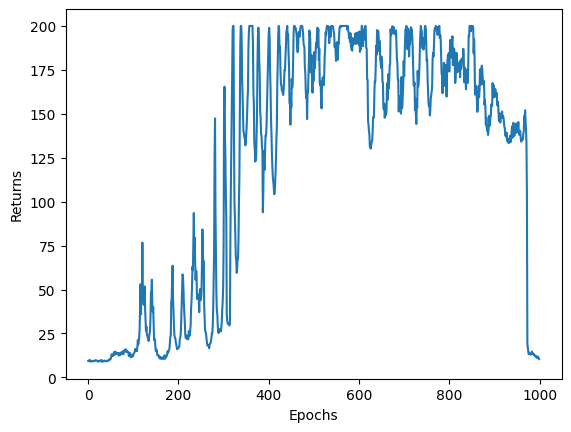

In [16]:
# Solution:
# Model
net = ts.utils.net.common.Net(
    env.observation_space.shape,
    env.action_space.n,
    hidden_sizes=[128, 128],
    device=device,
).to(device)

optim = torch.optim.Adam(net.parameters(), lr=0.001)

# Policy
policy = ts.policy.DQNPolicy(
    model=net, # value network
    optim=optim, # optimizer
    discount_factor=0.99, # gamma
    estimation_step=3, # n-step returns
    is_double=True, # double Q-learning
    target_update_freq=120, # how often to update the target network
    action_space=env.action_space, # action space
)
policy.set_eps(0.1) # epsilon-greedy action selection

# Collector for training
collector = ts.data.Collector(
    policy=policy,
    env=ts.env.DummyVectorEnv([lambda: gym.make('CartPole-v0') for _ in range(10)]),
    buffer=ts.data.VectorReplayBuffer(20000, 10),
    exploration_noise=True
)
# Collector for testing (without exploration). No need for a buffer
test_collector = ts.data.Collector(
    policy=policy,
    env=ts.env.DummyVectorEnv([lambda: gym.make('CartPole-v0') for _ in range(10)]),
    exploration_noise=False
)

# Pre-fill the training buffer with random transitions
collector.reset()
collector.collect(n_step=1000, random=True,)

# Interaction
returns = []
for iteration in (pbar := tqdm.tqdm(range(1000))):

    # Training mode
    policy.train()
    policy.is_within_training_step = True

    # Exploration schedule
    if iteration <= 100:
        eps = 0.5
    elif iteration <= 900:
        eps = 0.5 - (iteration - 100) / (900 - 100) * (0.5 - 0.05)
    else:
        eps = 0.05
    policy.set_eps(eps)

    # Collect transitions
    result = collector.collect(n_step=1000)

    # Train DQN network on 10 minibatches
    policy.update(
        buffer=collector.buffer,
        sample_size=0, # use the whole buffer
        batch_size=128,
        repeat=10,
    )

    # Test 10 episodes
    policy.eval()
    test_collector.reset()
    result = test_collector.collect(n_episode=10)
    mean_reward = result.returns.mean()
    pbar.set_description(f"reward : {mean_reward}")
    returns.append(mean_reward)

plt.figure()
plt.plot(np.array(returns))
plt.xlabel("Epochs")
plt.ylabel("Returns")
plt.show()

Return: 9.0
MoviePy - Building file videos/cartpole-dqn2.gif with imageio.


t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


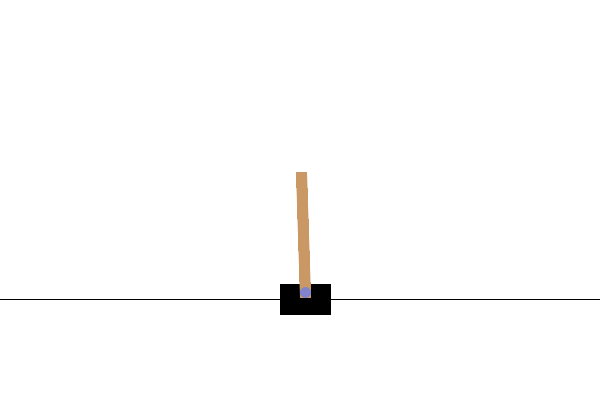

In [17]:
# Solution:
# Evaluation mode
policy.eval()

# Create a recordable environment
env = gym.make('CartPole-v0', render_mode="rgb_array_list")
recorder = GymRecorder(env)

# Sample the initial state
state, info = env.reset()

# One episode:
done = False
return_episode = 0
while not done:

    # Select an action from the learned policy
    action = policy.forward(ts.data.Batch(obs=[state], info=None)).act[0]

    # Sample a single transition
    next_state, reward, terminal, truncated, info = env.step(action)

    # End of the episode
    done = terminal or truncated

    # Update undiscounted return
    return_episode += reward

    # Go in the next state
    state = next_state

print("Return:", return_episode)

recorder.record(env.render())
video = "videos/cartpole-dqn2.gif"
recorder.make_video(video)
ipython_display(video)

## PPO

Now that DQN works on Cartpole, let's use PPO and compare its performance to DQN.

You will need to use the PPO policy, obviously:

```python
policy = ts.policy.PPOPolicy(
    actor=actor,
    critic=critic,
    optim=optim,
    dist_fn=torch.distributions.Categorical,
    action_space=env.action_space,
    discount_factor=0.99,
    max_grad_norm=0.5,
    eps_clip=0.2,
    gae_lambda=0.95,
    deterministic_eval=True,
    action_scaling=False,
)
```

It has many more hyperparameters, which can be let at their default value (or not, depending on the time you have). Check the doc for their meaning. The important thing is that you now need an actor and a critic, not a single network.

One way to do it is to use the actor/critic specifications provided by tianshou:

```python
features = ts.utils.net.common.Net(
    state_shape=env.observation_space.shape,
    hidden_sizes=[64, 64],
    device=device)

actor = ts.utils.net.discrete.Actor(
    preprocess_net=features,
    action_shape=env.action_space.n,
    device=device).to(device)

critic = ts.utils.net.discrete.Critic(
    preprocess_net=features,
    device=device).to(device)

actor_critic = ts.utils.net.common.ActorCritic(actor=actor, critic=critic)

optim = torch.optim.Adam(actor_critic.parameters(), lr=0.001)
```

``features`` is the shared feature extractor between the actor and the critic. ``actor`` is the policy head (one neuron per discrete action), ``critic`` is a single output neuron for the value V(s). ``actor_critic`` is the combined two-headed network.

When defining the PPO policy, `dist_fn=torch.distributions.Categorical` specifies how exploration is performed, here a softmax over the two actions left and right.

**Q:** Implement PPO on Cartpole. You will need to find the right hyperparameters for the task.

Remember that learning is **on-policy**, so the transition buffer must be emptied after training the network. Your interaction loop must therefore look like this:

```python
for iteration in range(N):

    # Collect enough on-policy steps
    result = collector.collect(...)

    # Update the PP0 network by learning the on-policy buffer
    policy.update(...)

    # Empty the buffer as we are on-policy
    collector.reset_buffer(keep_statistics=False)
```

Do not hesitate to collect many on-policy steps before training the network.

  0%|          | 0/100 [00:00<?, ?it/s]

reward : 51.7:   0%|          | 0/100 [00:00<?, ?it/s]

reward : 51.7:   1%|          | 1/100 [00:00<01:23,  1.19it/s]

reward : 48.7:   1%|          | 1/100 [00:01<01:23,  1.19it/s]

reward : 48.7:   2%|▏         | 2/100 [00:01<01:19,  1.24it/s]

reward : 49.5:   2%|▏         | 2/100 [00:02<01:19,  1.24it/s]

reward : 49.5:   3%|▎         | 3/100 [00:02<01:18,  1.23it/s]

reward : 84.7:   3%|▎         | 3/100 [00:03<01:18,  1.23it/s]

reward : 84.7:   4%|▍         | 4/100 [00:03<01:19,  1.21it/s]

reward : 119.3:   4%|▍         | 4/100 [00:04<01:19,  1.21it/s]

reward : 119.3:   5%|▌         | 5/100 [00:04<01:20,  1.18it/s]

reward : 100.0:   5%|▌         | 5/100 [00:05<01:20,  1.18it/s]

reward : 100.0:   6%|▌         | 6/100 [00:05<01:20,  1.16it/s]

reward : 134.5:   6%|▌         | 6/100 [00:05<01:20,  1.16it/s]

reward : 134.5:   7%|▋         | 7/100 [00:05<01:21,  1.15it/s]

reward : 114.7:   7%|▋         | 7/100 [00:06<01:21,  1.15it/s]

reward : 114.7:   8%|▊         | 8/100 [00:06<01:19,  1.15it/s]

reward : 117.6:   8%|▊         | 8/100 [00:07<01:19,  1.15it/s]

reward : 117.6:   9%|▉         | 9/100 [00:07<01:19,  1.15it/s]

reward : 136.0:   9%|▉         | 9/100 [00:08<01:19,  1.15it/s]

reward : 136.0:  10%|█         | 10/100 [00:08<01:19,  1.14it/s]

reward : 163.1:  10%|█         | 10/100 [00:09<01:19,  1.14it/s]

reward : 163.1:  11%|█         | 11/100 [00:09<01:19,  1.13it/s]

reward : 180.5:  11%|█         | 11/100 [00:10<01:19,  1.13it/s]

reward : 180.5:  12%|█▏        | 12/100 [00:10<01:18,  1.12it/s]

reward : 200.0:  12%|█▏        | 12/100 [00:11<01:18,  1.12it/s]

reward : 200.0:  13%|█▎        | 13/100 [00:11<01:18,  1.11it/s]

reward : 200.0:  13%|█▎        | 13/100 [00:12<01:18,  1.11it/s]

reward : 200.0:  14%|█▍        | 14/100 [00:12<01:17,  1.10it/s]

reward : 200.0:  14%|█▍        | 14/100 [00:13<01:17,  1.10it/s]

reward : 200.0:  15%|█▌        | 15/100 [00:13<01:17,  1.10it/s]

reward : 176.1:  15%|█▌        | 15/100 [00:14<01:17,  1.10it/s]

reward : 176.1:  16%|█▌        | 16/100 [00:14<01:16,  1.10it/s]

reward : 200.0:  16%|█▌        | 16/100 [00:14<01:16,  1.10it/s]

reward : 200.0:  17%|█▋        | 17/100 [00:14<01:15,  1.10it/s]

reward : 181.6:  17%|█▋        | 17/100 [00:15<01:15,  1.10it/s]

reward : 181.6:  18%|█▊        | 18/100 [00:15<01:14,  1.10it/s]

reward : 200.0:  18%|█▊        | 18/100 [00:16<01:14,  1.10it/s]

reward : 200.0:  19%|█▉        | 19/100 [00:16<01:13,  1.10it/s]

reward : 200.0:  19%|█▉        | 19/100 [00:17<01:13,  1.10it/s]

reward : 200.0:  20%|██        | 20/100 [00:17<01:13,  1.10it/s]

reward : 200.0:  20%|██        | 20/100 [00:18<01:13,  1.10it/s]

reward : 200.0:  21%|██        | 21/100 [00:18<01:12,  1.10it/s]

reward : 200.0:  21%|██        | 21/100 [00:19<01:12,  1.10it/s]

reward : 200.0:  22%|██▏       | 22/100 [00:19<01:11,  1.10it/s]

reward : 200.0:  22%|██▏       | 22/100 [00:20<01:11,  1.10it/s]

reward : 200.0:  23%|██▎       | 23/100 [00:20<01:10,  1.10it/s]

reward : 200.0:  23%|██▎       | 23/100 [00:21<01:10,  1.10it/s]

reward : 200.0:  24%|██▍       | 24/100 [00:21<01:09,  1.09it/s]

reward : 200.0:  24%|██▍       | 24/100 [00:22<01:09,  1.09it/s]

reward : 200.0:  25%|██▌       | 25/100 [00:22<01:08,  1.10it/s]

reward : 200.0:  25%|██▌       | 25/100 [00:23<01:08,  1.10it/s]

reward : 200.0:  26%|██▌       | 26/100 [00:23<01:07,  1.10it/s]

reward : 200.0:  26%|██▌       | 26/100 [00:24<01:07,  1.10it/s]

reward : 200.0:  27%|██▋       | 27/100 [00:24<01:06,  1.10it/s]

reward : 200.0:  27%|██▋       | 27/100 [00:25<01:06,  1.10it/s]

reward : 200.0:  28%|██▊       | 28/100 [00:25<01:05,  1.09it/s]

reward : 200.0:  28%|██▊       | 28/100 [00:25<01:05,  1.09it/s]

reward : 200.0:  29%|██▉       | 29/100 [00:25<01:04,  1.09it/s]

reward : 200.0:  29%|██▉       | 29/100 [00:26<01:04,  1.09it/s]

reward : 200.0:  30%|███       | 30/100 [00:26<01:04,  1.09it/s]

reward : 200.0:  30%|███       | 30/100 [00:27<01:04,  1.09it/s]

reward : 200.0:  31%|███       | 31/100 [00:27<01:03,  1.09it/s]

reward : 200.0:  31%|███       | 31/100 [00:28<01:03,  1.09it/s]

reward : 200.0:  32%|███▏      | 32/100 [00:28<01:02,  1.09it/s]

reward : 200.0:  32%|███▏      | 32/100 [00:29<01:02,  1.09it/s]

reward : 200.0:  33%|███▎      | 33/100 [00:29<01:01,  1.09it/s]

reward : 200.0:  33%|███▎      | 33/100 [00:30<01:01,  1.09it/s]

reward : 200.0:  34%|███▍      | 34/100 [00:30<01:00,  1.09it/s]

reward : 200.0:  34%|███▍      | 34/100 [00:31<01:00,  1.09it/s]

reward : 200.0:  35%|███▌      | 35/100 [00:31<00:59,  1.09it/s]

reward : 200.0:  35%|███▌      | 35/100 [00:32<00:59,  1.09it/s]

reward : 200.0:  36%|███▌      | 36/100 [00:32<00:58,  1.09it/s]

reward : 200.0:  36%|███▌      | 36/100 [00:33<00:58,  1.09it/s]

reward : 200.0:  37%|███▋      | 37/100 [00:33<00:57,  1.09it/s]

reward : 200.0:  37%|███▋      | 37/100 [00:34<00:57,  1.09it/s]

reward : 200.0:  38%|███▊      | 38/100 [00:34<00:56,  1.09it/s]

reward : 200.0:  38%|███▊      | 38/100 [00:35<00:56,  1.09it/s]

reward : 200.0:  39%|███▉      | 39/100 [00:35<00:55,  1.09it/s]

reward : 200.0:  39%|███▉      | 39/100 [00:36<00:55,  1.09it/s]

reward : 200.0:  40%|████      | 40/100 [00:36<00:54,  1.09it/s]

reward : 200.0:  40%|████      | 40/100 [00:36<00:54,  1.09it/s]

reward : 200.0:  41%|████      | 41/100 [00:36<00:54,  1.09it/s]

reward : 200.0:  41%|████      | 41/100 [00:37<00:54,  1.09it/s]

reward : 200.0:  42%|████▏     | 42/100 [00:37<00:53,  1.09it/s]

reward : 200.0:  42%|████▏     | 42/100 [00:38<00:53,  1.09it/s]

reward : 200.0:  43%|████▎     | 43/100 [00:38<00:52,  1.09it/s]

reward : 200.0:  43%|████▎     | 43/100 [00:39<00:52,  1.09it/s]

reward : 200.0:  44%|████▍     | 44/100 [00:39<00:51,  1.09it/s]

reward : 184.7:  44%|████▍     | 44/100 [00:40<00:51,  1.09it/s]

reward : 184.7:  45%|████▌     | 45/100 [00:40<00:50,  1.09it/s]

reward : 200.0:  45%|████▌     | 45/100 [00:41<00:50,  1.09it/s]

reward : 200.0:  46%|████▌     | 46/100 [00:41<00:49,  1.09it/s]

reward : 200.0:  46%|████▌     | 46/100 [00:42<00:49,  1.09it/s]

reward : 200.0:  47%|████▋     | 47/100 [00:42<00:48,  1.09it/s]

reward : 200.0:  47%|████▋     | 47/100 [00:43<00:48,  1.09it/s]

reward : 200.0:  48%|████▊     | 48/100 [00:43<00:47,  1.09it/s]

reward : 200.0:  48%|████▊     | 48/100 [00:44<00:47,  1.09it/s]

reward : 200.0:  49%|████▉     | 49/100 [00:44<00:46,  1.09it/s]

reward : 200.0:  49%|████▉     | 49/100 [00:45<00:46,  1.09it/s]

reward : 200.0:  50%|█████     | 50/100 [00:45<00:45,  1.09it/s]

reward : 200.0:  50%|█████     | 50/100 [00:46<00:45,  1.09it/s]

reward : 200.0:  51%|█████     | 51/100 [00:46<00:44,  1.09it/s]

reward : 200.0:  51%|█████     | 51/100 [00:46<00:44,  1.09it/s]

reward : 200.0:  52%|█████▏    | 52/100 [00:47<00:43,  1.09it/s]

reward : 200.0:  52%|█████▏    | 52/100 [00:47<00:43,  1.09it/s]

reward : 200.0:  53%|█████▎    | 53/100 [00:47<00:43,  1.09it/s]

reward : 200.0:  53%|█████▎    | 53/100 [00:48<00:43,  1.09it/s]

reward : 200.0:  54%|█████▍    | 54/100 [00:48<00:42,  1.09it/s]

reward : 200.0:  54%|█████▍    | 54/100 [00:49<00:42,  1.09it/s]

reward : 200.0:  55%|█████▌    | 55/100 [00:49<00:41,  1.09it/s]

reward : 200.0:  55%|█████▌    | 55/100 [00:50<00:41,  1.09it/s]

reward : 200.0:  56%|█████▌    | 56/100 [00:50<00:40,  1.09it/s]

reward : 200.0:  56%|█████▌    | 56/100 [00:51<00:40,  1.09it/s]

reward : 200.0:  57%|█████▋    | 57/100 [00:51<00:39,  1.10it/s]

reward : 200.0:  57%|█████▋    | 57/100 [00:52<00:39,  1.10it/s]

reward : 200.0:  58%|█████▊    | 58/100 [00:52<00:38,  1.09it/s]

reward : 200.0:  58%|█████▊    | 58/100 [00:53<00:38,  1.09it/s]

reward : 200.0:  59%|█████▉    | 59/100 [00:53<00:37,  1.09it/s]

reward : 200.0:  59%|█████▉    | 59/100 [00:54<00:37,  1.09it/s]

reward : 200.0:  60%|██████    | 60/100 [00:54<00:36,  1.09it/s]

reward : 200.0:  60%|██████    | 60/100 [00:55<00:36,  1.09it/s]

reward : 200.0:  61%|██████    | 61/100 [00:55<00:35,  1.10it/s]

reward : 200.0:  61%|██████    | 61/100 [00:56<00:35,  1.10it/s]

reward : 200.0:  62%|██████▏   | 62/100 [00:56<00:34,  1.09it/s]

reward : 200.0:  62%|██████▏   | 62/100 [00:57<00:34,  1.09it/s]

reward : 200.0:  63%|██████▎   | 63/100 [00:57<00:33,  1.09it/s]

reward : 200.0:  63%|██████▎   | 63/100 [00:57<00:33,  1.09it/s]

reward : 200.0:  64%|██████▍   | 64/100 [00:57<00:32,  1.09it/s]

reward : 200.0:  64%|██████▍   | 64/100 [00:58<00:32,  1.09it/s]

reward : 200.0:  65%|██████▌   | 65/100 [00:58<00:32,  1.09it/s]

reward : 200.0:  65%|██████▌   | 65/100 [00:59<00:32,  1.09it/s]

reward : 200.0:  66%|██████▌   | 66/100 [00:59<00:31,  1.09it/s]

reward : 200.0:  66%|██████▌   | 66/100 [01:00<00:31,  1.09it/s]

reward : 200.0:  67%|██████▋   | 67/100 [01:00<00:30,  1.09it/s]

reward : 200.0:  67%|██████▋   | 67/100 [01:01<00:30,  1.09it/s]

reward : 200.0:  68%|██████▊   | 68/100 [01:01<00:29,  1.09it/s]

reward : 200.0:  68%|██████▊   | 68/100 [01:02<00:29,  1.09it/s]

reward : 200.0:  69%|██████▉   | 69/100 [01:02<00:28,  1.09it/s]

reward : 200.0:  69%|██████▉   | 69/100 [01:03<00:28,  1.09it/s]

reward : 200.0:  70%|███████   | 70/100 [01:03<00:27,  1.09it/s]

reward : 200.0:  70%|███████   | 70/100 [01:04<00:27,  1.09it/s]

reward : 200.0:  71%|███████   | 71/100 [01:04<00:26,  1.09it/s]

reward : 200.0:  71%|███████   | 71/100 [01:05<00:26,  1.09it/s]

reward : 200.0:  72%|███████▏  | 72/100 [01:05<00:25,  1.09it/s]

reward : 200.0:  72%|███████▏  | 72/100 [01:06<00:25,  1.09it/s]

reward : 200.0:  73%|███████▎  | 73/100 [01:06<00:24,  1.09it/s]

reward : 200.0:  73%|███████▎  | 73/100 [01:07<00:24,  1.09it/s]

reward : 200.0:  74%|███████▍  | 74/100 [01:07<00:23,  1.09it/s]

reward : 200.0:  74%|███████▍  | 74/100 [01:08<00:23,  1.09it/s]

reward : 200.0:  75%|███████▌  | 75/100 [01:08<00:22,  1.09it/s]

reward : 200.0:  75%|███████▌  | 75/100 [01:08<00:22,  1.09it/s]

reward : 200.0:  76%|███████▌  | 76/100 [01:08<00:21,  1.09it/s]

reward : 200.0:  76%|███████▌  | 76/100 [01:09<00:21,  1.09it/s]

reward : 200.0:  77%|███████▋  | 77/100 [01:09<00:21,  1.09it/s]

reward : 200.0:  77%|███████▋  | 77/100 [01:10<00:21,  1.09it/s]

reward : 200.0:  78%|███████▊  | 78/100 [01:10<00:20,  1.09it/s]

reward : 200.0:  78%|███████▊  | 78/100 [01:11<00:20,  1.09it/s]

reward : 200.0:  79%|███████▉  | 79/100 [01:11<00:19,  1.09it/s]

reward : 200.0:  79%|███████▉  | 79/100 [01:12<00:19,  1.09it/s]

reward : 200.0:  80%|████████  | 80/100 [01:12<00:18,  1.09it/s]

reward : 200.0:  80%|████████  | 80/100 [01:13<00:18,  1.09it/s]

reward : 200.0:  81%|████████  | 81/100 [01:13<00:17,  1.09it/s]

reward : 200.0:  81%|████████  | 81/100 [01:14<00:17,  1.09it/s]

reward : 200.0:  82%|████████▏ | 82/100 [01:14<00:16,  1.09it/s]

reward : 200.0:  82%|████████▏ | 82/100 [01:15<00:16,  1.09it/s]

reward : 200.0:  83%|████████▎ | 83/100 [01:15<00:15,  1.09it/s]

reward : 200.0:  83%|████████▎ | 83/100 [01:16<00:15,  1.09it/s]

reward : 200.0:  84%|████████▍ | 84/100 [01:16<00:14,  1.10it/s]

reward : 200.0:  84%|████████▍ | 84/100 [01:17<00:14,  1.10it/s]

reward : 200.0:  85%|████████▌ | 85/100 [01:17<00:13,  1.10it/s]

reward : 200.0:  85%|████████▌ | 85/100 [01:18<00:13,  1.10it/s]

reward : 200.0:  86%|████████▌ | 86/100 [01:18<00:12,  1.09it/s]

reward : 200.0:  86%|████████▌ | 86/100 [01:19<00:12,  1.09it/s]

reward : 200.0:  87%|████████▋ | 87/100 [01:19<00:11,  1.09it/s]

reward : 200.0:  87%|████████▋ | 87/100 [01:19<00:11,  1.09it/s]

reward : 200.0:  88%|████████▊ | 88/100 [01:19<00:10,  1.10it/s]

reward : 200.0:  88%|████████▊ | 88/100 [01:20<00:10,  1.10it/s]

reward : 200.0:  89%|████████▉ | 89/100 [01:20<00:10,  1.09it/s]

reward : 200.0:  89%|████████▉ | 89/100 [01:21<00:10,  1.09it/s]

reward : 200.0:  90%|█████████ | 90/100 [01:21<00:09,  1.09it/s]

reward : 200.0:  90%|█████████ | 90/100 [01:22<00:09,  1.09it/s]

reward : 200.0:  91%|█████████ | 91/100 [01:22<00:08,  1.10it/s]

reward : 200.0:  91%|█████████ | 91/100 [01:23<00:08,  1.10it/s]

reward : 200.0:  92%|█████████▏| 92/100 [01:23<00:07,  1.10it/s]

reward : 200.0:  92%|█████████▏| 92/100 [01:24<00:07,  1.10it/s]

reward : 200.0:  93%|█████████▎| 93/100 [01:24<00:06,  1.10it/s]

reward : 200.0:  93%|█████████▎| 93/100 [01:25<00:06,  1.10it/s]

reward : 200.0:  94%|█████████▍| 94/100 [01:25<00:05,  1.10it/s]

reward : 200.0:  94%|█████████▍| 94/100 [01:26<00:05,  1.10it/s]

reward : 200.0:  95%|█████████▌| 95/100 [01:26<00:04,  1.10it/s]

reward : 200.0:  95%|█████████▌| 95/100 [01:27<00:04,  1.10it/s]

reward : 200.0:  96%|█████████▌| 96/100 [01:27<00:03,  1.10it/s]

reward : 200.0:  96%|█████████▌| 96/100 [01:28<00:03,  1.10it/s]

reward : 200.0:  97%|█████████▋| 97/100 [01:28<00:02,  1.10it/s]

reward : 200.0:  97%|█████████▋| 97/100 [01:29<00:02,  1.10it/s]

reward : 200.0:  98%|█████████▊| 98/100 [01:29<00:01,  1.10it/s]

reward : 200.0:  98%|█████████▊| 98/100 [01:29<00:01,  1.10it/s]

reward : 200.0:  99%|█████████▉| 99/100 [01:29<00:00,  1.10it/s]

reward : 200.0:  99%|█████████▉| 99/100 [01:30<00:00,  1.10it/s]

reward : 200.0: 100%|██████████| 100/100 [01:30<00:00,  1.10it/s]

reward : 200.0: 100%|██████████| 100/100 [01:30<00:00,  1.10it/s]

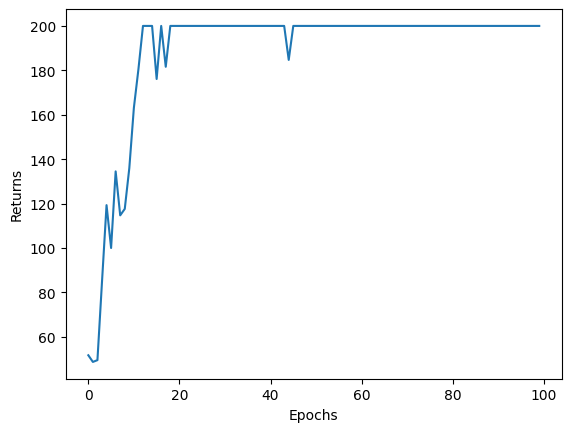

In [18]:
# Solution:
# Model
features = ts.utils.net.common.Net(
    state_shape=env.observation_space.shape,
    hidden_sizes=[64, 64],
    device=device)

actor = ts.utils.net.discrete.Actor(
    preprocess_net=features,
    action_shape=env.action_space.n,
    device=device).to(device)

critic = ts.utils.net.discrete.Critic(
    preprocess_net=features,
    device=device).to(device)

actor_critic = ts.utils.net.common.ActorCritic(actor=actor, critic=critic)

optim = torch.optim.Adam(actor_critic.parameters(), lr=0.003)

# Policy
policy = ts.policy.PPOPolicy(
    actor=actor,
    critic=critic,
    optim=optim,
    dist_fn=torch.distributions.Categorical,
    action_space=env.action_space,
    deterministic_eval=True,
    action_scaling=False,
    discount_factor=0.99,
    max_grad_norm=0.5,
    eps_clip=0.2,
    gae_lambda=0.95,
)

# Collector
collector = ts.data.Collector(
    policy=policy,
    env=ts.env.DummyVectorEnv([lambda: gym.make('CartPole-v0') for _ in range(10)]),
    buffer=ts.data.VectorReplayBuffer(20000, 10),
    exploration_noise=True
)
collector.reset()

test_collector = ts.data.Collector(
    policy=policy,
    env=ts.env.DummyVectorEnv([lambda: gym.make('CartPole-v0') for _ in range(10)]),
    exploration_noise=False
)

# On-policy trainer
returns = []
for iteration in (pbar := tqdm.tqdm(range(100))):

    # Training phase
    policy.train()
    policy.is_within_training_step = True

    # Collect enough on-policy steps
    result = collector.collect(n_step=3000)

    # Update the PP0 network by learning the on-policy buffer 10 times
    policy.update(
        buffer=collector.buffer,
        sample_size=0, # use the whole buffer
        batch_size=256,
        repeat=10,
    )

    # Empty the buffer as we are on-policy
    collector.reset_buffer(keep_statistics=False)

    # Test 10 episodes
    policy.eval()
    test_collector.reset()
    result = test_collector.collect(n_episode=10)
    mean_reward = result.returns.mean()
    pbar.set_description(f"reward : {mean_reward}")
    returns.append(mean_reward)

plt.figure()
plt.plot(np.array(returns))
plt.xlabel("Epochs")
plt.ylabel("Returns")
plt.show()

Return: 200.0
MoviePy - Building file videos/cartpole-ppo.gif with imageio.


t:   0%|          | 0/202 [00:00<?, ?it/s, now=None]


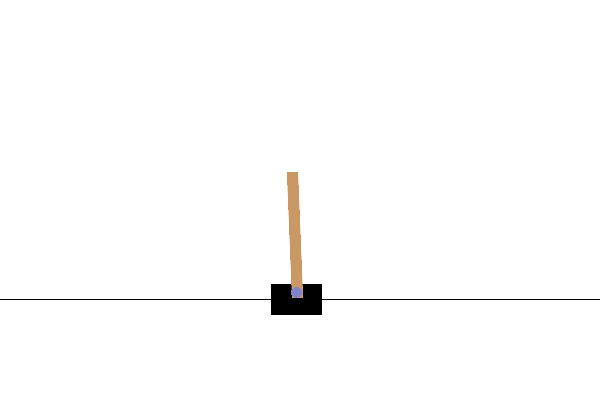

In [19]:
# Solution:
# Evaluation mode
policy.eval()

# Create a recordable environment
env = gym.make('CartPole-v0', render_mode="rgb_array_list")
recorder = GymRecorder(env)

# Sample the initial state
state, info = env.reset()

# One episode:
done = False
return_episode = 0
while not done:
    # Select an action from the learned policy
    action = policy.forward(ts.data.Batch(obs=[state], info=None)).act[0].numpy()
    # Sample a single transition
    next_state, reward, terminal, truncated, info = env.step(action)
    # End of the episode
    done = terminal or truncated
    # Update undiscounted return
    return_episode += reward
    # Go in the next state
    state = next_state

print("Return:", return_episode)

recorder.record(env.render())
video = "videos/cartpole-ppo.gif"
recorder.make_video(video)
ipython_display(video)

**Q:** How does it compare to DQN once the right hyperparameters are found? What is their influence? Play especially with `eps_clip`, the $\epsilon$ threshold used to clip the IS weight in the PPO loss.

**Q:** Apply PPO to more complex environments available in gymnasium. Beware that for continuous action spaces, you will need to use continuous actor/critic networks, i.e.:

```python
actor = ts.utils.net.continuous.Actor(...)
critic = ts.utils.net.continuous.Critic(...)
```

instead of:

```python
actor = ts.utils.net.discrete.Actor(...)
critic = ts.utils.net.discrete.Critic(...)
```

The `dist_fn` argument of `PPOPolicy` must also be set accordingly. Check the doc!